In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
import json
import ast

In [3]:
from catboost import CatBoostClassifier
import time
from sklearn import linear_model
import eli5
from eli5.sklearn import PermutationImportance
import shap
from tqdm import tqdm_notebook

In [5]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

/home/watts/anaconda3/envs/sa/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [38]:
train = pd.read_csv('../data/train.csv.zip')
y = train['target']
test = pd.read_csv('../data/test.csv.zip')

In [6]:
X1 = pd.read_csv('../cache/X1_qt.csv')
X2 = pd.read_csv('../cache/X2_qt.csv')

In [9]:
model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.83072	valid_1's auc: 0.819951
[2000]	training's auc: 0.860805	valid_1's auc: 0.850025
[3000]	training's auc: 0.875368	valid_1's auc: 0.863899
[4000]	training's auc: 0.884027	valid_1's auc: 0.871963
[5000]	training's auc: 0.889954	valid_1's auc: 0.877426
[6000]	training's auc: 0.894411	valid_1's auc: 0.881449
[7000]	training's auc: 0.897707	valid_1's auc: 0.88442
[8000]	training's auc: 0.900292	valid_1's auc: 0.886616
[9000]	training's auc: 0.902348	valid_1's auc: 0.888456
[10000]	training's auc: 0.903978	valid_1's auc: 0.889909
[11000]	training's auc: 0.905334	valid_1's auc: 0.891054
[12000]	training's auc: 0.906463	valid_1's auc: 0.892073
[13000]	training's auc: 0.907408	valid_1's auc: 0.892858
[14000]	training's auc: 0.90823	valid_1's auc: 0.893513
[15000]	training's auc: 0.908936	valid_1's auc: 0.894094
[16000]	training's auc: 0.909578	valid_1's auc: 0.894599
[17000]	training's auc: 0.910138	val

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=999999, n_jobs=-1, num_leaves=2,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [11]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(X1.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

In [14]:
cols = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:30]
X3 = X1.copy()
X4 = X2.copy()

len_cols = len(cols)
for i in tqdm(range(len_cols)):
    for j in range(i+1, len_cols):
        col1 = cols[i]
        col2 = cols[j]
        
        col3 = col1 + '_plus_' + col2
        X3[col3] = X3[col1] + X3[col2]
        X4[col3] = X4[col1] + X4[col2]
        
        col4 = col1 + '_minus_' + col2
        X3[col4] = X3[col1] - X3[col2]
        X4[col4] = X4[col1] - X4[col2]
        
        col5 = col1 + '_mult_' + col2
        X3[col5] = X3[col1] * X3[col2]
        X4[col5] = X4[col1] * X4[col2]
        
        col6 = col1 + '_div_' + col2
        X3[col6] = X3[col1] / X3[col2]
        X4[col6] = X4[col1] / X4[col2]

100%|██████████| 30/30 [00:46<00:00,  1.54s/it]


In [20]:
X3.shape

(200000, 1940)

In [7]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
#             model = lgb.train(params,
#                     train_data,
#                     num_boost_round=20000,
#                     valid_sets = [train_data, valid_data],
#                     verbose_eval=1000,
#                     early_stopping_rounds = 1000)
#             params <- list(objective = "binary", 
#                boost="gbdt",
#                metric="auc",
#                boost_from_average="false",
#                num_threads=28,
#                learning_rate = 0.01,
#                num_leaves = 13,
#                max_depth=-1,
#                tree_learner = "serial",
#                feature_fraction = 0.05,
#                bagging_freq = 5,
#                bagging_fraction = 0.4,
#                min_data_in_leaf = 80,
#                min_sum_hessian_in_leaf = 10.0,
#                verbosity = 1)
# param = {
#     'bagging_freq': 5,          'bagging_fraction': 0.335,   'boost_from_average':'false',   'boost': 'gbdt',
#     'feature_fraction': 0.041,   'learning_rate': 0.0083,     'max_depth': -1,                'metric':'auc',
#     'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,           'num_threads': 8,
#     'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
# }

# param = {
#     'bagging_freq': 5,          'bagging_fraction': 0.38,   'boost_from_average':'false',   'boost': 'gbdt',
#     'feature_fraction': 0.045,   'learning_rate': 0.0105,     'max_depth': -1,                'metric':'auc',
#     'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,           'num_threads': 8,
#     'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
# }
            model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#             model = lgb.LGBMClassifier(
#                  boost="gbdt",
#                  metric="auc",
#                  boost_from_average="false",
#                  objective='binary', 
#                  n_jobs=-1)
#             model = lgb.LGBMClassifier(
#                  max_depth=-1,
#                  n_estimators=999999,
#                  learning_rate=0.02,
#                  colsample_bytree=0.3,
#                  num_leaves=2,
#                  metric='auc',
# #                  random_seed = 42 + params,
#                  objective='binary', 
#                  n_jobs=-1)
            
            model.fit(X_train, y_train, 
                eval_set=[(X_valid, y_valid)],
                verbose=1000, 
                early_stopping_rounds=3000)
#             y_pred_valid = model.predict(X_valid)
#             y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
            y_pred_valid = model.predict_proba(X_valid)[:,1]       
            y_pred = model.predict_proba(X_test)[:,1]
        if model_type == 'xgb':
#             print('1')
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)
#             print('2')
            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.XGBClassifier(max_depth=6,
                                      max_leaves=13,
                                      booster='gbtree',
#                                       feature_fraction = 0.05,
#                                       bagging_freq = 5,
                                      subsample = 0.335,
                                      min_data_in_leaf = 80,
                                      min_child_weight = 10.0,
                                      n_estimators=999999,
                                      colsample_bytree=0.041,
                                      learning_rate=0.0083,
                                      objective='binary:logistic', 
                                      eval_metric='auc',
#                                       seed = 42 + params,
                                      n_jobs=-1)
#             model = xgb.XGBClassifier(max_depth=2,
#                                       n_estimators=999999,
#                                       colsample_bytree=0.3,
#                                       learning_rate=0.02,
#                                       objective='binary:logistic', 
#                                       eval_metric='auc',
# #                                       seed = 42 + params,
#                                       n_jobs=-1)
     
            model.fit(X_train, y_train, 
                eval_set=[(X_valid, y_valid)],
                verbose=1000, 
                early_stopping_rounds=1000)
              
    
#             model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
#             print('2a')
#             y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
#             y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
#             print('3')
            y_pred_valid = model.predict_proba(X_valid)[:,1]
            y_pred = model.predict_proba(X_test)[:,1]
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid)[:,1].reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
#             model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
#             model = CatBoostClassifier(iterations=999999,
#                                   max_depth=2,
#                                   learning_rate=0.02,
#                                   colsample_bylevel=0.03,
#                                   eval_metric='AUC',
#                                   objective="Logloss")
# max_depth=6,
#                                       max_leaves=13,
#                                       booster='gbtree',
# #                                       feature_fraction = 0.05,
# #                                       bagging_freq = 5,
#                                       subsample = 0.4,
#                                       min_data_in_leaf = 80,
#                                       min_child_weight = 10.0,
#                                       n_estimators=999999,
#                                       colsample_bytree=0.05,
#                                       learning_rate=0.01,
#                                       objective='binary:logistic', 
#                                       eval_metric='auc',
# #                                       seed = 42 + params,
#                                       n_jobs=-1)
            model = CatBoostClassifier(iterations=999999,
                                  max_depth=4,
                                  learning_rate=0.01,
#                                   subsample=0.4,
                                  l2_leaf_reg = 10.0,     
                                  colsample_bylevel=0.05,
#                                   thread_count=np.nan,
                                  eval_metric='AUC',
                                  objective="Logloss")
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[12, 91], 
                      use_best_model=True, verbose=1000,early_stopping_rounds=1000)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if (model_type == 'lgb') & (plot_feature_importance):
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if (model_type == 'lgb') & (plot_feature_importance):
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores


In [8]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=123)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=123)

In [18]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

Fold 0 started at Mon Mar  4 18:09:23 2019
0:	test: 0.5303807	best: 0.5303807 (0)	total: 115ms	remaining: 1d 7h 48m 30s
1000:	test: 0.8402979	best: 0.8402979 (1000)	total: 35.5s	remaining: 9h 50m 40s
2000:	test: 0.8669733	best: 0.8669736 (1999)	total: 1m 7s	remaining: 9h 18m 7s
3000:	test: 0.8790965	best: 0.8790965 (3000)	total: 1m 37s	remaining: 9h 37s
4000:	test: 0.8854599	best: 0.8854599 (4000)	total: 2m 8s	remaining: 8h 51m 12s
5000:	test: 0.8892917	best: 0.8892932 (4999)	total: 2m 37s	remaining: 8h 43m 39s
6000:	test: 0.8918151	best: 0.8918151 (6000)	total: 3m 8s	remaining: 8h 40m 28s
7000:	test: 0.8934737	best: 0.8934849 (6992)	total: 3m 41s	remaining: 8h 43m 50s
8000:	test: 0.8946333	best: 0.8946376 (7994)	total: 4m 16s	remaining: 8h 49m 56s
9000:	test: 0.8957269	best: 0.8957364 (8997)	total: 4m 52s	remaining: 8h 56m 54s
10000:	test: 0.8963235	best: 0.8963288 (9982)	total: 5m 30s	remaining: 9h 5m 44s
11000:	test: 0.8968384	best: 0.8968407 (10999)	total: 6m 7s	remaining: 9h 10m 2

17000:	test: 0.8977820	best: 0.8977915 (16985)	total: 10m 40s	remaining: 10h 17m
18000:	test: 0.8979850	best: 0.8979850 (18000)	total: 11m 17s	remaining: 10h 15m 56s
19000:	test: 0.8981048	best: 0.8981087 (18992)	total: 11m 54s	remaining: 10h 14m 56s
20000:	test: 0.8982193	best: 0.8982324 (19864)	total: 12m 32s	remaining: 10h 14m 26s
21000:	test: 0.8982517	best: 0.8982923 (20813)	total: 13m 10s	remaining: 10h 14m 10s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8982923349
bestIteration = 20813

Shrink model to first 20814 iterations.
Fold 4 started at Mon Mar  4 19:20:39 2019
0:	test: 0.5220267	best: 0.5220267 (0)	total: 45.1ms	remaining: 12h 32m 19s
1000:	test: 0.8380915	best: 0.8380915 (1000)	total: 36.2s	remaining: 10h 1m 58s
2000:	test: 0.8681178	best: 0.8681178 (2000)	total: 1m 16s	remaining: 10h 31m 50s
3000:	test: 0.8811279	best: 0.8811279 (3000)	total: 1m 59s	remaining: 11h 2m 57s
4000:	test: 0.8884185	best: 0.8884185 (4000)	total: 2m 45s	remaining: 11h

3000:	test: 0.8699084	best: 0.8699084 (3000)	total: 1m 39s	remaining: 9h 12m 1s
4000:	test: 0.8763896	best: 0.8763896 (4000)	total: 2m 20s	remaining: 9h 41m 21s
5000:	test: 0.8804046	best: 0.8804046 (5000)	total: 3m 1s	remaining: 10h 2m 3s
6000:	test: 0.8830299	best: 0.8830341 (5999)	total: 3m 49s	remaining: 10h 33m 11s
7000:	test: 0.8846765	best: 0.8846780 (6998)	total: 4m 31s	remaining: 10h 40m 47s
8000:	test: 0.8859732	best: 0.8859732 (8000)	total: 5m 10s	remaining: 10h 41m 28s
9000:	test: 0.8869708	best: 0.8869749 (8996)	total: 5m 48s	remaining: 10h 38m 42s
10000:	test: 0.8876470	best: 0.8876476 (9997)	total: 6m 24s	remaining: 10h 34m 44s
11000:	test: 0.8884562	best: 0.8884586 (10996)	total: 7m 3s	remaining: 10h 34m 16s
12000:	test: 0.8889885	best: 0.8889923 (11997)	total: 7m 42s	remaining: 10h 34m 13s
13000:	test: 0.8894429	best: 0.8894495 (12994)	total: 8m 21s	remaining: 10h 33m 58s
14000:	test: 0.8897405	best: 0.8897413 (13997)	total: 9m 1s	remaining: 10h 35m 19s
15000:	test: 0.

In [19]:
np.save('../cache/oof_cat_top30_inter_1_10_1', oof)
np.save('../cache/preds_cat_top30_inter_1_10_1', preds)

In [21]:
for col in list(X1.columns):
    print(col, X1[col].nunique())

var_0 94667
var_1 108929
var_2 86554
var_3 74594
var_4 63514
var_5 141028
var_6 38595
var_7 103057
var_8 98616
var_9 49416
var_10 128762
var_11 130188
var_12 9559
var_13 115181
var_14 79122
var_15 19809
var_16 86915
var_17 137823
var_18 139513
var_19 144179
var_20 127763
var_21 140062
var_22 90653
var_23 24911
var_24 105101
var_25 14850
var_26 127086
var_27 60183
var_28 35857
var_29 88338
var_30 145973
var_31 77387
var_32 85961
var_33 112235
var_34 25163
var_35 122384
var_36 96403
var_37 79039
var_38 115364
var_39 112669
var_40 141878
var_41 131896
var_42 31590
var_43 15183
var_44 127702
var_45 169965
var_46 93446
var_47 154779
var_48 152039
var_49 140640
var_50 32307
var_51 143455
var_52 121311
var_53 33460
var_54 144775
var_55 128076
var_56 103044
var_57 35542
var_58 113904
var_59 37741
var_60 113762
var_61 159368
var_62 74774
var_63 97098
var_64 59376
var_65 108347
var_66 47716
var_67 137252
var_68 459
var_69 110346
var_70 153193
var_71 13526
var_72 110112
var_73 142582
var_74 16105

In [22]:
for col in list(X1.columns):
    if X1[col].nunique() < 1000:
        print(col)

var_68


In [30]:
for col in list(X1.columns):
    if X1[col].nunique() < 10000:
        print(col)

var_12
var_68
var_91
var_103
var_108


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X1, y, test_size = 0.2, random_state=42)

In [47]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

#     def on_epoch_end(self, epoch, logs={}):
#         y_pred = self.model.predict(self.x)
#         roc = roc_auc_score(self.y, y_pred)
#         y_pred_val = self.model.predict(self.x_val)
#         roc_val = roc_auc_score(self.y_val, y_pred_val)
#         print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
#         return
    
    def on_epoch_end(self, epoch, logs={}):
#         y_pred = self.model.predict(self.x)
#         roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_val: %s' % (str(round(roc_val,4))),end=100*' '+'\n')
        return
    
    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return


In [85]:
from keras import backend as K
gamma = 2.0
alpha=.25
epsilon = K.epsilon()

def focal_loss(y_true, y_pred):
    pt_1 = y_pred * y_true
    pt_1 = K.clip(pt_1, epsilon, 1-epsilon)
    CE_1 = -K.log(pt_1)
    FL_1 = alpha* K.pow(1-pt_1, gamma) * CE_1
    
    pt_0 = (1-y_pred) * (1-y_true)
    pt_0 = K.clip(pt_0, epsilon, 1-epsilon)
    CE_0 = -K.log(pt_0)
    FL_0 = (1-alpha)* K.pow(1-pt_0, gamma) * CE_0
    
    loss = K.sum(FL_1, axis=1) + K.sum(FL_0, axis=1)
    return loss

In [86]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, LeakyReLU, ReLU, PReLU, LSTM

a = Input(shape=(200,1))
x = Dense(200)(a)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(64)(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Flatten()(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=a, outputs=x)

In [51]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, LeakyReLU, ReLU, PReLU, LSTM

a = Input(shape=(200,1))
x = LSTM(10, return_sequences=True)(a)
x = Dense(200)(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Dense(64)(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Flatten()(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=a, outputs=x)

In [87]:
from keras import optimizers

from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_val, y_train, y_val = train_test_split(X1, y, test_size = 0.2, random_state=42)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.003)
rmsprop = optimizers.RMSprop(lr=0.01)
model.compile(loss=focal_loss,
              optimizer=sgd,
              metrics=['acc'])
batch_size=1024
epochs=200
X_train = np.reshape(X_train.values, (-1, 200, 1))

X_val = np.reshape(X_val.values, (-1, 200, 1))

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    validation_data=(X_val, y_val),
                    callbacks=[roc_callback(training_data=(X_train, y_train),validation_data=(X_val, y_val))])

# LSTM, stuck around 0.72 auc, adam
# LSTM with return seq, around 0.895 auc, adam
# SGD with relu
# Epoch 100/100 + plus 40 epochs earlier
#  - 9s - loss: 0.1946 - acc: 0.9267 - val_loss: 0.2053 - val_acc: 0.9236
# roc-auc: 0.9131 - roc-auc_val: 0.898    
# Adam with relu (more or less same  with prelu)
# Epoch 100/100
#  - 9s - loss: 0.1949 - acc: 0.9271 - val_loss: 0.2183 - val_acc: 0.9161
# roc-auc: 0.9116 - roc-auc_val: 0.8954 (goes upto 0.8974)            

Train on 160000 samples, validate on 40000 samples
Epoch 1/200
 - 14s - loss: 4.8821 - acc: 0.8842 - val_loss: 4.8782 - val_acc: 0.9173
roc-auc_val: 0.8781                                                                                                    
Epoch 2/200
 - 11s - loss: 4.8626 - acc: 0.9117 - val_loss: 4.8776 - val_acc: 0.9171
roc-auc_val: 0.8789                                                                                                    
Epoch 3/200
 - 11s - loss: 4.8611 - acc: 0.9128 - val_loss: 4.8774 - val_acc: 0.9166
roc-auc_val: 0.8808                                                                                                    
Epoch 4/200
 - 11s - loss: 4.8603 - acc: 0.9134 - val_loss: 4.8770 - val_acc: 0.9158
roc-auc_val: 0.8811                                                                                                    
Epoch 5/200
 - 11s - loss: 4.8594 - acc: 0.9148 - val_loss: 4.8772 - val_acc: 0.9137
roc-auc_val: 0.8803                         

KeyboardInterrupt: 

In [35]:
from sklearn.preprocessing import PolynomialFeatures
p = PolynomialFeatures()
X3 = pd.concat([X1,X2], axis=0)
print(X3.shape)
X3 = p.fit_transform(X3)
X = X3[:len(X1)]
X_test = X3[len(X1):]

(400000, 200)


In [38]:
X = pd.DataFrame(X)
X.columns = ['col_'+str(i) for i in range(X.shape[1])]
X_test = pd.DataFrame(X_test)
X_test.columns = ['col_'+str(i) for i in range(X.shape[1])]

In [39]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X, X_test, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

Fold 0 started at Mon Mar  4 21:50:34 2019
0:	test: 0.5086073	best: 0.5086073 (0)	total: 115ms	remaining: 1d 7h 53m 56s
1000:	test: 0.8433571	best: 0.8433571 (1000)	total: 1m 7s	remaining: 18h 42m 24s
2000:	test: 0.8685388	best: 0.8685565 (1999)	total: 2m 24s	remaining: 20h 4m 19s
3000:	test: 0.8795600	best: 0.8795600 (3000)	total: 3m 53s	remaining: 21h 35m 6s
4000:	test: 0.8853149	best: 0.8853149 (4000)	total: 5m 25s	remaining: 22h 28m 42s
5000:	test: 0.8886569	best: 0.8886658 (4996)	total: 6m 56s	remaining: 23h 2s
6000:	test: 0.8909283	best: 0.8909283 (6000)	total: 8m 28s	remaining: 23h 23m 33s
7000:	test: 0.8921674	best: 0.8921720 (6999)	total: 10m 1s	remaining: 23h 42m 7s
8000:	test: 0.8932622	best: 0.8932622 (8000)	total: 11m 30s	remaining: 23h 47m 42s
9000:	test: 0.8940154	best: 0.8940157 (8996)	total: 13m 2s	remaining: 23h 55m 11s
10000:	test: 0.8944373	best: 0.8944562 (9977)	total: 14m 35s	remaining: 1d 4m 34s
11000:	test: 0.8948246	best: 0.8948282 (10998)	total: 16m 9s	remaini

KeyboardInterrupt: 

In [42]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X1, y, test_size = 0.2, random_state=42)
model = CatBoostClassifier(iterations=9999,
                                  max_depth=2,
                                  learning_rate=0.02,
                                  colsample_bylevel=0.03,
                                  eval_metric='AUC',
                                  objective="Logloss").fit(X_train, y_train)
base_features = list(X1.columns)
perm = PermutationImportance(model, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = base_features)

0:	total: 57.8ms	remaining: 9m 37s
1:	total: 96.4ms	remaining: 8m 1s
2:	total: 139ms	remaining: 7m 43s
3:	total: 157ms	remaining: 6m 31s
4:	total: 174ms	remaining: 5m 47s
5:	total: 190ms	remaining: 5m 17s
6:	total: 218ms	remaining: 5m 10s
7:	total: 253ms	remaining: 5m 15s
8:	total: 292ms	remaining: 5m 24s
9:	total: 323ms	remaining: 5m 22s
10:	total: 364ms	remaining: 5m 30s
11:	total: 391ms	remaining: 5m 25s
12:	total: 421ms	remaining: 5m 23s
13:	total: 450ms	remaining: 5m 20s
14:	total: 478ms	remaining: 5m 18s
15:	total: 509ms	remaining: 5m 17s
16:	total: 547ms	remaining: 5m 21s
17:	total: 578ms	remaining: 5m 20s
18:	total: 602ms	remaining: 5m 16s
19:	total: 622ms	remaining: 5m 10s
20:	total: 638ms	remaining: 5m 3s
21:	total: 668ms	remaining: 5m 2s
22:	total: 695ms	remaining: 5m 1s
23:	total: 719ms	remaining: 4m 58s
24:	total: 748ms	remaining: 4m 58s
25:	total: 780ms	remaining: 4m 59s
26:	total: 804ms	remaining: 4m 56s
27:	total: 820ms	remaining: 4m 51s
28:	total: 836ms	remaining: 4m 4

239:	total: 6.47s	remaining: 4m 22s
240:	total: 6.5s	remaining: 4m 23s
241:	total: 6.53s	remaining: 4m 23s
242:	total: 6.55s	remaining: 4m 22s
243:	total: 6.57s	remaining: 4m 22s
244:	total: 6.59s	remaining: 4m 22s
245:	total: 6.6s	remaining: 4m 21s
246:	total: 6.62s	remaining: 4m 21s
247:	total: 6.63s	remaining: 4m 20s
248:	total: 6.65s	remaining: 4m 20s
249:	total: 6.67s	remaining: 4m 19s
250:	total: 6.7s	remaining: 4m 20s
251:	total: 6.74s	remaining: 4m 20s
252:	total: 6.75s	remaining: 4m 20s
253:	total: 6.77s	remaining: 4m 19s
254:	total: 6.78s	remaining: 4m 19s
255:	total: 6.8s	remaining: 4m 18s
256:	total: 6.82s	remaining: 4m 18s
257:	total: 6.83s	remaining: 4m 17s
258:	total: 6.85s	remaining: 4m 17s
259:	total: 6.86s	remaining: 4m 17s
260:	total: 6.88s	remaining: 4m 16s
261:	total: 6.89s	remaining: 4m 16s
262:	total: 6.92s	remaining: 4m 16s
263:	total: 6.94s	remaining: 4m 15s
264:	total: 6.96s	remaining: 4m 15s
265:	total: 6.97s	remaining: 4m 15s
266:	total: 6.99s	remaining: 4m 

468:	total: 12.3s	remaining: 4m 9s
469:	total: 12.3s	remaining: 4m 9s
470:	total: 12.3s	remaining: 4m 9s
471:	total: 12.4s	remaining: 4m 9s
472:	total: 12.4s	remaining: 4m 9s
473:	total: 12.4s	remaining: 4m 9s
474:	total: 12.4s	remaining: 4m 8s
475:	total: 12.4s	remaining: 4m 8s
476:	total: 12.4s	remaining: 4m 8s
477:	total: 12.5s	remaining: 4m 8s
478:	total: 12.5s	remaining: 4m 8s
479:	total: 12.5s	remaining: 4m 8s
480:	total: 12.5s	remaining: 4m 8s
481:	total: 12.6s	remaining: 4m 8s
482:	total: 12.6s	remaining: 4m 8s
483:	total: 12.6s	remaining: 4m 8s
484:	total: 12.7s	remaining: 4m 8s
485:	total: 12.7s	remaining: 4m 8s
486:	total: 12.7s	remaining: 4m 8s
487:	total: 12.7s	remaining: 4m 8s
488:	total: 12.8s	remaining: 4m 8s
489:	total: 12.8s	remaining: 4m 8s
490:	total: 12.8s	remaining: 4m 8s
491:	total: 12.8s	remaining: 4m 8s
492:	total: 12.9s	remaining: 4m 7s
493:	total: 12.9s	remaining: 4m 7s
494:	total: 12.9s	remaining: 4m 7s
495:	total: 12.9s	remaining: 4m 7s
496:	total: 13s	rema

707:	total: 17.5s	remaining: 3m 49s
708:	total: 17.6s	remaining: 3m 50s
709:	total: 17.6s	remaining: 3m 50s
710:	total: 17.6s	remaining: 3m 50s
711:	total: 17.6s	remaining: 3m 49s
712:	total: 17.6s	remaining: 3m 49s
713:	total: 17.7s	remaining: 3m 49s
714:	total: 17.7s	remaining: 3m 49s
715:	total: 17.7s	remaining: 3m 49s
716:	total: 17.7s	remaining: 3m 49s
717:	total: 17.8s	remaining: 3m 49s
718:	total: 17.8s	remaining: 3m 49s
719:	total: 17.8s	remaining: 3m 49s
720:	total: 17.8s	remaining: 3m 49s
721:	total: 17.9s	remaining: 3m 49s
722:	total: 17.9s	remaining: 3m 49s
723:	total: 17.9s	remaining: 3m 49s
724:	total: 17.9s	remaining: 3m 49s
725:	total: 17.9s	remaining: 3m 49s
726:	total: 18s	remaining: 3m 49s
727:	total: 18s	remaining: 3m 49s
728:	total: 18s	remaining: 3m 49s
729:	total: 18.1s	remaining: 3m 49s
730:	total: 18.1s	remaining: 3m 49s
731:	total: 18.1s	remaining: 3m 48s
732:	total: 18.1s	remaining: 3m 48s
733:	total: 18.1s	remaining: 3m 48s
734:	total: 18.1s	remaining: 3m 48

938:	total: 22.6s	remaining: 3m 37s
939:	total: 22.6s	remaining: 3m 37s
940:	total: 22.6s	remaining: 3m 38s
941:	total: 22.7s	remaining: 3m 38s
942:	total: 22.7s	remaining: 3m 38s
943:	total: 22.7s	remaining: 3m 37s
944:	total: 22.7s	remaining: 3m 37s
945:	total: 22.7s	remaining: 3m 37s
946:	total: 22.8s	remaining: 3m 37s
947:	total: 22.8s	remaining: 3m 37s
948:	total: 22.8s	remaining: 3m 37s
949:	total: 22.9s	remaining: 3m 37s
950:	total: 22.9s	remaining: 3m 37s
951:	total: 22.9s	remaining: 3m 37s
952:	total: 23s	remaining: 3m 37s
953:	total: 23s	remaining: 3m 37s
954:	total: 23s	remaining: 3m 38s
955:	total: 23.1s	remaining: 3m 38s
956:	total: 23.1s	remaining: 3m 38s
957:	total: 23.1s	remaining: 3m 38s
958:	total: 23.2s	remaining: 3m 38s
959:	total: 23.2s	remaining: 3m 38s
960:	total: 23.2s	remaining: 3m 38s
961:	total: 23.3s	remaining: 3m 38s
962:	total: 23.3s	remaining: 3m 38s
963:	total: 23.3s	remaining: 3m 38s
964:	total: 23.4s	remaining: 3m 38s
965:	total: 23.4s	remaining: 3m 38

1166:	total: 29s	remaining: 3m 39s
1167:	total: 29s	remaining: 3m 39s
1168:	total: 29.1s	remaining: 3m 39s
1169:	total: 29.1s	remaining: 3m 39s
1170:	total: 29.1s	remaining: 3m 39s
1171:	total: 29.1s	remaining: 3m 39s
1172:	total: 29.1s	remaining: 3m 39s
1173:	total: 29.2s	remaining: 3m 39s
1174:	total: 29.2s	remaining: 3m 39s
1175:	total: 29.2s	remaining: 3m 39s
1176:	total: 29.2s	remaining: 3m 39s
1177:	total: 29.3s	remaining: 3m 39s
1178:	total: 29.3s	remaining: 3m 39s
1179:	total: 29.3s	remaining: 3m 39s
1180:	total: 29.3s	remaining: 3m 39s
1181:	total: 29.4s	remaining: 3m 39s
1182:	total: 29.4s	remaining: 3m 38s
1183:	total: 29.4s	remaining: 3m 38s
1184:	total: 29.4s	remaining: 3m 38s
1185:	total: 29.4s	remaining: 3m 38s
1186:	total: 29.4s	remaining: 3m 38s
1187:	total: 29.5s	remaining: 3m 38s
1188:	total: 29.5s	remaining: 3m 38s
1189:	total: 29.5s	remaining: 3m 38s
1190:	total: 29.5s	remaining: 3m 38s
1191:	total: 29.6s	remaining: 3m 38s
1192:	total: 29.6s	remaining: 3m 38s
1193:

1392:	total: 35.5s	remaining: 3m 39s
1393:	total: 35.5s	remaining: 3m 39s
1394:	total: 35.6s	remaining: 3m 39s
1395:	total: 35.6s	remaining: 3m 39s
1396:	total: 35.6s	remaining: 3m 39s
1397:	total: 35.6s	remaining: 3m 39s
1398:	total: 35.7s	remaining: 3m 39s
1399:	total: 35.7s	remaining: 3m 39s
1400:	total: 35.7s	remaining: 3m 39s
1401:	total: 35.8s	remaining: 3m 39s
1402:	total: 35.8s	remaining: 3m 39s
1403:	total: 35.8s	remaining: 3m 39s
1404:	total: 35.9s	remaining: 3m 39s
1405:	total: 35.9s	remaining: 3m 39s
1406:	total: 35.9s	remaining: 3m 39s
1407:	total: 36s	remaining: 3m 39s
1408:	total: 36s	remaining: 3m 39s
1409:	total: 36s	remaining: 3m 39s
1410:	total: 36s	remaining: 3m 39s
1411:	total: 36.1s	remaining: 3m 39s
1412:	total: 36.1s	remaining: 3m 39s
1413:	total: 36.1s	remaining: 3m 39s
1414:	total: 36.1s	remaining: 3m 39s
1415:	total: 36.1s	remaining: 3m 39s
1416:	total: 36.2s	remaining: 3m 39s
1417:	total: 36.2s	remaining: 3m 39s
1418:	total: 36.2s	remaining: 3m 39s
1419:	tot

1616:	total: 41.7s	remaining: 3m 36s
1617:	total: 41.8s	remaining: 3m 36s
1618:	total: 41.8s	remaining: 3m 36s
1619:	total: 41.8s	remaining: 3m 36s
1620:	total: 41.9s	remaining: 3m 36s
1621:	total: 41.9s	remaining: 3m 36s
1622:	total: 42s	remaining: 3m 36s
1623:	total: 42s	remaining: 3m 36s
1624:	total: 42s	remaining: 3m 36s
1625:	total: 42s	remaining: 3m 36s
1626:	total: 42.1s	remaining: 3m 36s
1627:	total: 42.1s	remaining: 3m 36s
1628:	total: 42.1s	remaining: 3m 36s
1629:	total: 42.2s	remaining: 3m 36s
1630:	total: 42.2s	remaining: 3m 36s
1631:	total: 42.2s	remaining: 3m 36s
1632:	total: 42.3s	remaining: 3m 36s
1633:	total: 42.3s	remaining: 3m 36s
1634:	total: 42.3s	remaining: 3m 36s
1635:	total: 42.3s	remaining: 3m 36s
1636:	total: 42.4s	remaining: 3m 36s
1637:	total: 42.4s	remaining: 3m 36s
1638:	total: 42.4s	remaining: 3m 36s
1639:	total: 42.5s	remaining: 3m 36s
1640:	total: 42.5s	remaining: 3m 36s
1641:	total: 42.5s	remaining: 3m 36s
1642:	total: 42.5s	remaining: 3m 36s
1643:	tot

1845:	total: 48.4s	remaining: 3m 33s
1846:	total: 48.4s	remaining: 3m 33s
1847:	total: 48.5s	remaining: 3m 33s
1848:	total: 48.5s	remaining: 3m 33s
1849:	total: 48.5s	remaining: 3m 33s
1850:	total: 48.5s	remaining: 3m 33s
1851:	total: 48.6s	remaining: 3m 33s
1852:	total: 48.6s	remaining: 3m 33s
1853:	total: 48.6s	remaining: 3m 33s
1854:	total: 48.7s	remaining: 3m 33s
1855:	total: 48.7s	remaining: 3m 33s
1856:	total: 48.7s	remaining: 3m 33s
1857:	total: 48.7s	remaining: 3m 33s
1858:	total: 48.8s	remaining: 3m 33s
1859:	total: 48.8s	remaining: 3m 33s
1860:	total: 48.8s	remaining: 3m 33s
1861:	total: 48.9s	remaining: 3m 33s
1862:	total: 48.9s	remaining: 3m 33s
1863:	total: 48.9s	remaining: 3m 33s
1864:	total: 49s	remaining: 3m 33s
1865:	total: 49s	remaining: 3m 33s
1866:	total: 49s	remaining: 3m 33s
1867:	total: 49.1s	remaining: 3m 33s
1868:	total: 49.1s	remaining: 3m 33s
1869:	total: 49.1s	remaining: 3m 33s
1870:	total: 49.1s	remaining: 3m 33s
1871:	total: 49.2s	remaining: 3m 33s
1872:	t

2069:	total: 54.1s	remaining: 3m 27s
2070:	total: 54.1s	remaining: 3m 27s
2071:	total: 54.2s	remaining: 3m 27s
2072:	total: 54.2s	remaining: 3m 27s
2073:	total: 54.2s	remaining: 3m 27s
2074:	total: 54.2s	remaining: 3m 27s
2075:	total: 54.2s	remaining: 3m 26s
2076:	total: 54.3s	remaining: 3m 26s
2077:	total: 54.3s	remaining: 3m 26s
2078:	total: 54.3s	remaining: 3m 26s
2079:	total: 54.3s	remaining: 3m 26s
2080:	total: 54.3s	remaining: 3m 26s
2081:	total: 54.3s	remaining: 3m 26s
2082:	total: 54.3s	remaining: 3m 26s
2083:	total: 54.4s	remaining: 3m 26s
2084:	total: 54.4s	remaining: 3m 26s
2085:	total: 54.4s	remaining: 3m 26s
2086:	total: 54.4s	remaining: 3m 26s
2087:	total: 54.4s	remaining: 3m 26s
2088:	total: 54.5s	remaining: 3m 26s
2089:	total: 54.5s	remaining: 3m 26s
2090:	total: 54.5s	remaining: 3m 26s
2091:	total: 54.5s	remaining: 3m 26s
2092:	total: 54.5s	remaining: 3m 25s
2093:	total: 54.5s	remaining: 3m 25s
2094:	total: 54.6s	remaining: 3m 25s
2095:	total: 54.6s	remaining: 3m 25s
2

2296:	total: 59.4s	remaining: 3m 19s
2297:	total: 59.4s	remaining: 3m 19s
2298:	total: 59.5s	remaining: 3m 19s
2299:	total: 59.5s	remaining: 3m 19s
2300:	total: 59.5s	remaining: 3m 19s
2301:	total: 59.6s	remaining: 3m 19s
2302:	total: 59.6s	remaining: 3m 19s
2303:	total: 59.6s	remaining: 3m 19s
2304:	total: 59.7s	remaining: 3m 19s
2305:	total: 59.7s	remaining: 3m 19s
2306:	total: 59.7s	remaining: 3m 19s
2307:	total: 59.7s	remaining: 3m 19s
2308:	total: 59.8s	remaining: 3m 19s
2309:	total: 59.8s	remaining: 3m 19s
2310:	total: 59.8s	remaining: 3m 19s
2311:	total: 59.9s	remaining: 3m 19s
2312:	total: 59.9s	remaining: 3m 19s
2313:	total: 60s	remaining: 3m 19s
2314:	total: 60s	remaining: 3m 19s
2315:	total: 1m	remaining: 3m 19s
2316:	total: 1m	remaining: 3m 19s
2317:	total: 1m	remaining: 3m 19s
2318:	total: 1m	remaining: 3m 19s
2319:	total: 1m	remaining: 3m 19s
2320:	total: 1m	remaining: 3m 19s
2321:	total: 1m	remaining: 3m 18s
2322:	total: 1m	remaining: 3m 18s
2323:	total: 1m	remaining: 3m

2527:	total: 1m 6s	remaining: 3m 15s
2528:	total: 1m 6s	remaining: 3m 15s
2529:	total: 1m 6s	remaining: 3m 15s
2530:	total: 1m 6s	remaining: 3m 15s
2531:	total: 1m 6s	remaining: 3m 14s
2532:	total: 1m 6s	remaining: 3m 14s
2533:	total: 1m 6s	remaining: 3m 14s
2534:	total: 1m 6s	remaining: 3m 14s
2535:	total: 1m 6s	remaining: 3m 14s
2536:	total: 1m 6s	remaining: 3m 14s
2537:	total: 1m 6s	remaining: 3m 14s
2538:	total: 1m 6s	remaining: 3m 14s
2539:	total: 1m 6s	remaining: 3m 14s
2540:	total: 1m 6s	remaining: 3m 14s
2541:	total: 1m 6s	remaining: 3m 14s
2542:	total: 1m 6s	remaining: 3m 14s
2543:	total: 1m 6s	remaining: 3m 14s
2544:	total: 1m 6s	remaining: 3m 14s
2545:	total: 1m 6s	remaining: 3m 14s
2546:	total: 1m 6s	remaining: 3m 14s
2547:	total: 1m 6s	remaining: 3m 14s
2548:	total: 1m 6s	remaining: 3m 14s
2549:	total: 1m 6s	remaining: 3m 14s
2550:	total: 1m 6s	remaining: 3m 14s
2551:	total: 1m 6s	remaining: 3m 14s
2552:	total: 1m 6s	remaining: 3m 14s
2553:	total: 1m 6s	remaining: 3m 14s
2

2749:	total: 1m 12s	remaining: 3m 12s
2750:	total: 1m 12s	remaining: 3m 12s
2751:	total: 1m 12s	remaining: 3m 12s
2752:	total: 1m 12s	remaining: 3m 12s
2753:	total: 1m 13s	remaining: 3m 12s
2754:	total: 1m 13s	remaining: 3m 12s
2755:	total: 1m 13s	remaining: 3m 11s
2756:	total: 1m 13s	remaining: 3m 11s
2757:	total: 1m 13s	remaining: 3m 11s
2758:	total: 1m 13s	remaining: 3m 11s
2759:	total: 1m 13s	remaining: 3m 11s
2760:	total: 1m 13s	remaining: 3m 11s
2761:	total: 1m 13s	remaining: 3m 11s
2762:	total: 1m 13s	remaining: 3m 11s
2763:	total: 1m 13s	remaining: 3m 11s
2764:	total: 1m 13s	remaining: 3m 11s
2765:	total: 1m 13s	remaining: 3m 11s
2766:	total: 1m 13s	remaining: 3m 11s
2767:	total: 1m 13s	remaining: 3m 11s
2768:	total: 1m 13s	remaining: 3m 11s
2769:	total: 1m 13s	remaining: 3m 11s
2770:	total: 1m 13s	remaining: 3m 11s
2771:	total: 1m 13s	remaining: 3m 11s
2772:	total: 1m 13s	remaining: 3m 11s
2773:	total: 1m 13s	remaining: 3m 11s
2774:	total: 1m 13s	remaining: 3m 11s
2775:	total:

2971:	total: 1m 18s	remaining: 3m 5s
2972:	total: 1m 18s	remaining: 3m 5s
2973:	total: 1m 18s	remaining: 3m 5s
2974:	total: 1m 18s	remaining: 3m 5s
2975:	total: 1m 18s	remaining: 3m 5s
2976:	total: 1m 18s	remaining: 3m 5s
2977:	total: 1m 18s	remaining: 3m 5s
2978:	total: 1m 18s	remaining: 3m 5s
2979:	total: 1m 18s	remaining: 3m 5s
2980:	total: 1m 18s	remaining: 3m 5s
2981:	total: 1m 18s	remaining: 3m 5s
2982:	total: 1m 18s	remaining: 3m 5s
2983:	total: 1m 18s	remaining: 3m 5s
2984:	total: 1m 18s	remaining: 3m 5s
2985:	total: 1m 18s	remaining: 3m 5s
2986:	total: 1m 18s	remaining: 3m 5s
2987:	total: 1m 18s	remaining: 3m 5s
2988:	total: 1m 18s	remaining: 3m 5s
2989:	total: 1m 18s	remaining: 3m 5s
2990:	total: 1m 18s	remaining: 3m 5s
2991:	total: 1m 18s	remaining: 3m 4s
2992:	total: 1m 19s	remaining: 3m 4s
2993:	total: 1m 19s	remaining: 3m 4s
2994:	total: 1m 19s	remaining: 3m 4s
2995:	total: 1m 19s	remaining: 3m 4s
2996:	total: 1m 19s	remaining: 3m 4s
2997:	total: 1m 19s	remaining: 3m 4s
2

3194:	total: 1m 23s	remaining: 2m 58s
3195:	total: 1m 23s	remaining: 2m 58s
3196:	total: 1m 23s	remaining: 2m 58s
3197:	total: 1m 23s	remaining: 2m 58s
3198:	total: 1m 23s	remaining: 2m 58s
3199:	total: 1m 23s	remaining: 2m 58s
3200:	total: 1m 23s	remaining: 2m 58s
3201:	total: 1m 23s	remaining: 2m 58s
3202:	total: 1m 23s	remaining: 2m 58s
3203:	total: 1m 23s	remaining: 2m 58s
3204:	total: 1m 23s	remaining: 2m 58s
3205:	total: 1m 24s	remaining: 2m 57s
3206:	total: 1m 24s	remaining: 2m 57s
3207:	total: 1m 24s	remaining: 2m 57s
3208:	total: 1m 24s	remaining: 2m 57s
3209:	total: 1m 24s	remaining: 2m 57s
3210:	total: 1m 24s	remaining: 2m 57s
3211:	total: 1m 24s	remaining: 2m 57s
3212:	total: 1m 24s	remaining: 2m 57s
3213:	total: 1m 24s	remaining: 2m 57s
3214:	total: 1m 24s	remaining: 2m 57s
3215:	total: 1m 24s	remaining: 2m 57s
3216:	total: 1m 24s	remaining: 2m 57s
3217:	total: 1m 24s	remaining: 2m 57s
3218:	total: 1m 24s	remaining: 2m 57s
3219:	total: 1m 24s	remaining: 2m 57s
3220:	total:

3412:	total: 1m 30s	remaining: 2m 54s
3413:	total: 1m 30s	remaining: 2m 54s
3414:	total: 1m 30s	remaining: 2m 54s
3415:	total: 1m 30s	remaining: 2m 54s
3416:	total: 1m 30s	remaining: 2m 54s
3417:	total: 1m 30s	remaining: 2m 54s
3418:	total: 1m 30s	remaining: 2m 54s
3419:	total: 1m 30s	remaining: 2m 54s
3420:	total: 1m 30s	remaining: 2m 54s
3421:	total: 1m 30s	remaining: 2m 53s
3422:	total: 1m 30s	remaining: 2m 53s
3423:	total: 1m 30s	remaining: 2m 53s
3424:	total: 1m 30s	remaining: 2m 53s
3425:	total: 1m 30s	remaining: 2m 53s
3426:	total: 1m 30s	remaining: 2m 53s
3427:	total: 1m 30s	remaining: 2m 53s
3428:	total: 1m 30s	remaining: 2m 53s
3429:	total: 1m 30s	remaining: 2m 53s
3430:	total: 1m 30s	remaining: 2m 53s
3431:	total: 1m 30s	remaining: 2m 53s
3432:	total: 1m 30s	remaining: 2m 53s
3433:	total: 1m 30s	remaining: 2m 53s
3434:	total: 1m 30s	remaining: 2m 53s
3435:	total: 1m 30s	remaining: 2m 53s
3436:	total: 1m 30s	remaining: 2m 53s
3437:	total: 1m 30s	remaining: 2m 53s
3438:	total:

3629:	total: 1m 36s	remaining: 2m 48s
3630:	total: 1m 36s	remaining: 2m 48s
3631:	total: 1m 36s	remaining: 2m 48s
3632:	total: 1m 36s	remaining: 2m 48s
3633:	total: 1m 36s	remaining: 2m 48s
3634:	total: 1m 36s	remaining: 2m 48s
3635:	total: 1m 36s	remaining: 2m 48s
3636:	total: 1m 36s	remaining: 2m 48s
3637:	total: 1m 36s	remaining: 2m 48s
3638:	total: 1m 36s	remaining: 2m 48s
3639:	total: 1m 36s	remaining: 2m 48s
3640:	total: 1m 36s	remaining: 2m 48s
3641:	total: 1m 36s	remaining: 2m 48s
3642:	total: 1m 36s	remaining: 2m 48s
3643:	total: 1m 36s	remaining: 2m 47s
3644:	total: 1m 36s	remaining: 2m 47s
3645:	total: 1m 36s	remaining: 2m 47s
3646:	total: 1m 36s	remaining: 2m 47s
3647:	total: 1m 36s	remaining: 2m 47s
3648:	total: 1m 36s	remaining: 2m 47s
3649:	total: 1m 36s	remaining: 2m 47s
3650:	total: 1m 36s	remaining: 2m 47s
3651:	total: 1m 36s	remaining: 2m 47s
3652:	total: 1m 36s	remaining: 2m 47s
3653:	total: 1m 36s	remaining: 2m 47s
3654:	total: 1m 36s	remaining: 2m 47s
3655:	total:

3851:	total: 1m 41s	remaining: 2m 41s
3852:	total: 1m 41s	remaining: 2m 41s
3853:	total: 1m 41s	remaining: 2m 41s
3854:	total: 1m 41s	remaining: 2m 41s
3855:	total: 1m 41s	remaining: 2m 41s
3856:	total: 1m 41s	remaining: 2m 41s
3857:	total: 1m 41s	remaining: 2m 41s
3858:	total: 1m 41s	remaining: 2m 41s
3859:	total: 1m 41s	remaining: 2m 41s
3860:	total: 1m 41s	remaining: 2m 41s
3861:	total: 1m 41s	remaining: 2m 41s
3862:	total: 1m 41s	remaining: 2m 41s
3863:	total: 1m 41s	remaining: 2m 41s
3864:	total: 1m 41s	remaining: 2m 41s
3865:	total: 1m 41s	remaining: 2m 41s
3866:	total: 1m 41s	remaining: 2m 41s
3867:	total: 1m 41s	remaining: 2m 41s
3868:	total: 1m 41s	remaining: 2m 41s
3869:	total: 1m 41s	remaining: 2m 41s
3870:	total: 1m 41s	remaining: 2m 41s
3871:	total: 1m 41s	remaining: 2m 41s
3872:	total: 1m 41s	remaining: 2m 41s
3873:	total: 1m 42s	remaining: 2m 41s
3874:	total: 1m 42s	remaining: 2m 41s
3875:	total: 1m 42s	remaining: 2m 41s
3876:	total: 1m 42s	remaining: 2m 41s
3877:	total:

4067:	total: 1m 48s	remaining: 2m 37s
4068:	total: 1m 48s	remaining: 2m 37s
4069:	total: 1m 48s	remaining: 2m 37s
4070:	total: 1m 48s	remaining: 2m 37s
4071:	total: 1m 48s	remaining: 2m 37s
4072:	total: 1m 48s	remaining: 2m 37s
4073:	total: 1m 48s	remaining: 2m 37s
4074:	total: 1m 48s	remaining: 2m 37s
4075:	total: 1m 48s	remaining: 2m 37s
4076:	total: 1m 48s	remaining: 2m 37s
4077:	total: 1m 48s	remaining: 2m 37s
4078:	total: 1m 48s	remaining: 2m 37s
4079:	total: 1m 48s	remaining: 2m 37s
4080:	total: 1m 48s	remaining: 2m 37s
4081:	total: 1m 48s	remaining: 2m 37s
4082:	total: 1m 48s	remaining: 2m 37s
4083:	total: 1m 48s	remaining: 2m 37s
4084:	total: 1m 48s	remaining: 2m 37s
4085:	total: 1m 48s	remaining: 2m 37s
4086:	total: 1m 48s	remaining: 2m 37s
4087:	total: 1m 48s	remaining: 2m 37s
4088:	total: 1m 48s	remaining: 2m 37s
4089:	total: 1m 48s	remaining: 2m 37s
4090:	total: 1m 48s	remaining: 2m 37s
4091:	total: 1m 48s	remaining: 2m 37s
4092:	total: 1m 48s	remaining: 2m 37s
4093:	total:

4286:	total: 1m 55s	remaining: 2m 33s
4287:	total: 1m 55s	remaining: 2m 33s
4288:	total: 1m 55s	remaining: 2m 33s
4289:	total: 1m 55s	remaining: 2m 33s
4290:	total: 1m 55s	remaining: 2m 33s
4291:	total: 1m 55s	remaining: 2m 33s
4292:	total: 1m 55s	remaining: 2m 33s
4293:	total: 1m 55s	remaining: 2m 33s
4294:	total: 1m 55s	remaining: 2m 33s
4295:	total: 1m 55s	remaining: 2m 33s
4296:	total: 1m 55s	remaining: 2m 33s
4297:	total: 1m 55s	remaining: 2m 33s
4298:	total: 1m 56s	remaining: 2m 33s
4299:	total: 1m 56s	remaining: 2m 33s
4300:	total: 1m 56s	remaining: 2m 33s
4301:	total: 1m 56s	remaining: 2m 33s
4302:	total: 1m 56s	remaining: 2m 33s
4303:	total: 1m 56s	remaining: 2m 33s
4304:	total: 1m 56s	remaining: 2m 33s
4305:	total: 1m 56s	remaining: 2m 33s
4306:	total: 1m 56s	remaining: 2m 33s
4307:	total: 1m 56s	remaining: 2m 33s
4308:	total: 1m 56s	remaining: 2m 33s
4309:	total: 1m 56s	remaining: 2m 33s
4310:	total: 1m 56s	remaining: 2m 33s
4311:	total: 1m 56s	remaining: 2m 33s
4312:	total:

4509:	total: 2m 2s	remaining: 2m 29s
4510:	total: 2m 2s	remaining: 2m 29s
4511:	total: 2m 2s	remaining: 2m 29s
4512:	total: 2m 2s	remaining: 2m 29s
4513:	total: 2m 2s	remaining: 2m 29s
4514:	total: 2m 2s	remaining: 2m 29s
4515:	total: 2m 2s	remaining: 2m 29s
4516:	total: 2m 2s	remaining: 2m 29s
4517:	total: 2m 2s	remaining: 2m 29s
4518:	total: 2m 3s	remaining: 2m 29s
4519:	total: 2m 3s	remaining: 2m 29s
4520:	total: 2m 3s	remaining: 2m 29s
4521:	total: 2m 3s	remaining: 2m 29s
4522:	total: 2m 3s	remaining: 2m 29s
4523:	total: 2m 3s	remaining: 2m 29s
4524:	total: 2m 3s	remaining: 2m 28s
4525:	total: 2m 3s	remaining: 2m 28s
4526:	total: 2m 3s	remaining: 2m 28s
4527:	total: 2m 3s	remaining: 2m 28s
4528:	total: 2m 3s	remaining: 2m 28s
4529:	total: 2m 3s	remaining: 2m 28s
4530:	total: 2m 3s	remaining: 2m 28s
4531:	total: 2m 3s	remaining: 2m 28s
4532:	total: 2m 3s	remaining: 2m 28s
4533:	total: 2m 3s	remaining: 2m 28s
4534:	total: 2m 3s	remaining: 2m 28s
4535:	total: 2m 3s	remaining: 2m 28s
4

4735:	total: 2m 9s	remaining: 2m 23s
4736:	total: 2m 9s	remaining: 2m 23s
4737:	total: 2m 9s	remaining: 2m 23s
4738:	total: 2m 9s	remaining: 2m 23s
4739:	total: 2m 9s	remaining: 2m 23s
4740:	total: 2m 9s	remaining: 2m 23s
4741:	total: 2m 9s	remaining: 2m 23s
4742:	total: 2m 9s	remaining: 2m 23s
4743:	total: 2m 9s	remaining: 2m 23s
4744:	total: 2m 9s	remaining: 2m 23s
4745:	total: 2m 9s	remaining: 2m 23s
4746:	total: 2m 9s	remaining: 2m 23s
4747:	total: 2m 9s	remaining: 2m 23s
4748:	total: 2m 9s	remaining: 2m 23s
4749:	total: 2m 9s	remaining: 2m 23s
4750:	total: 2m 9s	remaining: 2m 23s
4751:	total: 2m 9s	remaining: 2m 23s
4752:	total: 2m 9s	remaining: 2m 23s
4753:	total: 2m 9s	remaining: 2m 23s
4754:	total: 2m 9s	remaining: 2m 23s
4755:	total: 2m 9s	remaining: 2m 23s
4756:	total: 2m 9s	remaining: 2m 23s
4757:	total: 2m 9s	remaining: 2m 23s
4758:	total: 2m 9s	remaining: 2m 22s
4759:	total: 2m 9s	remaining: 2m 22s
4760:	total: 2m 9s	remaining: 2m 22s
4761:	total: 2m 9s	remaining: 2m 22s
4

4954:	total: 2m 15s	remaining: 2m 18s
4955:	total: 2m 15s	remaining: 2m 18s
4956:	total: 2m 15s	remaining: 2m 18s
4957:	total: 2m 15s	remaining: 2m 18s
4958:	total: 2m 15s	remaining: 2m 18s
4959:	total: 2m 15s	remaining: 2m 18s
4960:	total: 2m 15s	remaining: 2m 18s
4961:	total: 2m 15s	remaining: 2m 18s
4962:	total: 2m 16s	remaining: 2m 18s
4963:	total: 2m 16s	remaining: 2m 17s
4964:	total: 2m 16s	remaining: 2m 17s
4965:	total: 2m 16s	remaining: 2m 17s
4966:	total: 2m 16s	remaining: 2m 17s
4967:	total: 2m 16s	remaining: 2m 17s
4968:	total: 2m 16s	remaining: 2m 17s
4969:	total: 2m 16s	remaining: 2m 17s
4970:	total: 2m 16s	remaining: 2m 17s
4971:	total: 2m 16s	remaining: 2m 17s
4972:	total: 2m 16s	remaining: 2m 17s
4973:	total: 2m 16s	remaining: 2m 17s
4974:	total: 2m 16s	remaining: 2m 17s
4975:	total: 2m 16s	remaining: 2m 17s
4976:	total: 2m 16s	remaining: 2m 17s
4977:	total: 2m 16s	remaining: 2m 17s
4978:	total: 2m 16s	remaining: 2m 17s
4979:	total: 2m 16s	remaining: 2m 17s
4980:	total:

5173:	total: 2m 22s	remaining: 2m 12s
5174:	total: 2m 22s	remaining: 2m 12s
5175:	total: 2m 22s	remaining: 2m 12s
5176:	total: 2m 22s	remaining: 2m 12s
5177:	total: 2m 22s	remaining: 2m 12s
5178:	total: 2m 22s	remaining: 2m 12s
5179:	total: 2m 22s	remaining: 2m 12s
5180:	total: 2m 22s	remaining: 2m 12s
5181:	total: 2m 22s	remaining: 2m 12s
5182:	total: 2m 22s	remaining: 2m 12s
5183:	total: 2m 22s	remaining: 2m 12s
5184:	total: 2m 22s	remaining: 2m 12s
5185:	total: 2m 22s	remaining: 2m 12s
5186:	total: 2m 22s	remaining: 2m 12s
5187:	total: 2m 22s	remaining: 2m 12s
5188:	total: 2m 22s	remaining: 2m 12s
5189:	total: 2m 22s	remaining: 2m 12s
5190:	total: 2m 22s	remaining: 2m 12s
5191:	total: 2m 22s	remaining: 2m 11s
5192:	total: 2m 22s	remaining: 2m 11s
5193:	total: 2m 22s	remaining: 2m 11s
5194:	total: 2m 22s	remaining: 2m 11s
5195:	total: 2m 22s	remaining: 2m 11s
5196:	total: 2m 22s	remaining: 2m 11s
5197:	total: 2m 22s	remaining: 2m 11s
5198:	total: 2m 22s	remaining: 2m 11s
5199:	total:

5397:	total: 2m 27s	remaining: 2m 5s
5398:	total: 2m 27s	remaining: 2m 5s
5399:	total: 2m 27s	remaining: 2m 5s
5400:	total: 2m 27s	remaining: 2m 5s
5401:	total: 2m 27s	remaining: 2m 5s
5402:	total: 2m 27s	remaining: 2m 5s
5403:	total: 2m 27s	remaining: 2m 5s
5404:	total: 2m 27s	remaining: 2m 5s
5405:	total: 2m 27s	remaining: 2m 5s
5406:	total: 2m 27s	remaining: 2m 5s
5407:	total: 2m 27s	remaining: 2m 5s
5408:	total: 2m 27s	remaining: 2m 5s
5409:	total: 2m 27s	remaining: 2m 5s
5410:	total: 2m 27s	remaining: 2m 5s
5411:	total: 2m 27s	remaining: 2m 5s
5412:	total: 2m 27s	remaining: 2m 5s
5413:	total: 2m 27s	remaining: 2m 5s
5414:	total: 2m 27s	remaining: 2m 5s
5415:	total: 2m 27s	remaining: 2m 5s
5416:	total: 2m 27s	remaining: 2m 5s
5417:	total: 2m 28s	remaining: 2m 5s
5418:	total: 2m 28s	remaining: 2m 5s
5419:	total: 2m 28s	remaining: 2m 5s
5420:	total: 2m 28s	remaining: 2m 5s
5421:	total: 2m 28s	remaining: 2m 4s
5422:	total: 2m 28s	remaining: 2m 4s
5423:	total: 2m 28s	remaining: 2m 4s
5

5628:	total: 2m 34s	remaining: 1m 59s
5629:	total: 2m 34s	remaining: 1m 59s
5630:	total: 2m 34s	remaining: 1m 59s
5631:	total: 2m 34s	remaining: 1m 59s
5632:	total: 2m 34s	remaining: 1m 59s
5633:	total: 2m 34s	remaining: 1m 59s
5634:	total: 2m 34s	remaining: 1m 59s
5635:	total: 2m 34s	remaining: 1m 59s
5636:	total: 2m 34s	remaining: 1m 59s
5637:	total: 2m 34s	remaining: 1m 59s
5638:	total: 2m 34s	remaining: 1m 59s
5639:	total: 2m 34s	remaining: 1m 59s
5640:	total: 2m 34s	remaining: 1m 59s
5641:	total: 2m 34s	remaining: 1m 59s
5642:	total: 2m 34s	remaining: 1m 59s
5643:	total: 2m 34s	remaining: 1m 59s
5644:	total: 2m 34s	remaining: 1m 59s
5645:	total: 2m 34s	remaining: 1m 59s
5646:	total: 2m 34s	remaining: 1m 59s
5647:	total: 2m 34s	remaining: 1m 59s
5648:	total: 2m 34s	remaining: 1m 59s
5649:	total: 2m 34s	remaining: 1m 59s
5650:	total: 2m 34s	remaining: 1m 58s
5651:	total: 2m 34s	remaining: 1m 58s
5652:	total: 2m 34s	remaining: 1m 58s
5653:	total: 2m 34s	remaining: 1m 58s
5654:	total:

5850:	total: 2m 40s	remaining: 1m 53s
5851:	total: 2m 40s	remaining: 1m 53s
5852:	total: 2m 40s	remaining: 1m 53s
5853:	total: 2m 40s	remaining: 1m 53s
5854:	total: 2m 40s	remaining: 1m 53s
5855:	total: 2m 40s	remaining: 1m 53s
5856:	total: 2m 40s	remaining: 1m 53s
5857:	total: 2m 40s	remaining: 1m 53s
5858:	total: 2m 40s	remaining: 1m 53s
5859:	total: 2m 40s	remaining: 1m 53s
5860:	total: 2m 40s	remaining: 1m 53s
5861:	total: 2m 40s	remaining: 1m 53s
5862:	total: 2m 40s	remaining: 1m 53s
5863:	total: 2m 40s	remaining: 1m 53s
5864:	total: 2m 40s	remaining: 1m 53s
5865:	total: 2m 40s	remaining: 1m 53s
5866:	total: 2m 40s	remaining: 1m 53s
5867:	total: 2m 40s	remaining: 1m 53s
5868:	total: 2m 40s	remaining: 1m 53s
5869:	total: 2m 40s	remaining: 1m 53s
5870:	total: 2m 40s	remaining: 1m 53s
5871:	total: 2m 41s	remaining: 1m 53s
5872:	total: 2m 41s	remaining: 1m 53s
5873:	total: 2m 41s	remaining: 1m 53s
5874:	total: 2m 41s	remaining: 1m 53s
5875:	total: 2m 41s	remaining: 1m 53s
5876:	total:

6066:	total: 2m 46s	remaining: 1m 48s
6067:	total: 2m 46s	remaining: 1m 48s
6068:	total: 2m 46s	remaining: 1m 48s
6069:	total: 2m 46s	remaining: 1m 48s
6070:	total: 2m 46s	remaining: 1m 48s
6071:	total: 2m 46s	remaining: 1m 47s
6072:	total: 2m 46s	remaining: 1m 47s
6073:	total: 2m 47s	remaining: 1m 47s
6074:	total: 2m 47s	remaining: 1m 47s
6075:	total: 2m 47s	remaining: 1m 47s
6076:	total: 2m 47s	remaining: 1m 47s
6077:	total: 2m 47s	remaining: 1m 47s
6078:	total: 2m 47s	remaining: 1m 47s
6079:	total: 2m 47s	remaining: 1m 47s
6080:	total: 2m 47s	remaining: 1m 47s
6081:	total: 2m 47s	remaining: 1m 47s
6082:	total: 2m 47s	remaining: 1m 47s
6083:	total: 2m 47s	remaining: 1m 47s
6084:	total: 2m 47s	remaining: 1m 47s
6085:	total: 2m 47s	remaining: 1m 47s
6086:	total: 2m 47s	remaining: 1m 47s
6087:	total: 2m 47s	remaining: 1m 47s
6088:	total: 2m 47s	remaining: 1m 47s
6089:	total: 2m 47s	remaining: 1m 47s
6090:	total: 2m 47s	remaining: 1m 47s
6091:	total: 2m 47s	remaining: 1m 47s
6092:	total:

6289:	total: 2m 53s	remaining: 1m 42s
6290:	total: 2m 53s	remaining: 1m 42s
6291:	total: 2m 53s	remaining: 1m 42s
6292:	total: 2m 53s	remaining: 1m 42s
6293:	total: 2m 53s	remaining: 1m 42s
6294:	total: 2m 53s	remaining: 1m 42s
6295:	total: 2m 53s	remaining: 1m 42s
6296:	total: 2m 53s	remaining: 1m 42s
6297:	total: 2m 53s	remaining: 1m 42s
6298:	total: 2m 53s	remaining: 1m 42s
6299:	total: 2m 53s	remaining: 1m 42s
6300:	total: 2m 53s	remaining: 1m 42s
6301:	total: 2m 53s	remaining: 1m 42s
6302:	total: 2m 53s	remaining: 1m 41s
6303:	total: 2m 53s	remaining: 1m 41s
6304:	total: 2m 53s	remaining: 1m 41s
6305:	total: 2m 54s	remaining: 1m 41s
6306:	total: 2m 54s	remaining: 1m 41s
6307:	total: 2m 54s	remaining: 1m 41s
6308:	total: 2m 54s	remaining: 1m 41s
6309:	total: 2m 54s	remaining: 1m 41s
6310:	total: 2m 54s	remaining: 1m 41s
6311:	total: 2m 54s	remaining: 1m 41s
6312:	total: 2m 54s	remaining: 1m 41s
6313:	total: 2m 54s	remaining: 1m 41s
6314:	total: 2m 54s	remaining: 1m 41s
6315:	total:

6509:	total: 3m	remaining: 1m 36s
6510:	total: 3m	remaining: 1m 36s
6511:	total: 3m	remaining: 1m 36s
6512:	total: 3m	remaining: 1m 36s
6513:	total: 3m	remaining: 1m 36s
6514:	total: 3m	remaining: 1m 36s
6515:	total: 3m	remaining: 1m 36s
6516:	total: 3m	remaining: 1m 36s
6517:	total: 3m	remaining: 1m 36s
6518:	total: 3m	remaining: 1m 36s
6519:	total: 3m	remaining: 1m 36s
6520:	total: 3m	remaining: 1m 36s
6521:	total: 3m	remaining: 1m 36s
6522:	total: 3m	remaining: 1m 36s
6523:	total: 3m	remaining: 1m 36s
6524:	total: 3m	remaining: 1m 36s
6525:	total: 3m	remaining: 1m 36s
6526:	total: 3m	remaining: 1m 36s
6527:	total: 3m	remaining: 1m 36s
6528:	total: 3m	remaining: 1m 36s
6529:	total: 3m	remaining: 1m 36s
6530:	total: 3m	remaining: 1m 36s
6531:	total: 3m 1s	remaining: 1m 36s
6532:	total: 3m 1s	remaining: 1m 36s
6533:	total: 3m 1s	remaining: 1m 36s
6534:	total: 3m 1s	remaining: 1m 36s
6535:	total: 3m 1s	remaining: 1m 35s
6536:	total: 3m 1s	remaining: 1m 35s
6537:	total: 3m 1s	remaining: 

6734:	total: 3m 7s	remaining: 1m 30s
6735:	total: 3m 7s	remaining: 1m 30s
6736:	total: 3m 7s	remaining: 1m 30s
6737:	total: 3m 7s	remaining: 1m 30s
6738:	total: 3m 7s	remaining: 1m 30s
6739:	total: 3m 7s	remaining: 1m 30s
6740:	total: 3m 7s	remaining: 1m 30s
6741:	total: 3m 7s	remaining: 1m 30s
6742:	total: 3m 7s	remaining: 1m 30s
6743:	total: 3m 7s	remaining: 1m 30s
6744:	total: 3m 7s	remaining: 1m 30s
6745:	total: 3m 7s	remaining: 1m 30s
6746:	total: 3m 7s	remaining: 1m 30s
6747:	total: 3m 7s	remaining: 1m 30s
6748:	total: 3m 7s	remaining: 1m 30s
6749:	total: 3m 7s	remaining: 1m 30s
6750:	total: 3m 7s	remaining: 1m 30s
6751:	total: 3m 7s	remaining: 1m 30s
6752:	total: 3m 7s	remaining: 1m 30s
6753:	total: 3m 7s	remaining: 1m 30s
6754:	total: 3m 7s	remaining: 1m 30s
6755:	total: 3m 7s	remaining: 1m 30s
6756:	total: 3m 8s	remaining: 1m 30s
6757:	total: 3m 8s	remaining: 1m 30s
6758:	total: 3m 8s	remaining: 1m 30s
6759:	total: 3m 8s	remaining: 1m 30s
6760:	total: 3m 8s	remaining: 1m 30s
6

6955:	total: 3m 15s	remaining: 1m 25s
6956:	total: 3m 15s	remaining: 1m 25s
6957:	total: 3m 15s	remaining: 1m 25s
6958:	total: 3m 15s	remaining: 1m 25s
6959:	total: 3m 15s	remaining: 1m 25s
6960:	total: 3m 15s	remaining: 1m 25s
6961:	total: 3m 15s	remaining: 1m 25s
6962:	total: 3m 15s	remaining: 1m 25s
6963:	total: 3m 15s	remaining: 1m 25s
6964:	total: 3m 15s	remaining: 1m 25s
6965:	total: 3m 15s	remaining: 1m 25s
6966:	total: 3m 15s	remaining: 1m 25s
6967:	total: 3m 15s	remaining: 1m 25s
6968:	total: 3m 16s	remaining: 1m 25s
6969:	total: 3m 16s	remaining: 1m 25s
6970:	total: 3m 16s	remaining: 1m 25s
6971:	total: 3m 16s	remaining: 1m 25s
6972:	total: 3m 16s	remaining: 1m 25s
6973:	total: 3m 16s	remaining: 1m 25s
6974:	total: 3m 16s	remaining: 1m 25s
6975:	total: 3m 16s	remaining: 1m 25s
6976:	total: 3m 16s	remaining: 1m 25s
6977:	total: 3m 16s	remaining: 1m 25s
6978:	total: 3m 16s	remaining: 1m 24s
6979:	total: 3m 16s	remaining: 1m 24s
6980:	total: 3m 16s	remaining: 1m 24s
6981:	total:

7172:	total: 3m 23s	remaining: 1m 20s
7173:	total: 3m 23s	remaining: 1m 20s
7174:	total: 3m 23s	remaining: 1m 20s
7175:	total: 3m 23s	remaining: 1m 20s
7176:	total: 3m 23s	remaining: 1m 20s
7177:	total: 3m 23s	remaining: 1m 20s
7178:	total: 3m 23s	remaining: 1m 20s
7179:	total: 3m 23s	remaining: 1m 20s
7180:	total: 3m 23s	remaining: 1m 20s
7181:	total: 3m 23s	remaining: 1m 19s
7182:	total: 3m 23s	remaining: 1m 19s
7183:	total: 3m 23s	remaining: 1m 19s
7184:	total: 3m 23s	remaining: 1m 19s
7185:	total: 3m 24s	remaining: 1m 19s
7186:	total: 3m 24s	remaining: 1m 19s
7187:	total: 3m 24s	remaining: 1m 19s
7188:	total: 3m 24s	remaining: 1m 19s
7189:	total: 3m 24s	remaining: 1m 19s
7190:	total: 3m 24s	remaining: 1m 19s
7191:	total: 3m 24s	remaining: 1m 19s
7192:	total: 3m 24s	remaining: 1m 19s
7193:	total: 3m 24s	remaining: 1m 19s
7194:	total: 3m 24s	remaining: 1m 19s
7195:	total: 3m 24s	remaining: 1m 19s
7196:	total: 3m 24s	remaining: 1m 19s
7197:	total: 3m 24s	remaining: 1m 19s
7198:	total:

7390:	total: 3m 30s	remaining: 1m 14s
7391:	total: 3m 30s	remaining: 1m 14s
7392:	total: 3m 30s	remaining: 1m 14s
7393:	total: 3m 30s	remaining: 1m 14s
7394:	total: 3m 30s	remaining: 1m 14s
7395:	total: 3m 30s	remaining: 1m 14s
7396:	total: 3m 30s	remaining: 1m 14s
7397:	total: 3m 30s	remaining: 1m 14s
7398:	total: 3m 30s	remaining: 1m 14s
7399:	total: 3m 30s	remaining: 1m 14s
7400:	total: 3m 30s	remaining: 1m 14s
7401:	total: 3m 30s	remaining: 1m 14s
7402:	total: 3m 31s	remaining: 1m 13s
7403:	total: 3m 31s	remaining: 1m 13s
7404:	total: 3m 31s	remaining: 1m 13s
7405:	total: 3m 31s	remaining: 1m 13s
7406:	total: 3m 31s	remaining: 1m 13s
7407:	total: 3m 31s	remaining: 1m 13s
7408:	total: 3m 31s	remaining: 1m 13s
7409:	total: 3m 31s	remaining: 1m 13s
7410:	total: 3m 31s	remaining: 1m 13s
7411:	total: 3m 31s	remaining: 1m 13s
7412:	total: 3m 31s	remaining: 1m 13s
7413:	total: 3m 31s	remaining: 1m 13s
7414:	total: 3m 31s	remaining: 1m 13s
7415:	total: 3m 31s	remaining: 1m 13s
7416:	total:

7610:	total: 3m 37s	remaining: 1m 8s
7611:	total: 3m 37s	remaining: 1m 8s
7612:	total: 3m 37s	remaining: 1m 8s
7613:	total: 3m 37s	remaining: 1m 8s
7614:	total: 3m 37s	remaining: 1m 8s
7615:	total: 3m 37s	remaining: 1m 8s
7616:	total: 3m 37s	remaining: 1m 8s
7617:	total: 3m 37s	remaining: 1m 8s
7618:	total: 3m 38s	remaining: 1m 8s
7619:	total: 3m 38s	remaining: 1m 8s
7620:	total: 3m 38s	remaining: 1m 8s
7621:	total: 3m 38s	remaining: 1m 8s
7622:	total: 3m 38s	remaining: 1m 8s
7623:	total: 3m 38s	remaining: 1m 7s
7624:	total: 3m 38s	remaining: 1m 7s
7625:	total: 3m 38s	remaining: 1m 7s
7626:	total: 3m 38s	remaining: 1m 7s
7627:	total: 3m 38s	remaining: 1m 7s
7628:	total: 3m 38s	remaining: 1m 7s
7629:	total: 3m 38s	remaining: 1m 7s
7630:	total: 3m 38s	remaining: 1m 7s
7631:	total: 3m 38s	remaining: 1m 7s
7632:	total: 3m 38s	remaining: 1m 7s
7633:	total: 3m 38s	remaining: 1m 7s
7634:	total: 3m 38s	remaining: 1m 7s
7635:	total: 3m 38s	remaining: 1m 7s
7636:	total: 3m 38s	remaining: 1m 7s
7

7835:	total: 3m 46s	remaining: 1m 2s
7836:	total: 3m 46s	remaining: 1m 2s
7837:	total: 3m 46s	remaining: 1m 2s
7838:	total: 3m 46s	remaining: 1m 2s
7839:	total: 3m 46s	remaining: 1m 2s
7840:	total: 3m 46s	remaining: 1m 2s
7841:	total: 3m 46s	remaining: 1m 2s
7842:	total: 3m 46s	remaining: 1m 2s
7843:	total: 3m 46s	remaining: 1m 2s
7844:	total: 3m 46s	remaining: 1m 2s
7845:	total: 3m 47s	remaining: 1m 2s
7846:	total: 3m 47s	remaining: 1m 2s
7847:	total: 3m 47s	remaining: 1m 2s
7848:	total: 3m 47s	remaining: 1m 2s
7849:	total: 3m 47s	remaining: 1m 2s
7850:	total: 3m 47s	remaining: 1m 2s
7851:	total: 3m 47s	remaining: 1m 2s
7852:	total: 3m 47s	remaining: 1m 2s
7853:	total: 3m 47s	remaining: 1m 2s
7854:	total: 3m 47s	remaining: 1m 2s
7855:	total: 3m 47s	remaining: 1m 2s
7856:	total: 3m 47s	remaining: 1m 2s
7857:	total: 3m 47s	remaining: 1m 1s
7858:	total: 3m 47s	remaining: 1m 1s
7859:	total: 3m 47s	remaining: 1m 1s
7860:	total: 3m 47s	remaining: 1m 1s
7861:	total: 3m 47s	remaining: 1m 1s
7

8063:	total: 3m 54s	remaining: 56.3s
8064:	total: 3m 54s	remaining: 56.3s
8065:	total: 3m 54s	remaining: 56.3s
8066:	total: 3m 54s	remaining: 56.2s
8067:	total: 3m 54s	remaining: 56.2s
8068:	total: 3m 54s	remaining: 56.2s
8069:	total: 3m 54s	remaining: 56.2s
8070:	total: 3m 54s	remaining: 56.1s
8071:	total: 3m 55s	remaining: 56.1s
8072:	total: 3m 55s	remaining: 56.1s
8073:	total: 3m 55s	remaining: 56s
8074:	total: 3m 55s	remaining: 56s
8075:	total: 3m 55s	remaining: 56s
8076:	total: 3m 55s	remaining: 56s
8077:	total: 3m 55s	remaining: 55.9s
8078:	total: 3m 55s	remaining: 55.9s
8079:	total: 3m 55s	remaining: 55.9s
8080:	total: 3m 55s	remaining: 55.8s
8081:	total: 3m 55s	remaining: 55.8s
8082:	total: 3m 55s	remaining: 55.8s
8083:	total: 3m 55s	remaining: 55.7s
8084:	total: 3m 55s	remaining: 55.7s
8085:	total: 3m 55s	remaining: 55.7s
8086:	total: 3m 55s	remaining: 55.7s
8087:	total: 3m 55s	remaining: 55.6s
8088:	total: 3m 55s	remaining: 55.6s
8089:	total: 3m 55s	remaining: 55.6s
8090:	tot

8294:	total: 4m 1s	remaining: 49.6s
8295:	total: 4m 1s	remaining: 49.6s
8296:	total: 4m 1s	remaining: 49.6s
8297:	total: 4m 1s	remaining: 49.5s
8298:	total: 4m 1s	remaining: 49.5s
8299:	total: 4m 1s	remaining: 49.5s
8300:	total: 4m 1s	remaining: 49.4s
8301:	total: 4m 1s	remaining: 49.4s
8302:	total: 4m 1s	remaining: 49.4s
8303:	total: 4m 1s	remaining: 49.3s
8304:	total: 4m 1s	remaining: 49.3s
8305:	total: 4m 1s	remaining: 49.3s
8306:	total: 4m 1s	remaining: 49.3s
8307:	total: 4m 1s	remaining: 49.2s
8308:	total: 4m 1s	remaining: 49.2s
8309:	total: 4m 1s	remaining: 49.2s
8310:	total: 4m 1s	remaining: 49.1s
8311:	total: 4m 1s	remaining: 49.1s
8312:	total: 4m 2s	remaining: 49.1s
8313:	total: 4m 2s	remaining: 49.1s
8314:	total: 4m 2s	remaining: 49s
8315:	total: 4m 2s	remaining: 49s
8316:	total: 4m 2s	remaining: 49s
8317:	total: 4m 2s	remaining: 48.9s
8318:	total: 4m 2s	remaining: 48.9s
8319:	total: 4m 2s	remaining: 48.9s
8320:	total: 4m 2s	remaining: 48.8s
8321:	total: 4m 2s	remaining: 48.8

8523:	total: 4m 8s	remaining: 43s
8524:	total: 4m 8s	remaining: 43s
8525:	total: 4m 8s	remaining: 42.9s
8526:	total: 4m 8s	remaining: 42.9s
8527:	total: 4m 8s	remaining: 42.9s
8528:	total: 4m 8s	remaining: 42.8s
8529:	total: 4m 8s	remaining: 42.8s
8530:	total: 4m 8s	remaining: 42.8s
8531:	total: 4m 8s	remaining: 42.8s
8532:	total: 4m 8s	remaining: 42.7s
8533:	total: 4m 8s	remaining: 42.7s
8534:	total: 4m 8s	remaining: 42.7s
8535:	total: 4m 8s	remaining: 42.6s
8536:	total: 4m 8s	remaining: 42.6s
8537:	total: 4m 8s	remaining: 42.6s
8538:	total: 4m 8s	remaining: 42.5s
8539:	total: 4m 8s	remaining: 42.5s
8540:	total: 4m 8s	remaining: 42.5s
8541:	total: 4m 8s	remaining: 42.5s
8542:	total: 4m 8s	remaining: 42.4s
8543:	total: 4m 8s	remaining: 42.4s
8544:	total: 4m 9s	remaining: 42.4s
8545:	total: 4m 9s	remaining: 42.3s
8546:	total: 4m 9s	remaining: 42.3s
8547:	total: 4m 9s	remaining: 42.3s
8548:	total: 4m 9s	remaining: 42.2s
8549:	total: 4m 9s	remaining: 42.2s
8550:	total: 4m 9s	remaining: 42

8749:	total: 4m 15s	remaining: 36.5s
8750:	total: 4m 15s	remaining: 36.4s
8751:	total: 4m 15s	remaining: 36.4s
8752:	total: 4m 15s	remaining: 36.4s
8753:	total: 4m 15s	remaining: 36.4s
8754:	total: 4m 15s	remaining: 36.3s
8755:	total: 4m 15s	remaining: 36.3s
8756:	total: 4m 15s	remaining: 36.3s
8757:	total: 4m 15s	remaining: 36.2s
8758:	total: 4m 15s	remaining: 36.2s
8759:	total: 4m 15s	remaining: 36.2s
8760:	total: 4m 15s	remaining: 36.2s
8761:	total: 4m 15s	remaining: 36.1s
8762:	total: 4m 15s	remaining: 36.1s
8763:	total: 4m 15s	remaining: 36.1s
8764:	total: 4m 16s	remaining: 36s
8765:	total: 4m 16s	remaining: 36s
8766:	total: 4m 16s	remaining: 36s
8767:	total: 4m 16s	remaining: 36s
8768:	total: 4m 16s	remaining: 35.9s
8769:	total: 4m 16s	remaining: 35.9s
8770:	total: 4m 16s	remaining: 35.9s
8771:	total: 4m 16s	remaining: 35.8s
8772:	total: 4m 16s	remaining: 35.8s
8773:	total: 4m 16s	remaining: 35.8s
8774:	total: 4m 16s	remaining: 35.8s
8775:	total: 4m 16s	remaining: 35.7s
8776:	tot

8973:	total: 4m 22s	remaining: 29.9s
8974:	total: 4m 22s	remaining: 29.9s
8975:	total: 4m 22s	remaining: 29.9s
8976:	total: 4m 22s	remaining: 29.9s
8977:	total: 4m 22s	remaining: 29.8s
8978:	total: 4m 22s	remaining: 29.8s
8979:	total: 4m 22s	remaining: 29.8s
8980:	total: 4m 22s	remaining: 29.7s
8981:	total: 4m 22s	remaining: 29.7s
8982:	total: 4m 22s	remaining: 29.7s
8983:	total: 4m 22s	remaining: 29.7s
8984:	total: 4m 22s	remaining: 29.6s
8985:	total: 4m 22s	remaining: 29.6s
8986:	total: 4m 22s	remaining: 29.6s
8987:	total: 4m 22s	remaining: 29.6s
8988:	total: 4m 22s	remaining: 29.5s
8989:	total: 4m 22s	remaining: 29.5s
8990:	total: 4m 22s	remaining: 29.5s
8991:	total: 4m 22s	remaining: 29.4s
8992:	total: 4m 22s	remaining: 29.4s
8993:	total: 4m 22s	remaining: 29.4s
8994:	total: 4m 22s	remaining: 29.3s
8995:	total: 4m 22s	remaining: 29.3s
8996:	total: 4m 23s	remaining: 29.3s
8997:	total: 4m 23s	remaining: 29.3s
8998:	total: 4m 23s	remaining: 29.2s
8999:	total: 4m 23s	remaining: 29.2s
9

9199:	total: 4m 30s	remaining: 23.5s
9200:	total: 4m 30s	remaining: 23.4s
9201:	total: 4m 30s	remaining: 23.4s
9202:	total: 4m 30s	remaining: 23.4s
9203:	total: 4m 30s	remaining: 23.4s
9204:	total: 4m 30s	remaining: 23.3s
9205:	total: 4m 30s	remaining: 23.3s
9206:	total: 4m 30s	remaining: 23.3s
9207:	total: 4m 30s	remaining: 23.2s
9208:	total: 4m 30s	remaining: 23.2s
9209:	total: 4m 30s	remaining: 23.2s
9210:	total: 4m 30s	remaining: 23.2s
9211:	total: 4m 30s	remaining: 23.1s
9212:	total: 4m 30s	remaining: 23.1s
9213:	total: 4m 30s	remaining: 23.1s
9214:	total: 4m 30s	remaining: 23s
9215:	total: 4m 30s	remaining: 23s
9216:	total: 4m 30s	remaining: 23s
9217:	total: 4m 30s	remaining: 22.9s
9218:	total: 4m 30s	remaining: 22.9s
9219:	total: 4m 30s	remaining: 22.9s
9220:	total: 4m 30s	remaining: 22.9s
9221:	total: 4m 30s	remaining: 22.8s
9222:	total: 4m 30s	remaining: 22.8s
9223:	total: 4m 31s	remaining: 22.8s
9224:	total: 4m 31s	remaining: 22.7s
9225:	total: 4m 31s	remaining: 22.7s
9226:	t

9428:	total: 4m 38s	remaining: 16.8s
9429:	total: 4m 38s	remaining: 16.8s
9430:	total: 4m 38s	remaining: 16.8s
9431:	total: 4m 38s	remaining: 16.7s
9432:	total: 4m 38s	remaining: 16.7s
9433:	total: 4m 38s	remaining: 16.7s
9434:	total: 4m 38s	remaining: 16.6s
9435:	total: 4m 38s	remaining: 16.6s
9436:	total: 4m 38s	remaining: 16.6s
9437:	total: 4m 38s	remaining: 16.5s
9438:	total: 4m 38s	remaining: 16.5s
9439:	total: 4m 38s	remaining: 16.5s
9440:	total: 4m 38s	remaining: 16.5s
9441:	total: 4m 38s	remaining: 16.4s
9442:	total: 4m 38s	remaining: 16.4s
9443:	total: 4m 38s	remaining: 16.4s
9444:	total: 4m 38s	remaining: 16.3s
9445:	total: 4m 38s	remaining: 16.3s
9446:	total: 4m 38s	remaining: 16.3s
9447:	total: 4m 38s	remaining: 16.3s
9448:	total: 4m 38s	remaining: 16.2s
9449:	total: 4m 38s	remaining: 16.2s
9450:	total: 4m 38s	remaining: 16.2s
9451:	total: 4m 38s	remaining: 16.1s
9452:	total: 4m 38s	remaining: 16.1s
9453:	total: 4m 38s	remaining: 16.1s
9454:	total: 4m 38s	remaining: 16s
945

9651:	total: 4m 44s	remaining: 10.2s
9652:	total: 4m 44s	remaining: 10.2s
9653:	total: 4m 44s	remaining: 10.2s
9654:	total: 4m 44s	remaining: 10.1s
9655:	total: 4m 44s	remaining: 10.1s
9656:	total: 4m 44s	remaining: 10.1s
9657:	total: 4m 44s	remaining: 10s
9658:	total: 4m 44s	remaining: 10s
9659:	total: 4m 44s	remaining: 9.98s
9660:	total: 4m 44s	remaining: 9.95s
9661:	total: 4m 44s	remaining: 9.92s
9662:	total: 4m 44s	remaining: 9.89s
9663:	total: 4m 44s	remaining: 9.86s
9664:	total: 4m 44s	remaining: 9.83s
9665:	total: 4m 44s	remaining: 9.8s
9666:	total: 4m 44s	remaining: 9.77s
9667:	total: 4m 44s	remaining: 9.74s
9668:	total: 4m 44s	remaining: 9.71s
9669:	total: 4m 44s	remaining: 9.68s
9670:	total: 4m 44s	remaining: 9.65s
9671:	total: 4m 44s	remaining: 9.62s
9672:	total: 4m 44s	remaining: 9.59s
9673:	total: 4m 44s	remaining: 9.56s
9674:	total: 4m 44s	remaining: 9.54s
9675:	total: 4m 44s	remaining: 9.51s
9676:	total: 4m 44s	remaining: 9.47s
9677:	total: 4m 44s	remaining: 9.45s
9678:	

9875:	total: 4m 50s	remaining: 3.62s
9876:	total: 4m 50s	remaining: 3.59s
9877:	total: 4m 50s	remaining: 3.56s
9878:	total: 4m 50s	remaining: 3.53s
9879:	total: 4m 50s	remaining: 3.5s
9880:	total: 4m 50s	remaining: 3.47s
9881:	total: 4m 50s	remaining: 3.44s
9882:	total: 4m 50s	remaining: 3.41s
9883:	total: 4m 50s	remaining: 3.38s
9884:	total: 4m 50s	remaining: 3.35s
9885:	total: 4m 51s	remaining: 3.33s
9886:	total: 4m 51s	remaining: 3.3s
9887:	total: 4m 51s	remaining: 3.27s
9888:	total: 4m 51s	remaining: 3.24s
9889:	total: 4m 51s	remaining: 3.21s
9890:	total: 4m 51s	remaining: 3.18s
9891:	total: 4m 51s	remaining: 3.15s
9892:	total: 4m 51s	remaining: 3.12s
9893:	total: 4m 51s	remaining: 3.09s
9894:	total: 4m 51s	remaining: 3.06s
9895:	total: 4m 51s	remaining: 3.03s
9896:	total: 4m 51s	remaining: 3s
9897:	total: 4m 51s	remaining: 2.97s
9898:	total: 4m 51s	remaining: 2.94s
9899:	total: 4m 51s	remaining: 2.91s
9900:	total: 4m 51s	remaining: 2.88s
9901:	total: 4m 51s	remaining: 2.85s
9902:	

In [56]:
eli5.show_weights(perm, feature_names = base_features, top=120)

In [44]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()
oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')

stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]
print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12a.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb
0  0.010545  0.010837
1  0.455996  0.423705
2  0.004485  0.003918
3  0.243523  0.253600
4  0.097492  0.088431
0.89951


In [45]:
lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12b.csv', index=False)
print(lr.score(stage2, y))

0.9254


In [57]:
oof = []
preds = []

oof_xgb, prediction_xgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, model_type='xgb', plot_feature_importance=False)
oof.append(oof_xgb)
preds.append(prediction_xgb)

Fold 0 started at Tue Mar  5 01:48:53 2019
[0]	validation_0-auc:0.570315
Will train until validation_0-auc hasn't improved in 1000 rounds.
[1000]	validation_0-auc:0.854037
[2000]	validation_0-auc:0.876939
[3000]	validation_0-auc:0.885982
[4000]	validation_0-auc:0.890766
[5000]	validation_0-auc:0.893753
[6000]	validation_0-auc:0.895637
[7000]	validation_0-auc:0.896913
[8000]	validation_0-auc:0.897829
[9000]	validation_0-auc:0.898302
[10000]	validation_0-auc:0.898613
[11000]	validation_0-auc:0.898773
[12000]	validation_0-auc:0.898846
Stopping. Best iteration:
[11784]	validation_0-auc:0.89891

Fold 1 started at Tue Mar  5 02:13:25 2019
[0]	validation_0-auc:0.572324
Will train until validation_0-auc hasn't improved in 1000 rounds.
[1000]	validation_0-auc:0.848814
[2000]	validation_0-auc:0.873248
[3000]	validation_0-auc:0.883325
[4000]	validation_0-auc:0.888573
[5000]	validation_0-auc:0.891781
[6000]	validation_0-auc:0.893966
[7000]	validation_0-auc:0.895187
[8000]	validation_0-auc:0.896024

In [59]:
np.save('../cache/oof_xgb_quant_1_10_1', oof)
np.save('../cache/preds_xgb_quant_1_10_1', preds)

In [58]:
stage2['xgb'] = oof_xgb
stage2_test['xgb'] = prediction_xgb
print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12c.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.925455


In [61]:
for col in list(X1.columns):
    if X1[col].nunique() <= 10000:
        print(col, X1[col].nunique())

var_12 9559
var_68 459
var_91 7959
var_103 9376
var_108 8524


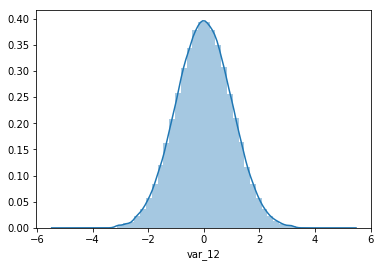

In [63]:
sns.distplot(X1['var_12'])

In [67]:
# var_12 9559 (yes)
# var_68 459 (no)
# var_91 7959 (yes)
# var_103 9376 (no)
# var_108 8524 (no)

bins = np.linspace(-6.0,6.0,40)
X = pd.get_dummies(pd.cut(X1['var_12'].values, bins))

model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
col = 'var_12'
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.563783	valid_1's auc: 0.562899
Early stopping, best iteration is:
[793]	training's auc: 0.56358	valid_1's auc: 0.562954
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.561006	valid_1's auc: 0.563367
Early stopping, best iteration is:
[924]	training's auc: 0.560917	valid_1's auc: 0.563415


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=999999, n_jobs=-1, num_leaves=2,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

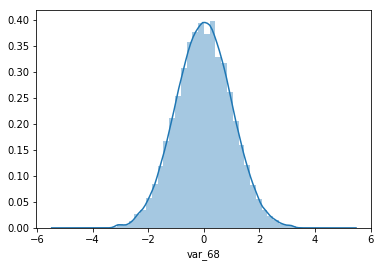

In [68]:
sns.distplot(X1['var_68'])

In [75]:
# var_12 9559
# var_68 459 (no)
# var_91 7959 (yes)
# var_103 9376 (no)
# var_108 8524 (no)
bins = np.linspace(-6.0,6.0,50)
X = pd.get_dummies(pd.cut(X1['var_68'].values, bins))

model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
col = 'var_68'
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.517942	valid_1's auc: 0.505162
Early stopping, best iteration is:
[24]	training's auc: 0.509768	valid_1's auc: 0.508296
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.515845	valid_1's auc: 0.505296
Early stopping, best iteration is:
[12]	training's auc: 0.509246	valid_1's auc: 0.507739


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=999999, n_jobs=-1, num_leaves=2,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

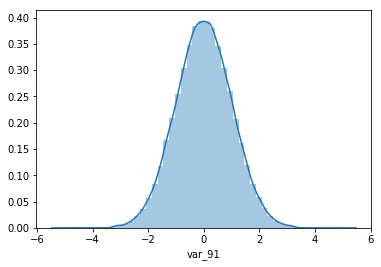

In [76]:
sns.distplot(X1['var_91'])

In [79]:
# var_12 9559
# var_68 459
# var_91 7959 (yes)
# var_103 9376 (no)
# var_108 8524 (no)
bins = np.linspace(-6.0,6.0,50)
X = pd.get_dummies(pd.cut(X1['var_91'].values, bins))

model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
col = 'var_91'
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.539451	valid_1's auc: 0.534348
Early stopping, best iteration is:
[434]	training's auc: 0.537981	valid_1's auc: 0.535603
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.535931	valid_1's auc: 0.534446
[2000]	training's auc: 0.536851	valid_1's auc: 0.534873
Early stopping, best iteration is:
[1677]	training's auc: 0.536578	valid_1's auc: 0.536109


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=999999, n_jobs=-1, num_leaves=2,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [82]:
# var_12 9559
# var_68 459
# var_91 7959
# var_103 9376 (no)
# var_108 8524 (no)
bins = np.linspace(-6.0,6.0,30)
X = pd.get_dummies(pd.cut(X1['var_103'].values, bins))

model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
col = 'var_103'
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.512506	valid_1's auc: 0.506379
Early stopping, best iteration is:
[186]	training's auc: 0.509507	valid_1's auc: 0.507907
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.506929	valid_1's auc: 0.501271
Early stopping, best iteration is:
[236]	training's auc: 0.506269	valid_1's auc: 0.502114


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=999999, n_jobs=-1, num_leaves=2,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [85]:
# var_12 9559
# var_68 459
# var_91 7959
# var_103 9376
# var_108 8524 (no)
bins = np.linspace(-6.0,6.0,50)
X = pd.get_dummies(pd.cut(X1['var_108'].values, bins))

model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
col = 'var_108'
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)


Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.546544	valid_1's auc: 0.541101
[2000]	training's auc: 0.547374	valid_1's auc: 0.541089
[3000]	training's auc: 0.548477	valid_1's auc: 0.542933
[4000]	training's auc: 0.550013	valid_1's auc: 0.542877
Early stopping, best iteration is:
[3220]	training's auc: 0.548511	valid_1's auc: 0.543037
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.541797	valid_1's auc: 0.538098
[2000]	training's auc: 0.542078	valid_1's auc: 0.538022
Early stopping, best iteration is:
[1712]	training's auc: 0.542045	valid_1's auc: 0.538155


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=999999, n_jobs=-1, num_leaves=2,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [87]:
oof = np.load('../cache/oof_cat_top30_inter_1_10_1.npy')
preds = np.load('../cache/preds_cat_top30_inter_1_10_1.npy')

In [88]:
print(stage2.head())

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311


In [89]:
stage2['cat2'] = oof[0]
stage2_test['cat2'] = preds[0]
print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12d.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb      cat2
0  0.010545  0.010837  0.008313  0.012104
1  0.455996  0.423705  0.392034  0.495291
2  0.004485  0.003918  0.004919  0.006758
3  0.243523  0.253600  0.340744  0.283394
4  0.097492  0.088431  0.110311  0.069909
0.92538


In [220]:
X3 = X1.copy()
X4 = X2.copy()

bins = np.linspace(-6.0,6.0,40)
X3_12_bins = pd.get_dummies(pd.cut(X3['var_12'].values, bins))
X4_12_bins = pd.get_dummies(pd.cut(X4['var_12'].values, bins))

bins = np.linspace(-6.0,6.0,50)
X3_91_bins = pd.get_dummies(pd.cut(X3['var_91'].values, bins))
X4_91_bins = pd.get_dummies(pd.cut(X4['var_91'].values, bins))


In [221]:
X3_12_bins.shape, X3_91_bins.shape

((200000, 39), (200000, 49))

In [222]:
X3_12_bins = pd.DataFrame(X3_12_bins)
cols = ['var_12_' + str(i) for i in range(X3_12_bins.shape[1])]
X3_12_bins.columns = cols

X4_12_bins = pd.DataFrame(X4_12_bins)
X4_12_bins.columns = cols

In [223]:
X3_91_bins = pd.DataFrame(X3_91_bins)
cols = ['var_91_' + str(i) for i in range(X3_91_bins.shape[1])]
X3_91_bins.columns = cols

X4_91_bins = pd.DataFrame(X4_91_bins)
X4_91_bins.columns = cols

In [224]:
X3 = pd.concat([X3, X3_12_bins], axis=1)
X3 = pd.concat([X3, X3_91_bins], axis=1)

X4 = pd.concat([X4, X4_12_bins], axis=1)
X4 = pd.concat([X4, X4_91_bins], axis=1)

X3 = X3.drop(['var_12', 'var_91'], axis=1)
X4 = X4.drop(['var_12', 'var_91'], axis=1)

X3.shape, X4.shape

((200000, 286), (200000, 286))

In [97]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

Fold 0 started at Tue Mar  5 13:41:42 2019
0:	test: 0.5134372	best: 0.5134372 (0)	total: 54.9ms	remaining: 15h 14m 34s
1000:	test: 0.8531031	best: 0.8531315 (998)	total: 26.7s	remaining: 7h 23m 53s
2000:	test: 0.8707125	best: 0.8707125 (2000)	total: 55.2s	remaining: 7h 39m 3s
3000:	test: 0.8806626	best: 0.8806626 (3000)	total: 1m 21s	remaining: 7h 32m 52s
4000:	test: 0.8865557	best: 0.8865557 (4000)	total: 1m 47s	remaining: 7h 27m 37s
5000:	test: 0.8904276	best: 0.8904292 (4998)	total: 2m 14s	remaining: 7h 26m 19s
6000:	test: 0.8929733	best: 0.8929733 (6000)	total: 2m 43s	remaining: 7h 30m 45s
7000:	test: 0.8949140	best: 0.8949174 (6996)	total: 3m 10s	remaining: 7h 30m 21s
8000:	test: 0.8962513	best: 0.8962513 (8000)	total: 3m 36s	remaining: 7h 28m 5s
9000:	test: 0.8970759	best: 0.8970849 (8989)	total: 4m 4s	remaining: 7h 28m 34s
10000:	test: 0.8978386	best: 0.8978417 (9999)	total: 4m 33s	remaining: 7h 30m 56s
11000:	test: 0.8985648	best: 0.8985897 (10965)	total: 5m	remaining: 7h 29m 3

21000:	test: 0.9017826	best: 0.9018271 (20551)	total: 11m 15s	remaining: 8h 44m 30s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9018270792
bestIteration = 20551

Shrink model to first 20552 iterations.
Fold 4 started at Tue Mar  5 14:33:11 2019
0:	test: 0.5175121	best: 0.5175121 (0)	total: 47.4ms	remaining: 13h 10m 32s
1000:	test: 0.8529257	best: 0.8529257 (1000)	total: 31.3s	remaining: 8h 40m 46s
2000:	test: 0.8734117	best: 0.8734117 (2000)	total: 1m 2s	remaining: 8h 38m 17s
3000:	test: 0.8855334	best: 0.8855334 (3000)	total: 1m 33s	remaining: 8h 39m 33s
4000:	test: 0.8925587	best: 0.8925648 (3999)	total: 2m 6s	remaining: 8h 44m 19s
5000:	test: 0.8971872	best: 0.8971872 (5000)	total: 2m 37s	remaining: 8h 42m 41s
6000:	test: 0.9003432	best: 0.9003432 (6000)	total: 3m 10s	remaining: 8h 44m 32s
7000:	test: 0.9024043	best: 0.9024043 (7000)	total: 3m 42s	remaining: 8h 46m 41s
8000:	test: 0.9039765	best: 0.9039861 (7995)	total: 4m 13s	remaining: 8h 44m 42s
9000:	te

14000:	test: 0.8935601	best: 0.8935723 (13961)	total: 7m 32s	remaining: 8h 51m 1s
15000:	test: 0.8938397	best: 0.8938397 (15000)	total: 8m 4s	remaining: 8h 50m 42s
16000:	test: 0.8940916	best: 0.8941010 (15984)	total: 8m 37s	remaining: 8h 50m 11s
17000:	test: 0.8942629	best: 0.8942745 (16959)	total: 9m 9s	remaining: 8h 49m 52s
18000:	test: 0.8944891	best: 0.8944904 (17993)	total: 9m 43s	remaining: 8h 50m 13s
19000:	test: 0.8946104	best: 0.8946115 (18990)	total: 10m 16s	remaining: 8h 50m 10s
20000:	test: 0.8946624	best: 0.8946661 (19968)	total: 10m 48s	remaining: 8h 49m 44s
21000:	test: 0.8947203	best: 0.8947293 (20923)	total: 11m 20s	remaining: 8h 48m 59s
22000:	test: 0.8948299	best: 0.8948299 (22000)	total: 11m 53s	remaining: 8h 48m 31s
23000:	test: 0.8948745	best: 0.8948745 (23000)	total: 12m 26s	remaining: 8h 48m 34s
24000:	test: 0.8949810	best: 0.8949941 (23805)	total: 12m 57s	remaining: 8h 47m 15s
25000:	test: 0.8950051	best: 0.8950117 (24977)	total: 13m 29s	remaining: 8h 46m 9s
2

In [98]:
np.save('../cache/oof_cat_quant_bin_1_10_1', oof)
np.save('../cache/preds_cat_quant_bin_1_10_1', preds)

In [99]:
stage2['cat2'] = oof[0]
stage2_test['cat2'] = preds[0]
print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12e.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb      cat2
0  0.010545  0.010837  0.008313  0.011734
1  0.455996  0.423705  0.392034  0.468508
2  0.004485  0.003918  0.004919  0.004418
3  0.243523  0.253600  0.340744  0.263807
4  0.097492  0.088431  0.110311  0.092751
0.925455


In [102]:
stage22 = stage2.drop('cat2', axis=1)
stage22_test = stage2_test.drop('cat2', axis=1)
stage22['cat'] = oof[0]
stage22_test['cat'] = preds[0]
print(stage22.head())

lr = LogisticRegression()
lr.fit(stage22, y)
predictions = lr.predict_proba(stage22_test)[:, 1]

# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = predictions
# sub.to_csv('../submissions/sub12e.csv', index=False)
print(lr.score(stage22, y))

        cat       lgb       xgb
0  0.011734  0.010837  0.008313
1  0.468508  0.423705  0.392034
2  0.004418  0.003918  0.004919
3  0.263807  0.253600  0.340744
4  0.092751  0.088431  0.110311
0.925285


In [16]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
# clf = SVC(gamma='auto')
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=51, stratify=y)

n_estimators=20
clf = OneVsRestClassifier(BaggingClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
# clf = OneVsRestClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), n_jobs=-1)
clf.fit(X_train,y_train)

y_pred_valid = clf.predict_proba(X_valid)[:,1].reshape(-1,1)
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

0.8806457913323875


In [14]:
y_pred_valid = clf.predict_proba(X_valid)[:,1].reshape(-1,) # without stratify=y
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

0.879372989152224


In [13]:
y_pred_valid.shape

(80000,)

In [15]:
model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)

np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
y_pred_valid = model.predict_proba(X_valid)[:,1].reshape(-1,1)
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.829992	valid_1's auc: 0.824131
[2000]	training's auc: 0.860055	valid_1's auc: 0.854852
[3000]	training's auc: 0.874626	valid_1's auc: 0.868969
[4000]	training's auc: 0.8835	valid_1's auc: 0.87717
[5000]	training's auc: 0.88936	valid_1's auc: 0.88251
[6000]	training's auc: 0.893626	valid_1's auc: 0.886321
[7000]	training's auc: 0.896871	valid_1's auc: 0.889163
[8000]	training's auc: 0.899431	valid_1's auc: 0.891409
[9000]	training's auc: 0.901506	valid_1's auc: 0.893196
[10000]	training's auc: 0.903209	valid_1's auc: 0.894601
[11000]	training's auc: 0.904574	valid_1's auc: 0.895745
[12000]	training's auc: 0.905747	valid_1's auc: 0.896644
[13000]	training's auc: 0.906739	valid_1's auc: 0.897375
[14000]	training's auc: 0.907591	valid_1's auc: 0.897987
[15000]	training's auc: 0.908306	valid_1's auc: 0.898482
[16000]	training's auc: 0.908943	valid_1's auc: 0.898863
[17000]	training's auc: 0.909501	valid

In [17]:
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

n_estimators=20
clf = OneVsRestClassifier(BaggingClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
# clf = OneVsRestClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), n_jobs=-1)
clf.fit(X_train,y_train)

y_pred_valid = clf.predict_proba(X_valid)[:,1].reshape(-1,1)
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

0.8784370877684948


In [18]:
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

n_estimators=20
clf = OneVsRestClassifier(BaggingClassifier(SVC(gamma='auto', probability=True, class_weight='balanced', C=0.01), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
# clf = OneVsRestClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), n_jobs=-1)
clf.fit(X_train,y_train)

y_pred_valid = clf.predict_proba(X_valid)[:,1].reshape(-1,1)
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

0.8786467122420141


In [20]:
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

n_estimators=20
clf = OneVsRestClassifier(BaggingClassifier(SVC(gamma='scale', probability=True, class_weight='balanced', C=0.01), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
# clf = OneVsRestClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), n_jobs=-1)
clf.fit(X_train,y_train)

y_pred_valid = clf.predict_proba(X_valid)[:,1].reshape(-1,1)
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

0.8787070138468303


In [88]:
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

n_estimators=20
clf = OneVsRestClassifier(BaggingClassifier(SVC(gamma='scale', probability=True, C=0.001), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
# clf = OneVsRestClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), n_jobs=-1)
clf.fit(X_train,y_train)

y_pred_valid = clf.predict_proba(X_valid)[:,1].reshape(-1,1)
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

0.875586865561022


In [90]:
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

n_estimators=20
clf = OneVsRestClassifier(BaggingClassifier(SVC(kernel='poly', gamma='scale', probability=True, class_weight='balanced', C=0.01), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
# clf = OneVsRestClassifier(SVC(gamma='auto', probability=True, class_weight='balanced'), n_jobs=-1)
clf.fit(X_train,y_train)

y_pred_valid = clf.predict_proba(X_valid)[:,1].reshape(-1,1)
score = roc_auc_score(y_valid, y_pred_valid)
print(score)

0.8610643074234167


In [56]:
from ipywidgets import IntSlider
IntSlider()

IntSlider(value=0)

In [58]:
!jupyter nbextension enable --py widgetsnbextension 

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [60]:
X3 = X1.copy()
X4 = X2.copy()

cols = list(X3.columns)
for col in tqdm(cols):
    pc = len(X3.loc[X3[col] >= 0])
    nc = len(X3.loc[X3[col] < 0])
    X3[col+'_pnc'] = X3[col].map(lambda x: pc if x >= 0 else nc)
    
    pc = len(X4.loc[X4[col] >= 0])
    nc = len(X4.loc[X4[col] < 0])
    X4[col+'_pnc'] = X4[col].map(lambda x: pc if x >= 0 else nc)

100%|██████████| 200/200 [02:43<00:00,  1.23it/s]


In [61]:
X3.shape

(200000, 400)

In [62]:
X3.head()

var_0     var_1     var_2     var_3     var_4     var_5     var_6  \
0 -0.508872 -1.224011  0.424961 -0.744061  0.197456 -0.462353 -0.275825   
1  0.297270 -0.544298  1.172628 -0.607792  0.734201  1.614287  0.241267   
2 -0.618451 -0.245573  0.480749  0.467453 -0.293870 -0.441126  1.677984   
3  0.164890 -0.117078 -0.585200  0.157349  0.872216  0.329188  0.487350   
4 -0.211808  0.026459  0.810557 -0.078550  0.678320  0.903906  0.600080   

      var_7     var_8     var_9    var_10    var_11    var_12    var_13  \
0  0.547453 -1.537319 -1.430491  0.417258  1.061130 -0.053554 -1.701265   
1  0.018579  0.744474  0.318751 -0.147742  1.855147 -0.005018 -0.040022   
2 -0.475440 -1.536994 -1.234482 -0.134566 -1.334812  0.833189 -0.248027   
3 -0.389125 -1.921131  0.419160  0.307435  0.999677 -0.931003  0.608538   
4  0.718477  2.080059  0.039485 -1.810503 -1.500196 -0.921100 -0.142960   

     var_14    var_15    var_16    var_17    var_18    var_19    var_20  \
0  0.478528 -0.009846 -1.439048 -0.218093 -1.389731  2.437745 -0.376164   
1 -0.830584 -2.378103  1.654614 -1.448337 -0.855770  2.067098 -1.780175   
2  0.000127  0.161770 -0.584461  0.539358 -1.319420  0.939151  0.653720   
3 -0.396133  0.586940  0.526417  0.733822  0.080706  0.135256  1.101799   
4  0.095549  1.129267 -0.273694  0.354230 -1.035619 -0.124821  1.322313   

     var_21    var_22    var_23    var_24    var_25    var_26    var_27  \
0 -0.120907 -0.539969 -0.996270  0.896423 -0.758004 -0.152229  0.405968   
1 -1.735751  1.471335  0.618493 -0.857791  0.770085 -1.304933 -0.839379   
2  0.104864 -1.038240  0.873865 -1.300904 -1.643380 -0.618555 -1.077166   
3 -0.553052  0.859466 -0.507061  0.364480  0.239023  0.826839  0.119632   
4  0.197623  1.947101 -0.522810  0.848551 -0.373927  1.215579 -1.423534   

     var_28    var_29    var_30    var_31    var_32    var_33    var_34  \
0 -0.756842  0.371556  0.832625  1.126437 -1.228115  0.436273 -0.391536   
1 -0.612092 -1.839963 -0.192078 -1.131588  0.606855  0.952798 -0.102877   
2  0.368799  0.425365 -0.376045  0.943547 -0.592219  0.877742 -0.648724   
3  0.441525 -0.805016 -0.845457  0.034382 -0.695561 -2.189135 -1.516525   
4  0.434855  1.102985  0.462110 -0.407015  0.161091  0.942374  1.897077   

     var_35    var_36    var_37    var_38    var_39    var_40    var_41  \
0  1.275088 -0.471711  0.837338 -1.378347  0.734911  0.156171 -0.262772   
1 -0.560898  0.177043 -0.018274  0.060267  0.687294 -0.477138 -1.199335   
2  0.039195  0.753857  0.404276  0.076792  0.054415 -0.751531 -1.116606   
3 -1.932500  2.026980 -1.287160 -0.310039  0.001734  0.321017 -1.985113   
4 -0.580938  0.174982 -0.027314  2.016599  0.174612  0.113982  0.726296   

     var_42    var_43    var_44    var_45    var_46    var_47    var_48  \
0  0.432555  1.536329  0.402899  0.215349 -1.998225 -0.133493  0.117516   
1 -1.918378  0.613762 -1.230809 -1.634408 -1.377250  1.120979  1.726299   
2  0.369634  1.518869 -0.847484  0.180038 -0.055466  0.539323  0.489698   
3  0.710987 -0.887689 -0.238625 -0.505049  0.476698 -2.490257 -1.183433   
4  0.930890 -0.156744 -0.428221 -2.952938  0.865036  1.104484 -1.272008   

     var_49    var_50    var_51    var_52    var_53    var_54    var_55  \
0 -1.445268  0.235074  1.924706  0.345646 -1.018154 -0.198386  0.321070   
1  1.098832 -1.281720 -0.022211 -0.302553  0.880001 -1.017145  0.943759   
2 -1.186818  0.227993  0.699977  0.627710  0.484729  0.901436 -1.051980   
3 -0.966592 -0.084303 -0.416061  0.833559 -0.966700  0.755139 -0.032799   
4 -0.248106  0.807656 -0.315787  0.199608 -0.301347 -1.073173  0.221583   

     var_56    var_57    var_58    var_59    var_60    var_61    var_62  \
0 -1.503508 -1.077196 -0.256230  1.325150  0.924402  1.472348  0.605144   
1  0.684960  0.878579 -0.278480 -0.035784 -0.914147  0.346486  0.471670   
2 -0.253840 -0.510835 -0.464773  0.288369  0.099469  0.109420  0.040736   
3 -0.570372  0.374488  0.032898  0.566703  0.829222 -1.037884  1.242952   
4  0.084137 -0.088323 -

In [66]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

In [67]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

Fold 0 started at Wed Mar  6 13:34:37 2019
0:	test: 0.5340388	best: 0.5340388 (0)	total: 118ms	remaining: 1d 8h 39m 21s
1000:	test: 0.8524085	best: 0.8524085 (1000)	total: 28.4s	remaining: 7h 52m 4s
2000:	test: 0.8711751	best: 0.8711751 (2000)	total: 59.7s	remaining: 8h 16m 12s
3000:	test: 0.8817056	best: 0.8817056 (3000)	total: 1m 28s	remaining: 8h 10m 11s
4000:	test: 0.8877080	best: 0.8877080 (4000)	total: 1m 57s	remaining: 8h 7m 58s
5000:	test: 0.8914568	best: 0.8914568 (5000)	total: 2m 27s	remaining: 8h 7m 36s
6000:	test: 0.8938049	best: 0.8938078 (5999)	total: 2m 56s	remaining: 8h 7m 5s
7000:	test: 0.8955610	best: 0.8955674 (6997)	total: 3m 24s	remaining: 8h 4m 12s
8000:	test: 0.8970216	best: 0.8970245 (7999)	total: 3m 52s	remaining: 8h 1m 17s
9000:	test: 0.8979392	best: 0.8979392 (9000)	total: 4m 20s	remaining: 7h 58m 52s
10000:	test: 0.8986429	best: 0.8986530 (9992)	total: 4m 49s	remaining: 7h 57m 4s
11000:	test: 0.8991063	best: 0.8991148 (10983)	total: 5m 18s	remaining: 7h 56m 

7000:	test: 0.9034742	best: 0.9034765 (6997)	total: 4m 5s	remaining: 9h 40m 48s
8000:	test: 0.9049099	best: 0.9049099 (8000)	total: 4m 41s	remaining: 9h 41m 3s
9000:	test: 0.9058854	best: 0.9058901 (8994)	total: 5m 16s	remaining: 9h 39m 55s
10000:	test: 0.9067599	best: 0.9067599 (10000)	total: 5m 51s	remaining: 9h 39m 50s
11000:	test: 0.9073394	best: 0.9073394 (11000)	total: 6m 25s	remaining: 9h 37m 50s
12000:	test: 0.9077551	best: 0.9077642 (11969)	total: 7m	remaining: 9h 36m 52s
13000:	test: 0.9081031	best: 0.9081074 (12997)	total: 7m 35s	remaining: 9h 36m 30s
14000:	test: 0.9083382	best: 0.9083397 (13990)	total: 8m 10s	remaining: 9h 36m 11s
15000:	test: 0.9085270	best: 0.9085299 (14962)	total: 8m 46s	remaining: 9h 35m 58s
16000:	test: 0.9087176	best: 0.9087178 (15991)	total: 9m 21s	remaining: 9h 35m 33s
17000:	test: 0.9088208	best: 0.9088378 (16901)	total: 9m 56s	remaining: 9h 35m 10s
18000:	test: 0.9089504	best: 0.9089511 (17884)	total: 10m 31s	remaining: 9h 34m 30s
19000:	test: 0.

6000:	test: 0.8882843	best: 0.8882862 (5995)	total: 3m 37s	remaining: 10h 51s
7000:	test: 0.8904369	best: 0.8904369 (7000)	total: 4m 14s	remaining: 10h 28s
8000:	test: 0.8921197	best: 0.8921237 (7996)	total: 4m 51s	remaining: 10h 2m 41s
9000:	test: 0.8932533	best: 0.8932533 (9000)	total: 5m 29s	remaining: 10h 4m 30s
10000:	test: 0.8941915	best: 0.8941915 (10000)	total: 6m 9s	remaining: 10h 9m 30s
11000:	test: 0.8947179	best: 0.8947179 (11000)	total: 6m 47s	remaining: 10h 10m 22s
12000:	test: 0.8952858	best: 0.8952858 (12000)	total: 7m 25s	remaining: 10h 10m 46s
13000:	test: 0.8957308	best: 0.8957319 (12999)	total: 8m 2s	remaining: 10h 9m 52s
14000:	test: 0.8960639	best: 0.8960656 (13986)	total: 8m 40s	remaining: 10h 10m 30s
15000:	test: 0.8963648	best: 0.8963709 (14997)	total: 9m 20s	remaining: 10h 13m 23s
16000:	test: 0.8964858	best: 0.8964858 (16000)	total: 9m 57s	remaining: 10h 12m 43s
17000:	test: 0.8966433	best: 0.8966465 (16793)	total: 10m 34s	remaining: 10h 10m 59s
18000:	test: 

In [69]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = predictions
# sub.to_csv('../submissions/sub12c.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.925455


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())

lr = OneVsRestClassifier(BaggingClassifier(SVC(gamma='auto', probability=True, class_weight='balanced', C=0.001), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12f.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.857165


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())

lr = OneVsRestClassifier(BaggingClassifier(SVC(kernel='poly',gamma='auto', probability=True, class_weight='balanced'), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
lr.fit(stage2, y)
# predictions = lr.predict_proba(stage2_test)[:, 1]

# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = predictions
# sub.to_csv('../submissions/sub12c.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.9227


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())

lr = OneVsRestClassifier(BaggingClassifier(SVC(kernel='poly',gamma='auto', probability=True, class_weight='balanced', C=0.001), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
lr.fit(stage2, y)
# predictions = lr.predict_proba(stage2_test)[:, 1]

# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = predictions
# sub.to_csv('../submissions/sub12c.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.9126


In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())

lr = OneVsRestClassifier(BaggingClassifier(SVC(kernel='poly',gamma='auto', probability=True, class_weight='balanced', C=10.0), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
lr.fit(stage2, y)
# predictions = lr.predict_proba(stage2_test)[:, 1]

# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = predictions
# sub.to_csv('../submissions/sub12c.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.919625


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())

lr = OneVsRestClassifier(BaggingClassifier(SVC(kernel='poly',gamma='scale', probability=True, class_weight='balanced'), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
lr.fit(stage2, y)
# predictions = lr.predict_proba(stage2_test)[:, 1]

# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = predictions
# sub.to_csv('../submissions/sub12c.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.9193


In [333]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())
n_estimators = 20
lr = OneVsRestClassifier(BaggingClassifier(SVC(kernel='linear',gamma='scale', probability=True, class_weight='balanced'), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
lr.fit(stage2, y)
# predictions = lr.predict_proba(stage2_test)[:, 1]

# sub = pd.read_csv('../data/sample_submission.csv.zip')
# sub['target'] = predictions
# sub.to_csv('../submissions/sub12c.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.87875


In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]
print(stage2.head())

lr = RandomForestClassifier(n_estimators=500,n_jobs=-1)
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12f.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
1.0


In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]

# stage2['cat2'] = oof_cat
# stage2_test['cat2'] = prediction_cat

print(stage2.head())


lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
# sub.to_csv('../submissions/sub12g.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb
0  0.010545  0.010837  0.008313
1  0.455996  0.423705  0.392034
2  0.004485  0.003918  0.004919
3  0.243523  0.253600  0.340744
4  0.097492  0.088431  0.110311
0.925455


In [162]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_val, y_train, y_val = train_test_split(X1, y, test_size = 0.2, random_state=42)
model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
            
model.fit(X_train, y_train, 
    eval_set=[(X_val, y_val
    verbose=1000, 
    early_stopping_rounds=1000)
base_features = list(X1.columns)
# perm = PermutationImportance(model, random_state=1).fit(X_val, y_val)
eli5.show_weights(model, feature_names = base_features)

Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.826045
[2000]	valid_0's auc: 0.853949
[3000]	valid_0's auc: 0.867037
[4000]	valid_0's auc: 0.874934
[5000]	valid_0's auc: 0.88029
[6000]	valid_0's auc: 0.884068
[7000]	valid_0's auc: 0.886903
[8000]	valid_0's auc: 0.889136
[9000]	valid_0's auc: 0.890871
[10000]	valid_0's auc: 0.892171
[11000]	valid_0's auc: 0.893202
[12000]	valid_0's auc: 0.894073
[13000]	valid_0's auc: 0.89481
[14000]	valid_0's auc: 0.895409
[15000]	valid_0's auc: 0.895924
[16000]	valid_0's auc: 0.896362
[17000]	valid_0's auc: 0.896711
[18000]	valid_0's auc: 0.896999
[19000]	valid_0's auc: 0.89729
[20000]	valid_0's auc: 0.897507
[21000]	valid_0's auc: 0.897715
[22000]	valid_0's auc: 0.897883
[23000]	valid_0's auc: 0.898022
[24000]	valid_0's auc: 0.898173
[25000]	valid_0's auc: 0.898285
[26000]	valid_0's auc: 0.898394
[27000]	valid_0's auc: 0.898471
[28000]	valid_0's auc: 0.898569
[29000]	valid_0's auc: 0.898655
[30000]	valid_0's au

In [163]:
from eli5 import show_prediction
# ?? show_prediction
eli5.show_prediction(model, X_val.iloc[1], targets=[0, 1], feature_names=list(X_train.columns))
# eli5.show_prediction(model, X_val, feature_names = base_features, show_feature_values=True)

In [164]:
df = eli5.formatters.as_dataframe.explain_prediction_df(model, X_val.iloc[1])

In [165]:
df.head()

target  feature    weight     value
0       0   <BIAS>  3.263848  1.000000
1       0   var_34  0.194992  2.237072
2       0   var_21  0.160823  2.816402
3       0    var_6  0.157545 -1.121865
4       0  var_192  0.149123  1.838830

In [166]:
df_neg = df.loc[df.weight < 0]

In [167]:
len(df_neg)

84

In [168]:
df_neg.head()

target  feature    weight     value
117       0  var_100 -0.000056 -2.463950
118       0   var_30 -0.000136  0.087428
119       0  var_158 -0.000250  1.797573
120       0   var_39 -0.000461 -1.260696
121       0   var_61 -0.000635 -0.112805

In [169]:
df_pos = df.loc[df.weight > 0]

In [170]:
df_pos.head()

target  feature    weight     value
0       0   <BIAS>  3.263848  1.000000
1       0   var_34  0.194992  2.237072
2       0   var_21  0.160823  2.816402
3       0    var_6  0.157545 -1.121865
4       0  var_192  0.149123  1.838830

In [171]:
len(df_pos)

117

In [173]:
df.loc[df.feature == 'var_100']

target  feature    weight    value
117       0  var_100 -0.000056 -2.46395

In [174]:
X3 = X1.copy()
for idx, row in df_neg.iterrows():
#     print(row)
    target = row['target']
    feature = row['feature']
    value = row['value']
    X3.loc[(X3[feature] == value)] = 0

In [175]:
# X3 = X1.copy()
# for idx, row in df_neg.iterrows():
# #     print(row)
#     target = row['target']
#     feature = row['feature']
#     value = row['value']
#     X3.loc[(X3[feature] == value)] = 0

In [176]:
np.random.seed(123)
X_train, X_val, y_train, y_val = train_test_split(X3, y, test_size=0.2, stratify=y)


model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
            
model.fit(X_train, y_train, 
    eval_set=[(X_val, y_val)],
    verbose=1000, 
    early_stopping_rounds=1000)

# after first time changing negatives to zeros
# Early stopping, best iteration is:
# [31882]	valid_0's auc: 0.899293

Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.822715
[2000]	valid_0's auc: 0.853177
[3000]	valid_0's auc: 0.867385
[4000]	valid_0's auc: 0.87541
[5000]	valid_0's auc: 0.880898
[6000]	valid_0's auc: 0.884749
[7000]	valid_0's auc: 0.88763
[8000]	valid_0's auc: 0.889902
[9000]	valid_0's auc: 0.891642
[10000]	valid_0's auc: 0.893106
[11000]	valid_0's auc: 0.894196
[12000]	valid_0's auc: 0.895119
[13000]	valid_0's auc: 0.895819
[14000]	valid_0's auc: 0.896432
[15000]	valid_0's auc: 0.896941
[16000]	valid_0's auc: 0.897332
[17000]	valid_0's auc: 0.897702
[18000]	valid_0's auc: 0.897999
[19000]	valid_0's auc: 0.898264
[20000]	valid_0's auc: 0.898461
[21000]	valid_0's auc: 0.89862
[22000]	valid_0's auc: 0.898772
[23000]	valid_0's auc: 0.898882
[24000]	valid_0's auc: 0.898991
[25000]	valid_0's auc: 0.899075
[26000]	valid_0's auc: 0.899132
[27000]	valid_0's auc: 0.899175
[28000]	valid_0's auc: 0.899216
[29000]	valid_0's auc: 0.899237
[30000]	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
        importance_type='split', learning_rate=0.02, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=999999, n_jobs=-1, num_leaves=2,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [177]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X2, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Wed Mar  6 21:28:52 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.82432
[2000]	valid_0's auc: 0.853677
[3000]	valid_0's auc: 0.867463
[4000]	valid_0's auc: 0.875517
[5000]	valid_0's auc: 0.880662
[6000]	valid_0's auc: 0.884318
[7000]	valid_0's auc: 0.887061
[8000]	valid_0's auc: 0.889053
[9000]	valid_0's auc: 0.890727
[10000]	valid_0's auc: 0.89209
[11000]	valid_0's auc: 0.893171
[12000]	valid_0's auc: 0.894003
[13000]	valid_0's auc: 0.894702
[14000]	valid_0's auc: 0.895284
[15000]	valid_0's auc: 0.895831
[16000]	valid_0's auc: 0.896253
[17000]	valid_0's auc: 0.896644
[18000]	valid_0's auc: 0.896942
[19000]	valid_0's auc: 0.897229
[20000]	valid_0's auc: 0.897439
[21000]	valid_0's auc: 0.897634
[22000]	valid_0's auc: 0.897808
[23000]	valid_0's auc: 0.897964
[24000]	valid_0's auc: 0.898118
[25000]	valid_0's auc: 0.898232
[26000]	valid_0's auc: 0.898351
[27000]	valid_0's auc: 0.89845
[28000]	valid_0's auc: 0.89851
[29000]	va

[21000]	valid_0's auc: 0.900557
[22000]	valid_0's auc: 0.900728
[23000]	valid_0's auc: 0.900902
[24000]	valid_0's auc: 0.90101
[25000]	valid_0's auc: 0.901128
[26000]	valid_0's auc: 0.901215
[27000]	valid_0's auc: 0.901301
[28000]	valid_0's auc: 0.901358
[29000]	valid_0's auc: 0.901427
[30000]	valid_0's auc: 0.901493
[31000]	valid_0's auc: 0.901541
[32000]	valid_0's auc: 0.901607
[33000]	valid_0's auc: 0.901664
[34000]	valid_0's auc: 0.901703
[35000]	valid_0's auc: 0.901732
[36000]	valid_0's auc: 0.901759
[37000]	valid_0's auc: 0.901768
[38000]	valid_0's auc: 0.901796
Early stopping, best iteration is:
[37811]	valid_0's auc: 0.901807
Fold 6 started at Wed Mar  6 23:53:26 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.821597
[2000]	valid_0's auc: 0.851761
[3000]	valid_0's auc: 0.866603
[4000]	valid_0's auc: 0.875606
[5000]	valid_0's auc: 0.881461
[6000]	valid_0's auc: 0.885577
[7000]	valid_0's auc: 0.888611
[8000]	valid_0's auc: 0.891203
[90

In [179]:
np.save('../cache/oof_lgb_eli5_showp_1_10_1', oof)
np.save('../cache/preds_lgb_eli5_showp_1_10_1', preds)

In [181]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]

oof_cat2 = np.load('../cache/oof_cat_quant_bin_1_10_1.npy')
preds_cat2= np.load('../cache/preds_cat_quant_bin_1_10_1.npy')
stage2['cat2'] = oof_cat2[0]
stage2_test['cat2'] = preds_cat2[0]

stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12h.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb      cat2      lgb2
0  0.010545  0.010837  0.008313  0.011734  0.010545
1  0.455996  0.423705  0.392034  0.468508  0.455996
2  0.004485  0.003918  0.004919  0.004418  0.004485
3  0.243523  0.253600  0.340744  0.263807  0.243523
4  0.097492  0.088431  0.110311  0.092751  0.097492
0.92555


In [182]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from eli5 import show_prediction
np.random.seed(123)
X_train, X_val, y_train, y_val = train_test_split(X1, y, test_size = 0.2, random_state=42)
model = lgb.LGBMClassifier(
                 max_depth=-1,
                 n_estimators=999999,
                 learning_rate=0.02,
                 colsample_bytree=0.3,
                 num_leaves=2,
                 metric='auc',
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
            
model.fit(X_train, y_train, 
    eval_set=[(X_val, y_val)],
    verbose=1000, 
    early_stopping_rounds=1000)
base_features = list(X1.columns)
# perm = PermutationImportance(model, random_state=1).fit(X_val, y_val)
# ?? show_prediction
eli5.show_prediction(model, X_val.iloc[1], targets=[0, 1], feature_names=list(X_train.columns))
df = eli5.formatters.as_dataframe.explain_prediction_df(model, X_val.iloc[1])
df_neg = df.loc[df.weight < 0]
X3 = X1.copy()
for idx, row in df_neg.iterrows():
    target = row['target']
    feature = row['feature']
    value = row['value']
    X3[feature] = X3[feature] - value

Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.826045
[2000]	valid_0's auc: 0.853949
[3000]	valid_0's auc: 0.867037
[4000]	valid_0's auc: 0.874934
[5000]	valid_0's auc: 0.88029
[6000]	valid_0's auc: 0.884068
[7000]	valid_0's auc: 0.886903
[8000]	valid_0's auc: 0.889136
[9000]	valid_0's auc: 0.890871
[10000]	valid_0's auc: 0.892171
[11000]	valid_0's auc: 0.893202
[12000]	valid_0's auc: 0.894073
[13000]	valid_0's auc: 0.89481
[14000]	valid_0's auc: 0.895409
[15000]	valid_0's auc: 0.895924
[16000]	valid_0's auc: 0.896362
[17000]	valid_0's auc: 0.896711
[18000]	valid_0's auc: 0.896999
[19000]	valid_0's auc: 0.89729
[20000]	valid_0's auc: 0.897507
[21000]	valid_0's auc: 0.897715
[22000]	valid_0's auc: 0.897883
[23000]	valid_0's auc: 0.898022
[24000]	valid_0's auc: 0.898173
[25000]	valid_0's auc: 0.898285
[26000]	valid_0's auc: 0.898394
[27000]	valid_0's auc: 0.898471
[28000]	valid_0's auc: 0.898569
[29000]	valid_0's auc: 0.898655
[30000]	valid_0's au

In [183]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X2, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Thu Mar  7 07:48:00 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.826999
[2000]	valid_0's auc: 0.855674
[3000]	valid_0's auc: 0.869226
[4000]	valid_0's auc: 0.87721
[5000]	valid_0's auc: 0.882488
[6000]	valid_0's auc: 0.885973
[7000]	valid_0's auc: 0.888545
[8000]	valid_0's auc: 0.890578
[9000]	valid_0's auc: 0.892228
[10000]	valid_0's auc: 0.893563
[11000]	valid_0's auc: 0.894568
[12000]	valid_0's auc: 0.895473
[13000]	valid_0's auc: 0.896164
[14000]	valid_0's auc: 0.896733
[15000]	valid_0's auc: 0.89721
[16000]	valid_0's auc: 0.897651
[17000]	valid_0's auc: 0.898011
[18000]	valid_0's auc: 0.898322
[19000]	valid_0's auc: 0.898555
[20000]	valid_0's auc: 0.898778
[21000]	valid_0's auc: 0.898947
[22000]	valid_0's auc: 0.899069
[23000]	valid_0's auc: 0.899207
[24000]	valid_0's auc: 0.899319
[25000]	valid_0's auc: 0.899433
[26000]	valid_0's auc: 0.899535
[27000]	valid_0's auc: 0.89959
[28000]	valid_0's auc: 0.89968
[29000]	va

Early stopping, best iteration is:
[35833]	valid_0's auc: 0.902945
Fold 6 started at Thu Mar  7 10:17:43 2019
Training until validation scores don't improve for 1000 rounds.
[1000]	valid_0's auc: 0.822454
[2000]	valid_0's auc: 0.852226
[3000]	valid_0's auc: 0.866618
[4000]	valid_0's auc: 0.875635
[5000]	valid_0's auc: 0.881388
[6000]	valid_0's auc: 0.885595
[7000]	valid_0's auc: 0.888777
[8000]	valid_0's auc: 0.891246
[9000]	valid_0's auc: 0.893245
[10000]	valid_0's auc: 0.894835
[11000]	valid_0's auc: 0.896104
[12000]	valid_0's auc: 0.897123
[13000]	valid_0's auc: 0.897863
[14000]	valid_0's auc: 0.89855
[15000]	valid_0's auc: 0.899155
[16000]	valid_0's auc: 0.899622
[17000]	valid_0's auc: 0.900078
[18000]	valid_0's auc: 0.900473
[19000]	valid_0's auc: 0.900826
[20000]	valid_0's auc: 0.901104
[21000]	valid_0's auc: 0.901346
[22000]	valid_0's auc: 0.901555
[23000]	valid_0's auc: 0.90174
[24000]	valid_0's auc: 0.901874
[25000]	valid_0's auc: 0.902004
[26000]	valid_0's auc: 0.902116
[2700

In [184]:
np.save('../cache/oof_lgb_eli5_showp_1_10_2', oof)
np.save('../cache/preds_lgb_eli5_showp_1_10_2', preds)

In [187]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]

oof_cat2 = np.load('../cache/oof_cat_quant_bin_1_10_1.npy')
preds_cat2= np.load('../cache/preds_cat_quant_bin_1_10_1.npy')
stage2['cat2'] = oof_cat2[0]
stage2_test['cat2'] = preds_cat2[0]

oof = np.load('../cache/oof_lgb_eli5_showp_1_10_2.npy')
preds = np.load('../cache/preds_lgb_eli5_showp_1_10_2.npy')


stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12i.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb      cat2      lgb2
0  0.010545  0.010837  0.008313  0.011734  0.010611
1  0.455996  0.423705  0.392034  0.468508  0.403720
2  0.004485  0.003918  0.004919  0.004418  0.003942
3  0.243523  0.253600  0.340744  0.263807  0.259469
4  0.097492  0.088431  0.110311  0.092751  0.085976
0.925445


In [190]:
oof = []
preds = []

n_estimators=20
clf = OneVsRestClassifier(BaggingClassifier(SVC(gamma='scale', probability=True, class_weight='balanced', C=0.01), 
                                            max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1), n_jobs=-1)
oof_svc, prediction_svc, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds,
                                         model_type='sklearn', plot_feature_importance=False, model=clf)
oof.append(oof_svc)
preds.append(prediction_svc)

Fold 0 started at Thu Mar  7 15:26:49 2019
Fold 1 started at Thu Mar  7 16:16:55 2019
Fold 2 started at Thu Mar  7 17:09:59 2019
Fold 3 started at Thu Mar  7 18:03:59 2019
Fold 4 started at Thu Mar  7 18:59:17 2019
Fold 5 started at Thu Mar  7 19:51:05 2019
Fold 6 started at Thu Mar  7 20:46:33 2019
Fold 7 started at Thu Mar  7 21:37:19 2019
Fold 8 started at Thu Mar  7 22:28:35 2019
Fold 9 started at Thu Mar  7 23:17:02 2019
CV mean score: 0.8794, std: 0.0044.


In [ ]:
np.save('../cache/oof_svm_1_10_1', oof)
np.save('../cache/preds_svm_1_10_1', preds)

In [191]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]

oof_cat2 = np.load('../cache/oof_cat_quant_bin_1_10_1.npy')
preds_cat2= np.load('../cache/preds_cat_quant_bin_1_10_1.npy')
stage2['cat2'] = oof_cat2[0]
stage2_test['cat2'] = preds_cat2[0]

stage2['svm'] = oof_svc
stage2_test['svm'] = prediction_svc

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12j.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb      cat2       svm
0  0.010545  0.010837  0.008313  0.011734  0.044733
1  0.455996  0.423705  0.392034  0.468508  0.267884
2  0.004485  0.003918  0.004919  0.004418  0.043137
3  0.243523  0.253600  0.340744  0.263807  0.226918
4  0.097492  0.088431  0.110311  0.092751  0.142101
0.92519


In [194]:
# var_12 9559 (yes)
# var_68 459 (no)
# var_91 7959 (yes)
# var_103 9376 (no)
# var_108 8524 (no)
oof = []
preds = []

for col in ['var_12', 'var_68', 'var_91', 'var_103', 'var_108']:
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))
    xcols = [col + str(i) for i in range(X.shape[1])]
    X.columns = xcols
    X3 = X1.copy()
    X4 = X2.copy()
    X3 = X3.drop(col, axis=1)
    X3 = pd.concat([X3, X], axis=1)
    X4 = X4.drop(col, axis=1)
    X4 = pd.concat([X4, X], axis=1)
    oof_cat, prediction_cat, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
    oof.append(oof_cat)
    preds.append(prediction_cat)
    print('--------------------------------------------------------')
    print('--------------------------------------------------------')

Fold 0 started at Fri Mar  8 00:30:08 2019
0:	test: 0.5418103	best: 0.5418103 (0)	total: 50.6ms	remaining: 14h 2m 57s
1000:	test: 0.8544302	best: 0.8544382 (999)	total: 28s	remaining: 7h 45m 9s
2000:	test: 0.8712567	best: 0.8712567 (2000)	total: 55.2s	remaining: 7h 39m 6s
3000:	test: 0.8815427	best: 0.8815427 (3000)	total: 1m 22s	remaining: 7h 37m 29s
4000:	test: 0.8873283	best: 0.8873283 (4000)	total: 1m 50s	remaining: 7h 38m 53s
5000:	test: 0.8910732	best: 0.8910732 (5000)	total: 2m 18s	remaining: 7h 40m 18s
6000:	test: 0.8936064	best: 0.8936064 (6000)	total: 2m 47s	remaining: 7h 41m 44s
7000:	test: 0.8955560	best: 0.8955560 (7000)	total: 3m 16s	remaining: 7h 44m 16s
8000:	test: 0.8967476	best: 0.8967551 (7996)	total: 3m 46s	remaining: 7h 48m 52s
9000:	test: 0.8977432	best: 0.8977508 (8987)	total: 4m 17s	remaining: 7h 52m 52s
10000:	test: 0.8985221	best: 0.8985221 (10000)	total: 4m 50s	remaining: 7h 59m 51s
11000:	test: 0.8991185	best: 0.8991204 (10995)	total: 5m 23s	remaining: 8h 5m

5000:	test: 0.8973603	best: 0.8973603 (5000)	total: 2m 39s	remaining: 8h 48m 14s
6000:	test: 0.9005813	best: 0.9005863 (5998)	total: 3m 12s	remaining: 8h 51m 6s
7000:	test: 0.9026904	best: 0.9026904 (7000)	total: 3m 44s	remaining: 8h 49m 51s
8000:	test: 0.9043908	best: 0.9043924 (7977)	total: 4m 16s	remaining: 8h 49m 55s
9000:	test: 0.9055808	best: 0.9055843 (8999)	total: 4m 49s	remaining: 8h 50m 40s
10000:	test: 0.9064250	best: 0.9064250 (10000)	total: 5m 20s	remaining: 8h 49m 1s
11000:	test: 0.9070500	best: 0.9070577 (10905)	total: 5m 53s	remaining: 8h 49m 36s
12000:	test: 0.9076150	best: 0.9076237 (11987)	total: 6m 26s	remaining: 8h 50m 44s
13000:	test: 0.9078750	best: 0.9078750 (13000)	total: 6m 58s	remaining: 8h 49m 55s
14000:	test: 0.9082084	best: 0.9082092 (13997)	total: 7m 31s	remaining: 8h 49m 58s
15000:	test: 0.9084851	best: 0.9084981 (14991)	total: 8m 7s	remaining: 8h 53m 48s
16000:	test: 0.9086814	best: 0.9086837 (15999)	total: 8m 40s	remaining: 8h 53m 39s
17000:	test: 0.90

0:	test: 0.5263554	best: 0.5263554 (0)	total: 54.9ms	remaining: 15h 14m 49s
1000:	test: 0.8447286	best: 0.8447981 (993)	total: 30.8s	remaining: 8h 32m 10s
2000:	test: 0.8615747	best: 0.8615747 (2000)	total: 1m 2s	remaining: 8h 38m 5s
3000:	test: 0.8731107	best: 0.8731107 (3000)	total: 1m 34s	remaining: 8h 44m 14s
4000:	test: 0.8798758	best: 0.8798758 (4000)	total: 2m 7s	remaining: 8h 50m 33s
5000:	test: 0.8842978	best: 0.8842978 (5000)	total: 2m 40s	remaining: 8h 53m 38s
6000:	test: 0.8874861	best: 0.8874955 (5994)	total: 3m 13s	remaining: 8h 54m 16s
7000:	test: 0.8900215	best: 0.8900215 (7000)	total: 3m 46s	remaining: 8h 54m 28s
8000:	test: 0.8915842	best: 0.8915856 (7999)	total: 4m 18s	remaining: 8h 54m 16s
9000:	test: 0.8926751	best: 0.8926758 (8998)	total: 4m 51s	remaining: 8h 54m 6s
10000:	test: 0.8936522	best: 0.8936553 (9986)	total: 5m 23s	remaining: 8h 53m 58s
11000:	test: 0.8944368	best: 0.8944393 (10999)	total: 5m 56s	remaining: 8h 53m 37s
12000:	test: 0.8949920	best: 0.89499

0:	test: 0.5081412	best: 0.5081412 (0)	total: 77.8ms	remaining: 21h 36m 36s
1000:	test: 0.8548432	best: 0.8548432 (1000)	total: 32.5s	remaining: 9h 1m 7s
2000:	test: 0.8727032	best: 0.8727211 (1996)	total: 1m 5s	remaining: 9h 4m 43s
3000:	test: 0.8827831	best: 0.8827831 (3000)	total: 1m 38s	remaining: 9h 7m 41s
4000:	test: 0.8881703	best: 0.8881724 (3999)	total: 2m 12s	remaining: 9h 8m 7s
5000:	test: 0.8915078	best: 0.8915168 (4998)	total: 2m 45s	remaining: 9h 10m 4s
6000:	test: 0.8938717	best: 0.8938717 (6000)	total: 3m 18s	remaining: 9h 8m 26s
7000:	test: 0.8953224	best: 0.8953237 (6994)	total: 3m 52s	remaining: 9h 9m 15s
8000:	test: 0.8963059	best: 0.8963059 (8000)	total: 4m 25s	remaining: 9h 8m 46s
9000:	test: 0.8970360	best: 0.8970402 (8986)	total: 4m 59s	remaining: 9h 9m 44s
10000:	test: 0.8976319	best: 0.8976388 (9993)	total: 5m 32s	remaining: 9h 7m 53s
11000:	test: 0.8981039	best: 0.8981049 (10992)	total: 6m 6s	remaining: 9h 8m 24s
12000:	test: 0.8983533	best: 0.8983549 (11978)

Fold 6 started at Fri Mar  8 03:58:34 2019
0:	test: 0.5100487	best: 0.5100487 (0)	total: 41.8ms	remaining: 11h 36m 46s
1000:	test: 0.8509598	best: 0.8509834 (999)	total: 30.2s	remaining: 8h 22m 57s
2000:	test: 0.8711211	best: 0.8711211 (2000)	total: 1m 1s	remaining: 8h 29m 48s
3000:	test: 0.8825437	best: 0.8825437 (3000)	total: 1m 34s	remaining: 8h 42m 12s
4000:	test: 0.8890869	best: 0.8891040 (3998)	total: 2m 8s	remaining: 8h 51m 32s
5000:	test: 0.8933340	best: 0.8933351 (4998)	total: 2m 41s	remaining: 8h 55m 5s
6000:	test: 0.8963549	best: 0.8963549 (6000)	total: 3m 14s	remaining: 8h 57m 27s
7000:	test: 0.8983072	best: 0.8983083 (6999)	total: 3m 47s	remaining: 8h 57m 45s
8000:	test: 0.8995710	best: 0.8995767 (7997)	total: 4m 21s	remaining: 9h
9000:	test: 0.9006471	best: 0.9006471 (9000)	total: 4m 53s	remaining: 8h 59m 23s
10000:	test: 0.9014560	best: 0.9014575 (9997)	total: 5m 26s	remaining: 8h 58m 50s
11000:	test: 0.9021801	best: 0.9021801 (11000)	total: 5m 59s	remaining: 8h 58m 17s


19000:	test: 0.8979249	best: 0.8979376 (18369)	total: 10m 22s	remaining: 8h 55m 54s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8979376297
bestIteration = 18369

Shrink model to first 18370 iterations.
CV mean score: 0.9008, std: 0.0040.
--------------------------------------------------------
--------------------------------------------------------
Fold 0 started at Fri Mar  8 04:53:05 2019
0:	test: 0.5293296	best: 0.5293296 (0)	total: 65.5ms	remaining: 18h 10m 59s
1000:	test: 0.8520829	best: 0.8520829 (1000)	total: 29.4s	remaining: 8h 9m 25s
2000:	test: 0.8711622	best: 0.8711622 (2000)	total: 1m	remaining: 8h 22m 57s
3000:	test: 0.8815037	best: 0.8815037 (2999)	total: 1m 31s	remaining: 8h 26m 27s
4000:	test: 0.8870731	best: 0.8870731 (4000)	total: 2m 2s	remaining: 8h 27m 13s
5000:	test: 0.8908544	best: 0.8908544 (5000)	total: 2m 32s	remaining: 8h 26m 42s
6000:	test: 0.8933405	best: 0.8933405 (6000)	total: 3m 2s	remaining: 8h 23m 48s
7000:	test: 0.8952875	bes

Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9020555367
bestIteration = 24660

Shrink model to first 24661 iterations.
Fold 4 started at Fri Mar  8 05:44:18 2019
0:	test: 0.5141316	best: 0.5141316 (0)	total: 61.1ms	remaining: 16h 58m 42s
1000:	test: 0.8550761	best: 0.8550768 (996)	total: 31.6s	remaining: 8h 46m 4s
2000:	test: 0.8739521	best: 0.8739521 (2000)	total: 1m 3s	remaining: 8h 44m 46s
3000:	test: 0.8862658	best: 0.8862753 (2995)	total: 1m 35s	remaining: 8h 48m 10s
4000:	test: 0.8933018	best: 0.8933018 (4000)	total: 2m 7s	remaining: 8h 48m 23s
5000:	test: 0.8977514	best: 0.8977525 (4996)	total: 2m 40s	remaining: 8h 53m 24s
6000:	test: 0.9008064	best: 0.9008064 (6000)	total: 3m 12s	remaining: 8h 52m 38s
7000:	test: 0.9030199	best: 0.9030221 (6996)	total: 3m 45s	remaining: 8h 52m 48s
8000:	test: 0.9045796	best: 0.9045859 (7997)	total: 4m 18s	remaining: 8h 53m 55s
9000:	test: 0.9057177	best: 0.9057177 (9000)	total: 4m 51s	remaining: 8h 54m 39s
10000:	test: 

26000:	test: 0.8952171	best: 0.8952185 (25992)	total: 13m 41s	remaining: 8h 32m 41s
27000:	test: 0.8952679	best: 0.8952762 (26940)	total: 14m 13s	remaining: 8h 32m 22s
28000:	test: 0.8953068	best: 0.8953225 (27881)	total: 14m 45s	remaining: 8h 32m 32s
29000:	test: 0.8953495	best: 0.8953532 (28986)	total: 15m 17s	remaining: 8h 31m 47s
30000:	test: 0.8952995	best: 0.8953533 (29037)	total: 15m 47s	remaining: 8h 30m 38s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8953532781
bestIteration = 29037

Shrink model to first 29038 iterations.
Fold 8 started at Fri Mar  8 06:38:57 2019
0:	test: 0.5233556	best: 0.5233556 (0)	total: 52ms	remaining: 14h 27m 14s
1000:	test: 0.8441595	best: 0.8441595 (1000)	total: 31.3s	remaining: 8h 40m 21s
2000:	test: 0.8629145	best: 0.8629145 (2000)	total: 1m 2s	remaining: 8h 43m 14s
3000:	test: 0.8735582	best: 0.8735582 (3000)	total: 1m 35s	remaining: 8h 46m 46s
4000:	test: 0.8798576	best: 0.8798618 (3997)	total: 2m 7s	remaining: 8h 49m 5s

9000:	test: 0.8949992	best: 0.8949992 (9000)	total: 4m 50s	remaining: 8h 53m 12s
10000:	test: 0.8958546	best: 0.8958546 (10000)	total: 5m 22s	remaining: 8h 51m 27s
11000:	test: 0.8964539	best: 0.8964547 (10995)	total: 5m 53s	remaining: 8h 50m 5s
12000:	test: 0.8968371	best: 0.8968371 (12000)	total: 6m 27s	remaining: 8h 51m 2s
13000:	test: 0.8971146	best: 0.8971158 (12999)	total: 7m	remaining: 8h 52m
14000:	test: 0.8974625	best: 0.8974663 (13989)	total: 7m 33s	remaining: 8h 51m 46s
15000:	test: 0.8976907	best: 0.8977009 (14978)	total: 8m 5s	remaining: 8h 50m 46s
16000:	test: 0.8978149	best: 0.8978269 (15959)	total: 8m 37s	remaining: 8h 50m 12s
17000:	test: 0.8979411	best: 0.8979467 (16992)	total: 9m 9s	remaining: 8h 49m 28s
18000:	test: 0.8979958	best: 0.8980235 (17801)	total: 9m 40s	remaining: 8h 48m 12s
19000:	test: 0.8981161	best: 0.8981281 (18916)	total: 10m 12s	remaining: 8h 47m 4s
20000:	test: 0.8981521	best: 0.8981737 (19664)	total: 10m 44s	remaining: 8h 46m 11s
21000:	test: 0.89

4000:	test: 0.8893600	best: 0.8893600 (4000)	total: 2m 5s	remaining: 8h 41m 29s
5000:	test: 0.8933021	best: 0.8933021 (5000)	total: 2m 37s	remaining: 8h 43m 25s
6000:	test: 0.8960230	best: 0.8960230 (6000)	total: 3m 10s	remaining: 8h 45m 18s
7000:	test: 0.8980116	best: 0.8980208 (6996)	total: 3m 41s	remaining: 8h 43m 45s
8000:	test: 0.8993614	best: 0.8993614 (8000)	total: 4m 12s	remaining: 8h 41m 35s
9000:	test: 0.9002933	best: 0.9002942 (8999)	total: 4m 45s	remaining: 8h 43m 58s
10000:	test: 0.9010167	best: 0.9010215 (9995)	total: 5m 17s	remaining: 8h 43m 39s
11000:	test: 0.9015745	best: 0.9015761 (10996)	total: 5m 50s	remaining: 8h 44m 28s
12000:	test: 0.9019095	best: 0.9019145 (11988)	total: 6m 22s	remaining: 8h 44m 18s
13000:	test: 0.9022436	best: 0.9022452 (12998)	total: 6m 54s	remaining: 8h 44m 2s
14000:	test: 0.9024609	best: 0.9024658 (13980)	total: 7m 25s	remaining: 8h 42m 55s
15000:	test: 0.9026471	best: 0.9026471 (15000)	total: 7m 57s	remaining: 8h 42m 12s
16000:	test: 0.9027

23000:	test: 0.8969270	best: 0.8969574 (22736)	total: 12m 23s	remaining: 8h 46m 14s
24000:	test: 0.8969706	best: 0.8969848 (23906)	total: 12m 55s	remaining: 8h 45m 46s
25000:	test: 0.8969694	best: 0.8969872 (24075)	total: 13m 28s	remaining: 8h 45m 23s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8969871819
bestIteration = 24075

Shrink model to first 24076 iterations.
Fold 9 started at Fri Mar  8 09:14:48 2019
0:	test: 0.5454428	best: 0.5454428 (0)	total: 64.8ms	remaining: 17h 59m 13s
1000:	test: 0.8497704	best: 0.8498016 (999)	total: 30.6s	remaining: 8h 29m 31s
2000:	test: 0.8679338	best: 0.8679338 (2000)	total: 1m 3s	remaining: 8h 44m 37s
3000:	test: 0.8783526	best: 0.8783526 (3000)	total: 1m 35s	remaining: 8h 49m 43s
4000:	test: 0.8843614	best: 0.8843614 (4000)	total: 2m 8s	remaining: 8h 51m 27s
5000:	test: 0.8884443	best: 0.8884514 (4995)	total: 2m 40s	remaining: 8h 51m 54s
6000:	test: 0.8912048	best: 0.8912048 (6000)	total: 3m 12s	remaining: 8h 51m 29s
700

4000:	test: 0.8887714	best: 0.8887714 (4000)	total: 2m 8s	remaining: 8h 51m 15s
5000:	test: 0.8926368	best: 0.8926369 (4990)	total: 2m 41s	remaining: 8h 55m 54s
6000:	test: 0.8953684	best: 0.8953719 (5999)	total: 3m 16s	remaining: 9h 3m 25s
7000:	test: 0.8971056	best: 0.8971080 (6999)	total: 3m 50s	remaining: 9h 4m 10s
8000:	test: 0.8984538	best: 0.8984550 (7999)	total: 4m 24s	remaining: 9h 6m 41s
9000:	test: 0.8994353	best: 0.8994426 (8990)	total: 4m 57s	remaining: 9h 6m 7s
10000:	test: 0.9001397	best: 0.9001442 (9998)	total: 5m 29s	remaining: 9h 4m 15s
11000:	test: 0.9007197	best: 0.9007242 (10995)	total: 6m 2s	remaining: 9h 3m 42s
12000:	test: 0.9010526	best: 0.9010526 (12000)	total: 6m 35s	remaining: 9h 2m 2s
13000:	test: 0.9013131	best: 0.9013173 (12985)	total: 7m 6s	remaining: 8h 59m 46s
14000:	test: 0.9014514	best: 0.9014876 (13894)	total: 7m 40s	remaining: 9h 51s
15000:	test: 0.9016858	best: 0.9016924 (14955)	total: 8m 13s	remaining: 8h 59m 52s
16000:	test: 0.9018528	best: 0.90

3000:	test: 0.8741031	best: 0.8741031 (3000)	total: 1m 35s	remaining: 8h 47m 54s
4000:	test: 0.8802498	best: 0.8802498 (4000)	total: 2m 11s	remaining: 9h 3m 48s
5000:	test: 0.8841635	best: 0.8841635 (5000)	total: 2m 43s	remaining: 9h 44s
6000:	test: 0.8867029	best: 0.8867029 (6000)	total: 3m 15s	remaining: 9h 5s
7000:	test: 0.8886431	best: 0.8886431 (7000)	total: 3m 47s	remaining: 8h 58m 42s
8000:	test: 0.8900491	best: 0.8900491 (8000)	total: 4m 19s	remaining: 8h 55m 55s
9000:	test: 0.8909984	best: 0.8909984 (9000)	total: 4m 50s	remaining: 8h 52m 41s
10000:	test: 0.8918032	best: 0.8918134 (9992)	total: 5m 22s	remaining: 8h 52m 10s
11000:	test: 0.8923371	best: 0.8923371 (11000)	total: 5m 54s	remaining: 8h 51m 14s
12000:	test: 0.8928660	best: 0.8928677 (11998)	total: 6m 25s	remaining: 8h 49m 3s
13000:	test: 0.8932509	best: 0.8932513 (12998)	total: 6m 55s	remaining: 8h 46m 8s
14000:	test: 0.8935576	best: 0.8935676 (13997)	total: 7m 26s	remaining: 8h 44m 18s
15000:	test: 0.8938177	best: 0.

In [195]:
np.save('../cache/oof_quant_5_bins_1_10_1', oof)
np.save('../cache/preds_quant_5_bins_1_10_1', preds)

In [204]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_lgb_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_lgb_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb[0]
stage2_test['lgb'] = preds_lgb[0]

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]

oof_cat2 = np.load('../cache/oof_quant_5_bins_1_10_1.npy')
preds_cat2= np.load('../cache/preds_quant_5_bins_1_10_1.npy')
stage2['cat2'] = oof_cat2[4]
stage2_test['cat2'] = preds_cat2[4]


print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12k-2.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb      cat2
0  0.010545  0.010837  0.008313  0.010250
1  0.455996  0.423705  0.392034  0.486984
2  0.004485  0.003918  0.004919  0.004351
3  0.243523  0.253600  0.340744  0.277500
4  0.097492  0.088431  0.110311  0.096738
0.92538


In [208]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Fri Mar  8 14:58:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883519
[2000]	valid_0's auc: 0.891737
[3000]	valid_0's auc: 0.896032
[4000]	valid_0's auc: 0.898201
[5000]	valid_0's auc: 0.899417
[6000]	valid_0's auc: 0.900282
[7000]	valid_0's auc: 0.900679
[8000]	valid_0's auc: 0.900953
[9000]	valid_0's auc: 0.900843
[10000]	valid_0's auc: 0.900839
[11000]	valid_0's auc: 0.900952
[12000]	valid_0's auc: 0.901016
[13000]	valid_0's auc: 0.900866
[14000]	valid_0's auc: 0.900728
[15000]	valid_0's auc: 0.900601
Early stopping, best iteration is:
[12160]	valid_0's auc: 0.901118
Fold 1 started at Fri Mar  8 15:01:41 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.87974
[2000]	valid_0's auc: 0.889015
[3000]	valid_0's auc: 0.893396
[4000]	valid_0's auc: 0.895845
[5000]	valid_0's auc: 0.897134
[6000]	valid_0's auc: 0.897756
[7000]	valid_0's auc: 0.898074
[8000]	valid_0's auc: 0.898289
[

In [209]:
np.save('../cache/oof_new_quant_1_10_1', oof_lgb)
np.save('../cache/preds_new_quant_1_10_1', prediction_lgb)

In [ ]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l.csv', index=False)

In [394]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Tue Mar 12 23:17:58 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.884499
[2000]	valid_0's auc: 0.89276
[3000]	valid_0's auc: 0.896099
[4000]	valid_0's auc: 0.898238
[5000]	valid_0's auc: 0.899494
[6000]	valid_0's auc: 0.900361
[7000]	valid_0's auc: 0.900833
[8000]	valid_0's auc: 0.901153
[9000]	valid_0's auc: 0.901485
[10000]	valid_0's auc: 0.901415
[11000]	valid_0's auc: 0.901532
[12000]	valid_0's auc: 0.901403
[13000]	valid_0's auc: 0.901521
Early stopping, best iteration is:
[10886]	valid_0's auc: 0.90159
Fold 1 started at Tue Mar 12 23:57:02 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.881999
[2000]	valid_0's auc: 0.889122
[3000]	valid_0's auc: 0.892677
[4000]	valid_0's auc: 0.894946
[5000]	valid_0's auc: 0.896122
[6000]	valid_0's auc: 0.896902
[7000]	valid_0's auc: 0.89755
[8000]	valid_0's auc: 0.897763
[9000]	valid_0's auc: 0.89791
[10000]	valid_0's auc: 0.898184
[1100

In [395]:
np.save('../cache/oof_new_quant_1_10_2', oof_lgb)
np.save('../cache/preds_new_quant_1_10_2', prediction_lgb)

In [396]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l1.csv', index=False)

In [219]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof_xgb = np.load('../cache/oof_xgb_quant_1_10_1.npy')
preds_xgb = np.load('../cache/preds_xgb_quant_1_10_1.npy')
stage2['xgb'] = oof_xgb[0]
stage2_test['xgb'] = preds_xgb[0]

oof_cat2 = np.load('../cache/oof_cat_quant_bin_1_10_1.npy')
preds_cat2= np.load('../cache/preds_cat_quant_bin_1_10_1.npy')
stage2['cat2'] = oof_cat2[0]
stage2_test['cat2'] = preds_cat2[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12m.csv', index=False)
print(lr.score(stage2, y))

        cat       lgb       xgb      cat2
0  0.010545  0.011048  0.008313  0.011734
1  0.455996  0.469107  0.392034  0.468508
2  0.004485  0.004675  0.004919  0.004418
3  0.243523  0.262949  0.340744  0.263807
4  0.097492  0.093573  0.110311  0.092751
0.92544


In [214]:
oof_lgb

array([0.01104833, 0.46910688, 0.00467471, ..., 0.06627787, 0.05451603,
       0.0071865 ])

In [216]:
preds_lgb

array([0.10474364, 0.20477118, 0.16730939, ..., 0.00454418, 0.0903125 ,
       0.06661956])

In [217]:
prediction_lgb

array([0.10474364, 0.20477118, 0.16730939, ..., 0.00454418, 0.0903125 ,
       0.06661956])

In [218]:
stage2_test

cat       lgb       xgb      cat2
0       0.088812  0.104744  0.063761  0.083926
1       0.202222  0.204771  0.228061  0.192124
2       0.212390  0.167309  0.208203  0.214763
3       0.182568  0.212251  0.211347  0.198181
4       0.040704  0.040589  0.050059  0.041046
5       0.001644  0.001893  0.002022  0.001779
6       0.005347  0.005839  0.006722  0.004904
7       0.185684  0.167742  0.175542  0.197578
8       0.002262  0.002816  0.002666  0.002579
9       0.007116  0.008125  0.006610  0.007028
10      0.304082  0.225350  0.233025  0.317354
11      0.029463  0.030189  0.033986  0.028669
12      0.040072  0.047292  0.034760  0.037035
13      0.024482  0.029274  0.026401  0.024183
14      0.005904  0.006603  0.007521  0.005299
15      0.033733  0.037513  0.039988  0.032537
16      0.432158  0.396484  0.379295  0.405342
17      0.023617  0.025091  0.028354  0.026488
18      0.183893  0.175888  0.173244  0.182410
19      0.007933  0.011825  0.008435  0.007754
20      0.332179  0.335981  0.405426  0.294309
21      0.073929  0.079478  0.098319  0.073351
22      0.006682  0.007971  0.006381  0.006680
23      0.033723  0.033520  0.031991  0.029169
24      0.009059  0.010429  0.012706  0.007117
25      0.092351  0.108473  0.103159  0.077922
26      0.090522  0.082901  0.093131  0.086625
27      0.014668  0.013663  0.014113  0.014180
28      0.322316  0.290937  0.401441  0.341494
29      0.089752  0.088743  0.094623  0.075793
...          ...       ...       ...       ...
199970  0.044471  0.056815  0.037927  0.044509
199971  0.166861  0.155851  0.190176  0.181472
199972  0.004132  0.004928  0.004755  0.004662
199973  0.060858  0.057374  0.063601  0.060691
199974  0.005156  0.005459  0.006951  0.004787
199975  0.082498  0.088390  0.060547  0.085742
199976  0.151468  0.213669  0.212621  0.155392
199977  0.191030  0.193039  0.147367  0.183323
199978  0.028185  0.032552  0.026185  0.030465
199979  0.062224  0.089105  0.072573  0.067117
199980  0.050486  0.060319  0.060105  0.053236
199981  0.041497  0.036972  0.035663  0.046190
199982  0.024625  0.027160  0.028533  0.023368
199983  0.031026  0.031191  0.032238  0.029396
199984  0.014854  0.016647  0.016544  0.012907
199985  0.164624  0.168101  0.151474  0.151713
199986  0.522062  0.443600  0.439022  0.560769
199987  0.046251  0.046598  0.050058  0.046032
199988  0.011506  0.013305  0.015333  0.011095
199989  0.032320  0.033683  0.039366  0.033909
199990  0.004535  0.005530  0.005067  0.004996
199991  0.006074  0.006751  0.005635  0.006126
199992  0.336565  0.298959  0.324612  0.339624
199993  0.008708  0.010708  0.012822  0.008838
199994  0.066050  0.078504  0.064764  0.069827
199995  0.035813  0.037860  0.028425  0.038429
199996  0.006524  0.007682  0.007260  0.006772
199997  0.002899  0.004544  0.004480  0.002884
199998  0.089904  0.090312  0.088191  0.096151
199999  0.063892  0.066620  0.075325  0.064138

[200000 rows x 4 columns]

In [225]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sat Mar  9 07:14:56 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.884342
[2000]	valid_0's auc: 0.891529
[3000]	valid_0's auc: 0.895224
[4000]	valid_0's auc: 0.897491
[5000]	valid_0's auc: 0.898981
[6000]	valid_0's auc: 0.899905
[7000]	valid_0's auc: 0.900284
[8000]	valid_0's auc: 0.900579
[9000]	valid_0's auc: 0.900514
[10000]	valid_0's auc: 0.900475
[11000]	valid_0's auc: 0.900328
Early stopping, best iteration is:
[8214]	valid_0's auc: 0.90063
Fold 1 started at Sat Mar  9 07:17:12 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88137
[2000]	valid_0's auc: 0.888849
[3000]	valid_0's auc: 0.893039
[4000]	valid_0's auc: 0.895283
[5000]	valid_0's auc: 0.896659
[6000]	valid_0's auc: 0.897312
[7000]	valid_0's auc: 0.897902
[8000]	valid_0's auc: 0.898059
[9000]	valid_0's auc: 0.898419
[10000]	valid_0's auc: 0.898639
[11000]	valid_0's auc: 0.898532
[12000]	valid_0's auc: 0.898491
[130

In [226]:
np.save('../cache/oof_new_quant_2bins_1_10_1', oof)
np.save('../cache/preds_new_quant_2bins_1_10_1', preds)

In [228]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_2bins_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_2bins_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12n.csv', index=False)
print(lr.score(stage2, y))

        lgb      lgb2
0  0.011048  0.012400
1  0.469107  0.542452
2  0.004675  0.003715
3  0.262949  0.239456
4  0.093573  0.077072
0.92513


In [231]:
# var_12 9559 (yes)
# var_68 459 (no)
# var_91 7959 (yes)
# var_103 9376 (no)
# var_108 8524 (no)
oof = []
preds = []

for col in ['var_12', 'var_68', 'var_91', 'var_103', 'var_108']:
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))
    xcols = [col + str(i) for i in range(X.shape[1])]
    X.columns = xcols
    X3 = X1.copy()
    X4 = X2.copy()
    X3 = X3.drop(col, axis=1)
    X3 = pd.concat([X3, X], axis=1)
    X4 = X4.drop(col, axis=1)
    X4 = pd.concat([X4, X], axis=1)
    oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='lgb', plot_feature_importance=False)
    oof.append(oof_lgb)
    preds.append(prediction_lgb)
    print('--------------------------------------------------------')
    print('--------------------------------------------------------')

Fold 0 started at Sat Mar  9 15:19:30 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883678
[2000]	valid_0's auc: 0.891247
[3000]	valid_0's auc: 0.895543
[4000]	valid_0's auc: 0.898219
[5000]	valid_0's auc: 0.899597
[6000]	valid_0's auc: 0.900086
[7000]	valid_0's auc: 0.900408
[8000]	valid_0's auc: 0.900715
[9000]	valid_0's auc: 0.900812
[10000]	valid_0's auc: 0.900864
[11000]	valid_0's auc: 0.900831
[12000]	valid_0's auc: 0.900692
[13000]	valid_0's auc: 0.900741
Early stopping, best iteration is:
[10555]	valid_0's auc: 0.900935
Fold 1 started at Sat Mar  9 15:26:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.880218
[2000]	valid_0's auc: 0.888838
[3000]	valid_0's auc: 0.893072
[4000]	valid_0's auc: 0.895576
[5000]	valid_0's auc: 0.89687
[6000]	valid_0's auc: 0.897726
[7000]	valid_0's auc: 0.898101
[8000]	valid_0's auc: 0.898141
[9000]	valid_0's auc: 0.89822
[10000]	valid_0's auc: 0.898391
[11

KeyboardInterrupt: 

In [235]:
# var_12 9559
# var_68 459
# var_91 7959
# var_103 9376
# var_108 8524 (no)

model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.01,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.05,
                 bagging_freq = 5,
                 bagging_fraction = 0.4,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y, random_state=42)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=3000)

for col in ['var_12', 'var_68', 'var_91', 'var_103', 'var_108']:
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))

    X3 = X1.copy()
    X3 = X3.drop(col, axis=1)
    X3 = pd.concat([X3, X], axis=1)

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.01,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.05,
                 bagging_freq = 5,
                 bagging_fraction = 0.4,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=3000)


Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900927	valid_1's auc: 0.880968
[2000]	training's auc: 0.913444	valid_1's auc: 0.890252
[3000]	training's auc: 0.921559	valid_1's auc: 0.894417
[4000]	training's auc: 0.927662	valid_1's auc: 0.896401
[5000]	training's auc: 0.932907	valid_1's auc: 0.897907
[6000]	training's auc: 0.937484	valid_1's auc: 0.898466
[7000]	training's auc: 0.941681	valid_1's auc: 0.898818
[8000]	training's auc: 0.945592	valid_1's auc: 0.899014
[9000]	training's auc: 0.94931	valid_1's auc: 0.898972
[10000]	training's auc: 0.952843	valid_1's auc: 0.898945
Early stopping, best iteration is:
[7730]	training's auc: 0.944544	valid_1's auc: 0.899034
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.900927	valid_1's auc: 0.880968
[2000]	training's auc: 0.913444	valid_1's auc: 0.890252
[3000]	training's auc: 0.921559	valid_1's auc: 0.894417


KeyboardInterrupt: 

In [236]:
X3 = X1.copy()
X4 = X2.copy()

# bins = np.linspace(-6.0,6.0,40)
# X3_12_bins = pd.get_dummies(pd.cut(X3['var_12'].values, bins))
# X4_12_bins = pd.get_dummies(pd.cut(X4['var_12'].values, bins))

bins = np.linspace(-6.0,6.0,50)
X3_91_bins = pd.get_dummies(pd.cut(X3['var_91'].values, bins))
X4_91_bins = pd.get_dummies(pd.cut(X4['var_91'].values, bins))

# X3_12_bins = pd.DataFrame(X3_12_bins)
# cols = ['var_12_' + str(i) for i in range(X3_12_bins.shape[1])]
# X3_12_bins.columns = cols

# X4_12_bins = pd.DataFrame(X4_12_bins)
# X4_12_bins.columns = cols

X3_91_bins = pd.DataFrame(X3_91_bins)
cols = ['var_91_' + str(i) for i in range(X3_91_bins.shape[1])]
X3_91_bins.columns = cols

X4_91_bins = pd.DataFrame(X4_91_bins)
X4_91_bins.columns = cols

# X3 = pd.concat([X3, X3_12_bins], axis=1)
X3 = pd.concat([X3, X3_91_bins], axis=1)

# X4 = pd.concat([X4, X4_12_bins], axis=1)
X4 = pd.concat([X4, X4_91_bins], axis=1)

# X3 = X3.drop(['var_12', 'var_91'], axis=1)
# X4 = X4.drop(['var_12', 'var_91'], axis=1)

X3 = X3.drop(['var_91'], axis=1)
X4 = X4.drop(['var_91'], axis=1)

X3.shape, X4.shape

((200000, 248), (200000, 248))

In [237]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sat Mar  9 19:25:24 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.884311
[2000]	valid_0's auc: 0.891256
[3000]	valid_0's auc: 0.895289
[4000]	valid_0's auc: 0.897523
[5000]	valid_0's auc: 0.898782
[6000]	valid_0's auc: 0.899689
[7000]	valid_0's auc: 0.900272
[8000]	valid_0's auc: 0.900332
[9000]	valid_0's auc: 0.900355
[10000]	valid_0's auc: 0.900452
[11000]	valid_0's auc: 0.900362
[12000]	valid_0's auc: 0.900242
Early stopping, best iteration is:
[9690]	valid_0's auc: 0.900536
Fold 1 started at Sat Mar  9 19:27:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88041
[2000]	valid_0's auc: 0.889129
[3000]	valid_0's auc: 0.893111
[4000]	valid_0's auc: 0.895589
[5000]	valid_0's auc: 0.897119
[6000]	valid_0's auc: 0.897733
[7000]	valid_0's auc: 0.898036
[8000]	valid_0's auc: 0.898298
[9000]	valid_0's auc: 0.898462
[10000]	valid_0's auc: 0.898545
[11000]	valid_0's auc: 0.898381
[12

In [238]:
np.save('../cache/oof_new_quant_var91_1_10_1', oof)
np.save('../cache/preds_new_quant_var91_1_10_1', preds)

In [240]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

# oof = np.load('../cache/oof_new_quant_2bins_1_10_1.npy')
# preds = np.load('../cache/preds_new_quant_2bins_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12o.csv', index=False)
print(lr.score(stage2, y))

        lgb      lgb2
0  0.011048  0.013086
1  0.469107  0.437488
2  0.004675  0.003175
3  0.262949  0.230912
4  0.093573  0.078222
0.925145


In [242]:
from sklearn.preprocessing import LabelEncoder
X3 = X1.copy()
X4 = X2.copy()

bins = np.linspace(-6.0,6.0,40)
X3_12_bins = pd.get_dummies(pd.cut(X3['var_12'].values, bins))
X4_12_bins = pd.get_dummies(pd.cut(X4['var_12'].values, bins))

bins = np.linspace(-6.0,6.0,50)
X3_91_bins = pd.get_dummies(pd.cut(X3['var_91'].values, bins))
X4_91_bins = pd.get_dummies(pd.cut(X4['var_91'].values, bins))

X3_12_bins = pd.DataFrame(X3_12_bins)
cols = ['var_12_' + str(i) for i in range(X3_12_bins.shape[1])]
X3_12_bins.columns = cols

X4_12_bins = pd.DataFrame(X4_12_bins)
X4_12_bins.columns = cols

X3_91_bins = pd.DataFrame(X3_91_bins)
cols = ['var_91_' + str(i) for i in range(X3_91_bins.shape[1])]
X3_91_bins.columns = cols

X4_91_bins = pd.DataFrame(X4_91_bins)
X4_91_bins.columns = cols

X3 = pd.concat([X3, X3_12_bins], axis=1)
X3 = pd.concat([X3, X3_91_bins], axis=1)

X4 = pd.concat([X4, X4_12_bins], axis=1)
X4 = pd.concat([X4, X4_91_bins], axis=1)

data = pd.concat([X3, X4], axis=0)
data['var_12_var_91'] = data['var_12'].astype('str') + '_' + data['var_91'].astype('str')
for col in ['var_12_var_91']:
    le = LabelEncoder()
    data[col] = data[col].astype('str')
    data[col] = le.fit_transform(data[col])

X3 = data[:len(X3)]
X4 = data[len(X3):]

X3 = X3.drop(['var_12', 'var_91'], axis=1)
X4 = X4.drop(['var_12', 'var_91'], axis=1)

X3.shape, X4.shape

((200000, 287), (200000, 287))

In [243]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sun Mar 10 02:13:11 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88335
[2000]	valid_0's auc: 0.891272
[3000]	valid_0's auc: 0.895955
[4000]	valid_0's auc: 0.898515
[5000]	valid_0's auc: 0.899661
[6000]	valid_0's auc: 0.900289
[7000]	valid_0's auc: 0.900955
[8000]	valid_0's auc: 0.901037
[9000]	valid_0's auc: 0.901189
[10000]	valid_0's auc: 0.901078
[11000]	valid_0's auc: 0.901199
Early stopping, best iteration is:
[8899]	valid_0's auc: 0.901237
Fold 1 started at Sun Mar 10 02:15:17 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879385
[2000]	valid_0's auc: 0.888093
[3000]	valid_0's auc: 0.892678
[4000]	valid_0's auc: 0.895504
[5000]	valid_0's auc: 0.896989
[6000]	valid_0's auc: 0.897882
[7000]	valid_0's auc: 0.89863
[8000]	valid_0's auc: 0.898811
[9000]	valid_0's auc: 0.899042
[10000]	valid_0's auc: 0.899211
[11000]	valid_0's auc: 0.899044
[12000]	valid_0's auc: 0.899045
Earl

In [244]:
np.save('../cache/oof_new_quant_var12_91_inter_1_10_1', oof)
np.save('../cache/preds_new_quant_var12_91_inter_1_10_1', preds)

In [260]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_var12_91_inter_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_var12_91_inter_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12p.csv', index=False)
print(lr.score(stage2, y))

        lgb      lgb2
0  0.011048  0.011934
1  0.469107  0.462192
2  0.004675  0.004977
3  0.262949  0.228097
4  0.093573  0.101013
0.925245


In [252]:
from sklearn.preprocessing import LabelEncoder
X3 = X1.copy()
X4 = X2.copy()

bins = np.linspace(-6.0,6.0,40)

X3_12_bins = pd.get_dummies(pd.cut(X3['var_12'].values, bins))
X4_12_bins = pd.get_dummies(pd.cut(X4['var_12'].values, bins))
X3['var_12'] = pd.cut(X3['var_12'].values, bins)
X4['var_12'] = pd.cut(X4['var_12'].values, bins)

bins = np.linspace(-6.0,6.0,50)

X3_91_bins = pd.get_dummies(pd.cut(X3['var_91'].values, bins))
X4_91_bins = pd.get_dummies(pd.cut(X4['var_91'].values, bins))
X3['var_91'] = pd.cut(X3['var_91'].values, bins)
X4['var_91'] = pd.cut(X4['var_91'].values, bins)

X3_12_bins = pd.DataFrame(X3_12_bins)
cols = ['var_12_' + str(i) for i in range(X3_12_bins.shape[1])]
X3_12_bins.columns = cols

X4_12_bins = pd.DataFrame(X4_12_bins)
X4_12_bins.columns = cols

X3_91_bins = pd.DataFrame(X3_91_bins)
cols = ['var_91_' + str(i) for i in range(X3_91_bins.shape[1])]
X3_91_bins.columns = cols

X4_91_bins = pd.DataFrame(X4_91_bins)
X4_91_bins.columns = cols

X3 = pd.concat([X3, X3_12_bins], axis=1)
X3 = pd.concat([X3, X3_91_bins], axis=1)

X4 = pd.concat([X4, X4_12_bins], axis=1)
X4 = pd.concat([X4, X4_91_bins], axis=1)

data = pd.concat([X3, X4], axis=0)
data['var_12_var_91'] = data['var_12'].astype('str') + '_' + data['var_91'].astype('str')
for col in ['var_12_var_91']:
    le = LabelEncoder()
    data[col] = data[col].astype('str')
    data[col] = le.fit_transform(data[col])

X3 = data[:len(X3)]
X4 = data[len(X3):]

X3 = X3.drop(['var_12', 'var_91'], axis=1)
X4 = X4.drop(['var_12', 'var_91'], axis=1)

X3.shape, X4.shape

((200000, 287), (200000, 287))

In [253]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sun Mar 10 09:04:17 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883304
[2000]	valid_0's auc: 0.891166
[3000]	valid_0's auc: 0.895655
[4000]	valid_0's auc: 0.89836
[5000]	valid_0's auc: 0.899562
[6000]	valid_0's auc: 0.900143
[7000]	valid_0's auc: 0.900718
[8000]	valid_0's auc: 0.900789
[9000]	valid_0's auc: 0.900868
[10000]	valid_0's auc: 0.900789
[11000]	valid_0's auc: 0.900846
Early stopping, best iteration is:
[8729]	valid_0's auc: 0.900906
Fold 1 started at Sun Mar 10 09:06:16 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879737
[2000]	valid_0's auc: 0.888183
[3000]	valid_0's auc: 0.89264
[4000]	valid_0's auc: 0.895284
[5000]	valid_0's auc: 0.8967
[6000]	valid_0's auc: 0.897541
[7000]	valid_0's auc: 0.898344
[8000]	valid_0's auc: 0.898617
[9000]	valid_0's auc: 0.898824
[10000]	valid_0's auc: 0.898945
[11000]	valid_0's auc: 0.898859
[12000]	valid_0's auc: 0.898841
Early 

In [254]:
np.save('../cache/oof_new_quant_var12_91_inter_1_10_2', oof)
np.save('../cache/preds_new_quant_var12_91_inter_1_10_2', preds)

In [256]:
from sklearn.preprocessing import LabelEncoder
X3 = X1.copy()
X4 = X2.copy()

bins = np.linspace(-6.0,6.0,40)

X3_12_bins = pd.get_dummies(pd.cut(X3['var_12'].values, bins))
X4_12_bins = pd.get_dummies(pd.cut(X4['var_12'].values, bins))
X3['var_12'] = pd.cut(X3['var_12'].values, bins)
X4['var_12'] = pd.cut(X4['var_12'].values, bins)

bins = np.linspace(-6.0,6.0,50)

X3_91_bins = pd.get_dummies(pd.cut(X3['var_91'].values, bins))
X4_91_bins = pd.get_dummies(pd.cut(X4['var_91'].values, bins))
X3['var_91'] = pd.cut(X3['var_91'].values, bins)
X4['var_91'] = pd.cut(X4['var_91'].values, bins)

X3_12_bins = pd.DataFrame(X3_12_bins)
cols = ['var_12_' + str(i) for i in range(X3_12_bins.shape[1])]
X3_12_bins.columns = cols

X4_12_bins = pd.DataFrame(X4_12_bins)
X4_12_bins.columns = cols

X3_91_bins = pd.DataFrame(X3_91_bins)
cols = ['var_91_' + str(i) for i in range(X3_91_bins.shape[1])]
X3_91_bins.columns = cols

X4_91_bins = pd.DataFrame(X4_91_bins)
X4_91_bins.columns = cols

X3 = pd.concat([X3, X3_12_bins], axis=1)
X3 = pd.concat([X3, X3_91_bins], axis=1)

X4 = pd.concat([X4, X4_12_bins], axis=1)
X4 = pd.concat([X4, X4_91_bins], axis=1)

data = pd.concat([X3, X4], axis=0)
data['var_12_var_91'] = data['var_12'].astype('str') + '_' + data['var_91'].astype('str')
for col in ['var_12_var_91']:
    le = LabelEncoder()
    data[col] = data[col].astype('str')
    data[col] = le.fit_transform(data[col])

data_12_91_bins = pd.get_dummies(data['var_12_var_91'])
data_12_91_bins = pd.DataFrame(data_12_91_bins)
cols = ['var_12_var_91_' + str(i) for i in range(data_12_91_bins.shape[1])]
data_12_91_bins.columns = cols

data = pd.concat([data, data_12_91_bins], axis=1)

data = data.drop(['var_12', 'var_91', 'var_12_var_91'], axis=1)

X3 = data[:len(X3)]
X4 = data[len(X3):]

X3.shape, X4.shape

((200000, 958), (200000, 958))

In [257]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sun Mar 10 15:38:16 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.884072
[2000]	valid_0's auc: 0.891063
[3000]	valid_0's auc: 0.894816
[4000]	valid_0's auc: 0.897656
[5000]	valid_0's auc: 0.89913
[6000]	valid_0's auc: 0.899912
[7000]	valid_0's auc: 0.900428
[8000]	valid_0's auc: 0.900595
[9000]	valid_0's auc: 0.900793
[10000]	valid_0's auc: 0.900874
[11000]	valid_0's auc: 0.900896
[12000]	valid_0's auc: 0.900971
[13000]	valid_0's auc: 0.900892
[14000]	valid_0's auc: 0.90112
[15000]	valid_0's auc: 0.900903
[16000]	valid_0's auc: 0.900654
[17000]	valid_0's auc: 0.900681
Early stopping, best iteration is:
[14010]	valid_0's auc: 0.901147
Fold 1 started at Sun Mar 10 15:42:01 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88047
[2000]	valid_0's auc: 0.888522
[3000]	valid_0's auc: 0.891952
[4000]	valid_0's auc: 0.894706
[5000]	valid_0's auc: 0.896175
[6000]	valid_0's auc: 0.896949
[

In [258]:
np.save('../cache/oof_new_quant_var12_91_inter_1_10_3', oof)
np.save('../cache/preds_new_quant_var12_91_inter_1_10_3', preds)

In [285]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_var12_91_inter_1_10_2.npy')
preds = np.load('../cache/preds_new_quant_var12_91_inter_1_10_2.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
# sub.to_csv('../submissions/sub12q.csv', index=False)
sub.to_csv('../submissions/sub12r.csv', index=False)
print(lr.score(stage2, y))

        lgb      lgb2
0  0.011048  0.011295
1  0.469107  0.452181
2  0.004675  0.004297
3  0.262949  0.221609
4  0.093573  0.101964
0.92514


In [286]:
oof = []
preds = []

oof_xgb, prediction_xgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, model_type='xgb', plot_feature_importance=False)
oof.append(oof_xgb)
preds.append(prediction_xgb)
max_depth=20

Fold 0 started at Mon Mar 11 04:13:58 2019
[0]	validation_0-auc:0.57416
Will train until validation_0-auc hasn't improved in 3000 rounds.
[1000]	validation_0-auc:0.88952
[2000]	validation_0-auc:0.893355
[3000]	validation_0-auc:0.89473
[4000]	validation_0-auc:0.894854
[5000]	validation_0-auc:0.895338
[6000]	validation_0-auc:0.895997
[7000]	validation_0-auc:0.896114
[8000]	validation_0-auc:0.896375
[9000]	validation_0-auc:0.89631
[10000]	validation_0-auc:0.89646
[11000]	validation_0-auc:0.896569
[12000]	validation_0-auc:0.896601
[13000]	validation_0-auc:0.896477
[14000]	validation_0-auc:0.896399
Stopping. Best iteration:
[11678]	validation_0-auc:0.896645

Fold 1 started at Mon Mar 11 05:53:25 2019
[0]	validation_0-auc:0.559198
Will train until validation_0-auc hasn't improved in 3000 rounds.
[1000]	validation_0-auc:0.887124
[2000]	validation_0-auc:0.892149
[3000]	validation_0-auc:0.893067
[4000]	validation_0-auc:0.89432
[5000]	validation_0-auc:0.894742


KeyboardInterrupt: 

In [288]:
oof = []
preds = []

oof_xgb, prediction_xgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, model_type='xgb', plot_feature_importance=False)
oof.append(oof_xgb)
preds.append(prediction_xgb)
# max_depth=6

Fold 0 started at Mon Mar 11 06:31:24 2019
[0]	validation_0-auc:0.581947
Will train until validation_0-auc hasn't improved in 3000 rounds.
[1000]	validation_0-auc:0.887187
[2000]	validation_0-auc:0.894534
[3000]	validation_0-auc:0.898192
[4000]	validation_0-auc:0.89913
[5000]	validation_0-auc:0.899868
[6000]	validation_0-auc:0.900172
[7000]	validation_0-auc:0.900063
[8000]	validation_0-auc:0.900131
[9000]	validation_0-auc:0.90009
[10000]	validation_0-auc:0.900096
[11000]	validation_0-auc:0.899807
Stopping. Best iteration:
[8519]	validation_0-auc:0.900277

Fold 1 started at Mon Mar 11 07:07:43 2019
[0]	validation_0-auc:0.572054
Will train until validation_0-auc hasn't improved in 3000 rounds.
[1000]	validation_0-auc:0.885368
[2000]	validation_0-auc:0.892807
[3000]	validation_0-auc:0.89583
[4000]	validation_0-auc:0.897314
[5000]	validation_0-auc:0.897849
[6000]	validation_0-auc:0.89816
[7000]	validation_0-auc:0.898226
[8000]	validation_0-auc:0.898104
[9000]	validation_0-auc:0.898244
[100

In [289]:
np.save('../cache/oof_new_quant_xgb_inter_1_10_1', oof)
np.save('../cache/preds_new_quant_xgb_1_10_1', preds)

In [291]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_xgb_inter_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_xgb_1_10_1.npy')
stage2['xgb'] = oof[0]
stage2_test['xgb'] = preds[0]

oof = np.load('../cache/oof_new_quant_2bins_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_2bins_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12s.csv', index=False)
print(lr.score(stage2, y))

        lgb       xgb      lgb2
0  0.011048  0.011639  0.012400
1  0.469107  0.360481  0.542452
2  0.004675  0.004766  0.003715
3  0.262949  0.227772  0.239456
4  0.093573  0.111758  0.077072
0.925275


In [325]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_xgb_inter_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_xgb_1_10_1.npy')
stage2['xgb'] = oof[0]
stage2_test['xgb'] = preds[0]

oof = np.load('../cache/oof_cat_quant_1_10_1.npy')
preds = np.load('../cache/preds_cat_quant_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof = np.load('../cache/oof_new_quant_2bins_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_2bins_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())
print('------------')
print(stage2_test.head())
lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12t.csv', index=False)
print(lr.score(stage2, y))

        lgb       xgb       cat      lgb2
0  0.011048  0.011639  0.010545  0.012400
1  0.469107  0.360481  0.455996  0.542452
2  0.004675  0.004766  0.004485  0.003715
3  0.262949  0.227772  0.243523  0.239456
4  0.093573  0.111758  0.097492  0.077072
------------
        lgb       xgb       cat      lgb2
0  0.104744  0.088794  0.088812  0.094076
1  0.204771  0.200059  0.202222  0.211254
2  0.167309  0.155445  0.212390  0.173490
3  0.212251  0.192163  0.182568  0.221021
4  0.040589  0.042701  0.040704  0.042458
0.92528


In [319]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

#max-depth = 12
# Fold 0 started at Mon Mar 11 15:18:28 2019
# 0:	test: 0.5510707	best: 0.5510707 (0)	total: 236ms	remaining: 2d 17h 26m 29s
# 1000:	test: 0.8778151	best: 0.8778151 (1000)	total: 3m 44s	remaining: 2d 14h 15m 37s
# 2000:	test: 0.8889260	best: 0.8889263 (1999)	total: 7m 37s	remaining: 2d 15h 18m 52s
# 3000:	test: 0.8923433	best: 0.8923906 (2985)	total: 11m 34s	remaining: 2d 16h 4m 33s
# 4000:	test: 0.8940555	best: 0.8940954 (3968)	total: 15m 40s	remaining: 2d 17h 4m 3s
# 5000:	test: 0.8945775	best: 0.8946647 (4931)	total: 19m 38s	remaining: 2d 17h 7m 34s
# 6000:	test: 0.8953281	best: 0.8953406 (5996)	total: 23m 38s	remaining: 2d 17h 15m 44s
# 7000:	test: 0.8957099	best: 0.8957245 (6975)	total: 27m 37s	remaining: 2d 17h 18m 9s

Fold 0 started at Mon Mar 11 15:18:28 2019
0:	test: 0.5510707	best: 0.5510707 (0)	total: 236ms	remaining: 2d 17h 26m 29s
1000:	test: 0.8778151	best: 0.8778151 (1000)	total: 3m 44s	remaining: 2d 14h 15m 37s
2000:	test: 0.8889260	best: 0.8889263 (1999)	total: 7m 37s	remaining: 2d 15h 18m 52s
3000:	test: 0.8923433	best: 0.8923906 (2985)	total: 11m 34s	remaining: 2d 16h 4m 33s
4000:	test: 0.8940555	best: 0.8940954 (3968)	total: 15m 40s	remaining: 2d 17h 4m 3s
5000:	test: 0.8945775	best: 0.8946647 (4931)	total: 19m 38s	remaining: 2d 17h 7m 34s
6000:	test: 0.8953281	best: 0.8953406 (5996)	total: 23m 38s	remaining: 2d 17h 15m 44s
7000:	test: 0.8957099	best: 0.8957245 (6975)	total: 27m 37s	remaining: 2d 17h 18m 9s


KeyboardInterrupt: 

In [326]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

#max-depth=6

Fold 0 started at Mon Mar 11 16:06:59 2019
0:	test: 0.5511600	best: 0.5511600 (0)	total: 86ms	remaining: 23h 53m 39s
1000:	test: 0.8648258	best: 0.8648334 (999)	total: 43.4s	remaining: 12h 1m 4s
2000:	test: 0.8814357	best: 0.8814357 (2000)	total: 1m 26s	remaining: 12h 28s
3000:	test: 0.8890985	best: 0.8890985 (3000)	total: 2m 9s	remaining: 11h 56m 49s
4000:	test: 0.8933395	best: 0.8933395 (4000)	total: 2m 51s	remaining: 11h 51m 29s
5000:	test: 0.8958567	best: 0.8958567 (5000)	total: 3m 34s	remaining: 11h 51m 31s
6000:	test: 0.8971586	best: 0.8971620 (5999)	total: 4m 17s	remaining: 11h 51m 47s
7000:	test: 0.8981640	best: 0.8981654 (6991)	total: 5m 5s	remaining: 12h 1m 42s
8000:	test: 0.8988964	best: 0.8988976 (7999)	total: 5m 54s	remaining: 12h 12m 12s
9000:	test: 0.8993959	best: 0.8994039 (8999)	total: 6m 45s	remaining: 12h 23m 14s
10000:	test: 0.8997430	best: 0.8997517 (9980)	total: 7m 34s	remaining: 12h 30m 3s
11000:	test: 0.9000645	best: 0.9000748 (10941)	total: 8m 23s	remaining: 12

Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9091632997
bestIteration = 18858

Shrink model to first 18859 iterations.
Fold 5 started at Mon Mar 11 17:30:07 2019
0:	test: 0.5480331	best: 0.5480331 (0)	total: 66ms	remaining: 18h 20m 46s
1000:	test: 0.8639853	best: 0.8639853 (1000)	total: 47.5s	remaining: 13h 9m 59s
2000:	test: 0.8819289	best: 0.8819289 (2000)	total: 1m 39s	remaining: 13h 45m 22s
3000:	test: 0.8908033	best: 0.8908033 (3000)	total: 2m 32s	remaining: 14h 5m 32s
4000:	test: 0.8953152	best: 0.8953194 (3999)	total: 3m 25s	remaining: 14h 12m 48s
5000:	test: 0.8978466	best: 0.8978466 (5000)	total: 4m 17s	remaining: 14h 14m 18s
6000:	test: 0.8994368	best: 0.8994491 (5987)	total: 5m 10s	remaining: 14h 18m 23s
7000:	test: 0.9004354	best: 0.9004394 (6986)	total: 6m 2s	remaining: 14h 17m 16s
8000:	test: 0.9012449	best: 0.9012459 (7998)	total: 6m 55s	remaining: 14h 17m 39s
9000:	test: 0.9017178	best: 0.9017223 (8994)	total: 7m 46s	remaining: 14h 15m 56s
10000

11000:	test: 0.8972217	best: 0.8972235 (10998)	total: 9m 33s	remaining: 14h 18m 46s
12000:	test: 0.8973688	best: 0.8973843 (11858)	total: 10m 26s	remaining: 14h 19m 20s
13000:	test: 0.8974855	best: 0.8975097 (12766)	total: 11m 18s	remaining: 14h 19m 5s
14000:	test: 0.8975308	best: 0.8975432 (13590)	total: 12m 12s	remaining: 14h 19m 16s
15000:	test: 0.8976220	best: 0.8976567 (14758)	total: 13m 5s	remaining: 14h 19m 37s
16000:	test: 0.8976125	best: 0.8976819 (15565)	total: 14m 1s	remaining: 14h 22m 36s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8976818602
bestIteration = 15565

Shrink model to first 15566 iterations.
CV mean score: 0.9005, std: 0.0040.


In [327]:
np.save('../cache/oof_new_quant_cat_1_10_1', oof)
np.save('../cache/preds_new_quant_cat_1_10_1', preds)

In [328]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_xgb_inter_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_xgb_1_10_1.npy')
stage2['xgb'] = oof[0]
stage2_test['xgb'] = preds[0]

oof = np.load('../cache/oof_new_quant_cat_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_cat_1_10_1.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof = np.load('../cache/oof_new_quant_2bins_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_2bins_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())
print('------------')
print(stage2_test.head())
lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12t.csv', index=False)
print(lr.score(stage2, y))

        lgb       xgb       cat      lgb2
0  0.011048  0.011639  0.009439  0.012400
1  0.469107  0.360481  0.466392  0.542452
2  0.004675  0.004766  0.005296  0.003715
3  0.262949  0.227772  0.261931  0.239456
4  0.093573  0.111758  0.083445  0.077072
------------
        lgb       xgb       cat      lgb2
0  0.104744  0.088794  0.087025  0.094076
1  0.204771  0.200059  0.205205  0.211254
2  0.167309  0.155445  0.213981  0.173490
3  0.212251  0.192163  0.177912  0.221021
4  0.040589  0.042701  0.037651  0.042458
0.925315


In [330]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

#max-depth=4

Fold 0 started at Mon Mar 11 19:12:20 2019
0:	test: 0.5342064	best: 0.5342064 (0)	total: 72.9ms	remaining: 20h 14m 58s
1000:	test: 0.8499962	best: 0.8499962 (1000)	total: 38.5s	remaining: 10h 40m 15s
2000:	test: 0.8708011	best: 0.8708011 (2000)	total: 1m 18s	remaining: 10h 49m 53s
3000:	test: 0.8814808	best: 0.8814867 (2999)	total: 1m 58s	remaining: 10h 57m 50s
4000:	test: 0.8873863	best: 0.8873863 (4000)	total: 2m 36s	remaining: 10h 49m 16s
5000:	test: 0.8912302	best: 0.8912364 (4996)	total: 3m 11s	remaining: 10h 35m 53s
6000:	test: 0.8937937	best: 0.8937937 (6000)	total: 3m 50s	remaining: 10h 37m 14s
7000:	test: 0.8956373	best: 0.8956373 (7000)	total: 4m 33s	remaining: 10h 46m 29s
8000:	test: 0.8969506	best: 0.8969510 (7998)	total: 5m 16s	remaining: 10h 53m 49s
9000:	test: 0.8978511	best: 0.8978511 (9000)	total: 5m 57s	remaining: 10h 56m 38s
10000:	test: 0.8986443	best: 0.8986481 (9988)	total: 6m 49s	remaining: 11h 15m 6s
11000:	test: 0.8992490	best: 0.8992490 (11000)	total: 7m 35s	r

12000:	test: 0.9010363	best: 0.9010386 (11987)	total: 8m 20s	remaining: 11h 26m 36s
13000:	test: 0.9013893	best: 0.9013910 (12996)	total: 9m 1s	remaining: 11h 25m 39s
14000:	test: 0.9016142	best: 0.9016162 (13976)	total: 9m 43s	remaining: 11h 24m 46s
15000:	test: 0.9017709	best: 0.9017712 (14999)	total: 10m 25s	remaining: 11h 24m 22s
16000:	test: 0.9018646	best: 0.9018713 (15995)	total: 11m 7s	remaining: 11h 24m 8s
17000:	test: 0.9019685	best: 0.9019835 (16933)	total: 11m 49s	remaining: 11h 23m 32s
18000:	test: 0.9020394	best: 0.9020538 (17541)	total: 12m 30s	remaining: 11h 22m 8s
19000:	test: 0.9021112	best: 0.9021289 (18846)	total: 13m 11s	remaining: 11h 21m 14s
20000:	test: 0.9021679	best: 0.9021702 (19792)	total: 13m 52s	remaining: 11h 20m 3s
21000:	test: 0.9022619	best: 0.9022670 (20989)	total: 14m 36s	remaining: 11h 20m 40s
22000:	test: 0.9022596	best: 0.9022845 (21512)	total: 15m 17s	remaining: 11h 19m 25s
23000:	test: 0.9023021	best: 0.9023147 (22854)	total: 15m 59s	remaining: 

24000:	test: 0.9042628	best: 0.9042727 (23890)	total: 17m 23s	remaining: 11h 46m 55s
25000:	test: 0.9043114	best: 0.9043132 (24921)	total: 18m 4s	remaining: 11h 44m 47s
26000:	test: 0.9043366	best: 0.9043484 (25907)	total: 18m 44s	remaining: 11h 42m 9s
27000:	test: 0.9043537	best: 0.9043544 (26997)	total: 19m 26s	remaining: 11h 40m 31s
28000:	test: 0.9043361	best: 0.9043697 (27107)	total: 20m 6s	remaining: 11h 38m 12s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.90436973
bestIteration = 27107

Shrink model to first 27108 iterations.
Fold 7 started at Mon Mar 11 21:33:22 2019
0:	test: 0.5335685	best: 0.5335685 (0)	total: 52.2ms	remaining: 14h 30m 6s
1000:	test: 0.8399515	best: 0.8399775 (999)	total: 40.7s	remaining: 11h 17m 4s
2000:	test: 0.8622727	best: 0.8622727 (2000)	total: 1m 21s	remaining: 11h 17m 4s
3000:	test: 0.8742222	best: 0.8742222 (3000)	total: 2m 3s	remaining: 11h 23m 31s
4000:	test: 0.8804109	best: 0.8804123 (3999)	total: 2m 44s	remaining: 11h 23m

In [331]:
np.save('../cache/oof_new_quant_cat_1_10_2', oof)
np.save('../cache/preds_new_quant_cat_1_10_2', preds)

In [332]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_xgb_inter_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_xgb_1_10_1.npy')
stage2['xgb'] = oof[0]
stage2_test['xgb'] = preds[0]

oof = np.load('../cache/oof_new_quant_cat_1_10_2.npy')
preds = np.load('../cache/preds_new_quant_cat_1_10_2.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof = np.load('../cache/oof_new_quant_2bins_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_2bins_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())
print('------------')
print(stage2_test.head())
lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12u.csv', index=False)
print(lr.score(stage2, y))

        lgb       xgb       cat      lgb2
0  0.011048  0.011639  0.010788  0.012400
1  0.469107  0.360481  0.508154  0.542452
2  0.004675  0.004766  0.004653  0.003715
3  0.262949  0.227772  0.271351  0.239456
4  0.093573  0.111758  0.095146  0.077072
------------
        lgb       xgb       cat      lgb2
0  0.104744  0.088794  0.091315  0.094076
1  0.204771  0.200059  0.195239  0.211254
2  0.167309  0.155445  0.217269  0.173490
3  0.212251  0.192163  0.183777  0.221021
4  0.040589  0.042701  0.039297  0.042458
0.92526


In [337]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof_lgb = np.load('../cache/oof_new_quant_1_10_1.npy')
preds_lgb = np.load('../cache/preds_new_quant_1_10_1.npy')
stage2['lgb'] = oof_lgb
stage2_test['lgb'] = preds_lgb

oof = np.load('../cache/oof_new_quant_xgb_inter_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_xgb_1_10_1.npy')
stage2['xgb'] = oof[0]
stage2_test['xgb'] = preds[0]

oof = np.load('../cache/oof_new_quant_cat_1_10_2.npy')
preds = np.load('../cache/preds_new_quant_cat_1_10_2.npy')
stage2['cat'] = oof[0]
stage2_test['cat'] = preds[0]

oof = np.load('../cache/oof_new_quant_2bins_1_10_1.npy')
preds = np.load('../cache/preds_new_quant_2bins_1_10_1.npy')
stage2['lgb2'] = oof[0]
stage2_test['lgb2'] = preds[0]

print(stage2.head())
print('------------')
print(stage2_test.head())
lr = LogisticRegression(C=0.01)
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12v.csv', index=False)
print(lr.score(stage2, y))

        lgb       xgb       cat      lgb2
0  0.011048  0.011639  0.010788  0.012400
1  0.469107  0.360481  0.508154  0.542452
2  0.004675  0.004766  0.004653  0.003715
3  0.262949  0.227772  0.271351  0.239456
4  0.093573  0.111758  0.095146  0.077072
------------
        lgb       xgb       cat      lgb2
0  0.104744  0.088794  0.091315  0.094076
1  0.204771  0.200059  0.195239  0.211254
2  0.167309  0.155445  0.217269  0.173490
3  0.212251  0.192163  0.183777  0.221021
4  0.040589  0.042701  0.039297  0.042458
0.925425


In [344]:
from sklearn.preprocessing import LabelEncoder
X3 = X1.copy()
X4 = X2.copy()

bins = np.linspace(-6.0,6.0,40)

# X3_12_bins = pd.get_dummies(pd.cut(X3['var_12'].values, bins))
# X4_12_bins = pd.get_dummies(pd.cut(X4['var_12'].values, bins))
X3['var_12'] = pd.cut(X3['var_12'].values, bins)
X4['var_12'] = pd.cut(X4['var_12'].values, bins)

bins = np.linspace(-6.0,6.0,50)

# X3_91_bins = pd.get_dummies(pd.cut(X3['var_91'].values, bins))
# X4_91_bins = pd.get_dummies(pd.cut(X4['var_91'].values, bins))
X3['var_91'] = pd.cut(X3['var_91'].values, bins)
X4['var_91'] = pd.cut(X4['var_91'].values, bins)

# X3_12_bins = pd.DataFrame(X3_12_bins)
# cols = ['var_12_' + str(i) for i in range(X3_12_bins.shape[1])]
# X3_12_bins.columns = cols

# X4_12_bins = pd.DataFrame(X4_12_bins)
# X4_12_bins.columns = cols

# X3_91_bins = pd.DataFrame(X3_91_bins)
# cols = ['var_91_' + str(i) for i in range(X3_91_bins.shape[1])]
# X3_91_bins.columns = cols

# X4_91_bins = pd.DataFrame(X4_91_bins)
# X4_91_bins.columns = cols

# X3 = pd.concat([X3, X3_12_bins], axis=1)
# X3 = pd.concat([X3, X3_91_bins], axis=1)

# X4 = pd.concat([X4, X4_12_bins], axis=1)
# X4 = pd.concat([X4, X4_91_bins], axis=1)

data = pd.concat([X3, X4], axis=0)
# data['var_12_var_91'] = data['var_12'].astype('str') + '_' + data['var_91'].astype('str')
for col in ['var_12', 'var_91']:
    le = LabelEncoder()
    data[col] = data[col].astype('str')
    data[col] = le.fit_transform(data[col])
    data[col] = data[col].astype(int)
    
# data_12_91_bins = pd.get_dummies(data['var_12_var_91'])
# data_12_91_bins = pd.DataFrame(data_12_91_bins)
# cols = ['var_12_var_91_' + str(i) for i in range(data_12_91_bins.shape[1])]
# data_12_91_bins.columns = cols

# data = pd.concat([data, data_12_91_bins], axis=1)

# data = data.drop(['var_12', 'var_91', 'var_12_var_91'], axis=1)

X3 = data[:len(X3)]
X4 = data[len(X3):]

for col in ['var_12', 'var_91']:
    X3[col] = X3[col].astype(int)
    X4[col] = X4[col].astype(int)
X3.shape, X4.shape

((200000, 200), (200000, 200))

In [350]:
oof = []
preds = []

oof_cat, prediction_cat, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

#max-depth=4, with 2 cat vars

Fold 0 started at Mon Mar 11 23:19:54 2019
0:	test: 0.5434013	best: 0.5434013 (0)	total: 62ms	remaining: 17h 12m 52s
1000:	test: 0.8494045	best: 0.8494045 (1000)	total: 42s	remaining: 11h 39m 23s
2000:	test: 0.8698722	best: 0.8698722 (2000)	total: 1m 25s	remaining: 11h 50m 6s
3000:	test: 0.8810002	best: 0.8810002 (3000)	total: 2m 12s	remaining: 12h 16m 8s
4000:	test: 0.8868469	best: 0.8868469 (4000)	total: 2m 57s	remaining: 12h 16m 53s
5000:	test: 0.8906626	best: 0.8906634 (4994)	total: 3m 41s	remaining: 12h 13m 24s
6000:	test: 0.8932475	best: 0.8932537 (5998)	total: 4m 24s	remaining: 12h 9m 49s
7000:	test: 0.8951242	best: 0.8951249 (6998)	total: 5m 10s	remaining: 12h 14m 20s
8000:	test: 0.8964945	best: 0.8964945 (8000)	total: 5m 59s	remaining: 12h 22m 57s
9000:	test: 0.8973911	best: 0.8973930 (8998)	total: 6m 47s	remaining: 12h 27m 45s
10000:	test: 0.8979988	best: 0.8979988 (10000)	total: 7m 36s	remaining: 12h 33m 52s
11000:	test: 0.8985671	best: 0.8985806 (10960)	total: 8m 25s	remain

17000:	test: 0.9010341	best: 0.9010403 (16979)	total: 14m 39s	remaining: 14h 7m 57s
18000:	test: 0.9010505	best: 0.9010739 (17645)	total: 15m 28s	remaining: 14h 4m 15s
19000:	test: 0.9011724	best: 0.9011805 (18972)	total: 16m 23s	remaining: 14h 6m 34s
20000:	test: 0.9012826	best: 0.9012991 (19959)	total: 17m 14s	remaining: 14h 5m 5s
21000:	test: 0.9013535	best: 0.9013551 (20998)	total: 18m 4s	remaining: 14h 2m 37s
22000:	test: 0.9013860	best: 0.9014177 (21654)	total: 18m 55s	remaining: 14h 1m 20s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9014177307
bestIteration = 21654

Shrink model to first 21655 iterations.
Fold 4 started at Tue Mar 12 00:46:32 2019
0:	test: 0.5239677	best: 0.5239677 (0)	total: 79.9ms	remaining: 22h 11m 49s
1000:	test: 0.8490553	best: 0.8490553 (1000)	total: 50.8s	remaining: 14h 5m 1s
2000:	test: 0.8727296	best: 0.8727296 (2000)	total: 1m 43s	remaining: 14h 21m 6s
3000:	test: 0.8849830	best: 0.8849830 (3000)	total: 2m 35s	remaining: 14h 1

4000:	test: 0.8795871	best: 0.8795871 (4000)	total: 3m 21s	remaining: 13h 56m 30s
5000:	test: 0.8833340	best: 0.8833340 (5000)	total: 4m 13s	remaining: 14h 46s
6000:	test: 0.8858983	best: 0.8858991 (5998)	total: 5m 6s	remaining: 14h 5m 29s
7000:	test: 0.8877717	best: 0.8877717 (7000)	total: 5m 59s	remaining: 14h 9m 8s
8000:	test: 0.8890663	best: 0.8890663 (8000)	total: 6m 50s	remaining: 14h 7m 58s
9000:	test: 0.8901304	best: 0.8901380 (8989)	total: 7m 42s	remaining: 14h 8m 55s
10000:	test: 0.8908623	best: 0.8908637 (9998)	total: 8m 34s	remaining: 14h 8m 4s
11000:	test: 0.8915001	best: 0.8915001 (11000)	total: 9m 24s	remaining: 14h 5m 17s
12000:	test: 0.8919288	best: 0.8919294 (11993)	total: 10m 15s	remaining: 14h 4m 19s
13000:	test: 0.8923877	best: 0.8923877 (13000)	total: 11m 8s	remaining: 14h 5m 24s
14000:	test: 0.8927204	best: 0.8927207 (13995)	total: 12m	remaining: 14h 5m 15s
15000:	test: 0.8929376	best: 0.8929413 (14988)	total: 12m 51s	remaining: 14h 3m 57s
16000:	test: 0.8931408	

In [351]:
np.save('../cache/oof_new_quant_cat_1_10_3', oof)
np.save('../cache/preds_new_quant_cat_1_10_3', preds)

In [353]:
oof = []
preds = []

X3 = X1.copy()
X4 = X2.copy()

for col in ['var_12', 'var_91']:
    X3[col] = X3[col].astype('str')
    X4[col] = X4[col].astype('str')
    
oof_cat, prediction_cat, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, model_type='cat', plot_feature_importance=False)
oof.append(oof_cat)
preds.append(prediction_cat)

#max-depth=4, with 2 cat vars, org X1, X2

Fold 0 started at Tue Mar 12 06:43:46 2019
0:	test: 0.5434013	best: 0.5434013 (0)	total: 70.5ms	remaining: 19h 34m 18s
1000:	test: 0.8489139	best: 0.8489139 (1000)	total: 41.9s	remaining: 11h 36m 32s
2000:	test: 0.8695598	best: 0.8695598 (2000)	total: 1m 22s	remaining: 11h 21m 53s
3000:	test: 0.8798604	best: 0.8798604 (3000)	total: 2m 2s	remaining: 11h 20m 12s
4000:	test: 0.8861244	best: 0.8861281 (3999)	total: 2m 44s	remaining: 11h 21m 48s
5000:	test: 0.8898428	best: 0.8898492 (4993)	total: 3m 32s	remaining: 11h 45m 4s
6000:	test: 0.8925020	best: 0.8925020 (6000)	total: 4m 12s	remaining: 11h 37m 25s
7000:	test: 0.8943744	best: 0.8943744 (7000)	total: 4m 52s	remaining: 11h 30m 47s
8000:	test: 0.8957074	best: 0.8957074 (7999)	total: 5m 34s	remaining: 11h 30m 58s
9000:	test: 0.8966161	best: 0.8966174 (8998)	total: 6m 19s	remaining: 11h 35m 29s
10000:	test: 0.8972607	best: 0.8972607 (10000)	total: 7m 4s	remaining: 11h 39m 59s
11000:	test: 0.8977669	best: 0.8977700 (10987)	total: 7m 50s	re

19000:	test: 0.9011159	best: 0.9011347 (18872)	total: 16m 21s	remaining: 14h 4m 22s
20000:	test: 0.9011301	best: 0.9011549 (19504)	total: 17m 12s	remaining: 14h 3m 24s
21000:	test: 0.9012174	best: 0.9012177 (20999)	total: 18m 3s	remaining: 14h 2m 11s
22000:	test: 0.9012759	best: 0.9012869 (21813)	total: 18m 53s	remaining: 14h 4s
23000:	test: 0.9012927	best: 0.9013204 (22571)	total: 19m 43s	remaining: 13h 57m 38s
24000:	test: 0.9013609	best: 0.9013712 (23944)	total: 20m 33s	remaining: 13h 55m 59s
25000:	test: 0.9013730	best: 0.9013945 (24227)	total: 21m 24s	remaining: 13h 54m 49s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9013944729
bestIteration = 24227

Shrink model to first 24228 iterations.
Fold 4 started at Tue Mar 12 08:10:19 2019
0:	test: 0.5239677	best: 0.5239677 (0)	total: 66.8ms	remaining: 18h 32m 43s
1000:	test: 0.8481544	best: 0.8481544 (1000)	total: 51.7s	remaining: 14h 20m 32s
2000:	test: 0.8707835	best: 0.8707835 (2000)	total: 1m 41s	remaining: 

23000:	test: 0.9029093	best: 0.9029119 (22842)	total: 20m 23s	remaining: 14h 26m 29s
24000:	test: 0.9029708	best: 0.9029765 (23776)	total: 21m 14s	remaining: 14h 23m 40s
25000:	test: 0.9029910	best: 0.9030091 (24862)	total: 22m 4s	remaining: 14h 20m 50s
26000:	test: 0.9030670	best: 0.9030685 (25960)	total: 22m 56s	remaining: 14h 19m 31s
27000:	test: 0.9031002	best: 0.9031022 (26992)	total: 23m 51s	remaining: 14h 19m 38s
28000:	test: 0.9031377	best: 0.9031493 (27822)	total: 24m 44s	remaining: 14h 18m 40s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.9031492897
bestIteration = 27822

Shrink model to first 27823 iterations.
Fold 7 started at Tue Mar 12 09:35:19 2019
0:	test: 0.5314763	best: 0.5314763 (0)	total: 75.4ms	remaining: 20h 56m 56s
1000:	test: 0.8371372	best: 0.8371799 (998)	total: 48.9s	remaining: 13h 32m 44s
2000:	test: 0.8592815	best: 0.8592815 (2000)	total: 1m 42s	remaining: 14h 9m 13s
3000:	test: 0.8710675	best: 0.8710675 (3000)	total: 2m 35s	remainin

24000:	test: 0.8956894	best: 0.8957000 (23689)	total: 20m 35s	remaining: 13h 57m 1s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.8956999782
bestIteration = 23689

Shrink model to first 23690 iterations.
CV mean score: 0.8994, std: 0.0041.


In [354]:
np.save('../cache/oof_new_quant_cat_1_10_4', oof)
np.save('../cache/preds_new_quant_cat_1_10_4', preds)

In [388]:
# from sklearn.preprocessing import LabelEncoder
X3 = X1.copy()
X4 = X2.copy()

features = list(X3.columns)
# bins = np.linspace(-6.0,6.0,40)

# X3_12_bins = pd.get_dummies(pd.cut(X3['var_12'].values, bins))
# X4_12_bins = pd.get_dummies(pd.cut(X4['var_12'].values, bins))
# X3['var_12'] = pd.cut(X3['var_12'].values, bins)
# X4['var_12'] = pd.cut(X4['var_12'].values, bins)

# bins = np.linspace(-6.0,6.0,50)

# X3_91_bins = pd.get_dummies(pd.cut(X3['var_91'].values, bins))
# X4_91_bins = pd.get_dummies(pd.cut(X4['var_91'].values, bins))
# X3['var_91'] = pd.cut(X3['var_91'].values, bins)
# X4['var_91'] = pd.cut(X4['var_91'].values, bins)

# X3_12_bins = pd.DataFrame(X3_12_bins)
# cols = ['var_12_' + str(i) for i in range(X3_12_bins.shape[1])]
# X3_12_bins.columns = cols

# X4_12_bins = pd.DataFrame(X4_12_bins)
# X4_12_bins.columns = cols

# X3_91_bins = pd.DataFrame(X3_91_bins)
# cols = ['var_91_' + str(i) for i in range(X3_91_bins.shape[1])]
# X3_91_bins.columns = cols

# X4_91_bins = pd.DataFrame(X4_91_bins)
# X4_91_bins.columns = cols

# X3 = pd.concat([X3, X3_12_bins], axis=1)
# X3 = pd.concat([X3, X3_91_bins], axis=1)

# X4 = pd.concat([X4, X4_12_bins], axis=1)
# X4 = pd.concat([X4, X4_91_bins], axis=1)

# data = pd.concat([X3, X4], axis=0)

# for col in ['var_12']:
#     le = LabelEncoder()
#     X3[col] = X3[col].astype('str')
#     X4[col] = X4[col].astype('str')
#     le.fit(X3[col])
#     X3[col] = le.transform(X3[col])
#     X4[col] = le.transform(X4[col])


# for c in ['var_12', 'var_91']:
#     d = pd.concat([X3[c],X4[c]]).value_counts().to_dict()
#     X3['%s_count'%c] = X3[c].apply(lambda x:d.get(x,0))
#     X4['%s_count'%c] = X4[c].apply(lambda x:d.get(x,0))
    

    
# # data = data.drop(['var_12', 'var_91'], axis=1)

# # X3 = data[:len(X3)]
# # X4 = data[len(X3):]

# X3.shape, X4.shape

In [389]:
features.remove('var_12')
features.remove('var_91')

In [390]:
idx = features
for df in [X3, X4]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
    
# for feature in features:
#     X3['r2_'+feature] = np.round(X3[feature], 2)
#     X4['r2_'+feature] = np.round(X4[feature], 2)
#     X3['r1_'+feature] = np.round(X3[feature], 1)
#     X4['r1_'+feature] = np.round(X4[feature], 1)

In [391]:
X3.shape, X4.shape

((200000, 208), (200000, 208))

In [392]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Tue Mar 12 22:32:26 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.871788
[2000]	valid_0's auc: 0.884019
[3000]	valid_0's auc: 0.890675
[4000]	valid_0's auc: 0.895005
[5000]	valid_0's auc: 0.897329
[6000]	valid_0's auc: 0.898824
[7000]	valid_0's auc: 0.899643
[8000]	valid_0's auc: 0.900213
[9000]	valid_0's auc: 0.90064
[10000]	valid_0's auc: 0.900797
[11000]	valid_0's auc: 0.900797
[12000]	valid_0's auc: 0.900673
[13000]	valid_0's auc: 0.9007
Early stopping, best iteration is:
[10486]	valid_0's auc: 0.900907
Fold 1 started at Tue Mar 12 23:05:52 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.868336
[2000]	valid_0's auc: 0.88211


KeyboardInterrupt: 

In [387]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

# with feature

Fold 0 started at Tue Mar 12 22:16:59 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.869472
[2000]	valid_0's auc: 0.884875
[3000]	valid_0's auc: 0.892712
[4000]	valid_0's auc: 0.896717
[5000]	valid_0's auc: 0.898765
[6000]	valid_0's auc: 0.899794


KeyboardInterrupt: 

In [398]:
oof = []
preds = []

oof_xgb, prediction_xgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='xgb', plot_feature_importance=False)
oof.append(oof_xgb)
preds.append(prediction_xgb)

Fold 0 started at Wed Mar 13 10:32:12 2019
[0]	validation_0-auc:0.575067
Will train until validation_0-auc hasn't improved in 3000 rounds.
[1000]	validation_0-auc:0.88952
[2000]	validation_0-auc:0.895126
[3000]	validation_0-auc:0.897503
[4000]	validation_0-auc:0.898602
[5000]	validation_0-auc:0.899395
[6000]	validation_0-auc:0.899667
[7000]	validation_0-auc:0.89967
[8000]	validation_0-auc:0.899908
[9000]	validation_0-auc:0.900079
[10000]	validation_0-auc:0.899997
[11000]	validation_0-auc:0.900211
[12000]	validation_0-auc:0.900008
[13000]	validation_0-auc:0.899854
Stopping. Best iteration:
[10717]	validation_0-auc:0.900239

Fold 1 started at Wed Mar 13 11:01:48 2019
[0]	validation_0-auc:0.572342
Will train until validation_0-auc hasn't improved in 3000 rounds.
[1000]	validation_0-auc:0.887849
[2000]	validation_0-auc:0.893778
[3000]	validation_0-auc:0.896319
[4000]	validation_0-auc:0.897703
[5000]	validation_0-auc:0.89848
[6000]	validation_0-auc:0.898793
[7000]	validation_0-auc:0.898764


In [399]:
np.save('../cache/oof_new_quant_xgb_1_10_2', oof)
np.save('../cache/preds_new_quant_xgb_1_10_2', preds)

In [401]:
from sklearn.linear_model import LogisticRegression
stage2 = pd.DataFrame()
stage2_test = pd.DataFrame()

oof = np.load('../cache/oof_new_quant_1_10_2.npy')
preds = np.load('../cache/preds_new_quant_1_10_2.npy')
stage2['lgb'] = oof
stage2_test['lgb'] = preds

oof = np.load('../cache/oof_new_quant_xgb_1_10_2.npy')
preds = np.load('../cache/preds_new_quant_xgb_1_10_2.npy')
stage2['xgb'] = oof[0]
stage2_test['xgb'] = preds[0]

print(stage2.head())
print(stage2_test.head())

lr = LogisticRegression()
lr.fit(stage2, y)
predictions = lr.predict_proba(stage2_test)[:, 1]

sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12w.csv', index=False)
print(lr.score(stage2, y))

        lgb       xgb
0  0.009521  0.014329
1  0.446041  0.403255
2  0.005359  0.006500
3  0.273077  0.225319
4  0.115543  0.105429
        lgb       xgb
0  0.097262  0.102657
1  0.209279  0.192630
2  0.169372  0.158632
3  0.209088  0.204888
4  0.044063  0.046218
0.92547


In [402]:
n_fold = 15
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

In [403]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Wed Mar 13 16:37:47 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885676
[2000]	valid_0's auc: 0.893774
[3000]	valid_0's auc: 0.897464
[4000]	valid_0's auc: 0.899676
[5000]	valid_0's auc: 0.900695
[6000]	valid_0's auc: 0.902021
[7000]	valid_0's auc: 0.902529
[8000]	valid_0's auc: 0.903053
[9000]	valid_0's auc: 0.903212
[10000]	valid_0's auc: 0.903346
[11000]	valid_0's auc: 0.903237
[12000]	valid_0's auc: 0.903248
Early stopping, best iteration is:
[9863]	valid_0's auc: 0.903405
Fold 1 started at Wed Mar 13 16:40:24 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885995
[2000]	valid_0's auc: 0.892576
[3000]	valid_0's auc: 0.89569
[4000]	valid_0's auc: 0.897415
[5000]	valid_0's auc: 0.898656
[6000]	valid_0's auc: 0.899548
[7000]	valid_0's auc: 0.900416
[8000]	valid_0's auc: 0.900683
[9000]	valid_0's auc: 0.90064
[10000]	valid_0's auc: 0.900575
[11000]	valid_0's auc: 0.900543
Earl

Fold 14 started at Thu Mar 14 03:40:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.881129
[2000]	valid_0's auc: 0.889132
[3000]	valid_0's auc: 0.892473
[4000]	valid_0's auc: 0.895022
[5000]	valid_0's auc: 0.89636
[6000]	valid_0's auc: 0.897341
[7000]	valid_0's auc: 0.897637
[8000]	valid_0's auc: 0.897921
[9000]	valid_0's auc: 0.898151
[10000]	valid_0's auc: 0.898173
[11000]	valid_0's auc: 0.898257
[12000]	valid_0's auc: 0.898104
[13000]	valid_0's auc: 0.897951
[14000]	valid_0's auc: 0.897779
Early stopping, best iteration is:
[11429]	valid_0's auc: 0.898289
CV mean score: 0.9013, std: 0.0050.


In [404]:
np.save('../cache/oof_new_quant_1_10_3', oof_lgb)
np.save('../cache/preds_new_quant_1_10_3', prediction_lgb)

In [405]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l2.csv', index=False)

In [406]:
train = pd.read_csv('../data/train.csv.zip')
test = pd.read_csv('../data/test.csv.zip')
train.shape, test.shape

((200000, 202), (200000, 201))

In [407]:
X = train.drop(['ID_code', 'target'], axis=1)
X_test = test.drop(['ID_code'], axis=1)

In [408]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X, X_test, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Thu Mar 14 06:12:05 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886491
[2000]	valid_0's auc: 0.894061
[3000]	valid_0's auc: 0.897956
[4000]	valid_0's auc: 0.900319
[5000]	valid_0's auc: 0.901197
[6000]	valid_0's auc: 0.902354
[7000]	valid_0's auc: 0.902878
[8000]	valid_0's auc: 0.903506
[9000]	valid_0's auc: 0.903391
[10000]	valid_0's auc: 0.903701
[11000]	valid_0's auc: 0.903478
[12000]	valid_0's auc: 0.903493
Early stopping, best iteration is:
[9583]	valid_0's auc: 0.903755
Fold 1 started at Thu Mar 14 06:14:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88575
[2000]	valid_0's auc: 0.892313
[3000]	valid_0's auc: 0.895377
[4000]	valid_0's auc: 0.897222
[5000]	valid_0's auc: 0.898606
[6000]	valid_0's auc: 0.89944
[7000]	valid_0's auc: 0.900404
[8000]	valid_0's auc: 0.900715
[9000]	valid_0's auc: 0.900821
[10000]	valid_0's auc: 0.900892
[11000]	valid_0's auc: 0.900752
[120

[6000]	valid_0's auc: 0.898519
[7000]	valid_0's auc: 0.899167
[8000]	valid_0's auc: 0.899198
[9000]	valid_0's auc: 0.899229
[10000]	valid_0's auc: 0.899368
[11000]	valid_0's auc: 0.89937
[12000]	valid_0's auc: 0.899168
[13000]	valid_0's auc: 0.898912
Early stopping, best iteration is:
[10860]	valid_0's auc: 0.899437
Fold 14 started at Thu Mar 14 16:54:28 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88128
[2000]	valid_0's auc: 0.889413
[3000]	valid_0's auc: 0.89275
[4000]	valid_0's auc: 0.895103
[5000]	valid_0's auc: 0.896249
[6000]	valid_0's auc: 0.897138
[7000]	valid_0's auc: 0.897352
[8000]	valid_0's auc: 0.897476
[9000]	valid_0's auc: 0.897613
[10000]	valid_0's auc: 0.897538
[11000]	valid_0's auc: 0.897629
[12000]	valid_0's auc: 0.897616
[13000]	valid_0's auc: 0.897533
[14000]	valid_0's auc: 0.897322
Early stopping, best iteration is:
[11279]	valid_0's auc: 0.897728
CV mean score: 0.9012, std: 0.0049.


In [409]:
np.save('../cache/oof_old_lgb_1_10_4', oof_lgb)
np.save('../cache/preds_old_lgb_1_10_4', prediction_lgb)

In [410]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l3.csv', index=False)

In [413]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X1, X2, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Thu Mar 14 18:47:44 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886195
[2000]	valid_0's auc: 0.894865
[3000]	valid_0's auc: 0.898807
[4000]	valid_0's auc: 0.900392
[5000]	valid_0's auc: 0.901534
[6000]	valid_0's auc: 0.902106
[7000]	valid_0's auc: 0.902659
[8000]	valid_0's auc: 0.902801
[9000]	valid_0's auc: 0.90277
[10000]	valid_0's auc: 0.902863
[11000]	valid_0's auc: 0.902752
[12000]	valid_0's auc: 0.902757
Early stopping, best iteration is:
[9740]	valid_0's auc: 0.902911
Fold 1 started at Thu Mar 14 18:50:39 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885634
[2000]	valid_0's auc: 0.892644
[3000]	valid_0's auc: 0.896406
[4000]	valid_0's auc: 0.898081
[5000]	valid_0's auc: 0.898797
[6000]	valid_0's auc: 0.899409
[7000]	valid_0's auc: 0.899704
[8000]	valid_0's auc: 0.899592
[9000]	valid_0's auc: 0.899504
[10000]	valid_0's auc: 0.899392
Early stopping, best iteration is:


In [414]:
np.save('../cache/oof_new_quant_lgb_1_10_4', oof_lgb)
np.save('../cache/preds_new_quant_lgb_1_10_4', prediction_lgb)

In [415]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l4.csv', index=False)

In [418]:
sub_blend = pd.read_csv('../submissions/blend_ver10.csv')
sub_blend.head()

ID_code    target
0  test_0  0.103815
1  test_1  0.205620
2  test_2  0.162792
3  test_3  0.201517
4  test_4  0.042881

In [419]:
sub_12s = pd.read_csv('../submissions/sub12s.csv')
sub_12s.head()

ID_code    target
0  test_0  0.059043
1  test_1  0.132137
2  test_2  0.105327
3  test_3  0.133768
4  test_4  0.038310

In [422]:
sub_l1 = pd.read_csv('../submissions/sub12l1.csv')
sub_l1.head()

ID_code    target
0  test_0  0.097262
1  test_1  0.209279
2  test_2  0.169372
3  test_3  0.209088
4  test_4  0.044063

In [436]:
sub_l2 = pd.read_csv('../submissions/sub12l2.csv')
sub_l2.head()

ID_code    target
0  test_0  0.099658
1  test_1  0.198545
2  test_2  0.166282
3  test_3  0.220686
4  test_4  0.043329

In [437]:
sub_12w = pd.read_csv('../submissions/sub12w.csv')
sub_12w.head()

ID_code    target
0  test_0  0.061032
1  test_1  0.136968
2  test_2  0.102828
3  test_3  0.142510
4  test_4  0.038794

In [425]:
sub_my = 0.7 * sub_blend['target'] + 0.2 * sub_l1['target'] + 0.1 * sub_12s['target']

In [426]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = sub_my
sub.to_csv('../submissions/sub12l5.csv', index=False)

In [438]:
sub_my2 = 0.6 * sub_blend['target'] + 0.2 * sub_l2['target'] + 0.1 * sub_12w['target'] +  0.1 * sub_12s['target']

In [439]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = sub_my2
sub.to_csv('../submissions/sub12l6.csv', index=False)

In [428]:
for col in list(X1.columns):
    print(col, X1[col].nunique())

var_0 94667
var_1 108929
var_2 86554
var_3 74594
var_4 63514
var_5 141028
var_6 38595
var_7 103057
var_8 98616
var_9 49416
var_10 128762
var_11 130188
var_12 9559
var_13 115181
var_14 79122
var_15 19809
var_16 86915
var_17 137823
var_18 139513
var_19 144179
var_20 127763
var_21 140062
var_22 90653
var_23 24911
var_24 105101
var_25 14850
var_26 127086
var_27 60183
var_28 35857
var_29 88338
var_30 145973
var_31 77387
var_32 85961
var_33 112235
var_34 25163
var_35 122384
var_36 96403
var_37 79039
var_38 115364
var_39 112669
var_40 141878
var_41 131896
var_42 31590
var_43 15183
var_44 127702
var_45 169965
var_46 93446
var_47 154779
var_48 152039
var_49 140640
var_50 32307
var_51 143455
var_52 121311
var_53 33460
var_54 144775
var_55 128076
var_56 103044
var_57 35542
var_58 113904
var_59 37741
var_60 113762
var_61 159368
var_62 74774
var_63 97098
var_64 59376
var_65 108347
var_66 47716
var_67 137252
var_68 459
var_69 110346
var_70 153193
var_71 13526
var_72 110112
var_73 142582
var_74 16105

In [430]:
for col in list(X1.columns):
    if(X1[col].nunique()  < 20000):
        print(col, X1[col].nunique())

var_12 9559
var_15 19809
var_25 14850
var_43 15183
var_68 459
var_71 13526
var_91 7959
var_103 9376
var_108 8524
var_125 16056
var_133 19233
var_148 10605
var_161 11067
var_166 17900
var_169 18242


In [435]:
for col in list(X1.columns):
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))

    model = lgb.LGBMClassifier(
                     max_depth=-1,
                     n_estimators=999999,
                     learning_rate=0.02,
                     colsample_bytree=0.3,
                     num_leaves=2,
                     metric='auc',
    #                  random_seed = 42 + params,
                     objective='binary', 
                     n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.550245	valid_1's auc: 0.546033
Early stopping, best iteration is:
[43]	training's auc: 0.543894	valid_1's auc: 0.546716
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.546363	valid_1's auc: 0.543272
[2000]	training's auc: 0.546665	valid_1's auc: 0.543285
Early stopping, best iteration is:
[1099]	training's auc: 0.546484	valid_1's auc: 0.543341
var_0
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.545721	valid_1's auc: 0.54987
Early stopping, best iteration is:
[74]	training's auc: 0.542974	valid_1's auc: 0.551547
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.54265	valid_1's auc: 0.548994
[2000]	training's auc: 0.543158	valid_1's auc: 0.550778
[3000]	training's auc: 0.543238	valid_1's auc: 0.550674
Early stopping, best iteration is:
[2197]	training's auc: 

[2000]	training's auc: 0.513395	valid_1's auc: 0.503252
Early stopping, best iteration is:
[1000]	training's auc: 0.513328	valid_1's auc: 0.503882
var_16
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.512121	valid_1's auc: 0.493472
Early stopping, best iteration is:
[1]	training's auc: 0.50197	valid_1's auc: 0.49966
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.50806	valid_1's auc: 0.490096
Early stopping, best iteration is:
[1]	training's auc: 0.501121	valid_1's auc: 0.501481
var_17
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.539594	valid_1's auc: 0.539151
Early stopping, best iteration is:
[467]	training's auc: 0.538747	valid_1's auc: 0.539827
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.537858	valid_1's auc: 0.53852
Early stopping, best iteration is:
[849]	training's auc

[2000]	training's auc: 0.539263	valid_1's auc: 0.544065
Early stopping, best iteration is:
[1079]	training's auc: 0.538793	valid_1's auc: 0.54479
var_33
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.549455	valid_1's auc: 0.543827
Early stopping, best iteration is:
[78]	training's auc: 0.54791	valid_1's auc: 0.546052
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.547249	valid_1's auc: 0.544815
[2000]	training's auc: 0.547606	valid_1's auc: 0.544171
Early stopping, best iteration is:
[1764]	training's auc: 0.547417	valid_1's auc: 0.545053
var_34
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.535724	valid_1's auc: 0.539947
Early stopping, best iteration is:
[74]	training's auc: 0.533103	valid_1's auc: 0.541456
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.53336	valid_1's auc: 0.54

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.517883	valid_1's auc: 0.509735
Early stopping, best iteration is:
[817]	training's auc: 0.517855	valid_1's auc: 0.509939
var_50
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.529864	valid_1's auc: 0.517853
Early stopping, best iteration is:
[72]	training's auc: 0.524876	valid_1's auc: 0.518887
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.528364	valid_1's auc: 0.514785
Early stopping, best iteration is:
[548]	training's auc: 0.526366	valid_1's auc: 0.517286
var_51
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.531615	valid_1's auc: 0.520467
Early stopping, best iteration is:
[8]	training's auc: 0.526517	valid_1's auc: 0.524657
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.529134	valid_1's a

Early stopping, best iteration is:
[278]	training's auc: 0.541856	valid_1's auc: 0.545012
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.540335	valid_1's auc: 0.542496
Early stopping, best iteration is:
[704]	training's auc: 0.540078	valid_1's auc: 0.54282
var_67
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.517942	valid_1's auc: 0.505162
Early stopping, best iteration is:
[24]	training's auc: 0.509768	valid_1's auc: 0.508296
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.516335	valid_1's auc: 0.506469
Early stopping, best iteration is:
[75]	training's auc: 0.512871	valid_1's auc: 0.507693
var_68
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.513903	valid_1's auc: 0.504866
Early stopping, best iteration is:
[118]	training's auc: 0.5072	valid_1's auc: 0.513527
Training until vali

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.515966	valid_1's auc: 0.51078
Early stopping, best iteration is:
[83]	training's auc: 0.511838	valid_1's auc: 0.514838
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.513238	valid_1's auc: 0.511656
Early stopping, best iteration is:
[894]	training's auc: 0.513238	valid_1's auc: 0.511656
var_84
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.525603	valid_1's auc: 0.517489
Early stopping, best iteration is:
[90]	training's auc: 0.522309	valid_1's auc: 0.521805
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.523757	valid_1's auc: 0.516084
Early stopping, best iteration is:
[164]	training's auc: 0.521764	valid_1's auc: 0.519842
var_85
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.537487	valid_1's a

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.516101	valid_1's auc: 0.511763
Early stopping, best iteration is:
[343]	training's auc: 0.514356	valid_1's auc: 0.513136
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.513202	valid_1's auc: 0.508086
Early stopping, best iteration is:
[140]	training's auc: 0.512518	valid_1's auc: 0.510266
var_101
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.519563	valid_1's auc: 0.514275
Early stopping, best iteration is:
[523]	training's auc: 0.51868	valid_1's auc: 0.514655
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.517007	valid_1's auc: 0.511868
Early stopping, best iteration is:
[735]	training's auc: 0.516805	valid_1's auc: 0.512
var_102
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.512506	valid_1's 

Early stopping, best iteration is:
[116]	training's auc: 0.510458	valid_1's auc: 0.507295
var_117
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.541263	valid_1's auc: 0.532424
Early stopping, best iteration is:
[109]	training's auc: 0.540183	valid_1's auc: 0.532799
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.539222	valid_1's auc: 0.529056
[2000]	training's auc: 0.53948	valid_1's auc: 0.529285
Early stopping, best iteration is:
[1421]	training's auc: 0.53942	valid_1's auc: 0.529451
var_118
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.530926	valid_1's auc: 0.52954
Early stopping, best iteration is:
[285]	training's auc: 0.529281	valid_1's auc: 0.530952
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.529201	valid_1's auc: 0.527151
[2000]	training's auc: 0.529339	valid_1's auc: 0

Early stopping, best iteration is:
[8]	training's auc: 0.511564	valid_1's auc: 0.509279
var_134
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.527682	valid_1's auc: 0.529292
Early stopping, best iteration is:
[824]	training's auc: 0.52685	valid_1's auc: 0.529625
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.526987	valid_1's auc: 0.523829
[2000]	training's auc: 0.527295	valid_1's auc: 0.525538
Early stopping, best iteration is:
[1053]	training's auc: 0.527214	valid_1's auc: 0.525872
var_135
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.510909	valid_1's auc: 0.505671
[2000]	training's auc: 0.512982	valid_1's auc: 0.506279
Early stopping, best iteration is:
[1984]	training's auc: 0.512997	valid_1's auc: 0.506279
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.508798	valid_1's auc: 

[1000]	training's auc: 0.528602	valid_1's auc: 0.517081
Early stopping, best iteration is:
[426]	training's auc: 0.528283	valid_1's auc: 0.517605
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.52714	valid_1's auc: 0.519401
Early stopping, best iteration is:
[327]	training's auc: 0.526077	valid_1's auc: 0.521191
var_151
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.51713	valid_1's auc: 0.49889
Early stopping, best iteration is:
[2]	training's auc: 0.505982	valid_1's auc: 0.505615
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.513978	valid_1's auc: 0.498268
Early stopping, best iteration is:
[2]	training's auc: 0.502974	valid_1's auc: 0.502312
var_152
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.514485	valid_1's auc: 0.503736
Early stopping, best iteration is:
[140]	training's a

[3000]	training's auc: 0.530555	valid_1's auc: 0.522044
Early stopping, best iteration is:
[2149]	training's auc: 0.530555	valid_1's auc: 0.522044
var_167
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.520552	valid_1's auc: 0.510327
Early stopping, best iteration is:
[74]	training's auc: 0.513076	valid_1's auc: 0.514925
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.516004	valid_1's auc: 0.508506
Early stopping, best iteration is:
[14]	training's auc: 0.511176	valid_1's auc: 0.511506
var_168
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.549574	valid_1's auc: 0.547069
Early stopping, best iteration is:
[366]	training's auc: 0.548282	valid_1's auc: 0.547289
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.546642	valid_1's auc: 0.545506
[2000]	training's auc: 0.547025	valid_1's auc: 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.547173	valid_1's auc: 0.541022
Early stopping, best iteration is:
[78]	training's auc: 0.543714	valid_1's auc: 0.544221
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.544316	valid_1's auc: 0.54478
Early stopping, best iteration is:
[816]	training's auc: 0.544023	valid_1's auc: 0.546125
var_184
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.511912	valid_1's auc: 0.500469
Early stopping, best iteration is:
[25]	training's auc: 0.506974	valid_1's auc: 0.502872
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.506618	valid_1's auc: 0.496931
Early stopping, best iteration is:
[4]	training's auc: 0.503993	valid_1's auc: 0.498827
var_185
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.534625	valid_1's a

In [441]:
bin_cols = ['var_4', 'var_7', 'var_8', 'var_12', 'var_17', 'var_27', 'var_28', 'var_29', 'var_33', 'var_35',
'var_36', 'var_37', 'var_38', 'var_41', 'var_44', 'var_45', 'var_47', 'var_49', 'var_58', 'var_65',
'var_70', 'var_71', 'var_75', 'var_78', 'var_87', 'var_88', 'var_90', 'var_98', 'var_99', 'var_100',
'var_110', 'var_112', 'var_122', 'var_123', 'var_124', 'var_125', 'var_126', 'var_127', 'var_136',
'var_137', 'var_140', 'var_147', 'var_148', 'var_151', 'var_154', 'var_155', 'var_156', 'var_159',
'var_166', 'var_176', 'var_181', 'var_184', 'var_186', 'var_191', 'var_196']


In [451]:
X3 = X1.copy()
X4 = X2.copy()
bins = np.linspace(-6.0,6.0,40)
import gc
# for col in tqdm(bin_cols):
for col in bin_cols:
    print(col)
    X3_col_bins = pd.get_dummies(pd.cut(X3[col], bins))
    X4_col_bins = pd.get_dummies(pd.cut(X4[col], bins))

    X3_col_bins = pd.DataFrame(X3_col_bins)
    cols = [col + '_' + str(i) for i in range(X3_col_bins.shape[1])]
    X3_col_bins.columns = cols

    X4_col_bins = pd.DataFrame(X4_col_bins)
    X4_col_bins.columns = cols
 
    X3 = pd.concat([X3, X3_col_bins], axis=1)
    X4 = pd.concat([X4, X4_col_bins], axis=1)

    X3 = X3.drop(col, axis=1)
    X4 = X4.drop(col, axis=1)
    
    del X3_col_bins, X4_col_bins
    gc.collect()
    print('-------------')
X3.shape, X4.shape

var_4
-------------
var_7
-------------
var_8
-------------
var_12
-------------
var_17
-------------
var_27
-------------
var_28
-------------
var_29
-------------
var_33
-------------
var_35
-------------
var_36
-------------
var_37
-------------
var_38
-------------
var_41
-------------
var_44
-------------
var_45
-------------
var_47
-------------
var_49
-------------
var_58
-------------
var_65
-------------
var_70
-------------
var_71
-------------
var_75
-------------
var_78
-------------
var_87
-------------
var_88
-------------
var_90
-------------
var_98
-------------
var_99
-------------
var_100
-------------
var_110
-------------
var_112
-------------
var_122
-------------
var_123
-------------
var_124
-------------
var_125
-------------
var_126
-------------
var_127
-------------
var_136
-------------
var_137
-------------
var_140
-------------
var_147
-------------
var_148
-------------
var_151
-------------
var_154
-------------
var_155
-------------
var_156
------------

((200000, 2290), (200000, 2290))

In [452]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sat Mar 16 05:46:53 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876615
[2000]	valid_0's auc: 0.882975
[3000]	valid_0's auc: 0.886965
[4000]	valid_0's auc: 0.889546
[5000]	valid_0's auc: 0.891961
[6000]	valid_0's auc: 0.893547
[7000]	valid_0's auc: 0.894764
[8000]	valid_0's auc: 0.895712
[9000]	valid_0's auc: 0.896495
[10000]	valid_0's auc: 0.897342
[11000]	valid_0's auc: 0.897604
[12000]	valid_0's auc: 0.897787
[13000]	valid_0's auc: 0.898102
[14000]	valid_0's auc: 0.898382
[15000]	valid_0's auc: 0.898466
[16000]	valid_0's auc: 0.898747
[17000]	valid_0's auc: 0.898905
[18000]	valid_0's auc: 0.898858
[19000]	valid_0's auc: 0.899045
[20000]	valid_0's auc: 0.899014
[21000]	valid_0's auc: 0.899082
[22000]	valid_0's auc: 0.899269
[23000]	valid_0's auc: 0.899207
[24000]	valid_0's auc: 0.89922
[25000]	valid_0's auc: 0.899048
Early stopping, best iteration is:
[22592]	valid_0's auc: 0.899298
Fold 1 started at Sat Mar 16 05:51:3

[1000]	valid_0's auc: 0.87357
[2000]	valid_0's auc: 0.880993
[3000]	valid_0's auc: 0.885384
[4000]	valid_0's auc: 0.88914
[5000]	valid_0's auc: 0.892049
[6000]	valid_0's auc: 0.894319
[7000]	valid_0's auc: 0.896081
[8000]	valid_0's auc: 0.897214
[9000]	valid_0's auc: 0.89812
[10000]	valid_0's auc: 0.898867
[11000]	valid_0's auc: 0.89963
[12000]	valid_0's auc: 0.899938
[13000]	valid_0's auc: 0.900396
[14000]	valid_0's auc: 0.900476
[15000]	valid_0's auc: 0.900617
[16000]	valid_0's auc: 0.900706
[17000]	valid_0's auc: 0.900723
[18000]	valid_0's auc: 0.900725
[19000]	valid_0's auc: 0.900775
[20000]	valid_0's auc: 0.900722
[21000]	valid_0's auc: 0.900845
[22000]	valid_0's auc: 0.900785
[23000]	valid_0's auc: 0.900729
[24000]	valid_0's auc: 0.900812
Early stopping, best iteration is:
[21511]	valid_0's auc: 0.900906
Fold 10 started at Sat Mar 16 12:53:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.869052
[2000]	valid_0's auc: 0.876955
[3000]	v

In [453]:
np.save('../cache/oof_new_quant_all_bins_1_15_1', oof)
np.save('../cache/preds_new_quant_all_bins_1_15_1', preds)

In [454]:
for col in list(X1.columns):
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.562771	valid_1's auc: 0.543174
Early stopping, best iteration is:
[62]	training's auc: 0.553358	valid_1's auc: 0.54898
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.546362	valid_1's auc: 0.542755
Early stopping, best iteration is:
[84]	training's auc: 0.541943	valid_1's auc: 0.54547
var_0
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.559618	valid_1's auc: 0.545395
Early stopping, best iteration is:
[54]	training's auc: 0.549533	valid_1's auc: 0.553045
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.543051	valid_1's auc: 0.550363
Early stopping, best iteration is:
[296]	training's auc: 0.542851	valid_1's auc: 0.550904
var_1
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.562907	valid_1's auc: 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.538178	valid_1's auc: 0.538905
[2000]	training's auc: 0.538212	valid_1's auc: 0.538289
Early stopping, best iteration is:
[1457]	training's auc: 0.538176	valid_1's auc: 0.538916
var_18
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.536966	valid_1's auc: 0.50449
Early stopping, best iteration is:
[20]	training's auc: 0.521403	valid_1's auc: 0.509643
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.515743	valid_1's auc: 0.506437
Early stopping, best iteration is:
[23]	training's auc: 0.504434	valid_1's auc: 0.509294
var_19
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.537833	valid_1's auc: 0.513814
Early stopping, best iteration is:
[230]	training's auc: 0.530993	valid_1's auc: 0.517729
Training until validation scores don't improve for

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.538698	valid_1's auc: 0.535159
Early stopping, best iteration is:
[444]	training's auc: 0.53887	valid_1's auc: 0.532769
var_36
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.537535	valid_1's auc: 0.503553
Early stopping, best iteration is:
[295]	training's auc: 0.530687	valid_1's auc: 0.507629
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.513183	valid_1's auc: 0.509344
Early stopping, best iteration is:
[117]	training's auc: 0.513147	valid_1's auc: 0.510245
var_37
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.532861	valid_1's auc: 0.506325
Early stopping, best iteration is:
[31]	training's auc: 0.519011	valid_1's auc: 0.508553
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.509487	valid_1's 

Early stopping, best iteration is:
[390]	training's auc: 0.519108	valid_1's auc: 0.515019
var_54
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.537707	valid_1's auc: 0.508864
Early stopping, best iteration is:
[23]	training's auc: 0.523779	valid_1's auc: 0.510609
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.518159	valid_1's auc: 0.508909
Early stopping, best iteration is:
[99]	training's auc: 0.51735	valid_1's auc: 0.510207
var_55
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.546159	valid_1's auc: 0.530289
Early stopping, best iteration is:
[16]	training's auc: 0.530257	valid_1's auc: 0.537511
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.527897	valid_1's auc: 0.533014
Early stopping, best iteration is:
[377]	training's auc: 0.528124	valid_1's auc: 0.534126
var_56
-----------

[1000]	training's auc: 0.537193	valid_1's auc: 0.49521
Early stopping, best iteration is:
[2]	training's auc: 0.508061	valid_1's auc: 0.503773
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.51077	valid_1's auc: 0.500368
Early stopping, best iteration is:
[388]	training's auc: 0.509932	valid_1's auc: 0.50443
var_73
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.539957	valid_1's auc: 0.512249
Early stopping, best iteration is:
[19]	training's auc: 0.52699	valid_1's auc: 0.518266
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.520206	valid_1's auc: 0.513962
Early stopping, best iteration is:
[255]	training's auc: 0.520645	valid_1's auc: 0.516702
var_74
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.552077	valid_1's auc: 0.523126
Early stopping, best iteration is:
[28]	training's auc:

[1000]	training's auc: 0.553118	valid_1's auc: 0.526292
Early stopping, best iteration is:
[14]	training's auc: 0.540509	valid_1's auc: 0.534949
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.536381	valid_1's auc: 0.533781
Early stopping, best iteration is:
[184]	training's auc: 0.536604	valid_1's auc: 0.5338
var_91
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.558372	valid_1's auc: 0.539953
Early stopping, best iteration is:
[40]	training's auc: 0.548717	valid_1's auc: 0.541861
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.544213	valid_1's auc: 0.537305
Early stopping, best iteration is:
[111]	training's auc: 0.542469	valid_1's auc: 0.540901
var_92
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.550072	valid_1's auc: 0.528142
Early stopping, best iteration is:
[294]	training's 

Early stopping, best iteration is:
[6]	training's auc: 0.545445	valid_1's auc: 0.547517
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.543495	valid_1's auc: 0.546129
Early stopping, best iteration is:
[90]	training's auc: 0.542383	valid_1's auc: 0.548439
var_109
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.570957	valid_1's auc: 0.549019
Early stopping, best iteration is:
[176]	training's auc: 0.565072	valid_1's auc: 0.553334
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.558925	valid_1's auc: 0.55324
Early stopping, best iteration is:
[605]	training's auc: 0.558735	valid_1's auc: 0.554013
var_110
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.545113	valid_1's auc: 0.519199
Early stopping, best iteration is:
[50]	training's auc: 0.531767	valid_1's auc: 0.523723
Training until va

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.536551	valid_1's auc: 0.54367
Early stopping, best iteration is:
[650]	training's auc: 0.536677	valid_1's auc: 0.541469
var_127
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.543552	valid_1's auc: 0.511887
Early stopping, best iteration is:
[233]	training's auc: 0.535779	valid_1's auc: 0.51853
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.524929	valid_1's auc: 0.517343
Early stopping, best iteration is:
[408]	training's auc: 0.524668	valid_1's auc: 0.520853
var_128
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.5367	valid_1's auc: 0.500664
[2000]	training's auc: 0.538509	valid_1's auc: 0.502772
[3000]	training's auc: 0.538962	valid_1's auc: 0.501872
Early stopping, best iteration is:
[2519]	training's auc: 0.538816	valid_1's auc: 0.

[1000]	training's auc: 0.529428	valid_1's auc: 0.516495
Early stopping, best iteration is:
[60]	training's auc: 0.526848	valid_1's auc: 0.520831
var_145
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.568328	valid_1's auc: 0.553091
Early stopping, best iteration is:
[130]	training's auc: 0.561288	valid_1's auc: 0.55806
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.556151	valid_1's auc: 0.555458
Early stopping, best iteration is:
[168]	training's auc: 0.55485	valid_1's auc: 0.558337
var_146
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.551969	valid_1's auc: 0.526274
Early stopping, best iteration is:
[20]	training's auc: 0.541142	valid_1's auc: 0.53413
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.5374	valid_1's auc: 0.535252
Early stopping, best iteration is:
[148]	training's a

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.554323	valid_1's auc: 0.535126
Early stopping, best iteration is:
[17]	training's auc: 0.541527	valid_1's auc: 0.544804
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.537633	valid_1's auc: 0.539666
Early stopping, best iteration is:
[318]	training's auc: 0.537007	valid_1's auc: 0.540321
var_164
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.567565	valid_1's auc: 0.538825
Early stopping, best iteration is:
[9]	training's auc: 0.554511	valid_1's auc: 0.542324
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.553998	valid_1's auc: 0.537863
Early stopping, best iteration is:
[467]	training's auc: 0.553921	valid_1's auc: 0.54092
var_165
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.568931	valid_1's 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.538276	valid_1's auc: 0.497836
Early stopping, best iteration is:
[9]	training's auc: 0.513183	valid_1's auc: 0.501619
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.512112	valid_1's auc: 0.500184
Early stopping, best iteration is:
[9]	training's auc: 0.503255	valid_1's auc: 0.501643
var_182
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.533274	valid_1's auc: 0.497453
Early stopping, best iteration is:
[65]	training's auc: 0.519389	valid_1's auc: 0.502913
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.509144	valid_1's auc: 0.496661
Early stopping, best iteration is:
[52]	training's auc: 0.505221	valid_1's auc: 0.499079
var_183
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.557775	valid_1's au

In [455]:
bin_cols1 = ['var_2', 'var_7', 'var_12', 'var_17', 'var_27', 'var_28', 'var_29', 'var_30', 'var_33', 'var_34', 'var_35',
'var_37', 'var_39', 'var_40', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_58', 
'var_59', 'var_63', 'var_66', 'var_67', 'var_68', 
'var_71', 'var_72', 'var_73', 'var_82', 'var_84', 'var_87', 'var_88', 'var_89', 'var_102', 'var_103', 
'var_110', 'var_112', 'var_114', 'var_116', 'var_117', 'var_119', 'var_122', 'var_123', 'var_124', 'var_125', 'var_126',  
'var_128',  'var_136', 'var_139', 'var_140', 'var_141', 'var_143', 'var_144', 'var_145',
'var_146', 'var_147', 'var_148', 'var_149', 'var_153', 'var_154', 'var_155', 'var_156', 'var_157', 'var_158', 'var_159',
'var_160', 'var_161', 'var_170', 'var_171', 'var_173', 'var_175', 'var_176', 'var_179', 'var_181', 'var_182', 'var_188',
'var_190', 'var_191', 'var_192']


In [456]:
X3 = X1.copy()
X4 = X2.copy()
bins = np.linspace(-6.0,6.0,40)
import gc
for col in bin_cols1:
    print(col)
    X3_col_bins = pd.get_dummies(pd.cut(X3[col], bins))
    X4_col_bins = pd.get_dummies(pd.cut(X4[col], bins))

    X3_col_bins = pd.DataFrame(X3_col_bins)
    cols = [col + '_' + str(i) for i in range(X3_col_bins.shape[1])]
    X3_col_bins.columns = cols

    X4_col_bins = pd.DataFrame(X4_col_bins)
    X4_col_bins.columns = cols
 
    X3 = pd.concat([X3, X3_col_bins], axis=1)
    X4 = pd.concat([X4, X4_col_bins], axis=1)

    X3 = X3.drop(col, axis=1)
    X4 = X4.drop(col, axis=1)
    
    del X3_col_bins, X4_col_bins
    gc.collect()
    print('-------------')
X3.shape, X4.shape

var_2
-------------
var_7
-------------
var_12
-------------
var_17
-------------
var_27
-------------
var_28
-------------
var_29
-------------
var_30
-------------
var_33
-------------
var_34
-------------
var_35
-------------
var_37
-------------
var_39
-------------
var_40
-------------
var_43
-------------
var_44
-------------
var_45
-------------
var_46
-------------
var_47
-------------
var_48
-------------
var_49
-------------
var_58
-------------
var_59
-------------
var_63
-------------
var_66
-------------
var_67
-------------
var_68
-------------
var_71
-------------
var_72
-------------
var_73
-------------
var_82
-------------
var_84
-------------
var_87
-------------
var_88
-------------
var_89
-------------
var_102
-------------
var_103
-------------
var_110
-------------
var_112
-------------
var_114
-------------
var_116
-------------
var_117
-------------
var_119
-------------
var_122
-------------
var_123
-------------
var_124
-------------
var_125
-------------
var

((200000, 3278), (200000, 3278))

In [457]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sun Mar 17 12:33:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.873384
[2000]	valid_0's auc: 0.880848
[3000]	valid_0's auc: 0.884705
[4000]	valid_0's auc: 0.888064
[5000]	valid_0's auc: 0.889981
[6000]	valid_0's auc: 0.891921
[7000]	valid_0's auc: 0.893468
[8000]	valid_0's auc: 0.894663
[9000]	valid_0's auc: 0.895793
[10000]	valid_0's auc: 0.896435
[11000]	valid_0's auc: 0.897049
[12000]	valid_0's auc: 0.89733
[13000]	valid_0's auc: 0.89776
[14000]	valid_0's auc: 0.898134
[15000]	valid_0's auc: 0.898375
[16000]	valid_0's auc: 0.898539
[17000]	valid_0's auc: 0.898652
[18000]	valid_0's auc: 0.898596
[19000]	valid_0's auc: 0.898537
[20000]	valid_0's auc: 0.898708
[21000]	valid_0's auc: 0.898839
[22000]	valid_0's auc: 0.898928
[23000]	valid_0's auc: 0.898741
[24000]	valid_0's auc: 0.898555
Early stopping, best iteration is:
[21459]	valid_0's auc: 0.89897
Fold 1 started at Sun Mar 17 12:38:03 2019
Training until validation s

KeyboardInterrupt: 

In [459]:
bin_cols2 = list(set(bin_cols1).intersection(bin_cols))

In [460]:
bin_cols2

['var_155',
 'var_136',
 'var_191',
 'var_49',
 'var_181',
 'var_148',
 'var_124',
 'var_45',
 'var_27',
 'var_126',
 'var_12',
 'var_33',
 'var_159',
 'var_123',
 'var_156',
 'var_112',
 'var_110',
 'var_35',
 'var_29',
 'var_47',
 'var_125',
 'var_122',
 'var_7',
 'var_17',
 'var_44',
 'var_154',
 'var_37',
 'var_58',
 'var_28',
 'var_71',
 'var_176',
 'var_88',
 'var_147',
 'var_140',
 'var_87']

In [461]:
X3 = X1.copy()
X4 = X2.copy()
bins = np.linspace(-6.0,6.0,40)
import gc
for col in bin_cols2:
    print(col)
    X3_col_bins = pd.get_dummies(pd.cut(X3[col], bins))
    X4_col_bins = pd.get_dummies(pd.cut(X4[col], bins))

    X3_col_bins = pd.DataFrame(X3_col_bins)
    cols = [col + '_' + str(i) for i in range(X3_col_bins.shape[1])]
    X3_col_bins.columns = cols

    X4_col_bins = pd.DataFrame(X4_col_bins)
    X4_col_bins.columns = cols
 
    X3 = pd.concat([X3, X3_col_bins], axis=1)
    X4 = pd.concat([X4, X4_col_bins], axis=1)

    X3 = X3.drop(col, axis=1)
    X4 = X4.drop(col, axis=1)
    
    del X3_col_bins, X4_col_bins
    gc.collect()
    print('-------------')
X3.shape, X4.shape

var_155
-------------
var_136
-------------
var_191
-------------
var_49
-------------
var_181
-------------
var_148
-------------
var_124
-------------
var_45
-------------
var_27
-------------
var_126
-------------
var_12
-------------
var_33
-------------
var_159
-------------
var_123
-------------
var_156
-------------
var_112
-------------
var_110
-------------
var_35
-------------
var_29
-------------
var_47
-------------
var_125
-------------
var_122
-------------
var_7
-------------
var_17
-------------
var_44
-------------
var_154
-------------
var_37
-------------
var_58
-------------
var_28
-------------
var_71
-------------
var_176
-------------
var_88
-------------
var_147
-------------
var_140
-------------
var_87
-------------


((200000, 1530), (200000, 1530))

In [462]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sun Mar 17 15:49:21 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.880615
[2000]	valid_0's auc: 0.888462
[3000]	valid_0's auc: 0.892053
[4000]	valid_0's auc: 0.894747
[5000]	valid_0's auc: 0.896547
[6000]	valid_0's auc: 0.898042
[7000]	valid_0's auc: 0.898933
[8000]	valid_0's auc: 0.899638
[9000]	valid_0's auc: 0.900195
[10000]	valid_0's auc: 0.900479
[11000]	valid_0's auc: 0.900819
[12000]	valid_0's auc: 0.900811
[13000]	valid_0's auc: 0.900953
[14000]	valid_0's auc: 0.901041
[15000]	valid_0's auc: 0.901067
[16000]	valid_0's auc: 0.901055
[17000]	valid_0's auc: 0.901151
[18000]	valid_0's auc: 0.901279
[19000]	valid_0's auc: 0.901247
[20000]	valid_0's auc: 0.901179
Early stopping, best iteration is:
[17819]	valid_0's auc: 0.90133
Fold 1 started at Sun Mar 17 16:43:59 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.875479
[2000]	valid_0's auc: 0.881772
[3000]	valid_0's auc: 0.886

[18000]	valid_0's auc: 0.89686
[19000]	valid_0's auc: 0.896949
[20000]	valid_0's auc: 0.896736
[21000]	valid_0's auc: 0.89645
Early stopping, best iteration is:
[18957]	valid_0's auc: 0.896992
Fold 11 started at Mon Mar 18 03:18:51 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.871349
[2000]	valid_0's auc: 0.879584
[3000]	valid_0's auc: 0.884354
[4000]	valid_0's auc: 0.887283
[5000]	valid_0's auc: 0.889177
[6000]	valid_0's auc: 0.890487
[7000]	valid_0's auc: 0.891546
[8000]	valid_0's auc: 0.892413
[9000]	valid_0's auc: 0.89309
[10000]	valid_0's auc: 0.893829
[11000]	valid_0's auc: 0.894241
[12000]	valid_0's auc: 0.894391
[13000]	valid_0's auc: 0.894553
[14000]	valid_0's auc: 0.894759
[15000]	valid_0's auc: 0.894907
[16000]	valid_0's auc: 0.894987
[17000]	valid_0's auc: 0.895183
[18000]	valid_0's auc: 0.895196
[19000]	valid_0's auc: 0.895208
[20000]	valid_0's auc: 0.895406
[21000]	valid_0's auc: 0.895358
[22000]	valid_0's auc: 0.895386
[2300

In [463]:
np.save('../cache/oof_new_quant_all_bins_1_15_2', oof)
np.save('../cache/preds_new_quant_all_bins_1_15_2', preds)

In [464]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l6.csv', index=False)

In [467]:
for col in list(X1.columns):
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565138	valid_1's auc: 0.542124
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.54683	valid_1's auc: 0.543532
var_0
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.562427	valid_1's auc: 0.540825
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[27]	training's auc: 0.54324	valid_1's auc: 0.550605
var_1
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.565371	valid_1's auc: 0.553036
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[89]

Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544358	valid_1's auc: 0.512971
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[27]	training's auc: 0.524521	valid_1's auc: 0.520045
var_23
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549106	valid_1's auc: 0.518995
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[96]	training's auc: 0.529629	valid_1's auc: 0.523188
var_24
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.539078	valid_1's auc: 0.506962
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[93]	training's auc: 0.513356	valid_1's auc: 0.512309
var_25
--

Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.538261	valid_1's auc: 0.496175
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[84]	training's auc: 0.510407	valid_1's auc: 0.502862
var_46
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.541744	valid_1's auc: 0.498357
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[94]	training's auc: 0.510611	valid_1's auc: 0.497973
var_47
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.547547	valid_1's auc: 0.517923
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:

Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.537325	valid_1's auc: 0.501584
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[71]	training's auc: 0.511	valid_1's auc: 0.497137
var_69
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.545994	valid_1's auc: 0.517973
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.528133	valid_1's auc: 0.520843
var_70
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.549669	valid_1's auc: 0.524103
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[96

Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561636	valid_1's auc: 0.538584
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.544583	valid_1's auc: 0.537459
var_92
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.552954	valid_1's auc: 0.526939
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[91]	training's auc: 0.532887	valid_1's auc: 0.529878
var_93
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561304	valid_1's auc: 0.536437
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[81]	training's auc: 0.54069	valid_1's auc: 0.543745
var_94
----

Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.561397	valid_1's auc: 0.538155
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[97]	training's auc: 0.54723	valid_1's auc: 0.541551
var_115
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.544521	valid_1's auc: 0.510988
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[69]	training's auc: 0.525729	valid_1's auc: 0.515699
var_116
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.538973	valid_1's auc: 0.503552
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is

Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.540175	valid_1's auc: 0.515926
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.51773	valid_1's auc: 0.516486
var_138
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.584799	valid_1's auc: 0.559867
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[46]	training's auc: 0.568873	valid_1's auc: 0.565266
var_139
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.54131	valid_1's auc: 0.494133
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:


Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.539386	valid_1's auc: 0.504334
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.51113	valid_1's auc: 0.499476
var_161
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.551141	valid_1's auc: 0.520647
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[62]	training's auc: 0.530102	valid_1's auc: 0.530663
var_162
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.55153	valid_1's auc: 0.528326
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[84]	training's auc: 0.531547	valid_1's auc: 0.530289
var_163
--

Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.5603	valid_1's auc: 0.543533
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.544568	valid_1's auc: 0.544016
var_184
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.534095	valid_1's auc: 0.502676
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[54]	training's auc: 0.506718	valid_1's auc: 0.496822
var_185
--------------------
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.548944	valid_1's auc: 0.520564
Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.532181	valid_1's auc: 0.521848
var_186
---

In [ ]:
bin_cols3 = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_7', 'var_8', 'var_9', 'var_11', 
            'var_12', 'var_13', 'var_14', 'var_16', 'var_18', 'var_20', 'var_22', 'var_23', 
            'var_24', 'var_25', 'var_26', 'var_28', 'var_30', 'var_31', 'var_32', 'var_33',
            'var_34', 'var_35', 'var_36', 'var37', 'var_38', 'var_40', 'var_42', 'var_43',
            'var_44', 'var_45', 'var_46', 'var_48', 'var_49', 'var_50', 'var_53', 'var_54', 'var_55',
            'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_63', 'var_65', 'var_66', 'var_67',
            'var_68', 'var_70', 'var_71', 'var_72', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78',
            'var_80', 'var_81', 'var_82', 'var_84', 'var_85', 'var_87', 'var_88', 'var_89', 'var_90',
            'var_91', 'var_93', 'var_94', 'var_95', 'var_96', 'var_97', 'var_98', 'var_99', 'var_102',
            'var_103', 'var_104', 'var_106', 'var_109', 'var_110', 'var_112', 'var_114', 'var_115',
            'var_116', 'var_117', 'var_119', 'var_120', 'var_121', 'var_122', 'var_123', 'var_124',
            'var_125', 'var_127', 'var_128', 'var_130', 'var_132', 'var_135', 'var_136', 'var_137',
            'var_138', 'var_139', 'var_141', 'var_142', 'var_143', 'var_144', 'var_145', 'var_146',
            'var_147', 'var_148', 'var_149', 'var_151', 'var_154', 'var_155', 'var_156', 'var_157',
            'var_159', 'var_160', 'var_162', 'var_163', 'var_164', 'var_165', 'var_166', 'var_167',
            'var_169', 'var_170', 'var_171', 'var_172', 'var_173', 'var_175', 'var_178', 'var_179',
            'var_180', 'var_181', 'var_184', 'var_186', 'var_188', 'var_190', 'var_191', 'var_192',
            'var_193', 'var_194', 'var_195', 'var_196', 'var_197', 'var_199']

In [469]:
for col in list(X1.columns):
    X3 = X1.copy()
    
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X1[col].reshape(-1,1), y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
    np.random.seed(123)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)
    print(col)
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.562771	valid_1's auc: 0.543174
Early stopping, best iteration is:
[62]	training's auc: 0.553358	valid_1's auc: 0.54898
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.546362	valid_1's auc: 0.542755
Early stopping, best iteration is:
[84]	training's auc: 0.541943	valid_1's auc: 0.54547
var_0
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.559618	valid_1's auc: 0.545395
Early stopping, best iteration is:
[54]	training's auc: 0.549533	valid_1's auc: 0.553045
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.543051	valid_1's auc: 0.550363
Early stopping, best iteration is:
[296]	training's auc: 0.542851	valid_1's auc: 0.550904
var_1
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.562907	valid_1's auc: 

KeyboardInterrupt: 

In [ ]:
model = lgb.LGBMClassifier(
             boost="gbdt",
             metric="auc",
             boost_from_average="false",
             n_estimators=999999,
             learning_rate = 0.0083,
             num_leaves = 13,
             max_depth=-1,
             tree_learner = "serial",
             feature_fraction = 0.041,
             bagging_freq = 5,
             bagging_fraction = 0.335,
             min_data_in_leaf = 80,
             min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
             objective='binary', 
             n_jobs=-1)
np.random.seed(123)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, stratify=y, random_state=123)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

In [472]:
for col in list(X1.columns):
    X3 = X1.copy()
    
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col)
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.901887	valid_1's auc: 0.884927
[2000]	training's auc: 0.911484	valid_1's auc: 0.892885
[3000]	training's auc: 0.917615	valid_1's auc: 0.896233
[4000]	training's auc: 0.922687	valid_1's auc: 0.898475
[5000]	training's auc: 0.927171	valid_1's auc: 0.899852
[6000]	training's auc: 0.931165	valid_1's auc: 0.900667
[7000]	training's auc: 0.934662	valid_1's auc: 0.901146
[8000]	training's auc: 0.9381	valid_1's auc: 0.901417
[9000]	training's auc: 0.941327	valid_1's auc: 0.901516
[10000]	training's auc: 0.944418	valid_1's auc: 0.901434
Early stopping, best iteration is:
[9001]	training's auc: 0.94133	valid_1's auc: 0.901518
var_0
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902046	valid_1's auc: 0.884504
[2000]	training's auc: 0.911574	valid_1's auc: 0.892368
[3000]	training's auc: 0.917634	valid_1's auc: 0.895863
[4000]	training's auc: 0.922

KeyboardInterrupt: 

In [474]:
for col in list(X1.columns):
    if col in ['var_0', 'var_1', 'var_2']:
        continue
    X3 = X1.copy()
    
    bins = np.linspace(-6.0,6.0,40)
    X = pd.get_dummies(pd.cut(X1[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col)
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.90246	valid_1's auc: 0.885594
[2000]	training's auc: 0.912081	valid_1's auc: 0.893379
[3000]	training's auc: 0.918087	valid_1's auc: 0.896737
[4000]	training's auc: 0.923102	valid_1's auc: 0.89882
[5000]	training's auc: 0.92753	valid_1's auc: 0.899992
[6000]	training's auc: 0.931507	valid_1's auc: 0.900684
[7000]	training's auc: 0.934975	valid_1's auc: 0.901184
[8000]	training's auc: 0.938356	valid_1's auc: 0.901403
[9000]	training's auc: 0.941554	valid_1's auc: 0.901568
[10000]	training's auc: 0.944604	valid_1's auc: 0.901506
Early stopping, best iteration is:
[9001]	training's auc: 0.941557	valid_1's auc: 0.901568
var_3
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902469	valid_1's auc: 0.885641
[2000]	training's auc: 0.912073	valid_1's auc: 0.893378
[3000]	training's auc: 0.918047	valid_1's auc: 0.896741
[4000]	training's auc: 0.923

[2000]	training's auc: 0.911948	valid_1's auc: 0.893129
[3000]	training's auc: 0.918233	valid_1's auc: 0.896807
[4000]	training's auc: 0.923195	valid_1's auc: 0.899016
[5000]	training's auc: 0.927499	valid_1's auc: 0.900189
[6000]	training's auc: 0.931458	valid_1's auc: 0.900938
[7000]	training's auc: 0.934974	valid_1's auc: 0.901352
[8000]	training's auc: 0.938395	valid_1's auc: 0.901674
[9000]	training's auc: 0.941541	valid_1's auc: 0.901781
[10000]	training's auc: 0.944598	valid_1's auc: 0.901858
[11000]	training's auc: 0.947507	valid_1's auc: 0.901876
[12000]	training's auc: 0.950282	valid_1's auc: 0.901902
Early stopping, best iteration is:
[11475]	training's auc: 0.948854	valid_1's auc: 0.901957
var_14
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902316	valid_1's auc: 0.885172
[2000]	training's auc: 0.911856	valid_1's auc: 0.893001
[3000]	training's auc: 0.918097	valid_1's auc: 0.896691
[4000]	training's auc: 0.9230

[2000]	training's auc: 0.912033	valid_1's auc: 0.893275
[3000]	training's auc: 0.918162	valid_1's auc: 0.896809
[4000]	training's auc: 0.923188	valid_1's auc: 0.899129
[5000]	training's auc: 0.927496	valid_1's auc: 0.900287
[6000]	training's auc: 0.931432	valid_1's auc: 0.901052
[7000]	training's auc: 0.934936	valid_1's auc: 0.901443
[8000]	training's auc: 0.938328	valid_1's auc: 0.901726
[9000]	training's auc: 0.941491	valid_1's auc: 0.901833
Early stopping, best iteration is:
[8802]	training's auc: 0.940869	valid_1's auc: 0.901914
var_25
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902517	valid_1's auc: 0.885311
[2000]	training's auc: 0.911612	valid_1's auc: 0.893053
[3000]	training's auc: 0.917823	valid_1's auc: 0.8966
[4000]	training's auc: 0.922895	valid_1's auc: 0.898871
[5000]	training's auc: 0.927223	valid_1's auc: 0.900025
[6000]	training's auc: 0.931202	valid_1's auc: 0.900717
[7000]	training's auc: 0.934716	val

var_36
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902794	valid_1's auc: 0.885655
[2000]	training's auc: 0.911975	valid_1's auc: 0.893661
[3000]	training's auc: 0.918163	valid_1's auc: 0.897099
[4000]	training's auc: 0.923236	valid_1's auc: 0.899372
[5000]	training's auc: 0.92753	valid_1's auc: 0.900437
[6000]	training's auc: 0.931512	valid_1's auc: 0.901105
[7000]	training's auc: 0.935001	valid_1's auc: 0.901571
[8000]	training's auc: 0.938351	valid_1's auc: 0.901834
[9000]	training's auc: 0.941491	valid_1's auc: 0.901885
Early stopping, best iteration is:
[8836]	training's auc: 0.94099	valid_1's auc: 0.901912
var_37
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902824	valid_1's auc: 0.885686
[2000]	training's auc: 0.912	valid_1's auc: 0.893654
[3000]	training's auc: 0.918182	valid_1's auc: 0.897068
[4000]	training's auc: 0.923285	valid_1's auc: 0.899344
[5

Early stopping, best iteration is:
[9335]	training's auc: 0.942495	valid_1's auc: 0.901619
var_48
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902286	valid_1's auc: 0.885079
[2000]	training's auc: 0.911636	valid_1's auc: 0.893309
[3000]	training's auc: 0.917973	valid_1's auc: 0.89673
[4000]	training's auc: 0.923037	valid_1's auc: 0.898898
[5000]	training's auc: 0.927442	valid_1's auc: 0.900005
[6000]	training's auc: 0.931448	valid_1's auc: 0.900786
[7000]	training's auc: 0.934967	valid_1's auc: 0.901228
[8000]	training's auc: 0.938298	valid_1's auc: 0.901464
[9000]	training's auc: 0.941465	valid_1's auc: 0.901537
[10000]	training's auc: 0.944558	valid_1's auc: 0.901654
[11000]	training's auc: 0.947418	valid_1's auc: 0.901674
[12000]	training's auc: 0.950233	valid_1's auc: 0.901667
Early stopping, best iteration is:
[11344]	training's auc: 0.948396	valid_1's auc: 0.901764
var_49
--------------------
Training until validati

[7000]	training's auc: 0.93511	valid_1's auc: 0.90145
[8000]	training's auc: 0.938426	valid_1's auc: 0.90162
Early stopping, best iteration is:
[7694]	training's auc: 0.937428	valid_1's auc: 0.901668
var_60
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902631	valid_1's auc: 0.885272
[2000]	training's auc: 0.912001	valid_1's auc: 0.893462
[3000]	training's auc: 0.918303	valid_1's auc: 0.896769
[4000]	training's auc: 0.923335	valid_1's auc: 0.899019
[5000]	training's auc: 0.927705	valid_1's auc: 0.90014
[6000]	training's auc: 0.931665	valid_1's auc: 0.900901
[7000]	training's auc: 0.935109	valid_1's auc: 0.901403
[8000]	training's auc: 0.938453	valid_1's auc: 0.901634
[9000]	training's auc: 0.941623	valid_1's auc: 0.901613
Early stopping, best iteration is:
[8219]	training's auc: 0.939171	valid_1's auc: 0.901677
var_61
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc:

[4000]	training's auc: 0.923251	valid_1's auc: 0.899217
[5000]	training's auc: 0.927601	valid_1's auc: 0.900126
[6000]	training's auc: 0.931606	valid_1's auc: 0.900798
[7000]	training's auc: 0.935103	valid_1's auc: 0.901303
[8000]	training's auc: 0.938419	valid_1's auc: 0.901527
[9000]	training's auc: 0.941581	valid_1's auc: 0.901579
Early stopping, best iteration is:
[8102]	training's auc: 0.938762	valid_1's auc: 0.901601
var_72
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902704	valid_1's auc: 0.885466
[2000]	training's auc: 0.912026	valid_1's auc: 0.893557


KeyboardInterrupt: 

In [476]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))


def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior
    """
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)


In [483]:
X3 = X1.copy()
X4 = X2.copy()
f_cats = list(X1.columns)
for f in f_cats:
    X3[f + "_avg"], X4[f + "_avg"] = target_encode(trn_series=X3[f],
                                         tst_series=X4[f],
                                         target=y,
                                         min_samples_leaf=200,
                                         smoothing=10,
                                         noise_level=0.1)


In [484]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Wed Mar 20 13:03:31 2019
Training until validation scores don't improve for 3000 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.8652
Fold 1 started at Wed Mar 20 13:04:17 2019


KeyboardInterrupt: 

In [485]:
def mean_encode(train_data, test_data, columns, target_col, reg_method=None,
                alpha=0, add_random=False, rmean=0, rstd=0.1, folds=1, myfolds=folds):
    '''Returns a DataFrame with encoded columns'''
    encoded_cols = []
    target_mean_global = train_data[target_col].mean()
    for col in columns:
        # Getting means for test data
        nrows_cat = train_data.groupby(col)[target_col].count()
        target_means_cats = train_data.groupby(col)[target_col].mean()
        target_means_cats_adj = (target_means_cats*nrows_cat + 
                                 target_mean_global*alpha)/(nrows_cat+alpha)
        # Mapping means to test data
        encoded_col_test = test_data[col].map(target_means_cats_adj)
        # Getting a train encodings
        if reg_method == 'expanding_mean':
            train_data_shuffled = train_data.sample(frac=1, random_state=1)
            cumsum = train_data_shuffled.groupby(col)[target_col].cumsum() - train_data_shuffled[target_col]
            cumcnt = train_data_shuffled.groupby(col).cumcount()
            encoded_col_train = cumsum/(cumcnt)
            encoded_col_train.fillna(target_mean_global, inplace=True)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))
        elif (reg_method == 'k_fold') and (folds > 1):
#             kfold = StratifiedKFold(train_data[target_col].values, folds, shuffle=True, random_state=1)
            kfold = myfolds
            parts = []
            for tr_in, val_ind in kfold:
                # divide data
                df_for_estimation, df_estimated = train_data.iloc[tr_in], train_data.iloc[val_ind]
                # getting means on data for estimation (all folds except estimated)
                nrows_cat = df_for_estimation.groupby(col)[target_col].count()
                target_means_cats = df_for_estimation.groupby(col)[target_col].mean()
                target_means_cats_adj = (target_means_cats*nrows_cat + 
                                         target_mean_global*alpha)/(nrows_cat+alpha)
                # Mapping means to estimated fold
                encoded_col_train_part = df_estimated[col].map(target_means_cats_adj)
                if add_random:
                    encoded_col_train_part = encoded_col_train_part + normal(loc=rmean, scale=rstd, 
                                                                             size=(encoded_col_train_part.shape[0]))
                # Saving estimated encodings for a fold
                parts.append(encoded_col_train_part)
            encoded_col_train = pd.concat(parts, axis=0)
            encoded_col_train.fillna(target_mean_global, inplace=True)
        else:
            encoded_col_train = train_data[col].map(target_means_cats_adj)
            if add_random:
                encoded_col_train = encoded_col_train + normal(loc=rmean, scale=rstd, 
                                                               size=(encoded_col_train.shape[0]))

        # Saving the column with means
        encoded_col = pd.concat([encoded_col_train, encoded_col_test], axis=0)
        encoded_col[encoded_col.isnull()] = target_mean_global
        encoded_cols.append(pd.DataFrame({'mean_'+target_col+'_'+col:encoded_col}))
    all_encoded = pd.concat(encoded_cols, axis=1)
    return (all_encoded.loc[train_data.index,:], 
            all_encoded.loc[test_data.index,:])
    

In [516]:
X3 = X1.copy()
X4 = X2.copy()
X4.index = 200000 + X4.index
X3['target'] = y
X3, X4 = mean_encode(X3, X4, f_cats, 'target', reg_method=None,
                alpha=2., add_random=False, rmean=0, rstd=0.1, folds=10, myfolds=folds)

NameError: name 'normal' is not defined

In [517]:
X3.shape, X4.shape

((200000, 201), (200000, 200))

In [518]:
X3.index

RangeIndex(start=0, stop=200000, step=1)

In [512]:
X4.index

RangeIndex(start=200000, stop=400000, step=1)

In [513]:
X3.head()

mean_target_var_0  mean_target_var_1  mean_target_var_2  mean_target_var_3  \
0           0.025122           0.050245           0.040196           0.028711   
1           0.050245           0.050245           0.050245           0.240196   
2           0.033497           0.066993           0.028711           0.040196   
3           0.040196           0.150122           0.025122           0.025122   
4           0.040196           0.040196           0.050245           0.033497   

   mean_target_var_4  mean_target_var_5  mean_target_var_6  mean_target_var_7  \
0           0.040196           0.066993           0.020098           0.040196   
1           0.240196           0.066993           0.025122           0.200163   
2           0.366830           0.050245           0.050245           0.200163   
3           0.022331           0.050245           0.171569           0.033497   
4           0.275122           0.066993           0.025122           0.066993   

   mean_target_var_8  mean_target_var_9  mean_target_var_10  \
0           0.033497           0.033497            0.050245   
1           0.040196           0.150122            0.050245   
2           0.066993           0.150122            0.066993   
3           0.050245           0.171569            0.033497   
4           0.066993           0.183415            0.066993   

   mean_target_var_11  mean_target_var_12  mean_target_var_13  \
0            0.050245            0.059486            0.066993   
1            0.066993            0.087520            0.050245   
2            0.066993            0.040033            0.050245   
3            0.050245            0.029292            0.050245   
4            0.066993            0.091707            0.066993   

   mean_target_var_14  mean_target_var_15  mean_target_var_16  \
0            0.040196            0.128039            0.066993   
1            0.033497            0.050245            0.050245   
2            0.050245            0.070646            0.171569   
3            0.171569            0.100045            0.075061   
4            0.040196            0.160049            0.171569   

   mean_target_var_17  mean_target_var_18  mean_target_var_19  \
0            0.050245            0.066993            0.066993   
1            0.066993            0.066993            0.066993   
2            0.066993            0.300245            0.040196   
3            0.033497            0.066993            0.050245   
4            0.050245            0.066993            0.033497   

   mean_target_var_20  mean_target_var_21  mean_target_var_22  \
0            0.033497            0.040196            0.040196   
1            0.066993            0.066993            0.066993   
2            0.050245            0.066993            0.300245   
3            0.040196            0.033497            0.040196   
4            0.040196            0.050245            0.040196   

   mean_target_var_23  mean_target_var_24  mean_target_var_25  \
0            0.010049            0.066993            0.221464   
1            0.022331            0.033497            0.155592   
2            0.018271            0.066993            0.063209   
3            0.120098            0.066993            0.173366   
4            0.070646            0.300245            0.145499   

   mean_target_var_26  mean_target_var_27  mean_target_var_28  \
0            0.050245            0.120098            0.070646   
1            0.066993            0.025122            0.100082   
2            0.300245            0.240196            0.013399   
3            0.040196            0.171569            0.200089   
4            0.066993            0.033497            0.013399   

   mean_target_var_29  mean_target_var_30  mean_target_var_31  \
0            0.028711            0.066993            0.150122   
1            0.066993            0.050245            0.171569   
2            0.066993            0.050245            0.050245   
3            0.050245            0.066993   

In [514]:
X3 = pd.concat([X1, X3], axis=1)
X4 = pd.concat([X2, X4], axis=1)

In [515]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Wed Mar 20 13:34:12 2019
Training until validation scores don't improve for 3000 rounds.
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 1
Fold 1 started at Wed Mar 20 13:34:31 2019
Training until validation scores don't improve for 3000 rounds.


KeyboardInterrupt: 

In [9]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 20,
    'n_jobs': -1,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [521]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [523]:
train = X1.copy()
test = X2.copy()
target = y.copy()

# num_folds = 15
features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 15
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

f_cats = list(X1.columns)

for f in f_cats:
    train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
                                     tst_series=test[f],
                                     target=y,
                                     min_samples_leaf=200,
                                     smoothing=10,
                                     noise_level=0)

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912013	valid_1's auc: 0.899625
[10000]	training's auc: 0.921726	valid_1's auc: 0.903
[15000]	training's auc: 0.929102	valid_1's auc: 0.903258
Early stopping, best iteration is:
[12209]	training's auc: 0.9251	valid_1's auc: 0.90333
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.911462	valid_1's auc: 0.89748
[10000]	training's auc: 0.921234	valid_1's auc: 0.900338
[15000]	training's auc: 0.928636	valid_1's auc: 0.900366
Early stopping, best iteration is:
[12322]	training's auc: 0.924768	valid_1's auc: 0.900459
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912401	valid_1's auc: 0.894125
[10000]	training's auc: 0.922024	valid_1's auc: 0.897065
[15000]	training's auc: 0.929311	valid_1's auc: 0.897221
Early stopping, best iteration is:
[14343]	training's auc: 0.928402	vali

In [524]:
np.save('../cache/oof_lgb_me_aug_1_15_1', oof)
np.save('../cache/preds_lgb_me_aug_1_15_1', predictions)

In [525]:
predictions

array([0.14848849, 0.26907124, 0.22618725, ..., 0.00623895, 0.14036473,
       0.10482042])

In [526]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12l50.csv', index=False)

In [527]:
sub.head()

ID_code    target
0  test_0  0.148488
1  test_1  0.269071
2  test_2  0.226187
3  test_3  0.306754
4  test_4  0.061679

In [530]:
train = X1.copy()
test = X2.copy()
target = y.copy()

# num_folds = 15
# features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 15
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

f_cats = list(X1.columns)

for f in f_cats:
    train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
                                     tst_series=test[f],
                                     target=y,
                                     min_samples_leaf=1000,
                                     smoothing=10,
                                     noise_level=0)

features = [c for c in train.columns if c not in ['ID_code', 'target']]
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
#     X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924455	valid_1's auc: 0.900195
[10000]	training's auc: 0.939911	valid_1's auc: 0.902635
[15000]	training's auc: 0.952602	valid_1's auc: 0.902676
Early stopping, best iteration is:
[13080]	training's auc: 0.947953	valid_1's auc: 0.902929
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924874	valid_1's auc: 0.898333
[10000]	training's auc: 0.940298	valid_1's auc: 0.899948
Early stopping, best iteration is:
[9203]	training's auc: 0.938113	valid_1's auc: 0.900072
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924764	valid_1's auc: 0.895206
[10000]	training's auc: 0.94041	valid_1's auc: 0.897412
Early stopping, best iteration is:
[10422]	training's auc: 0.941541	valid_1's auc: 0.897481
Fold idx:4
Training until validation scores don't improve for 4000 rounds.
[5000]	trainin

In [531]:
np.save('../cache/oof_lgb_me_1_15_2', oof)
np.save('../cache/preds_lgb_me_1_15_2', predictions)

In [532]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12l51.csv', index=False)

In [533]:
train = X1.copy()
test = X2.copy()
target = y.copy()

# num_folds = 15
# features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 15
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

f_cats = list(X1.columns)

for f in f_cats:
    train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
                                     tst_series=test[f],
                                     target=y,
                                     min_samples_leaf=1000,
                                     smoothing=10,
                                     noise_level=0)

features = [c for c in train.columns if c not in ['ID_code', 'target']]
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
#     X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912174	valid_1's auc: 0.90005
[10000]	training's auc: 0.921985	valid_1's auc: 0.903377
[15000]	training's auc: 0.929399	valid_1's auc: 0.903731
Early stopping, best iteration is:
[14677]	training's auc: 0.928937	valid_1's auc: 0.903788
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.911572	valid_1's auc: 0.898171
[10000]	training's auc: 0.921435	valid_1's auc: 0.900399
[15000]	training's auc: 0.928847	valid_1's auc: 0.900708
Early stopping, best iteration is:
[13483]	training's auc: 0.926684	valid_1's auc: 0.900861
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912244	valid_1's auc: 0.894716
[10000]	training's auc: 0.922089	valid_1's auc: 0.898166
[15000]	training's auc: 0.92949	valid_1's auc: 0.898518
Early stopping, best iteration is:
[13788]	training's auc: 0.927747

In [534]:
np.save('../cache/oof_lgb_me_aug_1_15_3', oof)
np.save('../cache/preds_lgb_me_aug_1_15_3', predictions)

In [535]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12l52.csv', index=False)

In [536]:
train = X1.copy()
test = X2.copy()
target = y.copy()

# num_folds = 15
# features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

f_cats = list(X1.columns)

for f in f_cats:
    train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
                                     tst_series=test[f],
                                     target=y,
                                     min_samples_leaf=1000,
                                     smoothing=10,
                                     noise_level=0)

features = [c for c in train.columns if c not in ['ID_code', 'target']]
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
#     X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912099	valid_1's auc: 0.898286
[10000]	training's auc: 0.922307	valid_1's auc: 0.90187
[15000]	training's auc: 0.929969	valid_1's auc: 0.902198
Early stopping, best iteration is:
[13602]	training's auc: 0.927915	valid_1's auc: 0.902255
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.913141	valid_1's auc: 0.895863
[10000]	training's auc: 0.923112	valid_1's auc: 0.899455
[15000]	training's auc: 0.930636	valid_1's auc: 0.899518
Early stopping, best iteration is:
[15337]	training's auc: 0.931113	valid_1's auc: 0.899526
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912315	valid_1's auc: 0.897885
[10000]	training's auc: 0.92247	valid_1's auc: 0.900008
[15000]	training's auc: 0.930076	valid_1's auc: 0.900008
Early stopping, best iteration is:
[11331]	training's auc: 0.924606

In [537]:
np.save('../cache/oof_lgb_me_aug_1_10_4', oof)
np.save('../cache/preds_lgb_me_aug_1_10_4', predictions)

In [538]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12l53.csv', index=False)

In [539]:
train = X1.copy()
test = X2.copy()
target = y.copy()

# num_folds = 15
# features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

f_cats = list(X1.columns)

for f in f_cats:
    train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
                                     tst_series=test[f],
                                     target=y,
                                     min_samples_leaf=500,
                                     smoothing=10,
                                     noise_level=0)

features = [c for c in train.columns if c not in ['ID_code', 'target']]
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
#     X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912787	valid_1's auc: 0.898586
[10000]	training's auc: 0.92265	valid_1's auc: 0.901503
[15000]	training's auc: 0.930131	valid_1's auc: 0.901766
Early stopping, best iteration is:
[11887]	training's auc: 0.925584	valid_1's auc: 0.901898
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.913026	valid_1's auc: 0.896466
[10000]	training's auc: 0.922933	valid_1's auc: 0.899787
[15000]	training's auc: 0.93048	valid_1's auc: 0.90006
Early stopping, best iteration is:
[13289]	training's auc: 0.928005	valid_1's auc: 0.900131
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912496	valid_1's auc: 0.89726
[10000]	training's auc: 0.922507	valid_1's auc: 0.899529
Early stopping, best iteration is:
[9800]	training's auc: 0.92218	valid_1's auc: 0.899606
Fold idx:4
Training until validation

In [540]:
np.save('../cache/oof_lgb_me_aug_1_10_5', oof)
np.save('../cache/preds_lgb_me_aug_1_10_5', predictions)

In [541]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12l54.csv', index=False)

In [542]:
train = pd.read_csv('../data/train.csv.zip')
y = train['target']
test = pd.read_csv('../data/test.csv.zip')

In [543]:
# train = X1.copy()
# test = X2.copy()
target = y.copy()

# num_folds = 15
# features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

f_cats = list(X1.columns)

for f in f_cats:
    train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
                                     tst_series=test[f],
                                     target=y,
                                     min_samples_leaf=500,
                                     smoothing=10,
                                     noise_level=0)

features = [c for c in train.columns if c not in ['ID_code', 'target']]
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
#     X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912806	valid_1's auc: 0.898221
[10000]	training's auc: 0.922683	valid_1's auc: 0.901586
[15000]	training's auc: 0.930232	valid_1's auc: 0.902143
Early stopping, best iteration is:
[13347]	training's auc: 0.927832	valid_1's auc: 0.902257
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.913005	valid_1's auc: 0.896095
[10000]	training's auc: 0.922871	valid_1's auc: 0.89953
[15000]	training's auc: 0.930398	valid_1's auc: 0.899646
Early stopping, best iteration is:
[14082]	training's auc: 0.929085	valid_1's auc: 0.899785
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.913029	valid_1's auc: 0.898304
[10000]	training's auc: 0.922923	valid_1's auc: 0.900538
Early stopping, best iteration is:
[10164]	training's auc: 0.923188	valid_1's auc: 0.900588
Fold idx:4
Training until valid

In [544]:
np.save('../cache/oof_lgb_me_aug_1_10_6', oof)
np.save('../cache/preds_lgb_me_aug_1_10_6', predictions)

In [5]:
import numpy as np
import pandas as pd
preds = np.load('../cache/preds_lgb_me_aug_1_10_6.npy')
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = preds
sub.to_csv('../submissions/sub12l57.csv', index=False)

In [6]:
sub.head()

ID_code    target
0  test_0  0.136217
1  test_1  0.287360
2  test_2  0.221627
3  test_3  0.359317
4  test_4  0.064728

In [551]:
# train = X1.copy()
# test = X2.copy()
target = y.copy()

# num_folds = 15
# features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

f_cats = list(X1.columns)

for f in f_cats:
    train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
                                     tst_series=test[f],
                                     target=y,
                                     min_samples_leaf=400,
                                     smoothing=10,
                                     noise_level=0)

features = [c for c in train.columns if c not in ['ID_code', 'target']]
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
#     X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000,
                    early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.918874	valid_1's auc: 0.905975
[10000]	training's auc: 0.928391	valid_1's auc: 0.909114
[15000]	training's auc: 0.935513	valid_1's auc: 0.909498
[20000]	training's auc: 0.941936	valid_1's auc: 0.909598
[25000]	training's auc: 0.947888	valid_1's auc: 0.909459
Early stopping, best iteration is:
[22424]	training's auc: 0.944889	valid_1's auc: 0.909675
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.919522	valid_1's auc: 0.905858
[10000]	training's auc: 0.928974	valid_1's auc: 0.909177
[15000]	training's auc: 0.936004	valid_1's auc: 0.909631
Early stopping, best iteration is:
[14335]	training's auc: 0.935121	valid_1's auc: 0.909722
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.9197	valid_1's auc: 0.903712
[10000]	training's auc: 0.929037	valid_1's auc: 0.906228
[15000]	tr

In [552]:
np.save('../cache/oof_lgb_me_aug_1_10_7', oof)
np.save('../cache/preds_lgb_me_aug_1_10_7', predictions)

In [553]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12l56.csv', index=False)

In [560]:
num_bins = [10,20,30,40,50,60,70,80,90,100]
col = 'var_12'
for bins in num_bins:
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.get_dummies(pd.cut(train[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'drop')
    print('--------------------')
    
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.get_dummies(pd.cut(train[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
#     X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'no drop')
    print('--------------------')
    
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.cut(train[col].values, bins)

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    X = le.fit_transform(X)
    X3['new_col'] = X
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'le drop')
    print('--------------------')
    
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.cut(train[col].values, bins)

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    X = le.fit_transform(X)
    X3['new_col'] = X
#     X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'le no drop')
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.908746	valid_1's auc: 0.893987
[2000]	training's auc: 0.917076	valid_1's auc: 0.898643
[3000]	training's auc: 0.922699	valid_1's auc: 0.901938
[4000]	training's auc: 0.927513	valid_1's auc: 0.904047
[5000]	training's auc: 0.931611	valid_1's auc: 0.905439
[6000]	training's auc: 0.935334	valid_1's auc: 0.906245
[7000]	training's auc: 0.938679	valid_1's auc: 0.906783
[8000]	training's auc: 0.941808	valid_1's auc: 0.906958
[9000]	training's auc: 0.944859	valid_1's auc: 0.907207
[10000]	training's auc: 0.947685	valid_1's auc: 0.907221
Early stopping, best iteration is:
[9124]	training's auc: 0.945196	valid_1's auc: 0.907228
var_12 10 drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.907275	valid_1's auc: 0.893154
[2000]	training's auc: 0.916613	valid_1's auc: 0.899089
[3000]	training's auc: 0.922859	valid_1's auc: 0.902577
[4000]	training'

[11000]	training's auc: 0.950786	valid_1's auc: 0.907328
Early stopping, best iteration is:
[10256]	training's auc: 0.948769	valid_1's auc: 0.907449
var_12 30 le drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.906719	valid_1's auc: 0.891345
[2000]	training's auc: 0.916059	valid_1's auc: 0.898515
[3000]	training's auc: 0.922387	valid_1's auc: 0.902198
[4000]	training's auc: 0.927328	valid_1's auc: 0.904492
[5000]	training's auc: 0.93169	valid_1's auc: 0.905711
[6000]	training's auc: 0.935452	valid_1's auc: 0.906485
[7000]	training's auc: 0.938929	valid_1's auc: 0.907019
[8000]	training's auc: 0.942126	valid_1's auc: 0.907262
[9000]	training's auc: 0.945168	valid_1's auc: 0.907443
[10000]	training's auc: 0.948039	valid_1's auc: 0.907538
[11000]	training's auc: 0.950756	valid_1's auc: 0.907449
Early stopping, best iteration is:
[10221]	training's auc: 0.948644	valid_1's auc: 0.9076
var_12 30 le no drop
--------------------

[3000]	training's auc: 0.922783	valid_1's auc: 0.902224
[4000]	training's auc: 0.927689	valid_1's auc: 0.904182
[5000]	training's auc: 0.931927	valid_1's auc: 0.905505
[6000]	training's auc: 0.935638	valid_1's auc: 0.906312
[7000]	training's auc: 0.939081	valid_1's auc: 0.906938
[8000]	training's auc: 0.942305	valid_1's auc: 0.907144
[9000]	training's auc: 0.94538	valid_1's auc: 0.907304
[10000]	training's auc: 0.948272	valid_1's auc: 0.907399
[11000]	training's auc: 0.951024	valid_1's auc: 0.907233
Early stopping, best iteration is:
[10271]	training's auc: 0.949068	valid_1's auc: 0.907433
var_12 60 no drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.90823	valid_1's auc: 0.894056
[2000]	training's auc: 0.91706	valid_1's auc: 0.89981
[3000]	training's auc: 0.922998	valid_1's auc: 0.90275
[4000]	training's auc: 0.927909	valid_1's auc: 0.904686
[5000]	training's auc: 0.931939	valid_1's auc: 0.90589
[6000]	training's auc: 0.

[8000]	training's auc: 0.942138	valid_1's auc: 0.907256
[9000]	training's auc: 0.945146	valid_1's auc: 0.907377
[10000]	training's auc: 0.947988	valid_1's auc: 0.907459
[11000]	training's auc: 0.9507	valid_1's auc: 0.907403
Early stopping, best iteration is:
[10221]	training's auc: 0.948593	valid_1's auc: 0.907519
var_12 80 le no drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.906925	valid_1's auc: 0.892303
[2000]	training's auc: 0.916682	valid_1's auc: 0.899569
[3000]	training's auc: 0.922469	valid_1's auc: 0.90226
[4000]	training's auc: 0.927298	valid_1's auc: 0.904246
[5000]	training's auc: 0.931431	valid_1's auc: 0.905368
[6000]	training's auc: 0.935227	valid_1's auc: 0.906243
[7000]	training's auc: 0.938723	valid_1's auc: 0.906717
[8000]	training's auc: 0.941891	valid_1's auc: 0.907098
[9000]	training's auc: 0.944985	valid_1's auc: 0.907254
[10000]	training's auc: 0.947819	valid_1's auc: 0.907262
[11000]	training's

In [559]:
num_bins = [10,20,30,40,50,60,70,80,90,100]
col = 'var_12'
for bins in num_bins:
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.get_dummies(pd.cut(train[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'drop')
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.908746	valid_1's auc: 0.893987
[2000]	training's auc: 0.917076	valid_1's auc: 0.898643
[3000]	training's auc: 0.922699	valid_1's auc: 0.901938
[4000]	training's auc: 0.927513	valid_1's auc: 0.904047
[5000]	training's auc: 0.931611	valid_1's auc: 0.905439
[6000]	training's auc: 0.935334	valid_1's auc: 0.906245
[7000]	training's auc: 0.938679	valid_1's auc: 0.906783
[8000]	training's auc: 0.941808	valid_1's auc: 0.906958
[9000]	training's auc: 0.944859	valid_1's auc: 0.907207
[10000]	training's auc: 0.947685	valid_1's auc: 0.907221
Early stopping, best iteration is:
[9124]	training's auc: 0.945196	valid_1's auc: 0.907228
var_12 10 drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.908961	valid_1's auc: 0.893768
[2000]	training's auc: 0.916782	valid_1's auc: 0.899244
[3000]	training's auc: 0.922665	valid_1's auc: 0.902614
[4000]	training'

In [561]:
train = pd.read_csv('../data/train.csv.zip')
y = train['target']
test = pd.read_csv('../data/test.csv.zip')

In [562]:
train['var_12'].describe()

count    200000.000000
mean         14.023978
std           0.190059
min          13.434600
25%          13.894000
50%          14.025500
75%          14.164200
max          14.654500
Name: var_12, dtype: float64

In [563]:
test['var_12'].describe()

count    200000.000000
mean         14.022662
std           0.190071
min          13.424500
25%          13.891000
50%          14.024600
75%          14.162900
max          14.682000
Name: var_12, dtype: float64

In [564]:
bins = np.linspace(13.42, 14.69, 41)

In [566]:
bins

array([13.42   , 13.45175, 13.4835 , 13.51525, 13.547  , 13.57875,
       13.6105 , 13.64225, 13.674  , 13.70575, 13.7375 , 13.76925,
       13.801  , 13.83275, 13.8645 , 13.89625, 13.928  , 13.95975,
       13.9915 , 14.02325, 14.055  , 14.08675, 14.1185 , 14.15025,
       14.182  , 14.21375, 14.2455 , 14.27725, 14.309  , 14.34075,
       14.3725 , 14.40425, 14.436  , 14.46775, 14.4995 , 14.53125,
       14.563  , 14.59475, 14.6265 , 14.65825, 14.69   ])

In [570]:
bins = [13.42   , 13.4835 , 13.51525, 13.547  , 13.57875,
       13.6105 , 13.64225, 13.674  , 13.70575, 13.7375 , 13.76925,
       13.801  , 13.83275, 13.8645 , 13.89625, 13.928  , 13.95975,
       13.9915 , 14.02325, 14.055  , 14.08675, 14.1185 , 14.15025,
       14.182  , 14.21375, 14.2455 , 14.27725, 14.309  , 14.34075,
       14.3725 , 14.40425, 14.436  , 14.46775, 14.4995 , 14.53125,
       14.563  , 14.59475, 14.6265 , 14.69   ]


In [572]:
len(bins)

39

In [571]:
X3 = train.copy()
X4 = test.copy()
# bins = np.linspace(-6.0,6.0,40)
X3 = X3.drop(['ID_code', 'target'], axis=1)
X4 = X4.drop('ID_code', axis=1)
from sklearn.preprocessing import LabelEncoder
import gc
for col in ['var_12']:
    print(col)
    X3_col = pd.cut(X3[col], bins)
    X4_col = pd.cut(X4[col], bins)

    le = LabelEncoder()
    le.fit(X3_col)
    X3_col = le.transform(X3_col)
    X4_col = le.transform(X4_col)
    
#     X3_col_bins = pd.DataFrame(X3_col_bins)
#     cols = [col + '_' + str(i) for i in range(X3_col_bins.shape[1])]
#     X3_col_bins.columns = cols

#     X4_col_bins = pd.DataFrame(X4_col_bins)
#     X4_col_bins.columns = cols
 
#     X3 = pd.concat([X3, X3_col_bins], axis=1)
#     X4 = pd.concat([X4, X4_col_bins], axis=1)
    X3['var_12_new'] = X3_col
    X4['var_12_new'] = X4_col
    
    X3 = X3.drop(col, axis=1)
    X4 = X4.drop(col, axis=1)
    
#     del X3_col_bins, X4_col_bins
    gc.collect()
    print('-------------')
X3.shape, X4.shape

var_12
-------------


((200000, 200), (200000, 200))

In [577]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Fri Mar 22 19:33:11 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885688
[2000]	valid_0's auc: 0.892383
[3000]	valid_0's auc: 0.89596
[4000]	valid_0's auc: 0.897816
[5000]	valid_0's auc: 0.899061
[6000]	valid_0's auc: 0.899805
[7000]	valid_0's auc: 0.900372
[8000]	valid_0's auc: 0.900486
[9000]	valid_0's auc: 0.900799
[10000]	valid_0's auc: 0.900968
[11000]	valid_0's auc: 0.901067
[12000]	valid_0's auc: 0.900934
[13000]	valid_0's auc: 0.900793
[14000]	valid_0's auc: 0.90072
Early stopping, best iteration is:
[11304]	valid_0's auc: 0.901137
Fold 1 started at Fri Mar 22 19:34:47 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883724
[2000]	valid_0's auc: 0.890109
[3000]	valid_0's auc: 0.89323
[4000]	valid_0's auc: 0.894841
[5000]	valid_0's auc: 0.895962
[6000]	valid_0's auc: 0.896906
[7000]	valid_0's auc: 0.897548
[8000]	valid_0's auc: 0.897775
[9000]	valid_0's auc: 0.898159
[100

In [578]:
np.save('../cache/oof_lgb_var12_1_10_3', oof)
np.save('../cache/preds_lgb_var12_1_10_3', preds)

In [579]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l55.csv', index=False)

In [582]:
X1['var_12'].describe()

count    200000.000000
mean          0.002393
std           0.998112
min          -5.199338
25%          -0.676328
50%           0.003262
75%           0.678959
max           5.199338
Name: var_12, dtype: float64

In [584]:
X2['var_12'].describe()

count    200000.000000
mean          0.005028
std           0.999882
min          -5.199338
25%          -0.670034
50%           0.004391
75%           0.682650
max           5.199338
Name: var_12, dtype: float64

In [585]:
bins = np.linspace(-6.0,6.0,40)
bins

array([-6.        , -5.69230769, -5.38461538, -5.07692308, -4.76923077,
       -4.46153846, -4.15384615, -3.84615385, -3.53846154, -3.23076923,
       -2.92307692, -2.61538462, -2.30769231, -2.        , -1.69230769,
       -1.38461538, -1.07692308, -0.76923077, -0.46153846, -0.15384615,
        0.15384615,  0.46153846,  0.76923077,  1.07692308,  1.38461538,
        1.69230769,  2.        ,  2.30769231,  2.61538462,  2.92307692,
        3.23076923,  3.53846154,  3.84615385,  4.15384615,  4.46153846,
        4.76923077,  5.07692308,  5.38461538,  5.69230769,  6.        ])

In [586]:
bins = [-6.        , -5.69230769, -5.38461538, -5.07692308, -4.76923077,
       -4.46153846, -4.15384615, -3.84615385, -3.53846154, -3.23076923,
       -2.92307692, -2.61538462, -2.30769231, -2.        , -1.69230769,
       -1.38461538, -1.07692308, -0.76923077, -0.46153846, -0.15384615,
        0.15384615,  0.46153846,  0.76923077,  1.07692308,  1.38461538,
        1.69230769,  2.        ,  2.30769231,  2.61538462,  2.92307692,
        3.23076923,  3.53846154,  3.84615385,  4.15384615,  4.46153846,
        4.76923077,  5.07692308,  5.38461538,  5.69230769,  6.        ]

In [587]:
X3 = X1.copy()
X4 = X2.copy()

# X3 = X3.drop(['ID_code', 'target'], axis=1)
# X4 = X4.drop('ID_code', axis=1)
from sklearn.preprocessing import LabelEncoder
import gc
for col in ['var_12']:
    print(col)
    X3_col = pd.cut(X3[col], bins)
    X4_col = pd.cut(X4[col], bins)

    le = LabelEncoder()
    le.fit(X3_col)
    X3_col = le.transform(X3_col)
    X4_col = le.transform(X4_col)
    
#     X3_col_bins = pd.DataFrame(X3_col_bins)
#     cols = [col + '_' + str(i) for i in range(X3_col_bins.shape[1])]
#     X3_col_bins.columns = cols

#     X4_col_bins = pd.DataFrame(X4_col_bins)
#     X4_col_bins.columns = cols
 
#     X3 = pd.concat([X3, X3_col_bins], axis=1)
#     X4 = pd.concat([X4, X4_col_bins], axis=1)
    X3['var_12_new'] = X3_col
    X4['var_12_new'] = X4_col
    
    X3 = X3.drop(col, axis=1)
    X4 = X4.drop(col, axis=1)
    
#     del X3_col_bins, X4_col_bins
    gc.collect()
    print('-------------')
X3.shape, X4.shape

var_12
-------------


((200000, 200), (200000, 200))

In [588]:
X3['var_12_new'].value_counts()

14    24377
15    23315
13    23201
16    20319
12    20129
17    16155
11    16013
18    11685
10    11631
9      7597
19     7558
8      4519
20     4511
21     2431
7      2426
6      1248
22     1204
23      565
5       499
24      283
4       273
25       33
3        11
26        7
2         4
28        2
0         2
27        1
1         1
Name: var_12_new, dtype: int64

In [589]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Fri Mar 22 21:30:47 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886154
[2000]	valid_0's auc: 0.892802
[3000]	valid_0's auc: 0.895867
[4000]	valid_0's auc: 0.89773
[5000]	valid_0's auc: 0.899014
[6000]	valid_0's auc: 0.899845
[7000]	valid_0's auc: 0.900332
[8000]	valid_0's auc: 0.900382
[9000]	valid_0's auc: 0.900706
[10000]	valid_0's auc: 0.90084
[11000]	valid_0's auc: 0.901014
[12000]	valid_0's auc: 0.900946
[13000]	valid_0's auc: 0.900953
[14000]	valid_0's auc: 0.900779
Early stopping, best iteration is:
[11155]	valid_0's auc: 0.901099
Fold 1 started at Fri Mar 22 21:32:23 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883791
[2000]	valid_0's auc: 0.889943
[3000]	valid_0's auc: 0.893304
[4000]	valid_0's auc: 0.894968
[5000]	valid_0's auc: 0.89594
[6000]	valid_0's auc: 0.896912
[7000]	valid_0's auc: 0.897658
[8000]	valid_0's auc: 0.897807
[9000]	valid_0's auc: 0.898082
[100

In [591]:
np.save('../cache/oof_lgb_new_quant_var12_1_10_3', oof)
np.save('../cache/preds_lgb_new_quant_var12_1_10_3', preds)

In [592]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = prediction_lgb
sub.to_csv('../submissions/sub12l56.csv', index=False)

In [593]:
num_bins = [10,20,30,40,50,60,70,80,90,100]
col = 'var_81'
for bins in num_bins:
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.get_dummies(pd.cut(train[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'drop')
    print('--------------------')
    
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.get_dummies(pd.cut(train[col].values, bins))

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    X3 = pd.concat([X3, X], axis=1)
#     X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'no drop')
    print('--------------------')
    
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.cut(train[col].values, bins)

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    X = le.fit_transform(X)
    X3['new_col'] = X
    X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'le drop')
    print('--------------------')
    
    X3 = train.copy()
    X3 = X3.drop(['ID_code', 'target'], axis=1)
    X = pd.cut(train[col].values, bins)

    model = lgb.LGBMClassifier(
                 boost="gbdt",
                 metric="auc",
                 boost_from_average="false",
                 n_estimators=999999,
                 learning_rate = 0.0083,
                 num_leaves = 13,
                 max_depth=-1,
                 tree_learner = "serial",
                 feature_fraction = 0.041,
                 bagging_freq = 5,
                 bagging_fraction = 0.335,
                 min_data_in_leaf = 80,
                 min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
                 objective='binary', 
                 n_jobs=-1)
#     col = 'var_68'
    np.random.seed(123)
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    X = le.fit_transform(X)
    X3['new_col'] = X
#     X3 = X3.drop(col, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

   
    print(col, bins, 'le no drop')
    print('--------------------')

Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.903606	valid_1's auc: 0.887936
[2000]	training's auc: 0.912298	valid_1's auc: 0.89315
[3000]	training's auc: 0.918339	valid_1's auc: 0.896172
[4000]	training's auc: 0.923166	valid_1's auc: 0.897752
[5000]	training's auc: 0.92731	valid_1's auc: 0.899167
[6000]	training's auc: 0.931247	valid_1's auc: 0.900106
[7000]	training's auc: 0.934749	valid_1's auc: 0.900533
[8000]	training's auc: 0.937992	valid_1's auc: 0.900668
[9000]	training's auc: 0.941076	valid_1's auc: 0.900835
Early stopping, best iteration is:
[8566]	training's auc: 0.939783	valid_1's auc: 0.900898
var_81 10 drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.901795	valid_1's auc: 0.886686
[2000]	training's auc: 0.911817	valid_1's auc: 0.893592
[3000]	training's auc: 0.917953	valid_1's auc: 0.897504
[4000]	training's auc: 0.923098	valid_1's auc: 0.899359
[5000]	training's a

[8000]	training's auc: 0.938361	valid_1's auc: 0.901505
[9000]	training's auc: 0.941571	valid_1's auc: 0.901702
[10000]	training's auc: 0.944607	valid_1's auc: 0.901829
[11000]	training's auc: 0.947519	valid_1's auc: 0.901824
Early stopping, best iteration is:
[10544]	training's auc: 0.9462	valid_1's auc: 0.901899
var_81 30 le drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.899555	valid_1's auc: 0.882613
[2000]	training's auc: 0.910122	valid_1's auc: 0.891748
[3000]	training's auc: 0.91751	valid_1's auc: 0.896432
[4000]	training's auc: 0.923113	valid_1's auc: 0.898409
[5000]	training's auc: 0.927556	valid_1's auc: 0.899925
[6000]	training's auc: 0.931613	valid_1's auc: 0.900828
[7000]	training's auc: 0.935141	valid_1's auc: 0.901176
[8000]	training's auc: 0.938473	valid_1's auc: 0.901499
[9000]	training's auc: 0.941688	valid_1's auc: 0.901656
[10000]	training's auc: 0.944766	valid_1's auc: 0.901722
[11000]	training's au

Early stopping, best iteration is:
[9642]	training's auc: 0.943085	valid_1's auc: 0.901627
var_81 60 drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.902172	valid_1's auc: 0.886921
[2000]	training's auc: 0.911669	valid_1's auc: 0.893325
[3000]	training's auc: 0.918123	valid_1's auc: 0.897007
[4000]	training's auc: 0.923194	valid_1's auc: 0.898647
[5000]	training's auc: 0.927562	valid_1's auc: 0.899831
[6000]	training's auc: 0.931459	valid_1's auc: 0.900661
[7000]	training's auc: 0.935104	valid_1's auc: 0.901234
[8000]	training's auc: 0.938412	valid_1's auc: 0.901652
[9000]	training's auc: 0.941563	valid_1's auc: 0.90179
[10000]	training's auc: 0.944576	valid_1's auc: 0.901897
Early stopping, best iteration is:
[9878]	training's auc: 0.9442	valid_1's auc: 0.901934
var_81 60 no drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.903512	valid_1's auc: 0.887939
[

[3000]	training's auc: 0.917417	valid_1's auc: 0.896429
[4000]	training's auc: 0.923047	valid_1's auc: 0.898455
[5000]	training's auc: 0.927511	valid_1's auc: 0.899917
[6000]	training's auc: 0.931565	valid_1's auc: 0.900827
[7000]	training's auc: 0.935108	valid_1's auc: 0.901068
[8000]	training's auc: 0.938435	valid_1's auc: 0.901371
[9000]	training's auc: 0.941653	valid_1's auc: 0.901556
[10000]	training's auc: 0.944745	valid_1's auc: 0.901642
[11000]	training's auc: 0.947662	valid_1's auc: 0.90175
[12000]	training's auc: 0.950417	valid_1's auc: 0.90164
Early stopping, best iteration is:
[11010]	training's auc: 0.947686	valid_1's auc: 0.901761
var_81 80 le no drop
--------------------
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.903226	valid_1's auc: 0.887623
[2000]	training's auc: 0.911694	valid_1's auc: 0.89303
[3000]	training's auc: 0.917864	valid_1's auc: 0.896184
[4000]	training's auc: 0.922901	valid_1's auc: 0.897902
[5000]	training's 

In [597]:
train['var_12'].describe()

count    200000.000000
mean         14.023978
std           0.190059
min          13.434600
25%          13.894000
50%          14.025500
75%          14.164200
max          14.654500
Name: var_12, dtype: float64

In [598]:
test['var_12'].describe()

count    200000.000000
mean         14.022662
std           0.190071
min          13.424500
25%          13.891000
50%          14.024600
75%          14.162900
max          14.682000
Name: var_12, dtype: float64

In [600]:
bins = np.linspace(13.4, 14.7, 62)

In [601]:
bins

array([13.4       , 13.42131148, 13.44262295, 13.46393443, 13.4852459 ,
       13.50655738, 13.52786885, 13.54918033, 13.5704918 , 13.59180328,
       13.61311475, 13.63442623, 13.6557377 , 13.67704918, 13.69836066,
       13.71967213, 13.74098361, 13.76229508, 13.78360656, 13.80491803,
       13.82622951, 13.84754098, 13.86885246, 13.89016393, 13.91147541,
       13.93278689, 13.95409836, 13.97540984, 13.99672131, 14.01803279,
       14.03934426, 14.06065574, 14.08196721, 14.10327869, 14.12459016,
       14.14590164, 14.16721311, 14.18852459, 14.20983607, 14.23114754,
       14.25245902, 14.27377049, 14.29508197, 14.31639344, 14.33770492,
       14.35901639, 14.38032787, 14.40163934, 14.42295082, 14.4442623 ,
       14.46557377, 14.48688525, 14.50819672, 14.5295082 , 14.55081967,
       14.57213115, 14.59344262, 14.6147541 , 14.63606557, 14.65737705,
       14.67868852, 14.7       ])

In [9]:
bins = [13.4       , 13.42131148,13.46393443, 13.4852459 ,
       13.50655738, 13.52786885, 13.54918033, 13.5704918 , 13.59180328,
       13.61311475, 13.63442623, 13.6557377 , 13.67704918, 13.69836066,
       13.71967213, 13.74098361, 13.76229508, 13.78360656, 13.80491803,
       13.82622951, 13.84754098, 13.86885246, 13.89016393, 13.91147541,
       13.93278689, 13.95409836, 13.97540984, 13.99672131, 14.01803279,
       14.03934426, 14.06065574, 14.08196721, 14.10327869, 14.12459016,
       14.14590164, 14.16721311, 14.18852459, 14.20983607, 14.23114754,
       14.25245902, 14.27377049, 14.29508197, 14.31639344, 14.33770492,
       14.35901639, 14.38032787, 14.40163934, 14.42295082, 14.4442623 ,
       14.46557377, 14.48688525, 14.50819672, 14.5295082 , 14.55081967,
       14.57213115, 14.59344262, 14.6147541 , 14.63606557, 14.7       ]

In [12]:
X3 = train.copy()
X4 = test.copy()
# bins = np.linspace(-6.0,6.0,40)
X3 = X3.drop(['ID_code', 'target'], axis=1)
X4 = X4.drop('ID_code', axis=1)
from sklearn.preprocessing import LabelEncoder
import gc
for col in ['var_12']:
    print(col)
    X3_col = pd.cut(X3[col], bins)
    X4_col = pd.cut(X4[col], bins)

    le = LabelEncoder()
    le.fit(X3_col)
    X3_col = le.transform(X3_col)
    X4_col = le.transform(X4_col)
    
#     X3_col_bins = pd.DataFrame(X3_col_bins)
#     cols = [col + '_' + str(i) for i in range(X3_col_bins.shape[1])]
#     X3_col_bins.columns = cols

#     X4_col_bins = pd.DataFrame(X4_col_bins)
#     X4_col_bins.columns = cols
 
#     X3 = pd.concat([X3, X3_col_bins], axis=1)
#     X4 = pd.concat([X4, X4_col_bins], axis=1)
    X3['var_12_new'] = X3_col
    X4['var_12_new'] = X4_col
    
    X3 = X3.drop(col, axis=1)
    X4 = X4.drop(col, axis=1)
    
#     del X3_col_bins, X4_col_bins
    gc.collect()
    print('-------------')
X3.shape, X4.shape

var_12
-------------


((200000, 200), (200000, 200))

In [ ]:
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Sat Mar 23 14:30:21 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88455
[2000]	valid_0's auc: 0.891194
[3000]	valid_0's auc: 0.894311
[4000]	valid_0's auc: 0.896361
[5000]	valid_0's auc: 0.897611
[6000]	valid_0's auc: 0.898408
[7000]	valid_0's auc: 0.898869
[8000]	valid_0's auc: 0.899258
[9000]	valid_0's auc: 0.899627
[10000]	valid_0's auc: 0.899859
[11000]	valid_0's auc: 0.899814
[12000]	valid_0's auc: 0.899779
[13000]	valid_0's auc: 0.899732
Early stopping, best iteration is:
[10642]	valid_0's auc: 0.900003
Fold 1 started at Sat Mar 23 14:31:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885794
[2000]	valid_0's auc: 0.890794
[3000]	valid_0's auc: 0.894521
[4000]	valid_0's auc: 0.896708
[5000]	valid_0's auc: 0.897814
[6000]	valid_0's auc: 0.898435
[7000]	valid_0's auc: 0.899085
[8000]	valid_0's auc: 0.899465
[9000]	valid_0's auc: 0.89952
[10000]	valid_0's auc: 0.89969
[110

In [10]:
train = X1.copy()
test = X2.copy()
target = y.copy()

# num_folds = 15
# features = [c for c in train.columns if c not in ['ID_code', 'target']]

# folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=42)

# f_cats = list(X1.columns)

# for f in f_cats:
#     train[f + "_avg"], test[f + "_avg"] = target_encode(trn_series=train[f],
#                                      tst_series=test[f],
#                                      target=y,
#                                      min_samples_leaf=1000,
#                                      smoothing=10,
#                                      noise_level=0)

features = [c for c in train.columns if c not in ['ID_code', 'target']]
done = ['var_4','var_10', 'var_14', 'var_17', 'var_27', 'var_29', 'var_37', 'var_39', 'var_42', 'var_46', 
       'var_47', 'var_69', 'var_79', 'var_96', 'var_124', 'var_126', 'var_140']
features = [c for c in features if c not in done]
print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
#     X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr, y_tr = X_train.values, y_train.values
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = features
#     fold_importance_df["importance"] = clf.feature_importance()
#     fold_importance_df["fold"] = fold_ + 1
#     feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924556	valid_1's auc: 0.899198
[10000]	training's auc: 0.939844	valid_1's auc: 0.901029
[15000]	training's auc: 0.952252	valid_1's auc: 0.901101
Early stopping, best iteration is:
[14310]	training's auc: 0.950616	valid_1's auc: 0.901219
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924593	valid_1's auc: 0.896174
[10000]	training's auc: 0.939853	valid_1's auc: 0.898048
Early stopping, best iteration is:
[10974]	training's auc: 0.942453	valid_1's auc: 0.898217
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.924515	valid_1's auc: 0.898457
[10000]	training's auc: 0.939777	valid_1's auc: 0.899203
Early stopping, best iteration is:
[8424]	training's auc: 0.93546	valid_1's auc: 0.899518
Fold idx:4
Training until validation scores don't improve for 4000 rounds.
[5000]	trainin

In [13]:
X3 = X3.drop('var_8', axis=1)
X4 = X4.drop('var_8', axis=1)
oof = []
preds = []

oof_lgb, prediction_lgb, _ = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Tue Mar 26 06:59:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883656
[2000]	valid_0's auc: 0.890518
[3000]	valid_0's auc: 0.893795
[4000]	valid_0's auc: 0.896115
[5000]	valid_0's auc: 0.897815
[6000]	valid_0's auc: 0.898639
[7000]	valid_0's auc: 0.89913
[8000]	valid_0's auc: 0.89946
[9000]	valid_0's auc: 0.899437
[10000]	valid_0's auc: 0.899558
[11000]	valid_0's auc: 0.899774
[12000]	valid_0's auc: 0.899756
[13000]	valid_0's auc: 0.899566
[14000]	valid_0's auc: 0.899599
Early stopping, best iteration is:
[11880]	valid_0's auc: 0.899837
Fold 1 started at Tue Mar 26 07:02:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883539
[2000]	valid_0's auc: 0.890338
[3000]	valid_0's auc: 0.893526
[4000]	valid_0's auc: 0.896134
[5000]	valid_0's auc: 0.897382
[6000]	valid_0's auc: 0.898068
[7000]	valid_0's auc: 0.898635
[8000]	valid_0's auc: 0.898999
[9000]	valid_0's auc: 0.899101
[10

In [14]:
X3 = train.copy()
X4 = test.copy()
X3 = X3.drop(['ID_code', 'target'], axis=1)
X4 = X4.drop('ID_code', axis=1)
X3 = X3.drop('var_8', axis=1)
X4 = X4.drop('var_8', axis=1)

oof = []
preds = []

oof_lgb, prediction_lgb, scores = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
oof.append(oof_lgb)
preds.append(prediction_lgb)

Fold 0 started at Tue Mar 26 14:46:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.884219
[2000]	valid_0's auc: 0.890184
[3000]	valid_0's auc: 0.893869
[4000]	valid_0's auc: 0.896569
[5000]	valid_0's auc: 0.897962
[6000]	valid_0's auc: 0.89912
[7000]	valid_0's auc: 0.899567
[8000]	valid_0's auc: 0.899888
[9000]	valid_0's auc: 0.899833
[10000]	valid_0's auc: 0.899873
[11000]	valid_0's auc: 0.900018
[12000]	valid_0's auc: 0.899909
[13000]	valid_0's auc: 0.899936
[14000]	valid_0's auc: 0.900176
[15000]	valid_0's auc: 0.899991
[16000]	valid_0's auc: 0.899997
[17000]	valid_0's auc: 0.899991
Early stopping, best iteration is:
[14087]	valid_0's auc: 0.900212
Fold 1 started at Tue Mar 26 14:49:14 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88481
[2000]	valid_0's auc: 0.890727
[3000]	valid_0's auc: 0.894485
[4000]	valid_0's auc: 0.896329
[5000]	valid_0's auc: 0.897396
[6000]	valid_0's auc: 0.898066


In [15]:
print(scores)

[0.9002124611227671, 0.8995398749678873, 0.9025417658787774, 0.9011245329771376, 0.9006264950953957, 0.9020164878774554, 0.896101759130971, 0.8994228966341168, 0.8959005210294642, 0.9067631456112862]


In [16]:
np.mean(scores)

0.900424994032526

In [10]:
X3 = train.copy()
X4 = test.copy()
# bins = np.linspace(-6.0,6.0,40)
X3 = X3.drop(['ID_code', 'target'], axis=1)
X4 = X4.drop('ID_code', axis=1)
cols = ['var_'+str(i) for i in range(200)]

oof_lgb, prediction_lgb, scores = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                     model_type='lgb', plot_feature_importance=False)

Fold 0 started at Fri Mar 29 07:57:06 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88265
[2000]	valid_0's auc: 0.890775
[3000]	valid_0's auc: 0.894639
[4000]	valid_0's auc: 0.896751
[5000]	valid_0's auc: 0.898114
[6000]	valid_0's auc: 0.899049
[7000]	valid_0's auc: 0.899488
[8000]	valid_0's auc: 0.899699
[9000]	valid_0's auc: 0.899881
[10000]	valid_0's auc: 0.900057
[11000]	valid_0's auc: 0.900197
[12000]	valid_0's auc: 0.900138
[13000]	valid_0's auc: 0.900264
[14000]	valid_0's auc: 0.90032
[15000]	valid_0's auc: 0.900256
[16000]	valid_0's auc: 0.900212
[17000]	valid_0's auc: 0.900246
Early stopping, best iteration is:
[14556]	valid_0's auc: 0.900393
Fold 1 started at Fri Mar 29 07:58:49 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882687
[2000]	valid_0's auc: 0.891451
[3000]	valid_0's auc: 0.894499
[4000]	valid_0's auc: 0.896226
[5000]	valid_0's auc: 0.89768
[6000]	valid_0's auc: 0.898137
[

In [12]:
np.mean(scores)

0.9006549370593551

In [14]:
X3 = train.copy()
X4 = test.copy()
# bins = np.linspace(-6.0,6.0,40)
X3 = X3.drop(['ID_code', 'target'], axis=1)
X4 = X4.drop('ID_code', axis=1)
cols = ['var_'+str(i) for i in range(200)]
best_valid_auc = 0.9006765840539067
cols_to_transform = ['var_0']
done = ['var_0']
from sklearn.preprocessing import QuantileTransformer
for col in cols:
    if col in done:
        continue
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
    X3[col] = qt.fit_transform(X3[col].reshape(-1,1)) 
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
    X4[col] = qt.fit_transform(X4[col].reshape(-1,1)) 
    
    for c in cols_to_transform:
        qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
        X3[c] = qt.fit_transform(X3[c].reshape(-1,1)) 
        qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
        X4[c] = qt.fit_transform(X4[c].reshape(-1,1))
        
    oof_lgb, prediction_lgb, scores = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
    
    curr_valid_auc = np.mean(scores)
    if curr_valid_auc > best_valid_auc:
        best_valid_auc = curr_valid_auc
        cols_to_transform.append(col)
    print(col, curr_valid_auc, best_valid_auc)
    print(cols_to_transform)
    print('-------------------------------------')

Fold 0 started at Fri Mar 29 08:52:10 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882609
[2000]	valid_0's auc: 0.890727
[3000]	valid_0's auc: 0.89466
[4000]	valid_0's auc: 0.896737
[5000]	valid_0's auc: 0.898116
[6000]	valid_0's auc: 0.899054
[7000]	valid_0's auc: 0.89947
[8000]	valid_0's auc: 0.899705
[9000]	valid_0's auc: 0.899888
[10000]	valid_0's auc: 0.900047
[11000]	valid_0's auc: 0.900223
[12000]	valid_0's auc: 0.900234
[13000]	valid_0's auc: 0.900341
[14000]	valid_0's auc: 0.900335
[15000]	valid_0's auc: 0.900273
Early stopping, best iteration is:
[12824]	valid_0's auc: 0.900412
Fold 1 started at Fri Mar 29 08:53:44 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882641
[2000]	valid_0's auc: 0.891298
[3000]	valid_0's auc: 0.894479
[4000]	valid_0's auc: 0.896294
[5000]	valid_0's auc: 0.897687
[6000]	valid_0's auc: 0.898165
[7000]	valid_0's auc: 0.898646
[8000]	valid_0's auc: 0.899173
[9

[1000]	valid_0's auc: 0.884026
[2000]	valid_0's auc: 0.89154
[3000]	valid_0's auc: 0.894992
[4000]	valid_0's auc: 0.897419
[5000]	valid_0's auc: 0.898681
[6000]	valid_0's auc: 0.899522
[7000]	valid_0's auc: 0.90008
[8000]	valid_0's auc: 0.900437
[9000]	valid_0's auc: 0.900633
[10000]	valid_0's auc: 0.900787
[11000]	valid_0's auc: 0.900627
[12000]	valid_0's auc: 0.900536
Early stopping, best iteration is:
[9864]	valid_0's auc: 0.900827
Fold 4 started at Fri Mar 29 09:11:29 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886031
[2000]	valid_0's auc: 0.892768
[3000]	valid_0's auc: 0.896078
[4000]	valid_0's auc: 0.89804
[5000]	valid_0's auc: 0.898936
[6000]	valid_0's auc: 0.899498
[7000]	valid_0's auc: 0.900079
[8000]	valid_0's auc: 0.900385
[9000]	valid_0's auc: 0.900502
[10000]	valid_0's auc: 0.90044
[11000]	valid_0's auc: 0.900197
[12000]	valid_0's auc: 0.900234
Early stopping, best iteration is:
[9676]	valid_0's auc: 0.900536
Fold 5 started 

[2000]	valid_0's auc: 0.887367
[3000]	valid_0's auc: 0.890976
[4000]	valid_0's auc: 0.893219
[5000]	valid_0's auc: 0.894541
[6000]	valid_0's auc: 0.895146
[7000]	valid_0's auc: 0.895613
[8000]	valid_0's auc: 0.895899
[9000]	valid_0's auc: 0.895948
[10000]	valid_0's auc: 0.896036
[11000]	valid_0's auc: 0.896169
[12000]	valid_0's auc: 0.896106
[13000]	valid_0's auc: 0.896086
[14000]	valid_0's auc: 0.896028
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.89629
Fold 7 started at Fri Mar 29 09:30:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883399
[2000]	valid_0's auc: 0.890922
[3000]	valid_0's auc: 0.894107
[4000]	valid_0's auc: 0.89648
[5000]	valid_0's auc: 0.897767
[6000]	valid_0's auc: 0.898714
[7000]	valid_0's auc: 0.89929
[8000]	valid_0's auc: 0.899821
[9000]	valid_0's auc: 0.900076
[10000]	valid_0's auc: 0.900228
[11000]	valid_0's auc: 0.900413
[12000]	valid_0's auc: 0.900228
[13000]	valid_0's auc: 0.900341
[14000]	valid_

[3000]	valid_0's auc: 0.900705
[4000]	valid_0's auc: 0.902885
[5000]	valid_0's auc: 0.904195
[6000]	valid_0's auc: 0.904981
[7000]	valid_0's auc: 0.905652
[8000]	valid_0's auc: 0.905899
[9000]	valid_0's auc: 0.906092
[10000]	valid_0's auc: 0.906271
[11000]	valid_0's auc: 0.906138
[12000]	valid_0's auc: 0.90624
[13000]	valid_0's auc: 0.90636
[14000]	valid_0's auc: 0.906558
[15000]	valid_0's auc: 0.906596
[16000]	valid_0's auc: 0.90645
[17000]	valid_0's auc: 0.906231
[18000]	valid_0's auc: 0.906093
Early stopping, best iteration is:
[15113]	valid_0's auc: 0.906631
CV mean score: 0.9007, std: 0.0029.
var_4 0.9006618836806954 0.9007188882035457
['var_0', 'var_1', 'var_2']
-------------------------------------
Fold 0 started at Fri Mar 29 09:47:32 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.8827
[2000]	valid_0's auc: 0.890751
[3000]	valid_0's auc: 0.894661
[4000]	valid_0's auc: 0.8968
[5000]	valid_0's auc: 0.898204
[6000]	valid_0's auc: 0.899

Fold 2 started at Fri Mar 29 10:02:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886907
[2000]	valid_0's auc: 0.894299
[3000]	valid_0's auc: 0.897846
[4000]	valid_0's auc: 0.89995
[5000]	valid_0's auc: 0.900982
[6000]	valid_0's auc: 0.901667
[7000]	valid_0's auc: 0.902165
[8000]	valid_0's auc: 0.902151
[9000]	valid_0's auc: 0.902204
[10000]	valid_0's auc: 0.902202
[11000]	valid_0's auc: 0.902219
[12000]	valid_0's auc: 0.902104
[13000]	valid_0's auc: 0.901918
Early stopping, best iteration is:
[10477]	valid_0's auc: 0.902331
Fold 3 started at Fri Mar 29 10:04:02 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.884071
[2000]	valid_0's auc: 0.891605
[3000]	valid_0's auc: 0.894994
[4000]	valid_0's auc: 0.897466
[5000]	valid_0's auc: 0.898727
[6000]	valid_0's auc: 0.899612
[7000]	valid_0's auc: 0.900197
[8000]	valid_0's auc: 0.900582
[9000]	valid_0's auc: 0.900752
[10000]	valid_0's auc: 0.900795
[1

[2000]	valid_0's auc: 0.8924
[3000]	valid_0's auc: 0.896813
[4000]	valid_0's auc: 0.899094
[5000]	valid_0's auc: 0.900435
[6000]	valid_0's auc: 0.90145
[7000]	valid_0's auc: 0.901943
[8000]	valid_0's auc: 0.902186
[9000]	valid_0's auc: 0.902544
[10000]	valid_0's auc: 0.902774
[11000]	valid_0's auc: 0.902883
[12000]	valid_0's auc: 0.902889
[13000]	valid_0's auc: 0.902933
[14000]	valid_0's auc: 0.902707
[15000]	valid_0's auc: 0.9026
Early stopping, best iteration is:
[12909]	valid_0's auc: 0.902996
Fold 6 started at Fri Mar 29 10:20:33 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879799
[2000]	valid_0's auc: 0.887331
[3000]	valid_0's auc: 0.890957
[4000]	valid_0's auc: 0.89338
[5000]	valid_0's auc: 0.894726
[6000]	valid_0's auc: 0.89534
[7000]	valid_0's auc: 0.895658
[8000]	valid_0's auc: 0.895873
[9000]	valid_0's auc: 0.895803
[10000]	valid_0's auc: 0.896002
[11000]	valid_0's auc: 0.89616
[12000]	valid_0's auc: 0.896126
[13000]	valid_0's a

Fold 8 started at Fri Mar 29 10:36:34 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876669
[2000]	valid_0's auc: 0.884953
[3000]	valid_0's auc: 0.889248
[4000]	valid_0's auc: 0.891857
[5000]	valid_0's auc: 0.89319
[6000]	valid_0's auc: 0.894324
[7000]	valid_0's auc: 0.895033
[8000]	valid_0's auc: 0.895539
[9000]	valid_0's auc: 0.895871
[10000]	valid_0's auc: 0.896065
[11000]	valid_0's auc: 0.896145
[12000]	valid_0's auc: 0.89603
[13000]	valid_0's auc: 0.895942
Early stopping, best iteration is:
[10627]	valid_0's auc: 0.89626
Fold 9 started at Fri Mar 29 10:37:43 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890012
[2000]	valid_0's auc: 0.897157
[3000]	valid_0's auc: 0.900744
[4000]	valid_0's auc: 0.902953
[5000]	valid_0's auc: 0.904293
[6000]	valid_0's auc: 0.905084
[7000]	valid_0's auc: 0.905736
[8000]	valid_0's auc: 0.906026
[9000]	valid_0's auc: 0.906216
[10000]	valid_0's auc: 0.906347
[110

[13000]	valid_0's auc: 0.900228
[14000]	valid_0's auc: 0.900284
[15000]	valid_0's auc: 0.900268
[16000]	valid_0's auc: 0.900218
[17000]	valid_0's auc: 0.900341
Early stopping, best iteration is:
[14514]	valid_0's auc: 0.900395
Fold 1 started at Fri Mar 29 10:53:41 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882772
[2000]	valid_0's auc: 0.891534
[3000]	valid_0's auc: 0.894738
[4000]	valid_0's auc: 0.896558
[5000]	valid_0's auc: 0.897907
[6000]	valid_0's auc: 0.898349
[7000]	valid_0's auc: 0.898845
[8000]	valid_0's auc: 0.899324
[9000]	valid_0's auc: 0.89942
[10000]	valid_0's auc: 0.89978
[11000]	valid_0's auc: 0.899883
[12000]	valid_0's auc: 0.899932
[13000]	valid_0's auc: 0.899998
[14000]	valid_0's auc: 0.899997
[15000]	valid_0's auc: 0.900038
[16000]	valid_0's auc: 0.899924
[17000]	valid_0's auc: 0.899999
Early stopping, best iteration is:
[14953]	valid_0's auc: 0.900066
Fold 2 started at Fri Mar 29 10:55:21 2019
Training until validati

Early stopping, best iteration is:
[10226]	valid_0's auc: 0.900707
Fold 4 started at Fri Mar 29 11:09:58 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886088
[2000]	valid_0's auc: 0.89288
[3000]	valid_0's auc: 0.896161
[4000]	valid_0's auc: 0.898196
[5000]	valid_0's auc: 0.89906
[6000]	valid_0's auc: 0.899748
[7000]	valid_0's auc: 0.900313
[8000]	valid_0's auc: 0.900681
[9000]	valid_0's auc: 0.90074
[10000]	valid_0's auc: 0.900673
[11000]	valid_0's auc: 0.900424
Early stopping, best iteration is:
[8945]	valid_0's auc: 0.900784
Fold 5 started at Fri Mar 29 11:10:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885316
[2000]	valid_0's auc: 0.892292
[3000]	valid_0's auc: 0.896597
[4000]	valid_0's auc: 0.898866
[5000]	valid_0's auc: 0.900222
[6000]	valid_0's auc: 0.901119
[7000]	valid_0's auc: 0.901713
[8000]	valid_0's auc: 0.901994
[9000]	valid_0's auc: 0.902304
[10000]	valid_0's auc: 0.902511
[1

Early stopping, best iteration is:
[12711]	valid_0's auc: 0.896305
Fold 7 started at Fri Mar 29 11:26:30 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883393
[2000]	valid_0's auc: 0.89093
[3000]	valid_0's auc: 0.894187
[4000]	valid_0's auc: 0.896484
[5000]	valid_0's auc: 0.897767
[6000]	valid_0's auc: 0.898739
[7000]	valid_0's auc: 0.899254
[8000]	valid_0's auc: 0.899801
[9000]	valid_0's auc: 0.900056
[10000]	valid_0's auc: 0.900198
[11000]	valid_0's auc: 0.900355
[12000]	valid_0's auc: 0.900327
[13000]	valid_0's auc: 0.900354
[14000]	valid_0's auc: 0.900354
[15000]	valid_0's auc: 0.90029
Early stopping, best iteration is:
[12932]	valid_0's auc: 0.900387
Fold 8 started at Fri Mar 29 11:27:55 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876711
[2000]	valid_0's auc: 0.885144
[3000]	valid_0's auc: 0.889323
[4000]	valid_0's auc: 0.891921
[5000]	valid_0's auc: 0.893174
[6000]	valid_0's auc: 0.8943

[15000]	valid_0's auc: 0.906492
[16000]	valid_0's auc: 0.906397
[17000]	valid_0's auc: 0.906142
[18000]	valid_0's auc: 0.905987
Early stopping, best iteration is:
[15113]	valid_0's auc: 0.906508
CV mean score: 0.9007, std: 0.0028.
var_13 0.9007171991325903 0.9007462902029018
['var_0', 'var_1', 'var_2', 'var_6']
-------------------------------------
Fold 0 started at Fri Mar 29 11:43:31 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882814
[2000]	valid_0's auc: 0.890976
[3000]	valid_0's auc: 0.894817
[4000]	valid_0's auc: 0.896865
[5000]	valid_0's auc: 0.898221
[6000]	valid_0's auc: 0.899157
[7000]	valid_0's auc: 0.899556
[8000]	valid_0's auc: 0.899802
[9000]	valid_0's auc: 0.89998
[10000]	valid_0's auc: 0.900146
[11000]	valid_0's auc: 0.900287
[12000]	valid_0's auc: 0.900302
[13000]	valid_0's auc: 0.900382
[14000]	valid_0's auc: 0.900484
[15000]	valid_0's auc: 0.90041
[16000]	valid_0's auc: 0.900393
[17000]	valid_0's auc: 0.900397
Early sto

[4000]	valid_0's auc: 0.900057
[5000]	valid_0's auc: 0.901161
[6000]	valid_0's auc: 0.901821
[7000]	valid_0's auc: 0.90232
[8000]	valid_0's auc: 0.902336
[9000]	valid_0's auc: 0.902439
[10000]	valid_0's auc: 0.902407
[11000]	valid_0's auc: 0.902409
[12000]	valid_0's auc: 0.90247
[13000]	valid_0's auc: 0.902198
Early stopping, best iteration is:
[10477]	valid_0's auc: 0.902523
Fold 3 started at Fri Mar 29 12:00:18 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.884011
[2000]	valid_0's auc: 0.891645
[3000]	valid_0's auc: 0.894995
[4000]	valid_0's auc: 0.897396
[5000]	valid_0's auc: 0.898829
[6000]	valid_0's auc: 0.899659
[7000]	valid_0's auc: 0.900189
[8000]	valid_0's auc: 0.9006
[9000]	valid_0's auc: 0.900785
[10000]	valid_0's auc: 0.900983
[11000]	valid_0's auc: 0.900803
[12000]	valid_0's auc: 0.900746
Early stopping, best iteration is:
[9991]	valid_0's auc: 0.901003
Fold 4 started at Fri Mar 29 12:01:23 2019
Training until validation scores

[5000]	valid_0's auc: 0.900332
[6000]	valid_0's auc: 0.901215
[7000]	valid_0's auc: 0.901735
[8000]	valid_0's auc: 0.9019
[9000]	valid_0's auc: 0.902323
[10000]	valid_0's auc: 0.90255
[11000]	valid_0's auc: 0.902592
[12000]	valid_0's auc: 0.902581
[13000]	valid_0's auc: 0.902643
[14000]	valid_0's auc: 0.902457
[15000]	valid_0's auc: 0.902312
[16000]	valid_0's auc: 0.902308
Early stopping, best iteration is:
[13185]	valid_0's auc: 0.902711
Fold 6 started at Fri Mar 29 12:17:07 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879841
[2000]	valid_0's auc: 0.887364
[3000]	valid_0's auc: 0.891014
[4000]	valid_0's auc: 0.893422
[5000]	valid_0's auc: 0.894795
[6000]	valid_0's auc: 0.895424
[7000]	valid_0's auc: 0.895863
[8000]	valid_0's auc: 0.89608
[9000]	valid_0's auc: 0.895987
[10000]	valid_0's auc: 0.896218
[11000]	valid_0's auc: 0.896364
[12000]	valid_0's auc: 0.896357
[13000]	valid_0's auc: 0.896356
[14000]	valid_0's auc: 0.896326
Early stoppi

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876509
[2000]	valid_0's auc: 0.885076
[3000]	valid_0's auc: 0.889383
[4000]	valid_0's auc: 0.892011
[5000]	valid_0's auc: 0.893348
[6000]	valid_0's auc: 0.8944
[7000]	valid_0's auc: 0.895047
[8000]	valid_0's auc: 0.895623
[9000]	valid_0's auc: 0.895904
[10000]	valid_0's auc: 0.896138
[11000]	valid_0's auc: 0.896175
[12000]	valid_0's auc: 0.895977
[13000]	valid_0's auc: 0.895904
Early stopping, best iteration is:
[10628]	valid_0's auc: 0.896333
Fold 9 started at Fri Mar 29 12:34:05 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889845
[2000]	valid_0's auc: 0.896846
[3000]	valid_0's auc: 0.900637
[4000]	valid_0's auc: 0.902837
[5000]	valid_0's auc: 0.904292
[6000]	valid_0's auc: 0.905046
[7000]	valid_0's auc: 0.905691
[8000]	valid_0's auc: 0.905934
[9000]	valid_0's auc: 0.906006
[10000]	valid_0's auc: 0.906081
[11000]	valid_0's auc: 0.90599
[12000]	valid_0

[8000]	valid_0's auc: 0.89964
[9000]	valid_0's auc: 0.899766
[10000]	valid_0's auc: 0.899904
[11000]	valid_0's auc: 0.899984
[12000]	valid_0's auc: 0.899987
[13000]	valid_0's auc: 0.900058
[14000]	valid_0's auc: 0.900125
[15000]	valid_0's auc: 0.900054
[16000]	valid_0's auc: 0.899989
[17000]	valid_0's auc: 0.899999
Early stopping, best iteration is:
[14295]	valid_0's auc: 0.90019
Fold 1 started at Fri Mar 29 12:50:30 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882702
[2000]	valid_0's auc: 0.891506
[3000]	valid_0's auc: 0.89459
[4000]	valid_0's auc: 0.896465
[5000]	valid_0's auc: 0.897842
[6000]	valid_0's auc: 0.898343
[7000]	valid_0's auc: 0.898786
[8000]	valid_0's auc: 0.899308
[9000]	valid_0's auc: 0.899453
[10000]	valid_0's auc: 0.899739
[11000]	valid_0's auc: 0.899893
[12000]	valid_0's auc: 0.899926
[13000]	valid_0's auc: 0.89996
[14000]	valid_0's auc: 0.89991
[15000]	valid_0's auc: 0.899892
Early stopping, best iteration is:
[12532]

[4000]	valid_0's auc: 0.897452
[5000]	valid_0's auc: 0.89885
[6000]	valid_0's auc: 0.899689
[7000]	valid_0's auc: 0.90021
[8000]	valid_0's auc: 0.900545
[9000]	valid_0's auc: 0.900721
[10000]	valid_0's auc: 0.900902
[11000]	valid_0's auc: 0.900694
[12000]	valid_0's auc: 0.900674
Early stopping, best iteration is:
[9872]	valid_0's auc: 0.900943
Fold 4 started at Fri Mar 29 13:07:12 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886143
[2000]	valid_0's auc: 0.892742
[3000]	valid_0's auc: 0.896123
[4000]	valid_0's auc: 0.898144
[5000]	valid_0's auc: 0.899022
[6000]	valid_0's auc: 0.899576
[7000]	valid_0's auc: 0.900168
[8000]	valid_0's auc: 0.900563
[9000]	valid_0's auc: 0.90065
[10000]	valid_0's auc: 0.900665
[11000]	valid_0's auc: 0.900481
[12000]	valid_0's auc: 0.900391
Early stopping, best iteration is:
[9720]	valid_0's auc: 0.900747
Fold 5 started at Fri Mar 29 13:08:15 2019
Training until validation scores don't improve for 3000 rounds.


[9000]	valid_0's auc: 0.896021
[10000]	valid_0's auc: 0.89621
[11000]	valid_0's auc: 0.896346
[12000]	valid_0's auc: 0.896361
[13000]	valid_0's auc: 0.896307
[14000]	valid_0's auc: 0.896249
Early stopping, best iteration is:
[11471]	valid_0's auc: 0.896455
Fold 7 started at Fri Mar 29 13:23:44 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883274
[2000]	valid_0's auc: 0.890849
[3000]	valid_0's auc: 0.89423
[4000]	valid_0's auc: 0.89662
[5000]	valid_0's auc: 0.897924
[6000]	valid_0's auc: 0.898827
[7000]	valid_0's auc: 0.899409
[8000]	valid_0's auc: 0.899923
[9000]	valid_0's auc: 0.900343
[10000]	valid_0's auc: 0.900432
[11000]	valid_0's auc: 0.900643
[12000]	valid_0's auc: 0.900525
[13000]	valid_0's auc: 0.900615
[14000]	valid_0's auc: 0.900653
[15000]	valid_0's auc: 0.900532
[16000]	valid_0's auc: 0.900504
Early stopping, best iteration is:
[13593]	valid_0's auc: 0.900671
Fold 8 started at Fri Mar 29 13:25:13 2019
Training until validation

[10000]	valid_0's auc: 0.906329
[11000]	valid_0's auc: 0.906267
[12000]	valid_0's auc: 0.906347
[13000]	valid_0's auc: 0.906466
[14000]	valid_0's auc: 0.906592
[15000]	valid_0's auc: 0.906699
[16000]	valid_0's auc: 0.906587
[17000]	valid_0's auc: 0.906374
[18000]	valid_0's auc: 0.906191
Early stopping, best iteration is:
[15009]	valid_0's auc: 0.906711
CV mean score: 0.9007, std: 0.0029.
var_22 0.9007206037958365 0.9007462902029018
['var_0', 'var_1', 'var_2', 'var_6']
-------------------------------------
Fold 0 started at Fri Mar 29 13:40:45 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882724
[2000]	valid_0's auc: 0.890703
[3000]	valid_0's auc: 0.894599
[4000]	valid_0's auc: 0.896718
[5000]	valid_0's auc: 0.898075
[6000]	valid_0's auc: 0.89904
[7000]	valid_0's auc: 0.899471
[8000]	valid_0's auc: 0.899638
[9000]	valid_0's auc: 0.899831
[10000]	valid_0's auc: 0.899975
[11000]	valid_0's auc: 0.900131
[12000]	valid_0's auc: 0.900079
[13000]	

Fold 2 started at Fri Mar 29 13:56:35 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886967
[2000]	valid_0's auc: 0.894507
[3000]	valid_0's auc: 0.897888
[4000]	valid_0's auc: 0.899918
[5000]	valid_0's auc: 0.901028
[6000]	valid_0's auc: 0.901687
[7000]	valid_0's auc: 0.902164
[8000]	valid_0's auc: 0.902227
[9000]	valid_0's auc: 0.902366
[10000]	valid_0's auc: 0.902364
[11000]	valid_0's auc: 0.902296
[12000]	valid_0's auc: 0.902293
Early stopping, best iteration is:
[9205]	valid_0's auc: 0.902493
Fold 3 started at Fri Mar 29 13:57:35 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88402
[2000]	valid_0's auc: 0.891839
[3000]	valid_0's auc: 0.895096
[4000]	valid_0's auc: 0.897539
[5000]	valid_0's auc: 0.898844
[6000]	valid_0's auc: 0.899581
[7000]	valid_0's auc: 0.90012
[8000]	valid_0's auc: 0.900523
[9000]	valid_0's auc: 0.900601
[10000]	valid_0's auc: 0.900784
[11000]	valid_0's auc: 0.900582
[120

[1000]	valid_0's auc: 0.88538
[2000]	valid_0's auc: 0.892125
[3000]	valid_0's auc: 0.89661
[4000]	valid_0's auc: 0.89889
[5000]	valid_0's auc: 0.900306
[6000]	valid_0's auc: 0.901278
[7000]	valid_0's auc: 0.901759
[8000]	valid_0's auc: 0.902109
[9000]	valid_0's auc: 0.902462
[10000]	valid_0's auc: 0.902691
[11000]	valid_0's auc: 0.90277
[12000]	valid_0's auc: 0.902774
[13000]	valid_0's auc: 0.902807
[14000]	valid_0's auc: 0.902619
Early stopping, best iteration is:
[11202]	valid_0's auc: 0.902898
Fold 6 started at Fri Mar 29 14:14:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879936
[2000]	valid_0's auc: 0.887341
[3000]	valid_0's auc: 0.890976
[4000]	valid_0's auc: 0.893332
[5000]	valid_0's auc: 0.894836
[6000]	valid_0's auc: 0.89533
[7000]	valid_0's auc: 0.895748
[8000]	valid_0's auc: 0.89601
[9000]	valid_0's auc: 0.895944
[10000]	valid_0's auc: 0.896136
[11000]	valid_0's auc: 0.896309
[12000]	valid_0's auc: 0.896281
[13000]	valid_0's 

Fold 8 started at Fri Mar 29 14:30:04 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876506
[2000]	valid_0's auc: 0.885094
[3000]	valid_0's auc: 0.889219
[4000]	valid_0's auc: 0.891802
[5000]	valid_0's auc: 0.893059
[6000]	valid_0's auc: 0.894169
[7000]	valid_0's auc: 0.894754
[8000]	valid_0's auc: 0.89543
[9000]	valid_0's auc: 0.895748
[10000]	valid_0's auc: 0.896023
[11000]	valid_0's auc: 0.896126
[12000]	valid_0's auc: 0.895927
[13000]	valid_0's auc: 0.895941
Early stopping, best iteration is:
[10627]	valid_0's auc: 0.896267
Fold 9 started at Fri Mar 29 14:31:12 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889771
[2000]	valid_0's auc: 0.896975
[3000]	valid_0's auc: 0.900637
[4000]	valid_0's auc: 0.9028
[5000]	valid_0's auc: 0.904214
[6000]	valid_0's auc: 0.905051
[7000]	valid_0's auc: 0.905644
[8000]	valid_0's auc: 0.906006
[9000]	valid_0's auc: 0.906132
[10000]	valid_0's auc: 0.90625
[1100

[8000]	valid_0's auc: 0.899546
[9000]	valid_0's auc: 0.899631
[10000]	valid_0's auc: 0.899783
[11000]	valid_0's auc: 0.899824
[12000]	valid_0's auc: 0.899794
[13000]	valid_0's auc: 0.899777
[14000]	valid_0's auc: 0.89979
Early stopping, best iteration is:
[11223]	valid_0's auc: 0.899886
Fold 1 started at Fri Mar 29 14:47:23 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882831
[2000]	valid_0's auc: 0.891546
[3000]	valid_0's auc: 0.894622
[4000]	valid_0's auc: 0.896613
[5000]	valid_0's auc: 0.897931
[6000]	valid_0's auc: 0.898399
[7000]	valid_0's auc: 0.898889
[8000]	valid_0's auc: 0.899408
[9000]	valid_0's auc: 0.899546
[10000]	valid_0's auc: 0.899911
[11000]	valid_0's auc: 0.900036
[12000]	valid_0's auc: 0.899954
[13000]	valid_0's auc: 0.89998
[14000]	valid_0's auc: 0.899927
Early stopping, best iteration is:
[11017]	valid_0's auc: 0.90007
Fold 2 started at Fri Mar 29 14:48:33 2019
Training until validation scores don't improve for 3000 ro

[12000]	valid_0's auc: 0.900411
[13000]	valid_0's auc: 0.900236
Early stopping, best iteration is:
[10225]	valid_0's auc: 0.900695
Fold 4 started at Fri Mar 29 15:03:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886302
[2000]	valid_0's auc: 0.892891
[3000]	valid_0's auc: 0.896261
[4000]	valid_0's auc: 0.898121
[5000]	valid_0's auc: 0.899051
[6000]	valid_0's auc: 0.899612
[7000]	valid_0's auc: 0.900173
[8000]	valid_0's auc: 0.900501
[9000]	valid_0's auc: 0.900586
[10000]	valid_0's auc: 0.900551
[11000]	valid_0's auc: 0.900343
[12000]	valid_0's auc: 0.900258
Early stopping, best iteration is:
[9676]	valid_0's auc: 0.900621
Fold 5 started at Fri Mar 29 15:04:21 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885414
[2000]	valid_0's auc: 0.892247
[3000]	valid_0's auc: 0.896576
[4000]	valid_0's auc: 0.898809
[5000]	valid_0's auc: 0.900211
[6000]	valid_0's auc: 0.901145
[7000]	valid_0's auc: 0.9016

[13000]	valid_0's auc: 0.896298
[14000]	valid_0's auc: 0.89622
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896485
Fold 7 started at Fri Mar 29 15:19:50 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883249
[2000]	valid_0's auc: 0.890844
[3000]	valid_0's auc: 0.894203
[4000]	valid_0's auc: 0.8966
[5000]	valid_0's auc: 0.897854
[6000]	valid_0's auc: 0.898712
[7000]	valid_0's auc: 0.899378
[8000]	valid_0's auc: 0.899872
[9000]	valid_0's auc: 0.900209
[10000]	valid_0's auc: 0.90031
[11000]	valid_0's auc: 0.900463
[12000]	valid_0's auc: 0.90038
[13000]	valid_0's auc: 0.900365
[14000]	valid_0's auc: 0.900413
Early stopping, best iteration is:
[11004]	valid_0's auc: 0.900468
Fold 8 started at Fri Mar 29 15:21:00 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876542
[2000]	valid_0's auc: 0.885074
[3000]	valid_0's auc: 0.889161
[4000]	valid_0's auc: 0.891793
[5000]	valid_0's auc: 0.892988

[14000]	valid_0's auc: 0.906473
[15000]	valid_0's auc: 0.906521
[16000]	valid_0's auc: 0.906454
[17000]	valid_0's auc: 0.906243
Early stopping, best iteration is:
[14787]	valid_0's auc: 0.906543
CV mean score: 0.9007, std: 0.0028.
var_31 0.9006632865855216 0.9007462902029018
['var_0', 'var_1', 'var_2', 'var_6']
-------------------------------------
Fold 0 started at Fri Mar 29 15:37:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882699
[2000]	valid_0's auc: 0.890699
[3000]	valid_0's auc: 0.894583
[4000]	valid_0's auc: 0.896693
[5000]	valid_0's auc: 0.898009
[6000]	valid_0's auc: 0.899032
[7000]	valid_0's auc: 0.89959
[8000]	valid_0's auc: 0.89973
[9000]	valid_0's auc: 0.899923
[10000]	valid_0's auc: 0.900059
[11000]	valid_0's auc: 0.900093
[12000]	valid_0's auc: 0.900046
[13000]	valid_0's auc: 0.900088
[14000]	valid_0's auc: 0.900186
[15000]	valid_0's auc: 0.900077
[16000]	valid_0's auc: 0.900019
[17000]	valid_0's auc: 0.899986
Early sto

[2000]	valid_0's auc: 0.89472
[3000]	valid_0's auc: 0.898077
[4000]	valid_0's auc: 0.900197
[5000]	valid_0's auc: 0.901286
[6000]	valid_0's auc: 0.901967
[7000]	valid_0's auc: 0.902436
[8000]	valid_0's auc: 0.902468
[9000]	valid_0's auc: 0.902616
[10000]	valid_0's auc: 0.902566
[11000]	valid_0's auc: 0.902515
[12000]	valid_0's auc: 0.902494
Early stopping, best iteration is:
[9631]	valid_0's auc: 0.902712
Fold 3 started at Fri Mar 29 15:54:22 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883989
[2000]	valid_0's auc: 0.891771
[3000]	valid_0's auc: 0.895084
[4000]	valid_0's auc: 0.897432
[5000]	valid_0's auc: 0.898779
[6000]	valid_0's auc: 0.899606
[7000]	valid_0's auc: 0.900148
[8000]	valid_0's auc: 0.900488
[9000]	valid_0's auc: 0.90064
[10000]	valid_0's auc: 0.900818
[11000]	valid_0's auc: 0.900659
[12000]	valid_0's auc: 0.900707
[13000]	valid_0's auc: 0.900353
Early stopping, best iteration is:
[10225]	valid_0's auc: 0.900854
Fold 4 star

[12000]	valid_0's auc: 0.902688
[13000]	valid_0's auc: 0.902699
[14000]	valid_0's auc: 0.902503
Early stopping, best iteration is:
[11200]	valid_0's auc: 0.902829
Fold 6 started at Fri Mar 29 16:10:04 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879763
[2000]	valid_0's auc: 0.887296
[3000]	valid_0's auc: 0.890872
[4000]	valid_0's auc: 0.89333
[5000]	valid_0's auc: 0.894769
[6000]	valid_0's auc: 0.895235
[7000]	valid_0's auc: 0.895667
[8000]	valid_0's auc: 0.896011
[9000]	valid_0's auc: 0.896063
[10000]	valid_0's auc: 0.896188
[11000]	valid_0's auc: 0.896408
[12000]	valid_0's auc: 0.896388
[13000]	valid_0's auc: 0.896377
[14000]	valid_0's auc: 0.896331
Early stopping, best iteration is:
[11476]	valid_0's auc: 0.896478
Fold 7 started at Fri Mar 29 16:11:17 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883353
[2000]	valid_0's auc: 0.891038
[3000]	valid_0's auc: 0.894319
[4000]	valid_0's auc: 0.8

[13000]	valid_0's auc: 0.896165
Early stopping, best iteration is:
[10792]	valid_0's auc: 0.896464
Fold 9 started at Fri Mar 29 16:26:16 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889727
[2000]	valid_0's auc: 0.896947
[3000]	valid_0's auc: 0.900526
[4000]	valid_0's auc: 0.902724
[5000]	valid_0's auc: 0.904162
[6000]	valid_0's auc: 0.904942
[7000]	valid_0's auc: 0.905603
[8000]	valid_0's auc: 0.906015
[9000]	valid_0's auc: 0.90618
[10000]	valid_0's auc: 0.906232
[11000]	valid_0's auc: 0.906143
[12000]	valid_0's auc: 0.906182
[13000]	valid_0's auc: 0.90632
[14000]	valid_0's auc: 0.906365
[15000]	valid_0's auc: 0.906417
[16000]	valid_0's auc: 0.906323
[17000]	valid_0's auc: 0.906134
Early stopping, best iteration is:
[14835]	valid_0's auc: 0.906453
CV mean score: 0.9007, std: 0.0028.
var_35 0.9006748173519707 0.9007462902029018
['var_0', 'var_1', 'var_2', 'var_6']
-------------------------------------
Fold 0 started at Fri Mar 29 16:27:56 

Early stopping, best iteration is:
[14295]	valid_0's auc: 0.900254
Fold 1 started at Fri Mar 29 16:43:08 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882759
[2000]	valid_0's auc: 0.891477
[3000]	valid_0's auc: 0.894564
[4000]	valid_0's auc: 0.896536
[5000]	valid_0's auc: 0.897904
[6000]	valid_0's auc: 0.89834
[7000]	valid_0's auc: 0.898735
[8000]	valid_0's auc: 0.899336
[9000]	valid_0's auc: 0.899452
[10000]	valid_0's auc: 0.899757
[11000]	valid_0's auc: 0.899866
[12000]	valid_0's auc: 0.899776
[13000]	valid_0's auc: 0.899826
Early stopping, best iteration is:
[10568]	valid_0's auc: 0.899905
Fold 2 started at Fri Mar 29 16:44:15 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887258
[2000]	valid_0's auc: 0.894911
[3000]	valid_0's auc: 0.898292
[4000]	valid_0's auc: 0.90024
[5000]	valid_0's auc: 0.901333
[6000]	valid_0's auc: 0.902038
[7000]	valid_0's auc: 0.90252
[8000]	valid_0's auc: 0.902464


[12000]	valid_0's auc: 0.900577
[13000]	valid_0's auc: 0.900373
Early stopping, best iteration is:
[10226]	valid_0's auc: 0.90073
Fold 4 started at Fri Mar 29 16:59:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886252
[2000]	valid_0's auc: 0.892892
[3000]	valid_0's auc: 0.896311
[4000]	valid_0's auc: 0.898177
[5000]	valid_0's auc: 0.899045
[6000]	valid_0's auc: 0.899654
[7000]	valid_0's auc: 0.900194
[8000]	valid_0's auc: 0.900542
[9000]	valid_0's auc: 0.900624
[10000]	valid_0's auc: 0.900639
[11000]	valid_0's auc: 0.900491
[12000]	valid_0's auc: 0.900505
Early stopping, best iteration is:
[9720]	valid_0's auc: 0.900727
Fold 5 started at Fri Mar 29 17:00:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885499
[2000]	valid_0's auc: 0.892263
[3000]	valid_0's auc: 0.896681
[4000]	valid_0's auc: 0.899013
[5000]	valid_0's auc: 0.900373
[6000]	valid_0's auc: 0.90131
[7000]	valid_0's auc: 0.901673

[14000]	valid_0's auc: 0.896202
[15000]	valid_0's auc: 0.896117
Early stopping, best iteration is:
[12569]	valid_0's auc: 0.896318
Fold 7 started at Fri Mar 29 17:16:35 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883311
[2000]	valid_0's auc: 0.890861
[3000]	valid_0's auc: 0.894208
[4000]	valid_0's auc: 0.896617
[5000]	valid_0's auc: 0.897911
[6000]	valid_0's auc: 0.898822
[7000]	valid_0's auc: 0.899408
[8000]	valid_0's auc: 0.899851
[9000]	valid_0's auc: 0.900111
[10000]	valid_0's auc: 0.900164
[11000]	valid_0's auc: 0.900276
[12000]	valid_0's auc: 0.900206
[13000]	valid_0's auc: 0.900232
[14000]	valid_0's auc: 0.900252
Early stopping, best iteration is:
[11503]	valid_0's auc: 0.900295
Fold 8 started at Fri Mar 29 17:17:50 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876674
[2000]	valid_0's auc: 0.885125
[3000]	valid_0's auc: 0.889317
[4000]	valid_0's auc: 0.891989
[5000]	valid_0's auc: 0.8

[12000]	valid_0's auc: 0.906214
[13000]	valid_0's auc: 0.906312
[14000]	valid_0's auc: 0.906265
[15000]	valid_0's auc: 0.906329
Early stopping, best iteration is:
[12677]	valid_0's auc: 0.906424
CV mean score: 0.9007, std: 0.0028.
var_40 0.9006559733995247 0.9007462902029018
['var_0', 'var_1', 'var_2', 'var_6']
-------------------------------------
Fold 0 started at Fri Mar 29 17:33:25 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882761
[2000]	valid_0's auc: 0.890725
[3000]	valid_0's auc: 0.89447
[4000]	valid_0's auc: 0.896645
[5000]	valid_0's auc: 0.897878
[6000]	valid_0's auc: 0.898862
[7000]	valid_0's auc: 0.899368
[8000]	valid_0's auc: 0.899541
[9000]	valid_0's auc: 0.899723
[10000]	valid_0's auc: 0.899898
[11000]	valid_0's auc: 0.9
[12000]	valid_0's auc: 0.900011
[13000]	valid_0's auc: 0.900052
[14000]	valid_0's auc: 0.900046
[15000]	valid_0's auc: 0.89997
[16000]	valid_0's auc: 0.899969
[17000]	valid_0's auc: 0.89989
Early stopping,

[2000]	valid_0's auc: 0.89492
[3000]	valid_0's auc: 0.898251
[4000]	valid_0's auc: 0.900207
[5000]	valid_0's auc: 0.901257
[6000]	valid_0's auc: 0.90204
[7000]	valid_0's auc: 0.902491
[8000]	valid_0's auc: 0.902492
[9000]	valid_0's auc: 0.902635
[10000]	valid_0's auc: 0.902634
[11000]	valid_0's auc: 0.902573
[12000]	valid_0's auc: 0.90255
Early stopping, best iteration is:
[9441]	valid_0's auc: 0.902747
Fold 3 started at Fri Mar 29 17:50:12 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883903
[2000]	valid_0's auc: 0.891816
[3000]	valid_0's auc: 0.895174
[4000]	valid_0's auc: 0.89759
[5000]	valid_0's auc: 0.898889
[6000]	valid_0's auc: 0.899666
[7000]	valid_0's auc: 0.90017
[8000]	valid_0's auc: 0.900501
[9000]	valid_0's auc: 0.900575
[10000]	valid_0's auc: 0.900695
[11000]	valid_0's auc: 0.900597
[12000]	valid_0's auc: 0.900594
[13000]	valid_0's auc: 0.900427
Early stopping, best iteration is:
[10226]	valid_0's auc: 0.900745
Fold 4 started

[10000]	valid_0's auc: 0.902475
[11000]	valid_0's auc: 0.902548
[12000]	valid_0's auc: 0.90253
[13000]	valid_0's auc: 0.902622
[14000]	valid_0's auc: 0.902434
[15000]	valid_0's auc: 0.902348
[16000]	valid_0's auc: 0.902399
Early stopping, best iteration is:
[13181]	valid_0's auc: 0.902687
Fold 6 started at Fri Mar 29 18:06:24 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879896
[2000]	valid_0's auc: 0.887374
[3000]	valid_0's auc: 0.891018
[4000]	valid_0's auc: 0.893402
[5000]	valid_0's auc: 0.894654
[6000]	valid_0's auc: 0.895221
[7000]	valid_0's auc: 0.895629
[8000]	valid_0's auc: 0.895991
[9000]	valid_0's auc: 0.896039
[10000]	valid_0's auc: 0.896201
[11000]	valid_0's auc: 0.896421
[12000]	valid_0's auc: 0.896326
[13000]	valid_0's auc: 0.896279
[14000]	valid_0's auc: 0.896222
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896491
Fold 7 started at Fri Mar 29 18:07:38 2019
Training until validation scores don't improve for 300

[4000]	valid_0's auc: 0.891862
[5000]	valid_0's auc: 0.89315
[6000]	valid_0's auc: 0.894268
[7000]	valid_0's auc: 0.894938
[8000]	valid_0's auc: 0.895644
[9000]	valid_0's auc: 0.895857
[10000]	valid_0's auc: 0.896077
[11000]	valid_0's auc: 0.896197
[12000]	valid_0's auc: 0.895995
[13000]	valid_0's auc: 0.895909
Early stopping, best iteration is:
[10628]	valid_0's auc: 0.89637
Fold 9 started at Fri Mar 29 18:26:31 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889755
[2000]	valid_0's auc: 0.897013
[3000]	valid_0's auc: 0.900564
[4000]	valid_0's auc: 0.902793
[5000]	valid_0's auc: 0.904249
[6000]	valid_0's auc: 0.905094
[7000]	valid_0's auc: 0.905799
[8000]	valid_0's auc: 0.906138
[9000]	valid_0's auc: 0.906274
[10000]	valid_0's auc: 0.906379
[11000]	valid_0's auc: 0.906174
[12000]	valid_0's auc: 0.906241
[13000]	valid_0's auc: 0.906332
[14000]	valid_0's auc: 0.906382
[15000]	valid_0's auc: 0.906427
[16000]	valid_0's auc: 0.906356
[17000]	val

[12000]	valid_0's auc: 0.900055
[13000]	valid_0's auc: 0.900137
[14000]	valid_0's auc: 0.900178
[15000]	valid_0's auc: 0.900051
[16000]	valid_0's auc: 0.900041
[17000]	valid_0's auc: 0.899942
Early stopping, best iteration is:
[14295]	valid_0's auc: 0.900227
Fold 1 started at Fri Mar 29 18:47:26 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882842
[2000]	valid_0's auc: 0.891563
[3000]	valid_0's auc: 0.894567
[4000]	valid_0's auc: 0.896485
[5000]	valid_0's auc: 0.897859
[6000]	valid_0's auc: 0.89841
[7000]	valid_0's auc: 0.898905
[8000]	valid_0's auc: 0.899489
[9000]	valid_0's auc: 0.899579
[10000]	valid_0's auc: 0.899867
[11000]	valid_0's auc: 0.900045
[12000]	valid_0's auc: 0.900083
[13000]	valid_0's auc: 0.9001
[14000]	valid_0's auc: 0.899951
Early stopping, best iteration is:
[11838]	valid_0's auc: 0.900157
Fold 2 started at Fri Mar 29 18:49:03 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.

[4000]	valid_0's auc: 0.897537
[5000]	valid_0's auc: 0.898849
[6000]	valid_0's auc: 0.899617
[7000]	valid_0's auc: 0.900187
[8000]	valid_0's auc: 0.900565
[9000]	valid_0's auc: 0.900671
[10000]	valid_0's auc: 0.900836
[11000]	valid_0's auc: 0.900729
[12000]	valid_0's auc: 0.90072
Early stopping, best iteration is:
[9991]	valid_0's auc: 0.900857
Fold 4 started at Fri Mar 29 19:08:44 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886117
[2000]	valid_0's auc: 0.892787
[3000]	valid_0's auc: 0.896209
[4000]	valid_0's auc: 0.898158
[5000]	valid_0's auc: 0.899129
[6000]	valid_0's auc: 0.899798
[7000]	valid_0's auc: 0.900268
[8000]	valid_0's auc: 0.900651
[9000]	valid_0's auc: 0.900719
[10000]	valid_0's auc: 0.900746
[11000]	valid_0's auc: 0.900457
[12000]	valid_0's auc: 0.900376
Early stopping, best iteration is:
[9720]	valid_0's auc: 0.900814
Fold 5 started at Fri Mar 29 19:10:05 2019
Training until validation scores don't improve for 3000 rounds

[6000]	valid_0's auc: 0.895164
[7000]	valid_0's auc: 0.895537
[8000]	valid_0's auc: 0.895882
[9000]	valid_0's auc: 0.895927
[10000]	valid_0's auc: 0.896091
[11000]	valid_0's auc: 0.896208
[12000]	valid_0's auc: 0.896132
[13000]	valid_0's auc: 0.896142
[14000]	valid_0's auc: 0.896072
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896297
Fold 7 started at Fri Mar 29 19:25:24 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883206
[2000]	valid_0's auc: 0.890827
[3000]	valid_0's auc: 0.894136
[4000]	valid_0's auc: 0.896429
[5000]	valid_0's auc: 0.897766
[6000]	valid_0's auc: 0.898641
[7000]	valid_0's auc: 0.899103
[8000]	valid_0's auc: 0.899656
[9000]	valid_0's auc: 0.899992
[10000]	valid_0's auc: 0.900157
[11000]	valid_0's auc: 0.900322
[12000]	valid_0's auc: 0.900329
[13000]	valid_0's auc: 0.900309
[14000]	valid_0's auc: 0.900383
[15000]	valid_0's auc: 0.900317
[16000]	valid_0's auc: 0.900439
[17000]	valid_0's auc: 0.900444
[18000]

[7000]	valid_0's auc: 0.905582
[8000]	valid_0's auc: 0.906021
[9000]	valid_0's auc: 0.90621
[10000]	valid_0's auc: 0.906301
[11000]	valid_0's auc: 0.906278
[12000]	valid_0's auc: 0.906392
[13000]	valid_0's auc: 0.906497
[14000]	valid_0's auc: 0.906513
[15000]	valid_0's auc: 0.906575
[16000]	valid_0's auc: 0.906437
[17000]	valid_0's auc: 0.906153
Early stopping, best iteration is:
[14785]	valid_0's auc: 0.9066
CV mean score: 0.9007, std: 0.0029.
var_49 0.9006920178386746 0.9007788368564247
['var_0', 'var_1', 'var_2', 'var_6', 'var_47']
-------------------------------------
Fold 0 started at Fri Mar 29 19:42:11 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882914
[2000]	valid_0's auc: 0.890826
[3000]	valid_0's auc: 0.894633
[4000]	valid_0's auc: 0.896743
[5000]	valid_0's auc: 0.897978
[6000]	valid_0's auc: 0.898918
[7000]	valid_0's auc: 0.899361
[8000]	valid_0's auc: 0.899533
[9000]	valid_0's auc: 0.899678
[10000]	valid_0's auc: 0.899773
[11

[8000]	valid_0's auc: 0.899491
[9000]	valid_0's auc: 0.899588
[10000]	valid_0's auc: 0.899897
[11000]	valid_0's auc: 0.900058
[12000]	valid_0's auc: 0.9001
[13000]	valid_0's auc: 0.900139
[14000]	valid_0's auc: 0.900074
[15000]	valid_0's auc: 0.900115
Early stopping, best iteration is:
[12578]	valid_0's auc: 0.900191
Fold 2 started at Fri Mar 29 19:58:47 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887413
[2000]	valid_0's auc: 0.894978
[3000]	valid_0's auc: 0.898449
[4000]	valid_0's auc: 0.900361
[5000]	valid_0's auc: 0.90141
[6000]	valid_0's auc: 0.902158
[7000]	valid_0's auc: 0.902669
[8000]	valid_0's auc: 0.902749
[9000]	valid_0's auc: 0.902908
[10000]	valid_0's auc: 0.902922
[11000]	valid_0's auc: 0.902856
[12000]	valid_0's auc: 0.902892
Early stopping, best iteration is:
[9444]	valid_0's auc: 0.902997
Fold 3 started at Fri Mar 29 19:59:50 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883

[9000]	valid_0's auc: 0.900728
[10000]	valid_0's auc: 0.900781
[11000]	valid_0's auc: 0.900509
[12000]	valid_0's auc: 0.9004
Early stopping, best iteration is:
[9720]	valid_0's auc: 0.900843
Fold 5 started at Fri Mar 29 20:14:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885726
[2000]	valid_0's auc: 0.892444
[3000]	valid_0's auc: 0.89667
[4000]	valid_0's auc: 0.899009
[5000]	valid_0's auc: 0.900288
[6000]	valid_0's auc: 0.901158
[7000]	valid_0's auc: 0.901613
[8000]	valid_0's auc: 0.90188
[9000]	valid_0's auc: 0.902222
[10000]	valid_0's auc: 0.902459
[11000]	valid_0's auc: 0.902649
[12000]	valid_0's auc: 0.902585
[13000]	valid_0's auc: 0.902566
[14000]	valid_0's auc: 0.902424
Early stopping, best iteration is:
[11203]	valid_0's auc: 0.902716
Fold 6 started at Fri Mar 29 20:16:06 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879921
[2000]	valid_0's auc: 0.887386
[3000]	valid_0's auc: 0.89096

[15000]	valid_0's auc: 0.900422
[16000]	valid_0's auc: 0.900539
[17000]	valid_0's auc: 0.900569
[18000]	valid_0's auc: 0.900616
[19000]	valid_0's auc: 0.900586
[20000]	valid_0's auc: 0.900505
Early stopping, best iteration is:
[17622]	valid_0's auc: 0.900682
Fold 8 started at Fri Mar 29 20:31:50 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876726
[2000]	valid_0's auc: 0.885214
[3000]	valid_0's auc: 0.889329
[4000]	valid_0's auc: 0.892
[5000]	valid_0's auc: 0.893263
[6000]	valid_0's auc: 0.89431
[7000]	valid_0's auc: 0.894954
[8000]	valid_0's auc: 0.895603
[9000]	valid_0's auc: 0.895865
[10000]	valid_0's auc: 0.896119
[11000]	valid_0's auc: 0.896222
[12000]	valid_0's auc: 0.896017
[13000]	valid_0's auc: 0.895886
Early stopping, best iteration is:
[10659]	valid_0's auc: 0.896376
Fold 9 started at Fri Mar 29 20:32:58 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889704
[2000]	valid_0's auc: 0.89

[1000]	valid_0's auc: 0.882775
[2000]	valid_0's auc: 0.890708
[3000]	valid_0's auc: 0.894467
[4000]	valid_0's auc: 0.896679
[5000]	valid_0's auc: 0.897933
[6000]	valid_0's auc: 0.898884
[7000]	valid_0's auc: 0.899372
[8000]	valid_0's auc: 0.899546
[9000]	valid_0's auc: 0.899752
[10000]	valid_0's auc: 0.899856
[11000]	valid_0's auc: 0.89991
[12000]	valid_0's auc: 0.899951
[13000]	valid_0's auc: 0.899966
[14000]	valid_0's auc: 0.899982
[15000]	valid_0's auc: 0.899901
Early stopping, best iteration is:
[12476]	valid_0's auc: 0.90005
Fold 1 started at Fri Mar 29 20:48:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88279
[2000]	valid_0's auc: 0.891411
[3000]	valid_0's auc: 0.894517
[4000]	valid_0's auc: 0.896442
[5000]	valid_0's auc: 0.897824
[6000]	valid_0's auc: 0.898373
[7000]	valid_0's auc: 0.898821
[8000]	valid_0's auc: 0.899404
[9000]	valid_0's auc: 0.899497
[10000]	valid_0's auc: 0.899739
[11000]	valid_0's auc: 0.899877
[12000]	valid_0

[6000]	valid_0's auc: 0.901929
[7000]	valid_0's auc: 0.902389
[8000]	valid_0's auc: 0.902504
[9000]	valid_0's auc: 0.902724
[10000]	valid_0's auc: 0.902677
[11000]	valid_0's auc: 0.902613
[12000]	valid_0's auc: 0.902512
Early stopping, best iteration is:
[9204]	valid_0's auc: 0.902807
Fold 3 started at Fri Mar 29 21:06:21 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883846
[2000]	valid_0's auc: 0.891709
[3000]	valid_0's auc: 0.89498
[4000]	valid_0's auc: 0.897386
[5000]	valid_0's auc: 0.898731
[6000]	valid_0's auc: 0.899475
[7000]	valid_0's auc: 0.900038
[8000]	valid_0's auc: 0.900422
[9000]	valid_0's auc: 0.900517
[10000]	valid_0's auc: 0.900716
[11000]	valid_0's auc: 0.90061
[12000]	valid_0's auc: 0.900631
[13000]	valid_0's auc: 0.900386
Early stopping, best iteration is:
[10225]	valid_0's auc: 0.900779
Fold 4 started at Fri Mar 29 21:07:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.8862

[4000]	valid_0's auc: 0.899037
[5000]	valid_0's auc: 0.90045
[6000]	valid_0's auc: 0.901272
[7000]	valid_0's auc: 0.901736
[8000]	valid_0's auc: 0.901931
[9000]	valid_0's auc: 0.90223
[10000]	valid_0's auc: 0.902481
[11000]	valid_0's auc: 0.902564
[12000]	valid_0's auc: 0.902542
[13000]	valid_0's auc: 0.90265
[14000]	valid_0's auc: 0.902523
[15000]	valid_0's auc: 0.902459
[16000]	valid_0's auc: 0.902473
Early stopping, best iteration is:
[13310]	valid_0's auc: 0.902718
Fold 6 started at Fri Mar 29 21:23:31 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.880029
[2000]	valid_0's auc: 0.887476
[3000]	valid_0's auc: 0.891101
[4000]	valid_0's auc: 0.893509
[5000]	valid_0's auc: 0.894775
[6000]	valid_0's auc: 0.895312
[7000]	valid_0's auc: 0.89571
[8000]	valid_0's auc: 0.896108
[9000]	valid_0's auc: 0.896108
[10000]	valid_0's auc: 0.896228
[11000]	valid_0's auc: 0.896345
[12000]	valid_0's auc: 0.896374
[13000]	valid_0's auc: 0.896352
[14000]	valid

Fold 8 started at Fri Mar 29 21:39:31 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876735
[2000]	valid_0's auc: 0.885103
[3000]	valid_0's auc: 0.88929
[4000]	valid_0's auc: 0.891865
[5000]	valid_0's auc: 0.893184
[6000]	valid_0's auc: 0.894221
[7000]	valid_0's auc: 0.894912
[8000]	valid_0's auc: 0.895541
[9000]	valid_0's auc: 0.895764
[10000]	valid_0's auc: 0.896041
[11000]	valid_0's auc: 0.896255
[12000]	valid_0's auc: 0.89605
[13000]	valid_0's auc: 0.895852
Early stopping, best iteration is:
[10670]	valid_0's auc: 0.89636
Fold 9 started at Fri Mar 29 21:40:39 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889745
[2000]	valid_0's auc: 0.896879
[3000]	valid_0's auc: 0.900495
[4000]	valid_0's auc: 0.902751
[5000]	valid_0's auc: 0.904212
[6000]	valid_0's auc: 0.905033
[7000]	valid_0's auc: 0.905728
[8000]	valid_0's auc: 0.906162
[9000]	valid_0's auc: 0.906378
[10000]	valid_0's auc: 0.906387
[110

[11000]	valid_0's auc: 0.899943
[12000]	valid_0's auc: 0.899964
[13000]	valid_0's auc: 0.900006
[14000]	valid_0's auc: 0.900067
[15000]	valid_0's auc: 0.899997
[16000]	valid_0's auc: 0.899962
[17000]	valid_0's auc: 0.899863
Early stopping, best iteration is:
[14288]	valid_0's auc: 0.900159
Fold 1 started at Fri Mar 29 21:56:37 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882792
[2000]	valid_0's auc: 0.89153
[3000]	valid_0's auc: 0.894545
[4000]	valid_0's auc: 0.896465
[5000]	valid_0's auc: 0.89784
[6000]	valid_0's auc: 0.898355
[7000]	valid_0's auc: 0.898857
[8000]	valid_0's auc: 0.89947
[9000]	valid_0's auc: 0.899456
[10000]	valid_0's auc: 0.899762
[11000]	valid_0's auc: 0.899911
[12000]	valid_0's auc: 0.899958
[13000]	valid_0's auc: 0.900009
[14000]	valid_0's auc: 0.899999
[15000]	valid_0's auc: 0.900077
[16000]	valid_0's auc: 0.899954
[17000]	valid_0's auc: 0.899956
Early stopping, best iteration is:
[14978]	valid_0's auc: 0.900094
Fol

[2000]	valid_0's auc: 0.891725
[3000]	valid_0's auc: 0.894982
[4000]	valid_0's auc: 0.897467
[5000]	valid_0's auc: 0.89885
[6000]	valid_0's auc: 0.899629
[7000]	valid_0's auc: 0.900086
[8000]	valid_0's auc: 0.900544
[9000]	valid_0's auc: 0.900645
[10000]	valid_0's auc: 0.900831
[11000]	valid_0's auc: 0.900749
[12000]	valid_0's auc: 0.900836
[13000]	valid_0's auc: 0.900649
Early stopping, best iteration is:
[10226]	valid_0's auc: 0.900913
Fold 4 started at Fri Mar 29 22:13:53 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886251
[2000]	valid_0's auc: 0.892988
[3000]	valid_0's auc: 0.896306
[4000]	valid_0's auc: 0.898277
[5000]	valid_0's auc: 0.899199
[6000]	valid_0's auc: 0.899746
[7000]	valid_0's auc: 0.900174
[8000]	valid_0's auc: 0.900497
[9000]	valid_0's auc: 0.900596
[10000]	valid_0's auc: 0.900571
[11000]	valid_0's auc: 0.900403
[12000]	valid_0's auc: 0.90029
Early stopping, best iteration is:
[9720]	valid_0's auc: 0.900675
Fold 5 star

[5000]	valid_0's auc: 0.894696
[6000]	valid_0's auc: 0.895317
[7000]	valid_0's auc: 0.895737
[8000]	valid_0's auc: 0.896067
[9000]	valid_0's auc: 0.896135
[10000]	valid_0's auc: 0.8963
[11000]	valid_0's auc: 0.896464
[12000]	valid_0's auc: 0.896423
[13000]	valid_0's auc: 0.896432
[14000]	valid_0's auc: 0.896318
Early stopping, best iteration is:
[11474]	valid_0's auc: 0.896528
Fold 7 started at Fri Mar 29 22:30:07 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883034
[2000]	valid_0's auc: 0.89073
[3000]	valid_0's auc: 0.894178
[4000]	valid_0's auc: 0.896573
[5000]	valid_0's auc: 0.897887
[6000]	valid_0's auc: 0.898734
[7000]	valid_0's auc: 0.899226
[8000]	valid_0's auc: 0.899771
[9000]	valid_0's auc: 0.900025
[10000]	valid_0's auc: 0.900242
[11000]	valid_0's auc: 0.900306
[12000]	valid_0's auc: 0.900248
[13000]	valid_0's auc: 0.900293
[14000]	valid_0's auc: 0.900276
[15000]	valid_0's auc: 0.900291
[16000]	valid_0's auc: 0.900361
[17000]	val

[1000]	valid_0's auc: 0.889754
[2000]	valid_0's auc: 0.89688
[3000]	valid_0's auc: 0.900511
[4000]	valid_0's auc: 0.902769
[5000]	valid_0's auc: 0.904242
[6000]	valid_0's auc: 0.90504
[7000]	valid_0's auc: 0.905689
[8000]	valid_0's auc: 0.906103
[9000]	valid_0's auc: 0.906268
[10000]	valid_0's auc: 0.906329
[11000]	valid_0's auc: 0.906107
[12000]	valid_0's auc: 0.906211
[13000]	valid_0's auc: 0.906334
[14000]	valid_0's auc: 0.906377
[15000]	valid_0's auc: 0.906476
[16000]	valid_0's auc: 0.906293
[17000]	valid_0's auc: 0.90596
Early stopping, best iteration is:
[14766]	valid_0's auc: 0.906502
CV mean score: 0.9007, std: 0.0028.
var_63 0.9006990716037926 0.9007788368564247
['var_0', 'var_1', 'var_2', 'var_6', 'var_47']
-------------------------------------
Fold 0 started at Fri Mar 29 22:47:58 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882763
[2000]	valid_0's auc: 0.890703
[3000]	valid_0's auc: 0.894427
[4000]	valid_0's auc: 0.89667
[5000

[10000]	valid_0's auc: 0.899793
[11000]	valid_0's auc: 0.899907
[12000]	valid_0's auc: 0.899936
[13000]	valid_0's auc: 0.899972
[14000]	valid_0's auc: 0.899859
[15000]	valid_0's auc: 0.900026
Early stopping, best iteration is:
[12565]	valid_0's auc: 0.900055
Fold 2 started at Fri Mar 29 23:04:02 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887433
[2000]	valid_0's auc: 0.89504
[3000]	valid_0's auc: 0.898398
[4000]	valid_0's auc: 0.900313
[5000]	valid_0's auc: 0.901286
[6000]	valid_0's auc: 0.901835
[7000]	valid_0's auc: 0.902315
[8000]	valid_0's auc: 0.902383
[9000]	valid_0's auc: 0.902511
[10000]	valid_0's auc: 0.902426
[11000]	valid_0's auc: 0.902413
[12000]	valid_0's auc: 0.902402
Early stopping, best iteration is:
[9204]	valid_0's auc: 0.902557
Fold 3 started at Fri Mar 29 23:05:02 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88387
[2000]	valid_0's auc: 0.891775
[3000]	valid_0's auc: 0.89

[12000]	valid_0's auc: 0.900158
Early stopping, best iteration is:
[9720]	valid_0's auc: 0.900624
Fold 5 started at Fri Mar 29 23:20:01 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88549
[2000]	valid_0's auc: 0.892352
[3000]	valid_0's auc: 0.896693
[4000]	valid_0's auc: 0.899095
[5000]	valid_0's auc: 0.900453
[6000]	valid_0's auc: 0.901342
[7000]	valid_0's auc: 0.901836
[8000]	valid_0's auc: 0.902092
[9000]	valid_0's auc: 0.902443
[10000]	valid_0's auc: 0.902687
[11000]	valid_0's auc: 0.902845
[12000]	valid_0's auc: 0.902774
[13000]	valid_0's auc: 0.90277
[14000]	valid_0's auc: 0.902655
Early stopping, best iteration is:
[11202]	valid_0's auc: 0.90291
Fold 6 started at Fri Mar 29 23:21:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879967
[2000]	valid_0's auc: 0.887411
[3000]	valid_0's auc: 0.890985
[4000]	valid_0's auc: 0.893383
[5000]	valid_0's auc: 0.894775
[6000]	valid_0's auc: 0.895424

[8000]	valid_0's auc: 0.899831
[9000]	valid_0's auc: 0.90009
[10000]	valid_0's auc: 0.900298
[11000]	valid_0's auc: 0.900386
[12000]	valid_0's auc: 0.9003
[13000]	valid_0's auc: 0.900305
[14000]	valid_0's auc: 0.9003
Early stopping, best iteration is:
[11439]	valid_0's auc: 0.900397
Fold 8 started at Fri Mar 29 23:37:10 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.87669
[2000]	valid_0's auc: 0.884999
[3000]	valid_0's auc: 0.889035
[4000]	valid_0's auc: 0.891753
[5000]	valid_0's auc: 0.893044
[6000]	valid_0's auc: 0.894179
[7000]	valid_0's auc: 0.89483
[8000]	valid_0's auc: 0.895493
[9000]	valid_0's auc: 0.89584
[10000]	valid_0's auc: 0.89612
[11000]	valid_0's auc: 0.896233
[12000]	valid_0's auc: 0.89611
[13000]	valid_0's auc: 0.896086
Early stopping, best iteration is:
[10767]	valid_0's auc: 0.896338
Fold 9 started at Fri Mar 29 23:38:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889868
[2

[1000]	valid_0's auc: 0.882793
[2000]	valid_0's auc: 0.890703
[3000]	valid_0's auc: 0.894558
[4000]	valid_0's auc: 0.896775
[5000]	valid_0's auc: 0.89808
[6000]	valid_0's auc: 0.898983
[7000]	valid_0's auc: 0.899445
[8000]	valid_0's auc: 0.899607
[9000]	valid_0's auc: 0.899783
[10000]	valid_0's auc: 0.899911
[11000]	valid_0's auc: 0.899932
[12000]	valid_0's auc: 0.899896
[13000]	valid_0's auc: 0.89994
[14000]	valid_0's auc: 0.899925
Early stopping, best iteration is:
[11487]	valid_0's auc: 0.900023
Fold 1 started at Fri Mar 29 23:54:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882833
[2000]	valid_0's auc: 0.891454
[3000]	valid_0's auc: 0.894595
[4000]	valid_0's auc: 0.896561
[5000]	valid_0's auc: 0.897838
[6000]	valid_0's auc: 0.898396
[7000]	valid_0's auc: 0.898915
[8000]	valid_0's auc: 0.899532
[9000]	valid_0's auc: 0.899567
[10000]	valid_0's auc: 0.899843
[11000]	valid_0's auc: 0.900041
[12000]	valid_0's auc: 0.900035
[13000]	valid_

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88388
[2000]	valid_0's auc: 0.891675
[3000]	valid_0's auc: 0.89498
[4000]	valid_0's auc: 0.897456
[5000]	valid_0's auc: 0.898847
[6000]	valid_0's auc: 0.899582
[7000]	valid_0's auc: 0.900151
[8000]	valid_0's auc: 0.900525
[9000]	valid_0's auc: 0.900649
[10000]	valid_0's auc: 0.90079
[11000]	valid_0's auc: 0.900689
[12000]	valid_0's auc: 0.900616
[13000]	valid_0's auc: 0.900304
Early stopping, best iteration is:
[10226]	valid_0's auc: 0.900885
Fold 4 started at Sat Mar 30 00:11:08 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886337
[2000]	valid_0's auc: 0.892946
[3000]	valid_0's auc: 0.896356
[4000]	valid_0's auc: 0.898247
[5000]	valid_0's auc: 0.89914
[6000]	valid_0's auc: 0.899736
[7000]	valid_0's auc: 0.900219
[8000]	valid_0's auc: 0.900488
[9000]	valid_0's auc: 0.900581
[10000]	valid_0's auc: 0.900434
[11000]	valid_0's auc: 0.900293
[12000]	valid_0'

[4000]	valid_0's auc: 0.893339
[5000]	valid_0's auc: 0.894781
[6000]	valid_0's auc: 0.895297
[7000]	valid_0's auc: 0.895712
[8000]	valid_0's auc: 0.895974
[9000]	valid_0's auc: 0.896035
[10000]	valid_0's auc: 0.896233
[11000]	valid_0's auc: 0.896371
[12000]	valid_0's auc: 0.896353
[13000]	valid_0's auc: 0.896363
[14000]	valid_0's auc: 0.896379
Early stopping, best iteration is:
[11490]	valid_0's auc: 0.896463
Fold 7 started at Sat Mar 30 00:27:48 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883217
[2000]	valid_0's auc: 0.890914
[3000]	valid_0's auc: 0.894357
[4000]	valid_0's auc: 0.896661
[5000]	valid_0's auc: 0.898005
[6000]	valid_0's auc: 0.898817
[7000]	valid_0's auc: 0.899334
[8000]	valid_0's auc: 0.899863
[9000]	valid_0's auc: 0.900108
[10000]	valid_0's auc: 0.900352
[11000]	valid_0's auc: 0.900515
[12000]	valid_0's auc: 0.900556
[13000]	valid_0's auc: 0.900664
[14000]	valid_0's auc: 0.900766
[15000]	valid_0's auc: 0.900639
[16000]	v

[12000]	valid_0's auc: 0.895949
[13000]	valid_0's auc: 0.895885
Early stopping, best iteration is:
[10628]	valid_0's auc: 0.896268
Fold 9 started at Sat Mar 30 00:47:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889857
[2000]	valid_0's auc: 0.896849
[3000]	valid_0's auc: 0.900472
[4000]	valid_0's auc: 0.902761
[5000]	valid_0's auc: 0.904199
[6000]	valid_0's auc: 0.904988
[7000]	valid_0's auc: 0.905667
[8000]	valid_0's auc: 0.90613
[9000]	valid_0's auc: 0.906261
[10000]	valid_0's auc: 0.906371
[11000]	valid_0's auc: 0.90624
[12000]	valid_0's auc: 0.9064
[13000]	valid_0's auc: 0.906509
[14000]	valid_0's auc: 0.90653
[15000]	valid_0's auc: 0.906633
[16000]	valid_0's auc: 0.906608
[17000]	valid_0's auc: 0.906392
[18000]	valid_0's auc: 0.906235
Early stopping, best iteration is:
[15009]	valid_0's auc: 0.90665
CV mean score: 0.9007, std: 0.0028.
var_72 0.9006595004844936 0.9007788368564247
['var_0', 'var_1', 'var_2', 'var_6', 'var_47']
------

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882823
[2000]	valid_0's auc: 0.891487
[3000]	valid_0's auc: 0.894695
[4000]	valid_0's auc: 0.896578
[5000]	valid_0's auc: 0.897845
[6000]	valid_0's auc: 0.898441
[7000]	valid_0's auc: 0.898988
[8000]	valid_0's auc: 0.899518
[9000]	valid_0's auc: 0.899589
[10000]	valid_0's auc: 0.89985
[11000]	valid_0's auc: 0.899905
[12000]	valid_0's auc: 0.899903
[13000]	valid_0's auc: 0.899926
[14000]	valid_0's auc: 0.899953
Early stopping, best iteration is:
[11836]	valid_0's auc: 0.900027
Fold 2 started at Sat Mar 30 01:05:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887347
[2000]	valid_0's auc: 0.894969
[3000]	valid_0's auc: 0.898313
[4000]	valid_0's auc: 0.900295
[5000]	valid_0's auc: 0.901258
[6000]	valid_0's auc: 0.901824
[7000]	valid_0's auc: 0.902256
[8000]	valid_0's auc: 0.902275
[9000]	valid_0's auc: 0.902314
[10000]	valid_0's auc: 0.902227
Early stoppin

Fold 4 started at Sat Mar 30 01:21:28 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886311
[2000]	valid_0's auc: 0.893003
[3000]	valid_0's auc: 0.896375
[4000]	valid_0's auc: 0.898244
[5000]	valid_0's auc: 0.899157
[6000]	valid_0's auc: 0.899616
[7000]	valid_0's auc: 0.900117
[8000]	valid_0's auc: 0.900429
[9000]	valid_0's auc: 0.900562
[10000]	valid_0's auc: 0.90041
[11000]	valid_0's auc: 0.900282
[12000]	valid_0's auc: 0.900118
Early stopping, best iteration is:
[9040]	valid_0's auc: 0.900597
Fold 5 started at Sat Mar 30 01:22:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885592
[2000]	valid_0's auc: 0.892328
[3000]	valid_0's auc: 0.896578
[4000]	valid_0's auc: 0.899016
[5000]	valid_0's auc: 0.900374
[6000]	valid_0's auc: 0.90122
[7000]	valid_0's auc: 0.901728
[8000]	valid_0's auc: 0.901978
[9000]	valid_0's auc: 0.902382
[10000]	valid_0's auc: 0.902698
[11000]	valid_0's auc: 0.902802
[120

Fold 7 started at Sat Mar 30 01:38:01 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883207
[2000]	valid_0's auc: 0.89078
[3000]	valid_0's auc: 0.894183
[4000]	valid_0's auc: 0.896534
[5000]	valid_0's auc: 0.897834
[6000]	valid_0's auc: 0.898728
[7000]	valid_0's auc: 0.899312
[8000]	valid_0's auc: 0.899876
[9000]	valid_0's auc: 0.900081
[10000]	valid_0's auc: 0.900332
[11000]	valid_0's auc: 0.900367
[12000]	valid_0's auc: 0.900393
[13000]	valid_0's auc: 0.900437
[14000]	valid_0's auc: 0.900538
[15000]	valid_0's auc: 0.900437
[16000]	valid_0's auc: 0.900522
[17000]	valid_0's auc: 0.900597
[18000]	valid_0's auc: 0.900552
[19000]	valid_0's auc: 0.900429
[20000]	valid_0's auc: 0.900356
Early stopping, best iteration is:
[17271]	valid_0's auc: 0.900686
Fold 8 started at Sat Mar 30 01:39:56 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.87655
[2000]	valid_0's auc: 0.884915
[3000]	valid_0's auc: 0.8891

[5000]	valid_0's auc: 0.904265
[6000]	valid_0's auc: 0.905092
[7000]	valid_0's auc: 0.905755
[8000]	valid_0's auc: 0.906217
[9000]	valid_0's auc: 0.906369
[10000]	valid_0's auc: 0.906469
[11000]	valid_0's auc: 0.906257
[12000]	valid_0's auc: 0.906447
[13000]	valid_0's auc: 0.906502
[14000]	valid_0's auc: 0.906581
[15000]	valid_0's auc: 0.906615
[16000]	valid_0's auc: 0.906534
[17000]	valid_0's auc: 0.906253
[18000]	valid_0's auc: 0.906073
Early stopping, best iteration is:
[15092]	valid_0's auc: 0.906639
CV mean score: 0.9007, std: 0.0028.
var_77 0.9006890408362953 0.9007788368564247
['var_0', 'var_1', 'var_2', 'var_6', 'var_47']
-------------------------------------
Fold 0 started at Sat Mar 30 01:56:26 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882894
[2000]	valid_0's auc: 0.890784
[3000]	valid_0's auc: 0.894681
[4000]	valid_0's auc: 0.896734
[5000]	valid_0's auc: 0.898004
[6000]	valid_0's auc: 0.899034
[7000]	valid_0's auc: 0.89946
[

[14000]	valid_0's auc: 0.899821
Early stopping, best iteration is:
[11836]	valid_0's auc: 0.900058
Fold 2 started at Sat Mar 30 02:12:00 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887416
[2000]	valid_0's auc: 0.894915
[3000]	valid_0's auc: 0.898274
[4000]	valid_0's auc: 0.900303
[5000]	valid_0's auc: 0.901304
[6000]	valid_0's auc: 0.901828
[7000]	valid_0's auc: 0.902282
[8000]	valid_0's auc: 0.902289
[9000]	valid_0's auc: 0.902408
[10000]	valid_0's auc: 0.902412
[11000]	valid_0's auc: 0.902381
[12000]	valid_0's auc: 0.902265
[13000]	valid_0's auc: 0.902163
Early stopping, best iteration is:
[10454]	valid_0's auc: 0.902482
Fold 3 started at Sat Mar 30 02:13:08 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883563
[2000]	valid_0's auc: 0.891552
[3000]	valid_0's auc: 0.894821
[4000]	valid_0's auc: 0.897191
[5000]	valid_0's auc: 0.898599
[6000]	valid_0's auc: 0.899359
[7000]	valid_0's auc: 0.899

[7000]	valid_0's auc: 0.900208
[8000]	valid_0's auc: 0.900563
[9000]	valid_0's auc: 0.900608
[10000]	valid_0's auc: 0.900576
[11000]	valid_0's auc: 0.900334
[12000]	valid_0's auc: 0.900217
Early stopping, best iteration is:
[9676]	valid_0's auc: 0.900668
Fold 5 started at Sat Mar 30 02:29:11 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885476
[2000]	valid_0's auc: 0.8923
[3000]	valid_0's auc: 0.896592
[4000]	valid_0's auc: 0.899004
[5000]	valid_0's auc: 0.900424
[6000]	valid_0's auc: 0.901253
[7000]	valid_0's auc: 0.901702
[8000]	valid_0's auc: 0.901954
[9000]	valid_0's auc: 0.902238
[10000]	valid_0's auc: 0.902424
[11000]	valid_0's auc: 0.90256
[12000]	valid_0's auc: 0.902539
[13000]	valid_0's auc: 0.902598
[14000]	valid_0's auc: 0.902582
[15000]	valid_0's auc: 0.902387
[16000]	valid_0's auc: 0.902391
Early stopping, best iteration is:
[13316]	valid_0's auc: 0.902741
Fold 6 started at Sat Mar 30 02:30:38 2019
Training until validation sc

[3000]	valid_0's auc: 0.894262
[4000]	valid_0's auc: 0.896648
[5000]	valid_0's auc: 0.897985
[6000]	valid_0's auc: 0.898903
[7000]	valid_0's auc: 0.89945
[8000]	valid_0's auc: 0.89992
[9000]	valid_0's auc: 0.900174
[10000]	valid_0's auc: 0.900343
[11000]	valid_0's auc: 0.900551
[12000]	valid_0's auc: 0.900504
[13000]	valid_0's auc: 0.900609
[14000]	valid_0's auc: 0.900586
[15000]	valid_0's auc: 0.90056
[16000]	valid_0's auc: 0.900619
[17000]	valid_0's auc: 0.900623
[18000]	valid_0's auc: 0.900697
[19000]	valid_0's auc: 0.900555
[20000]	valid_0's auc: 0.900466
Early stopping, best iteration is:
[17647]	valid_0's auc: 0.900802
Fold 8 started at Sat Mar 30 02:47:03 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876634
[2000]	valid_0's auc: 0.885005
[3000]	valid_0's auc: 0.889264
[4000]	valid_0's auc: 0.891994
[5000]	valid_0's auc: 0.893229
[6000]	valid_0's auc: 0.89434
[7000]	valid_0's auc: 0.89499
[8000]	valid_0's auc: 0.895671
[9000]	valid_0

[17000]	valid_0's auc: 0.90631
[18000]	valid_0's auc: 0.906193
Early stopping, best iteration is:
[15157]	valid_0's auc: 0.906695
CV mean score: 0.9008, std: 0.0028.
var_82 0.900765795758115 0.9007788368564247
['var_0', 'var_1', 'var_2', 'var_6', 'var_47']
-------------------------------------
Fold 0 started at Sat Mar 30 03:02:51 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882942
[2000]	valid_0's auc: 0.890966
[3000]	valid_0's auc: 0.894696
[4000]	valid_0's auc: 0.896714
[5000]	valid_0's auc: 0.897966
[6000]	valid_0's auc: 0.898983
[7000]	valid_0's auc: 0.899346
[8000]	valid_0's auc: 0.899507
[9000]	valid_0's auc: 0.899687
[10000]	valid_0's auc: 0.899836
[11000]	valid_0's auc: 0.899914
[12000]	valid_0's auc: 0.899895
[13000]	valid_0's auc: 0.899918
[14000]	valid_0's auc: 0.899901
[15000]	valid_0's auc: 0.899883
[16000]	valid_0's auc: 0.899905
[17000]	valid_0's auc: 0.899772
Early stopping, best iteration is:
[14599]	valid_0's auc: 0.900

Fold 2 started at Sat Mar 30 03:19:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887352
[2000]	valid_0's auc: 0.894842
[3000]	valid_0's auc: 0.898209
[4000]	valid_0's auc: 0.900186
[5000]	valid_0's auc: 0.901156
[6000]	valid_0's auc: 0.901659
[7000]	valid_0's auc: 0.902073
[8000]	valid_0's auc: 0.902095
[9000]	valid_0's auc: 0.902297
[10000]	valid_0's auc: 0.902287
[11000]	valid_0's auc: 0.902264
[12000]	valid_0's auc: 0.902157
[13000]	valid_0's auc: 0.901984
Early stopping, best iteration is:
[10791]	valid_0's auc: 0.902395
Fold 3 started at Sat Mar 30 03:20:28 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883813
[2000]	valid_0's auc: 0.891564
[3000]	valid_0's auc: 0.894932
[4000]	valid_0's auc: 0.89738
[5000]	valid_0's auc: 0.898677
[6000]	valid_0's auc: 0.89941
[7000]	valid_0's auc: 0.89989
[8000]	valid_0's auc: 0.900248
[9000]	valid_0's auc: 0.90043
[10000]	valid_0's auc: 0.900588
[1100

[1000]	valid_0's auc: 0.885609
[2000]	valid_0's auc: 0.892289
[3000]	valid_0's auc: 0.89644
[4000]	valid_0's auc: 0.898944
[5000]	valid_0's auc: 0.900258
[6000]	valid_0's auc: 0.901175
[7000]	valid_0's auc: 0.9016
[8000]	valid_0's auc: 0.901883
[9000]	valid_0's auc: 0.902229
[10000]	valid_0's auc: 0.902424
[11000]	valid_0's auc: 0.902513
[12000]	valid_0's auc: 0.90251
[13000]	valid_0's auc: 0.90253
[14000]	valid_0's auc: 0.902432
[15000]	valid_0's auc: 0.902329
[16000]	valid_0's auc: 0.902336
Early stopping, best iteration is:
[13328]	valid_0's auc: 0.902624
Fold 6 started at Sat Mar 30 03:37:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879854
[2000]	valid_0's auc: 0.887512
[3000]	valid_0's auc: 0.891195
[4000]	valid_0's auc: 0.893552
[5000]	valid_0's auc: 0.894926
[6000]	valid_0's auc: 0.895515
[7000]	valid_0's auc: 0.895915
[8000]	valid_0's auc: 0.89617
[9000]	valid_0's auc: 0.896252
[10000]	valid_0's auc: 0.896426
[11000]	valid_0's 

[16000]	valid_0's auc: 0.900376
[17000]	valid_0's auc: 0.90039
[18000]	valid_0's auc: 0.900453
[19000]	valid_0's auc: 0.900417
[20000]	valid_0's auc: 0.90032
Early stopping, best iteration is:
[17611]	valid_0's auc: 0.900537
Fold 8 started at Sat Mar 30 03:53:29 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876579
[2000]	valid_0's auc: 0.884978
[3000]	valid_0's auc: 0.889258
[4000]	valid_0's auc: 0.891903
[5000]	valid_0's auc: 0.893236
[6000]	valid_0's auc: 0.894246
[7000]	valid_0's auc: 0.89489
[8000]	valid_0's auc: 0.895598
[9000]	valid_0's auc: 0.895865
[10000]	valid_0's auc: 0.896037
[11000]	valid_0's auc: 0.896191
[12000]	valid_0's auc: 0.896054
[13000]	valid_0's auc: 0.895953
Early stopping, best iteration is:
[10627]	valid_0's auc: 0.896258
Fold 9 started at Sat Mar 30 03:54:37 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889937
[2000]	valid_0's auc: 0.897066
[3000]	valid_0's auc: 0.90

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883066
[2000]	valid_0's auc: 0.890932
[3000]	valid_0's auc: 0.894672
[4000]	valid_0's auc: 0.896679
[5000]	valid_0's auc: 0.897966
[6000]	valid_0's auc: 0.898998
[7000]	valid_0's auc: 0.899405
[8000]	valid_0's auc: 0.899664
[9000]	valid_0's auc: 0.899835
[10000]	valid_0's auc: 0.900025
[11000]	valid_0's auc: 0.900062
[12000]	valid_0's auc: 0.900033
[13000]	valid_0's auc: 0.900021
Early stopping, best iteration is:
[10762]	valid_0's auc: 0.900147
Fold 1 started at Sat Mar 30 04:10:49 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88281
[2000]	valid_0's auc: 0.891565
[3000]	valid_0's auc: 0.894646
[4000]	valid_0's auc: 0.896629
[5000]	valid_0's auc: 0.89791
[6000]	valid_0's auc: 0.898495
[7000]	valid_0's auc: 0.898986
[8000]	valid_0's auc: 0.899497
[9000]	valid_0's auc: 0.899601
[10000]	valid_0's auc: 0.899957
[11000]	valid_0's auc: 0.900052
[12000]	valid_

[7000]	valid_0's auc: 0.899944
[8000]	valid_0's auc: 0.900291
[9000]	valid_0's auc: 0.900447
[10000]	valid_0's auc: 0.900689
[11000]	valid_0's auc: 0.900683
[12000]	valid_0's auc: 0.900619
[13000]	valid_0's auc: 0.900405
Early stopping, best iteration is:
[10225]	valid_0's auc: 0.900832
Fold 4 started at Sat Mar 30 04:26:25 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886502
[2000]	valid_0's auc: 0.893041
[3000]	valid_0's auc: 0.896416
[4000]	valid_0's auc: 0.898296
[5000]	valid_0's auc: 0.899174
[6000]	valid_0's auc: 0.899712
[7000]	valid_0's auc: 0.900134
[8000]	valid_0's auc: 0.900489
[9000]	valid_0's auc: 0.900478
[10000]	valid_0's auc: 0.900447
Early stopping, best iteration is:
[7962]	valid_0's auc: 0.90054
Fold 5 started at Sat Mar 30 04:27:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885673
[2000]	valid_0's auc: 0.892365
[3000]	valid_0's auc: 0.896595
[4000]	valid_0's auc: 0.89908

Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896542
Fold 7 started at Sat Mar 30 04:42:15 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88352
[2000]	valid_0's auc: 0.890936
[3000]	valid_0's auc: 0.894299
[4000]	valid_0's auc: 0.89657
[5000]	valid_0's auc: 0.897953
[6000]	valid_0's auc: 0.898791
[7000]	valid_0's auc: 0.899269
[8000]	valid_0's auc: 0.899774
[9000]	valid_0's auc: 0.900021
[10000]	valid_0's auc: 0.90025
[11000]	valid_0's auc: 0.900399
[12000]	valid_0's auc: 0.900359
[13000]	valid_0's auc: 0.900429
[14000]	valid_0's auc: 0.900378
[15000]	valid_0's auc: 0.900337
[16000]	valid_0's auc: 0.900499
[17000]	valid_0's auc: 0.900512
[18000]	valid_0's auc: 0.900622
[19000]	valid_0's auc: 0.900559
[20000]	valid_0's auc: 0.90047
Early stopping, best iteration is:
[17647]	valid_0's auc: 0.900687
Fold 8 started at Sat Mar 30 04:44:12 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.8

CV mean score: 0.9007, std: 0.0027.
var_91 0.900660415519245 0.9007788368564247
['var_0', 'var_1', 'var_2', 'var_6', 'var_47']
-------------------------------------
Fold 0 started at Sat Mar 30 04:58:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883164
[2000]	valid_0's auc: 0.890977
[3000]	valid_0's auc: 0.894828
[4000]	valid_0's auc: 0.896853
[5000]	valid_0's auc: 0.898117
[6000]	valid_0's auc: 0.899089
[7000]	valid_0's auc: 0.899572
[8000]	valid_0's auc: 0.899686
[9000]	valid_0's auc: 0.899909
[10000]	valid_0's auc: 0.900078
[11000]	valid_0's auc: 0.900121
[12000]	valid_0's auc: 0.900116
[13000]	valid_0's auc: 0.900154
[14000]	valid_0's auc: 0.900184
[15000]	valid_0's auc: 0.900126
[16000]	valid_0's auc: 0.900151
[17000]	valid_0's auc: 0.900044
Early stopping, best iteration is:
[14576]	valid_0's auc: 0.900328
Fold 1 started at Sat Mar 30 05:00:17 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's au

[1000]	valid_0's auc: 0.887158
[2000]	valid_0's auc: 0.894684
[3000]	valid_0's auc: 0.89806
[4000]	valid_0's auc: 0.900126
[5000]	valid_0's auc: 0.901191
[6000]	valid_0's auc: 0.901779
[7000]	valid_0's auc: 0.90227
[8000]	valid_0's auc: 0.90233
[9000]	valid_0's auc: 0.902444
[10000]	valid_0's auc: 0.902388
[11000]	valid_0's auc: 0.902422
[12000]	valid_0's auc: 0.902381
[13000]	valid_0's auc: 0.902099
Early stopping, best iteration is:
[10791]	valid_0's auc: 0.902497
Fold 3 started at Sat Mar 30 05:16:23 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883803
[2000]	valid_0's auc: 0.89168
[3000]	valid_0's auc: 0.894948
[4000]	valid_0's auc: 0.897258
[5000]	valid_0's auc: 0.898764
[6000]	valid_0's auc: 0.899517
[7000]	valid_0's auc: 0.899948
[8000]	valid_0's auc: 0.900278
[9000]	valid_0's auc: 0.900448
[10000]	valid_0's auc: 0.900549
[11000]	valid_0's auc: 0.900414
[12000]	valid_0's auc: 0.900396
[13000]	valid_0's auc: 0.900172
Early stopping, 

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885618
[2000]	valid_0's auc: 0.892313
[3000]	valid_0's auc: 0.896639
[4000]	valid_0's auc: 0.899074
[5000]	valid_0's auc: 0.900403
[6000]	valid_0's auc: 0.901285
[7000]	valid_0's auc: 0.901711
[8000]	valid_0's auc: 0.901853
[9000]	valid_0's auc: 0.902135
[10000]	valid_0's auc: 0.902261
[11000]	valid_0's auc: 0.90245
[12000]	valid_0's auc: 0.902457
[13000]	valid_0's auc: 0.902501
[14000]	valid_0's auc: 0.902439
[15000]	valid_0's auc: 0.902356
[16000]	valid_0's auc: 0.902406
Early stopping, best iteration is:
[13440]	valid_0's auc: 0.9026
Fold 6 started at Sat Mar 30 05:33:45 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879962
[2000]	valid_0's auc: 0.887617
[3000]	valid_0's auc: 0.891277
[4000]	valid_0's auc: 0.893634
[5000]	valid_0's auc: 0.894944
[6000]	valid_0's auc: 0.895522
[7000]	valid_0's auc: 0.895884
[8000]	valid_0's auc: 0.896203
[9000]	valid_0

[11000]	valid_0's auc: 0.900305
[12000]	valid_0's auc: 0.900157
[13000]	valid_0's auc: 0.900241
[14000]	valid_0's auc: 0.900275
Early stopping, best iteration is:
[11004]	valid_0's auc: 0.900318
Fold 8 started at Sat Mar 30 05:49:28 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876565
[2000]	valid_0's auc: 0.884893
[3000]	valid_0's auc: 0.889226
[4000]	valid_0's auc: 0.891924
[5000]	valid_0's auc: 0.893191
[6000]	valid_0's auc: 0.894225
[7000]	valid_0's auc: 0.894958
[8000]	valid_0's auc: 0.895561
[9000]	valid_0's auc: 0.895831
[10000]	valid_0's auc: 0.89606
[11000]	valid_0's auc: 0.896252
[12000]	valid_0's auc: 0.89616
[13000]	valid_0's auc: 0.896156
Early stopping, best iteration is:
[10784]	valid_0's auc: 0.896303
Fold 9 started at Sat Mar 30 05:50:36 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890016
[2000]	valid_0's auc: 0.897025
[3000]	valid_0's auc: 0.900418
[4000]	valid_0's auc: 0.90

[4000]	valid_0's auc: 0.896817
[5000]	valid_0's auc: 0.898124
[6000]	valid_0's auc: 0.899106
[7000]	valid_0's auc: 0.899586
[8000]	valid_0's auc: 0.899783
[9000]	valid_0's auc: 0.900001
[10000]	valid_0's auc: 0.900164
[11000]	valid_0's auc: 0.900181
[12000]	valid_0's auc: 0.900203
[13000]	valid_0's auc: 0.900261
[14000]	valid_0's auc: 0.900352
[15000]	valid_0's auc: 0.90026
[16000]	valid_0's auc: 0.900305
[17000]	valid_0's auc: 0.900223
Early stopping, best iteration is:
[14576]	valid_0's auc: 0.900435
Fold 1 started at Sat Mar 30 06:06:43 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882783
[2000]	valid_0's auc: 0.891533
[3000]	valid_0's auc: 0.894645
[4000]	valid_0's auc: 0.896672
[5000]	valid_0's auc: 0.898015
[6000]	valid_0's auc: 0.898599
[7000]	valid_0's auc: 0.899045
[8000]	valid_0's auc: 0.899554
[9000]	valid_0's auc: 0.899628
[10000]	valid_0's auc: 0.899936
[11000]	valid_0's auc: 0.900017
[12000]	valid_0's auc: 0.900074
[13000]	va

[9000]	valid_0's auc: 0.902662
[10000]	valid_0's auc: 0.902743
[11000]	valid_0's auc: 0.902865
[12000]	valid_0's auc: 0.902751
[13000]	valid_0's auc: 0.902612
Early stopping, best iteration is:
[10791]	valid_0's auc: 0.902955
Fold 3 started at Sat Mar 30 06:23:14 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883723
[2000]	valid_0's auc: 0.891698
[3000]	valid_0's auc: 0.894944
[4000]	valid_0's auc: 0.897345
[5000]	valid_0's auc: 0.898751
[6000]	valid_0's auc: 0.89951
[7000]	valid_0's auc: 0.899896
[8000]	valid_0's auc: 0.900201
[9000]	valid_0's auc: 0.900375
[10000]	valid_0's auc: 0.900559
[11000]	valid_0's auc: 0.900296
[12000]	valid_0's auc: 0.900269
[13000]	valid_0's auc: 0.900064
Early stopping, best iteration is:
[10226]	valid_0's auc: 0.900624
Fold 4 started at Sat Mar 30 06:24:19 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886369
[2000]	valid_0's auc: 0.892945
[3000]	valid_0's auc: 0.8

[9000]	valid_0's auc: 0.902043
[10000]	valid_0's auc: 0.902172
[11000]	valid_0's auc: 0.90241
[12000]	valid_0's auc: 0.902387
[13000]	valid_0's auc: 0.902398
[14000]	valid_0's auc: 0.902224
[15000]	valid_0's auc: 0.902147
[16000]	valid_0's auc: 0.902133
Early stopping, best iteration is:
[13166]	valid_0's auc: 0.90249
Fold 6 started at Sat Mar 30 06:40:10 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879981
[2000]	valid_0's auc: 0.887604
[3000]	valid_0's auc: 0.891223
[4000]	valid_0's auc: 0.893689
[5000]	valid_0's auc: 0.895005
[6000]	valid_0's auc: 0.895607
[7000]	valid_0's auc: 0.895891
[8000]	valid_0's auc: 0.89625
[9000]	valid_0's auc: 0.896343
[10000]	valid_0's auc: 0.896441
[11000]	valid_0's auc: 0.896757
[12000]	valid_0's auc: 0.896741
[13000]	valid_0's auc: 0.89675
[14000]	valid_0's auc: 0.896818
Early stopping, best iteration is:
[11476]	valid_0's auc: 0.896842
Fold 7 started at Sat Mar 30 06:41:25 2019
Training until validation 

Early stopping, best iteration is:
[17647]	valid_0's auc: 0.900924
Fold 8 started at Sat Mar 30 06:56:45 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876612
[2000]	valid_0's auc: 0.884891
[3000]	valid_0's auc: 0.889158
[4000]	valid_0's auc: 0.89183
[5000]	valid_0's auc: 0.89308
[6000]	valid_0's auc: 0.894127
[7000]	valid_0's auc: 0.894786
[8000]	valid_0's auc: 0.895504
[9000]	valid_0's auc: 0.895882
[10000]	valid_0's auc: 0.896141
[11000]	valid_0's auc: 0.896271
[12000]	valid_0's auc: 0.896119
[13000]	valid_0's auc: 0.896084
Early stopping, best iteration is:
[10792]	valid_0's auc: 0.896325
Fold 9 started at Sat Mar 30 06:57:55 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88994
[2000]	valid_0's auc: 0.897061
[3000]	valid_0's auc: 0.900493
[4000]	valid_0's auc: 0.902921
[5000]	valid_0's auc: 0.904366
[6000]	valid_0's auc: 0.905256
[7000]	valid_0's auc: 0.905968
[8000]	valid_0's auc: 0.906467


[4000]	valid_0's auc: 0.896715
[5000]	valid_0's auc: 0.897983
[6000]	valid_0's auc: 0.898924
[7000]	valid_0's auc: 0.899401
[8000]	valid_0's auc: 0.899644
[9000]	valid_0's auc: 0.899797
[10000]	valid_0's auc: 0.89999
[11000]	valid_0's auc: 0.899973
[12000]	valid_0's auc: 0.899926
[13000]	valid_0's auc: 0.899976
[14000]	valid_0's auc: 0.900007
[15000]	valid_0's auc: 0.900006
[16000]	valid_0's auc: 0.899937
[17000]	valid_0's auc: 0.899911
Early stopping, best iteration is:
[14590]	valid_0's auc: 0.900168
Fold 1 started at Sat Mar 30 07:14:20 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882779
[2000]	valid_0's auc: 0.891573
[3000]	valid_0's auc: 0.894755
[4000]	valid_0's auc: 0.896798
[5000]	valid_0's auc: 0.898142
[6000]	valid_0's auc: 0.898695
[7000]	valid_0's auc: 0.89916
[8000]	valid_0's auc: 0.899664
[9000]	valid_0's auc: 0.899739
[10000]	valid_0's auc: 0.899999
[11000]	valid_0's auc: 0.900027
[12000]	valid_0's auc: 0.900061
[13000]	val

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88377
[2000]	valid_0's auc: 0.89165
[3000]	valid_0's auc: 0.894935
[4000]	valid_0's auc: 0.897271
[5000]	valid_0's auc: 0.898713
[6000]	valid_0's auc: 0.899518
[7000]	valid_0's auc: 0.900064
[8000]	valid_0's auc: 0.900403
[9000]	valid_0's auc: 0.900593
[10000]	valid_0's auc: 0.900792
[11000]	valid_0's auc: 0.900739
[12000]	valid_0's auc: 0.900598
[13000]	valid_0's auc: 0.900383
Early stopping, best iteration is:
[10225]	valid_0's auc: 0.900869
Fold 4 started at Sat Mar 30 07:30:56 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886384
[2000]	valid_0's auc: 0.892971
[3000]	valid_0's auc: 0.896308
[4000]	valid_0's auc: 0.898213
[5000]	valid_0's auc: 0.899159
[6000]	valid_0's auc: 0.899662
[7000]	valid_0's auc: 0.90009
[8000]	valid_0's auc: 0.900421
[9000]	valid_0's auc: 0.900493
[10000]	valid_0's auc: 0.900482
[11000]	valid_0's auc: 0.900297
[12000]	valid_0

Fold 6 started at Sat Mar 30 07:46:25 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879908
[2000]	valid_0's auc: 0.887502
[3000]	valid_0's auc: 0.891087
[4000]	valid_0's auc: 0.893484
[5000]	valid_0's auc: 0.894774
[6000]	valid_0's auc: 0.89535
[7000]	valid_0's auc: 0.895661
[8000]	valid_0's auc: 0.896009
[9000]	valid_0's auc: 0.896122
[10000]	valid_0's auc: 0.896203
[11000]	valid_0's auc: 0.896446
[12000]	valid_0's auc: 0.896397
[13000]	valid_0's auc: 0.896394
[14000]	valid_0's auc: 0.896436
Early stopping, best iteration is:
[11471]	valid_0's auc: 0.896535
Fold 7 started at Sat Mar 30 07:47:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883467
[2000]	valid_0's auc: 0.890833
[3000]	valid_0's auc: 0.894111
[4000]	valid_0's auc: 0.896494
[5000]	valid_0's auc: 0.897762
[6000]	valid_0's auc: 0.89871
[7000]	valid_0's auc: 0.899214
[8000]	valid_0's auc: 0.899838
[9000]	valid_0's auc: 0.900011
[10

[5000]	valid_0's auc: 0.893141
[6000]	valid_0's auc: 0.894216
[7000]	valid_0's auc: 0.894935
[8000]	valid_0's auc: 0.895589
[9000]	valid_0's auc: 0.895947
[10000]	valid_0's auc: 0.89617
[11000]	valid_0's auc: 0.896345
[12000]	valid_0's auc: 0.896246
[13000]	valid_0's auc: 0.896141
[14000]	valid_0's auc: 0.895933
[15000]	valid_0's auc: 0.896001
Early stopping, best iteration is:
[12318]	valid_0's auc: 0.896387
Fold 9 started at Sat Mar 30 08:04:29 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890068
[2000]	valid_0's auc: 0.897077
[3000]	valid_0's auc: 0.900442
[4000]	valid_0's auc: 0.902758
[5000]	valid_0's auc: 0.904279
[6000]	valid_0's auc: 0.905184
[7000]	valid_0's auc: 0.905776
[8000]	valid_0's auc: 0.906263
[9000]	valid_0's auc: 0.906394
[10000]	valid_0's auc: 0.906523
[11000]	valid_0's auc: 0.906352
[12000]	valid_0's auc: 0.906497
[13000]	valid_0's auc: 0.906589
[14000]	valid_0's auc: 0.906625
[15000]	valid_0's auc: 0.90664
Early stop

[9000]	valid_0's auc: 0.899793
[10000]	valid_0's auc: 0.899953
[11000]	valid_0's auc: 0.899936
[12000]	valid_0's auc: 0.899899
[13000]	valid_0's auc: 0.899878
Early stopping, best iteration is:
[10707]	valid_0's auc: 0.900012
Fold 1 started at Sat Mar 30 08:20:41 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882731
[2000]	valid_0's auc: 0.891503
[3000]	valid_0's auc: 0.894615
[4000]	valid_0's auc: 0.896674
[5000]	valid_0's auc: 0.898051
[6000]	valid_0's auc: 0.898591
[7000]	valid_0's auc: 0.899074
[8000]	valid_0's auc: 0.899557
[9000]	valid_0's auc: 0.899595
[10000]	valid_0's auc: 0.89998
[11000]	valid_0's auc: 0.899957
[12000]	valid_0's auc: 0.900064
[13000]	valid_0's auc: 0.89995
[14000]	valid_0's auc: 0.899854
Early stopping, best iteration is:
[11902]	valid_0's auc: 0.900131
Fold 2 started at Sat Mar 30 08:21:58 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887329
[2000]	valid_0's auc: 0.8

[6000]	valid_0's auc: 0.899524
[7000]	valid_0's auc: 0.900024
[8000]	valid_0's auc: 0.900333
[9000]	valid_0's auc: 0.900572
[10000]	valid_0's auc: 0.900663
[11000]	valid_0's auc: 0.900517
[12000]	valid_0's auc: 0.900431
[13000]	valid_0's auc: 0.900285
Early stopping, best iteration is:
[10226]	valid_0's auc: 0.900753
Fold 4 started at Sat Mar 30 08:37:42 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886473
[2000]	valid_0's auc: 0.893056
[3000]	valid_0's auc: 0.896299
[4000]	valid_0's auc: 0.898197
[5000]	valid_0's auc: 0.899128
[6000]	valid_0's auc: 0.899642
[7000]	valid_0's auc: 0.899975
[8000]	valid_0's auc: 0.900392
[9000]	valid_0's auc: 0.900438
[10000]	valid_0's auc: 0.900437
[11000]	valid_0's auc: 0.900281
[12000]	valid_0's auc: 0.900166
Early stopping, best iteration is:
[9676]	valid_0's auc: 0.900508
Fold 5 started at Sat Mar 30 08:38:44 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88

[2000]	valid_0's auc: 0.88739
[3000]	valid_0's auc: 0.891143
[4000]	valid_0's auc: 0.893506
[5000]	valid_0's auc: 0.894831
[6000]	valid_0's auc: 0.895454
[7000]	valid_0's auc: 0.895853
[8000]	valid_0's auc: 0.896243
[9000]	valid_0's auc: 0.896305
[10000]	valid_0's auc: 0.896417
[11000]	valid_0's auc: 0.89658
[12000]	valid_0's auc: 0.896575
[13000]	valid_0's auc: 0.896592
[14000]	valid_0's auc: 0.896509
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896739
Fold 7 started at Sat Mar 30 08:54:53 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883386
[2000]	valid_0's auc: 0.890829
[3000]	valid_0's auc: 0.894127
[4000]	valid_0's auc: 0.896537
[5000]	valid_0's auc: 0.89785
[6000]	valid_0's auc: 0.898774
[7000]	valid_0's auc: 0.89936
[8000]	valid_0's auc: 0.900033
[9000]	valid_0's auc: 0.900222
[10000]	valid_0's auc: 0.900378
[11000]	valid_0's auc: 0.900455
[12000]	valid_0's auc: 0.900397
[13000]	valid_0's auc: 0.90049
[14000]	valid_0'

Fold 9 started at Sat Mar 30 09:10:42 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.889962
[2000]	valid_0's auc: 0.896983
[3000]	valid_0's auc: 0.900448
[4000]	valid_0's auc: 0.90277
[5000]	valid_0's auc: 0.904223
[6000]	valid_0's auc: 0.905077
[7000]	valid_0's auc: 0.905618
[8000]	valid_0's auc: 0.906074
[9000]	valid_0's auc: 0.906274
[10000]	valid_0's auc: 0.90634
[11000]	valid_0's auc: 0.906133
[12000]	valid_0's auc: 0.906284
[13000]	valid_0's auc: 0.90637
[14000]	valid_0's auc: 0.906461
[15000]	valid_0's auc: 0.906463
[16000]	valid_0's auc: 0.90631
Early stopping, best iteration is:
[13767]	valid_0's auc: 0.906494
CV mean score: 0.9007, std: 0.0028.
var_110 0.9006592840629593 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 09:12:14 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88309
[2000]	valid_

[8000]	valid_0's auc: 0.899511
[9000]	valid_0's auc: 0.899576
[10000]	valid_0's auc: 0.89994
[11000]	valid_0's auc: 0.89994
[12000]	valid_0's auc: 0.899998
[13000]	valid_0's auc: 0.899989
[14000]	valid_0's auc: 0.899912
Early stopping, best iteration is:
[11835]	valid_0's auc: 0.900099
Fold 2 started at Sat Mar 30 09:27:53 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887382
[2000]	valid_0's auc: 0.894771
[3000]	valid_0's auc: 0.898136
[4000]	valid_0's auc: 0.900235
[5000]	valid_0's auc: 0.901214
[6000]	valid_0's auc: 0.901936
[7000]	valid_0's auc: 0.902337
[8000]	valid_0's auc: 0.902372
[9000]	valid_0's auc: 0.902521
[10000]	valid_0's auc: 0.902576
[11000]	valid_0's auc: 0.90254
[12000]	valid_0's auc: 0.902453
[13000]	valid_0's auc: 0.902246
Early stopping, best iteration is:
[10693]	valid_0's auc: 0.902686
Fold 3 started at Sat Mar 30 09:29:02 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88

[12000]	valid_0's auc: 0.900058
Early stopping, best iteration is:
[9676]	valid_0's auc: 0.900456
Fold 5 started at Sat Mar 30 09:43:48 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885689
[2000]	valid_0's auc: 0.892473
[3000]	valid_0's auc: 0.896665
[4000]	valid_0's auc: 0.899048
[5000]	valid_0's auc: 0.900396
[6000]	valid_0's auc: 0.901255
[7000]	valid_0's auc: 0.901717
[8000]	valid_0's auc: 0.901941
[9000]	valid_0's auc: 0.902218
[10000]	valid_0's auc: 0.902441
[11000]	valid_0's auc: 0.902611
[12000]	valid_0's auc: 0.90256
[13000]	valid_0's auc: 0.902631
[14000]	valid_0's auc: 0.902608
[15000]	valid_0's auc: 0.90256
[16000]	valid_0's auc: 0.902577
Early stopping, best iteration is:
[13159]	valid_0's auc: 0.902736
Fold 6 started at Sat Mar 30 09:45:14 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879654
[2000]	valid_0's auc: 0.887357
[3000]	valid_0's auc: 0.891092
[4000]	valid_0's auc: 0.893

[10000]	valid_0's auc: 0.900366
[11000]	valid_0's auc: 0.900458
[12000]	valid_0's auc: 0.900342
[13000]	valid_0's auc: 0.900324
[14000]	valid_0's auc: 0.900376
Early stopping, best iteration is:
[11443]	valid_0's auc: 0.900473
Fold 8 started at Sat Mar 30 10:00:47 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876404
[2000]	valid_0's auc: 0.884889
[3000]	valid_0's auc: 0.889242
[4000]	valid_0's auc: 0.891882
[5000]	valid_0's auc: 0.893098
[6000]	valid_0's auc: 0.894154
[7000]	valid_0's auc: 0.894828
[8000]	valid_0's auc: 0.895518
[9000]	valid_0's auc: 0.895915
[10000]	valid_0's auc: 0.896086
[11000]	valid_0's auc: 0.896252
[12000]	valid_0's auc: 0.896118
[13000]	valid_0's auc: 0.896114
Early stopping, best iteration is:
[10857]	valid_0's auc: 0.896285
Fold 9 started at Sat Mar 30 10:01:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890061
[2000]	valid_0's auc: 0.897007
[3000]	valid_0's auc: 0

[5000]	valid_0's auc: 0.898077
[6000]	valid_0's auc: 0.899032
[7000]	valid_0's auc: 0.899553
[8000]	valid_0's auc: 0.899808
[9000]	valid_0's auc: 0.899927
[10000]	valid_0's auc: 0.89999
[11000]	valid_0's auc: 0.900039
[12000]	valid_0's auc: 0.900021
[13000]	valid_0's auc: 0.900101
[14000]	valid_0's auc: 0.900181
[15000]	valid_0's auc: 0.900166
[16000]	valid_0's auc: 0.900165
[17000]	valid_0's auc: 0.900174
Early stopping, best iteration is:
[14638]	valid_0's auc: 0.900315
Fold 1 started at Sat Mar 30 10:17:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882695
[2000]	valid_0's auc: 0.891316
[3000]	valid_0's auc: 0.894536
[4000]	valid_0's auc: 0.8965
[5000]	valid_0's auc: 0.897856
[6000]	valid_0's auc: 0.898406
[7000]	valid_0's auc: 0.898954
[8000]	valid_0's auc: 0.899492
[9000]	valid_0's auc: 0.899648
[10000]	valid_0's auc: 0.900005
[11000]	valid_0's auc: 0.900058
[12000]	valid_0's auc: 0.900084
[13000]	valid_0's auc: 0.900076
[14000]	val

[1000]	valid_0's auc: 0.883669
[2000]	valid_0's auc: 0.891629
[3000]	valid_0's auc: 0.895017
[4000]	valid_0's auc: 0.897234
[5000]	valid_0's auc: 0.898723
[6000]	valid_0's auc: 0.899583
[7000]	valid_0's auc: 0.90009
[8000]	valid_0's auc: 0.900382
[9000]	valid_0's auc: 0.900528
[10000]	valid_0's auc: 0.900754
[11000]	valid_0's auc: 0.900699
[12000]	valid_0's auc: 0.900558
[13000]	valid_0's auc: 0.900446
Early stopping, best iteration is:
[10226]	valid_0's auc: 0.900821
Fold 4 started at Sat Mar 30 10:34:18 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886407
[2000]	valid_0's auc: 0.893009
[3000]	valid_0's auc: 0.896196
[4000]	valid_0's auc: 0.898176
[5000]	valid_0's auc: 0.899067
[6000]	valid_0's auc: 0.899488
[7000]	valid_0's auc: 0.899985
[8000]	valid_0's auc: 0.90035
[9000]	valid_0's auc: 0.900424
[10000]	valid_0's auc: 0.900352
[11000]	valid_0's auc: 0.900165
[12000]	valid_0's auc: 0.900068
Early stopping, best iteration is:
[9677]	vali

[11000]	valid_0's auc: 0.89672
[12000]	valid_0's auc: 0.896632
[13000]	valid_0's auc: 0.896659
[14000]	valid_0's auc: 0.896584
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896761
Fold 7 started at Sat Mar 30 10:49:49 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883335
[2000]	valid_0's auc: 0.890851
[3000]	valid_0's auc: 0.894114
[4000]	valid_0's auc: 0.896469
[5000]	valid_0's auc: 0.897818
[6000]	valid_0's auc: 0.898706
[7000]	valid_0's auc: 0.899293
[8000]	valid_0's auc: 0.899899
[9000]	valid_0's auc: 0.900139
[10000]	valid_0's auc: 0.90035
[11000]	valid_0's auc: 0.900458
[12000]	valid_0's auc: 0.900404
[13000]	valid_0's auc: 0.900422
Early stopping, best iteration is:
[10366]	valid_0's auc: 0.900508
Fold 8 started at Sat Mar 30 10:50:55 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876513
[2000]	valid_0's auc: 0.885106
[3000]	valid_0's auc: 0.889275
[4000]	valid_0's auc: 0.89

CV mean score: 0.9007, std: 0.0028.
var_119 0.9006874719182403 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 11:05:47 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883124
[2000]	valid_0's auc: 0.890966
[3000]	valid_0's auc: 0.89479
[4000]	valid_0's auc: 0.896807
[5000]	valid_0's auc: 0.898044
[6000]	valid_0's auc: 0.89895
[7000]	valid_0's auc: 0.89951
[8000]	valid_0's auc: 0.899703
[9000]	valid_0's auc: 0.899793
[10000]	valid_0's auc: 0.899862
[11000]	valid_0's auc: 0.899897
[12000]	valid_0's auc: 0.899918
[13000]	valid_0's auc: 0.899972
[14000]	valid_0's auc: 0.90006
[15000]	valid_0's auc: 0.900042
[16000]	valid_0's auc: 0.900067
[17000]	valid_0's auc: 0.899987
Early stopping, best iteration is:
[14630]	valid_0's auc: 0.900162
Fold 1 started at Sat Mar 30 11:07:24 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	vali

[4000]	valid_0's auc: 0.900255
[5000]	valid_0's auc: 0.901269
[6000]	valid_0's auc: 0.902029
[7000]	valid_0's auc: 0.902416
[8000]	valid_0's auc: 0.902375
[9000]	valid_0's auc: 0.902543
[10000]	valid_0's auc: 0.90264
[11000]	valid_0's auc: 0.902607
[12000]	valid_0's auc: 0.902532
Early stopping, best iteration is:
[9631]	valid_0's auc: 0.902712
Fold 3 started at Sat Mar 30 11:23:04 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883675
[2000]	valid_0's auc: 0.891697
[3000]	valid_0's auc: 0.895026
[4000]	valid_0's auc: 0.897334
[5000]	valid_0's auc: 0.898782
[6000]	valid_0's auc: 0.899606
[7000]	valid_0's auc: 0.900056
[8000]	valid_0's auc: 0.900385
[9000]	valid_0's auc: 0.900577
[10000]	valid_0's auc: 0.90068
[11000]	valid_0's auc: 0.90061
[12000]	valid_0's auc: 0.900536
[13000]	valid_0's auc: 0.900492
Early stopping, best iteration is:
[10147]	valid_0's auc: 0.900737
Fold 4 started at Sat Mar 30 11:24:08 2019
Training until validation score

[14000]	valid_0's auc: 0.902622
[15000]	valid_0's auc: 0.902559
[16000]	valid_0's auc: 0.902662
Early stopping, best iteration is:
[13176]	valid_0's auc: 0.902811
Fold 6 started at Sat Mar 30 11:39:00 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879817
[2000]	valid_0's auc: 0.887383
[3000]	valid_0's auc: 0.890944
[4000]	valid_0's auc: 0.893401
[5000]	valid_0's auc: 0.894787
[6000]	valid_0's auc: 0.895494
[7000]	valid_0's auc: 0.895863
[8000]	valid_0's auc: 0.896246
[9000]	valid_0's auc: 0.896398
[10000]	valid_0's auc: 0.896548
[11000]	valid_0's auc: 0.89682
[12000]	valid_0's auc: 0.896717
[13000]	valid_0's auc: 0.896715
[14000]	valid_0's auc: 0.896726
Early stopping, best iteration is:
[11471]	valid_0's auc: 0.896841
Fold 7 started at Sat Mar 30 11:40:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883571
[2000]	valid_0's auc: 0.891023
[3000]	valid_0's auc: 0.894256
[4000]	valid_0's auc: 0.8

[11000]	valid_0's auc: 0.896112
[12000]	valid_0's auc: 0.895928
[13000]	valid_0's auc: 0.895957
Early stopping, best iteration is:
[10794]	valid_0's auc: 0.896207
Fold 9 started at Sat Mar 30 11:55:30 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890088
[2000]	valid_0's auc: 0.897137
[3000]	valid_0's auc: 0.900502
[4000]	valid_0's auc: 0.902827
[5000]	valid_0's auc: 0.904191
[6000]	valid_0's auc: 0.90505
[7000]	valid_0's auc: 0.905595
[8000]	valid_0's auc: 0.906128
[9000]	valid_0's auc: 0.906282
[10000]	valid_0's auc: 0.906321
[11000]	valid_0's auc: 0.906171
[12000]	valid_0's auc: 0.906297
Early stopping, best iteration is:
[9517]	valid_0's auc: 0.906377
CV mean score: 0.9007, std: 0.0028.
var_123 0.9006551748837642 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 11:56:32 2019
Training until validation scores don't improve for 3000 rounds.
[1000]

[4000]	valid_0's auc: 0.896443
[5000]	valid_0's auc: 0.897818
[6000]	valid_0's auc: 0.89849
[7000]	valid_0's auc: 0.898951
[8000]	valid_0's auc: 0.899383
[9000]	valid_0's auc: 0.899556
[10000]	valid_0's auc: 0.899888
[11000]	valid_0's auc: 0.899958
[12000]	valid_0's auc: 0.900035
[13000]	valid_0's auc: 0.900025
[14000]	valid_0's auc: 0.900009
Early stopping, best iteration is:
[11826]	valid_0's auc: 0.900108
Fold 2 started at Sat Mar 30 12:12:30 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88742
[2000]	valid_0's auc: 0.894799
[3000]	valid_0's auc: 0.898156
[4000]	valid_0's auc: 0.900194
[5000]	valid_0's auc: 0.90126
[6000]	valid_0's auc: 0.902013
[7000]	valid_0's auc: 0.902441
[8000]	valid_0's auc: 0.902471
[9000]	valid_0's auc: 0.902577
[10000]	valid_0's auc: 0.902591
[11000]	valid_0's auc: 0.902676
[12000]	valid_0's auc: 0.90259
[13000]	valid_0's auc: 0.902507
Early stopping, best iteration is:
[10791]	valid_0's auc: 0.902781
Fold 3 sta

[1000]	valid_0's auc: 0.88626
[2000]	valid_0's auc: 0.89291
[3000]	valid_0's auc: 0.895997
[4000]	valid_0's auc: 0.897976
[5000]	valid_0's auc: 0.898871
[6000]	valid_0's auc: 0.89936
[7000]	valid_0's auc: 0.899844
[8000]	valid_0's auc: 0.900218
[9000]	valid_0's auc: 0.900341
[10000]	valid_0's auc: 0.900345
[11000]	valid_0's auc: 0.900092
[12000]	valid_0's auc: 0.899922
Early stopping, best iteration is:
[9720]	valid_0's auc: 0.90039
Fold 5 started at Sat Mar 30 12:29:10 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885582
[2000]	valid_0's auc: 0.8924
[3000]	valid_0's auc: 0.896673
[4000]	valid_0's auc: 0.899022
[5000]	valid_0's auc: 0.900377
[6000]	valid_0's auc: 0.90131
[7000]	valid_0's auc: 0.90169
[8000]	valid_0's auc: 0.901913
[9000]	valid_0's auc: 0.902254
[10000]	valid_0's auc: 0.902519
[11000]	valid_0's auc: 0.902618
[12000]	valid_0's auc: 0.902623
[13000]	valid_0's auc: 0.902666
[14000]	valid_0's auc: 0.902597
[15000]	valid_0's auc

Early stopping, best iteration is:
[11471]	valid_0's auc: 0.896636
Fold 7 started at Sat Mar 30 12:45:18 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883499
[2000]	valid_0's auc: 0.890974
[3000]	valid_0's auc: 0.894207
[4000]	valid_0's auc: 0.896597
[5000]	valid_0's auc: 0.898015
[6000]	valid_0's auc: 0.898942
[7000]	valid_0's auc: 0.899527
[8000]	valid_0's auc: 0.900138
[9000]	valid_0's auc: 0.900387
[10000]	valid_0's auc: 0.900556
[11000]	valid_0's auc: 0.90066
[12000]	valid_0's auc: 0.900622
[13000]	valid_0's auc: 0.90064
[14000]	valid_0's auc: 0.900697
[15000]	valid_0's auc: 0.900697
[16000]	valid_0's auc: 0.900775
[17000]	valid_0's auc: 0.900726
[18000]	valid_0's auc: 0.900703
[19000]	valid_0's auc: 0.900676
Early stopping, best iteration is:
[16544]	valid_0's auc: 0.90083
Fold 8 started at Sat Mar 30 12:47:08 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876577
[2000]	valid_0's auc: 0.8

[4000]	valid_0's auc: 0.902888
[5000]	valid_0's auc: 0.904284
[6000]	valid_0's auc: 0.90514
[7000]	valid_0's auc: 0.905786
[8000]	valid_0's auc: 0.906219
[9000]	valid_0's auc: 0.906379
[10000]	valid_0's auc: 0.906448
[11000]	valid_0's auc: 0.90635
[12000]	valid_0's auc: 0.906445
[13000]	valid_0's auc: 0.906551
[14000]	valid_0's auc: 0.90664
[15000]	valid_0's auc: 0.906782
[16000]	valid_0's auc: 0.906674
[17000]	valid_0's auc: 0.906469
[18000]	valid_0's auc: 0.906287
Early stopping, best iteration is:
[15438]	valid_0's auc: 0.906821
CV mean score: 0.9007, std: 0.0029.
var_128 0.9007480533647503 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 13:03:33 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88319
[2000]	valid_0's auc: 0.890826
[3000]	valid_0's auc: 0.89465
[4000]	valid_0's auc: 0.896752
[5000]	valid_0's auc: 0.897999
[6000]	valid_0's auc: 0.8

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887397
[2000]	valid_0's auc: 0.894871
[3000]	valid_0's auc: 0.89825
[4000]	valid_0's auc: 0.900215
[5000]	valid_0's auc: 0.90122
[6000]	valid_0's auc: 0.901873
[7000]	valid_0's auc: 0.902314
[8000]	valid_0's auc: 0.902293
[9000]	valid_0's auc: 0.902422
[10000]	valid_0's auc: 0.902526
[11000]	valid_0's auc: 0.90252
[12000]	valid_0's auc: 0.902546
[13000]	valid_0's auc: 0.902368
Early stopping, best iteration is:
[10697]	valid_0's auc: 0.902606
Fold 3 started at Sat Mar 30 13:19:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883557
[2000]	valid_0's auc: 0.891464
[3000]	valid_0's auc: 0.894943
[4000]	valid_0's auc: 0.897287
[5000]	valid_0's auc: 0.898659
[6000]	valid_0's auc: 0.899454
[7000]	valid_0's auc: 0.899971
[8000]	valid_0's auc: 0.900246
[9000]	valid_0's auc: 0.900371
[10000]	valid_0's auc: 0.900489
[11000]	valid_0's auc: 0.900423
[12000]	valid_0

[3000]	valid_0's auc: 0.896726
[4000]	valid_0's auc: 0.899087
[5000]	valid_0's auc: 0.900382
[6000]	valid_0's auc: 0.901263
[7000]	valid_0's auc: 0.901693
[8000]	valid_0's auc: 0.901882
[9000]	valid_0's auc: 0.902232
[10000]	valid_0's auc: 0.902471
[11000]	valid_0's auc: 0.902606
[12000]	valid_0's auc: 0.902603
[13000]	valid_0's auc: 0.902668
[14000]	valid_0's auc: 0.902616
[15000]	valid_0's auc: 0.902528
[16000]	valid_0's auc: 0.90262
Early stopping, best iteration is:
[13176]	valid_0's auc: 0.902752
Fold 6 started at Sat Mar 30 13:36:25 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.87979
[2000]	valid_0's auc: 0.887363
[3000]	valid_0's auc: 0.891044
[4000]	valid_0's auc: 0.893478
[5000]	valid_0's auc: 0.894867
[6000]	valid_0's auc: 0.895477
[7000]	valid_0's auc: 0.895808
[8000]	valid_0's auc: 0.896142
[9000]	valid_0's auc: 0.896228
[10000]	valid_0's auc: 0.896361
[11000]	valid_0's auc: 0.896531
[12000]	valid_0's auc: 0.896487
[13000]	vali

[1000]	valid_0's auc: 0.876598
[2000]	valid_0's auc: 0.885032
[3000]	valid_0's auc: 0.889338
[4000]	valid_0's auc: 0.892011
[5000]	valid_0's auc: 0.893215
[6000]	valid_0's auc: 0.894381
[7000]	valid_0's auc: 0.894828
[8000]	valid_0's auc: 0.895476
[9000]	valid_0's auc: 0.895743
[10000]	valid_0's auc: 0.895988
[11000]	valid_0's auc: 0.896105
[12000]	valid_0's auc: 0.896023
[13000]	valid_0's auc: 0.895902
Early stopping, best iteration is:
[10628]	valid_0's auc: 0.896182
Fold 9 started at Sat Mar 30 13:52:53 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890277
[2000]	valid_0's auc: 0.897143
[3000]	valid_0's auc: 0.900546
[4000]	valid_0's auc: 0.902797
[5000]	valid_0's auc: 0.904198
[6000]	valid_0's auc: 0.90504
[7000]	valid_0's auc: 0.905667
[8000]	valid_0's auc: 0.90613
[9000]	valid_0's auc: 0.906317
[10000]	valid_0's auc: 0.906367
[11000]	valid_0's auc: 0.906208
[12000]	valid_0's auc: 0.906336
[13000]	valid_0's auc: 0.906385
[14000]	valid_

[15000]	valid_0's auc: 0.899947
[16000]	valid_0's auc: 0.899848
[17000]	valid_0's auc: 0.89978
Early stopping, best iteration is:
[14591]	valid_0's auc: 0.900063
Fold 1 started at Sat Mar 30 14:08:41 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882811
[2000]	valid_0's auc: 0.891429
[3000]	valid_0's auc: 0.894636
[4000]	valid_0's auc: 0.896641
[5000]	valid_0's auc: 0.897977
[6000]	valid_0's auc: 0.898556
[7000]	valid_0's auc: 0.898935
[8000]	valid_0's auc: 0.899432
[9000]	valid_0's auc: 0.899542
[10000]	valid_0's auc: 0.899858
[11000]	valid_0's auc: 0.899936
[12000]	valid_0's auc: 0.900075
[13000]	valid_0's auc: 0.900059
[14000]	valid_0's auc: 0.900113
Early stopping, best iteration is:
[11826]	valid_0's auc: 0.900158
Fold 2 started at Sat Mar 30 14:09:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887446
[2000]	valid_0's auc: 0.894833
[3000]	valid_0's auc: 0.898161
[4000]	valid_0's auc: 0.9

[3000]	valid_0's auc: 0.896075
[4000]	valid_0's auc: 0.897975
[5000]	valid_0's auc: 0.898962
[6000]	valid_0's auc: 0.899439
[7000]	valid_0's auc: 0.899964
[8000]	valid_0's auc: 0.900304
[9000]	valid_0's auc: 0.900333
[10000]	valid_0's auc: 0.900309
[11000]	valid_0's auc: 0.900034
[12000]	valid_0's auc: 0.899965
Early stopping, best iteration is:
[9676]	valid_0's auc: 0.900417
Fold 5 started at Sat Mar 30 14:25:04 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885593
[2000]	valid_0's auc: 0.892509
[3000]	valid_0's auc: 0.89677
[4000]	valid_0's auc: 0.8991
[5000]	valid_0's auc: 0.900434
[6000]	valid_0's auc: 0.901297
[7000]	valid_0's auc: 0.901684
[8000]	valid_0's auc: 0.901895
[9000]	valid_0's auc: 0.902201
[10000]	valid_0's auc: 0.90241
[11000]	valid_0's auc: 0.902561
[12000]	valid_0's auc: 0.902508
[13000]	valid_0's auc: 0.902509
[14000]	valid_0's auc: 0.902486
Early stopping, best iteration is:
[11318]	valid_0's auc: 0.902647
Fold 6 start

[5000]	valid_0's auc: 0.897931
[6000]	valid_0's auc: 0.898771
[7000]	valid_0's auc: 0.899339
[8000]	valid_0's auc: 0.899917
[9000]	valid_0's auc: 0.900197
[10000]	valid_0's auc: 0.900414
[11000]	valid_0's auc: 0.900513
[12000]	valid_0's auc: 0.900448
[13000]	valid_0's auc: 0.900451
[14000]	valid_0's auc: 0.900556
[15000]	valid_0's auc: 0.900532
[16000]	valid_0's auc: 0.900653
[17000]	valid_0's auc: 0.900659
[18000]	valid_0's auc: 0.900607
[19000]	valid_0's auc: 0.900533
Early stopping, best iteration is:
[16346]	valid_0's auc: 0.900742
Fold 8 started at Sat Mar 30 14:43:07 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876545
[2000]	valid_0's auc: 0.885007
[3000]	valid_0's auc: 0.889367
[4000]	valid_0's auc: 0.891988
[5000]	valid_0's auc: 0.893221
[6000]	valid_0's auc: 0.894323
[7000]	valid_0's auc: 0.894814
[8000]	valid_0's auc: 0.895436
[9000]	valid_0's auc: 0.895745
[10000]	valid_0's auc: 0.895983
[11000]	valid_0's auc: 0.896072
[12000]	

[2000]	valid_0's auc: 0.890983
[3000]	valid_0's auc: 0.894719
[4000]	valid_0's auc: 0.896755
[5000]	valid_0's auc: 0.898093
[6000]	valid_0's auc: 0.899
[7000]	valid_0's auc: 0.899427
[8000]	valid_0's auc: 0.899606
[9000]	valid_0's auc: 0.899711
[10000]	valid_0's auc: 0.899832
[11000]	valid_0's auc: 0.899867
[12000]	valid_0's auc: 0.899889
[13000]	valid_0's auc: 0.899996
[14000]	valid_0's auc: 0.900148
[15000]	valid_0's auc: 0.900117
[16000]	valid_0's auc: 0.900029
[17000]	valid_0's auc: 0.899938
Early stopping, best iteration is:
[14599]	valid_0's auc: 0.900275
Fold 1 started at Sat Mar 30 15:00:00 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882827
[2000]	valid_0's auc: 0.89142
[3000]	valid_0's auc: 0.894674
[4000]	valid_0's auc: 0.896647
[5000]	valid_0's auc: 0.897969
[6000]	valid_0's auc: 0.898582
[7000]	valid_0's auc: 0.899026
[8000]	valid_0's auc: 0.899479
[9000]	valid_0's auc: 0.899614
[10000]	valid_0's auc: 0.899943
[11000]	valid_0

[3000]	valid_0's auc: 0.89481
[4000]	valid_0's auc: 0.897235
[5000]	valid_0's auc: 0.898681
[6000]	valid_0's auc: 0.899593
[7000]	valid_0's auc: 0.900022
[8000]	valid_0's auc: 0.900339
[9000]	valid_0's auc: 0.900511
[10000]	valid_0's auc: 0.900619
[11000]	valid_0's auc: 0.900508
[12000]	valid_0's auc: 0.900473
[13000]	valid_0's auc: 0.900404
Early stopping, best iteration is:
[10169]	valid_0's auc: 0.900672
Fold 4 started at Sat Mar 30 15:16:04 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886334
[2000]	valid_0's auc: 0.892982
[3000]	valid_0's auc: 0.896208
[4000]	valid_0's auc: 0.898045
[5000]	valid_0's auc: 0.899
[6000]	valid_0's auc: 0.899523
[7000]	valid_0's auc: 0.900019
[8000]	valid_0's auc: 0.900441
[9000]	valid_0's auc: 0.900416
[10000]	valid_0's auc: 0.9004
[11000]	valid_0's auc: 0.900099
Early stopping, best iteration is:
[8333]	valid_0's auc: 0.900531
Fold 5 started at Sat Mar 30 15:16:59 2019
Training until validation scores do

[10000]	valid_0's auc: 0.89635
[11000]	valid_0's auc: 0.896527
[12000]	valid_0's auc: 0.896483
[13000]	valid_0's auc: 0.896401
[14000]	valid_0's auc: 0.896291
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896604
Fold 7 started at Sat Mar 30 15:32:07 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883616
[2000]	valid_0's auc: 0.891118
[3000]	valid_0's auc: 0.89436
[4000]	valid_0's auc: 0.896739
[5000]	valid_0's auc: 0.898052
[6000]	valid_0's auc: 0.898893
[7000]	valid_0's auc: 0.89947
[8000]	valid_0's auc: 0.900031
[9000]	valid_0's auc: 0.900325
[10000]	valid_0's auc: 0.900484
[11000]	valid_0's auc: 0.900507
[12000]	valid_0's auc: 0.900424
[13000]	valid_0's auc: 0.900451
Early stopping, best iteration is:
[10340]	valid_0's auc: 0.900575
Fold 8 started at Sat Mar 30 15:33:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876541
[2000]	valid_0's auc: 0.885001
[3000]	valid_0's auc: 0.88

CV mean score: 0.9007, std: 0.0028.
var_141 0.9007363741651162 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 15:47:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883184
[2000]	valid_0's auc: 0.890994
[3000]	valid_0's auc: 0.894756
[4000]	valid_0's auc: 0.896854
[5000]	valid_0's auc: 0.898081
[6000]	valid_0's auc: 0.89902
[7000]	valid_0's auc: 0.899555
[8000]	valid_0's auc: 0.89967
[9000]	valid_0's auc: 0.899739
[10000]	valid_0's auc: 0.899769
[11000]	valid_0's auc: 0.899912
[12000]	valid_0's auc: 0.899982
[13000]	valid_0's auc: 0.900008
[14000]	valid_0's auc: 0.900159
[15000]	valid_0's auc: 0.900159
[16000]	valid_0's auc: 0.90014
[17000]	valid_0's auc: 0.899979
Early stopping, best iteration is:
[14596]	valid_0's auc: 0.900253
Fold 1 started at Sat Mar 30 15:49:31 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	val

[8000]	valid_0's auc: 0.902456
[9000]	valid_0's auc: 0.902663
[10000]	valid_0's auc: 0.902723
[11000]	valid_0's auc: 0.902753
[12000]	valid_0's auc: 0.902662
[13000]	valid_0's auc: 0.902435
Early stopping, best iteration is:
[10789]	valid_0's auc: 0.902863
Fold 3 started at Sat Mar 30 16:04:49 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883638
[2000]	valid_0's auc: 0.891538
[3000]	valid_0's auc: 0.894953
[4000]	valid_0's auc: 0.897394
[5000]	valid_0's auc: 0.898827
[6000]	valid_0's auc: 0.899656
[7000]	valid_0's auc: 0.900168
[8000]	valid_0's auc: 0.900438
[9000]	valid_0's auc: 0.900642
[10000]	valid_0's auc: 0.90082
[11000]	valid_0's auc: 0.900626
[12000]	valid_0's auc: 0.900504
[13000]	valid_0's auc: 0.900431
Early stopping, best iteration is:
[10225]	valid_0's auc: 0.900861
Fold 4 started at Sat Mar 30 16:05:55 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886395
[2000]	valid_0's auc: 0.8

[18000]	valid_0's auc: 0.9023
Early stopping, best iteration is:
[15943]	valid_0's auc: 0.902633
Fold 6 started at Sat Mar 30 16:21:01 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.87982
[2000]	valid_0's auc: 0.887462
[3000]	valid_0's auc: 0.8911
[4000]	valid_0's auc: 0.893567
[5000]	valid_0's auc: 0.894918
[6000]	valid_0's auc: 0.895509
[7000]	valid_0's auc: 0.895953
[8000]	valid_0's auc: 0.896307
[9000]	valid_0's auc: 0.896449
[10000]	valid_0's auc: 0.896551
[11000]	valid_0's auc: 0.896734
[12000]	valid_0's auc: 0.896618
[13000]	valid_0's auc: 0.896565
[14000]	valid_0's auc: 0.896595
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896817
Fold 7 started at Sat Mar 30 16:22:15 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883516
[2000]	valid_0's auc: 0.890903
[3000]	valid_0's auc: 0.89415
[4000]	valid_0's auc: 0.896558
[5000]	valid_0's auc: 0.897884
[6000]	valid_0's auc: 0.898875
[

[1000]	valid_0's auc: 0.890363
[2000]	valid_0's auc: 0.8972
[3000]	valid_0's auc: 0.900604
[4000]	valid_0's auc: 0.902902
[5000]	valid_0's auc: 0.904305
[6000]	valid_0's auc: 0.905184
[7000]	valid_0's auc: 0.905753
[8000]	valid_0's auc: 0.906257
[9000]	valid_0's auc: 0.906359
[10000]	valid_0's auc: 0.906533
[11000]	valid_0's auc: 0.906366
[12000]	valid_0's auc: 0.906506
[13000]	valid_0's auc: 0.906525
[14000]	valid_0's auc: 0.906522
[15000]	valid_0's auc: 0.906531
[16000]	valid_0's auc: 0.906359
Early stopping, best iteration is:
[13100]	valid_0's auc: 0.906634
CV mean score: 0.9007, std: 0.0028.
var_145 0.9007329296321203 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 16:38:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883212
[2000]	valid_0's auc: 0.890955
[3000]	valid_0's auc: 0.894885
[4000]	valid_0's auc: 0.896931
[5000]	valid_0's auc: 0.

Fold 2 started at Sat Mar 30 16:53:28 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887582
[2000]	valid_0's auc: 0.894971
[3000]	valid_0's auc: 0.898332
[4000]	valid_0's auc: 0.900253
[5000]	valid_0's auc: 0.901298
[6000]	valid_0's auc: 0.901969
[7000]	valid_0's auc: 0.902551
[8000]	valid_0's auc: 0.902564
[9000]	valid_0's auc: 0.902842
[10000]	valid_0's auc: 0.902921
[11000]	valid_0's auc: 0.902862
[12000]	valid_0's auc: 0.902731
[13000]	valid_0's auc: 0.902544
Early stopping, best iteration is:
[10791]	valid_0's auc: 0.902977
Fold 3 started at Sat Mar 30 16:54:37 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883711
[2000]	valid_0's auc: 0.891527
[3000]	valid_0's auc: 0.894828
[4000]	valid_0's auc: 0.897387
[5000]	valid_0's auc: 0.898714
[6000]	valid_0's auc: 0.89952
[7000]	valid_0's auc: 0.899986
[8000]	valid_0's auc: 0.90026
[9000]	valid_0's auc: 0.900394
[10000]	valid_0's auc: 0.900553
[11

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885664
[2000]	valid_0's auc: 0.892557
[3000]	valid_0's auc: 0.896778
[4000]	valid_0's auc: 0.899103
[5000]	valid_0's auc: 0.900416
[6000]	valid_0's auc: 0.901346
[7000]	valid_0's auc: 0.901725
[8000]	valid_0's auc: 0.90183
[9000]	valid_0's auc: 0.902096
[10000]	valid_0's auc: 0.902177
[11000]	valid_0's auc: 0.902391
[12000]	valid_0's auc: 0.902369
[13000]	valid_0's auc: 0.902419
[14000]	valid_0's auc: 0.902359
[15000]	valid_0's auc: 0.902272
[16000]	valid_0's auc: 0.902322
Early stopping, best iteration is:
[13406]	valid_0's auc: 0.902537
Fold 6 started at Sat Mar 30 17:11:31 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879748
[2000]	valid_0's auc: 0.887413
[3000]	valid_0's auc: 0.891116
[4000]	valid_0's auc: 0.893503
[5000]	valid_0's auc: 0.894935
[6000]	valid_0's auc: 0.895517
[7000]	valid_0's auc: 0.895908
[8000]	valid_0's auc: 0.896253
[9000]	valid

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876767
[2000]	valid_0's auc: 0.885044
[3000]	valid_0's auc: 0.889376
[4000]	valid_0's auc: 0.892017
[5000]	valid_0's auc: 0.893272
[6000]	valid_0's auc: 0.894317
[7000]	valid_0's auc: 0.894775
[8000]	valid_0's auc: 0.895429
[9000]	valid_0's auc: 0.895784
[10000]	valid_0's auc: 0.895918
[11000]	valid_0's auc: 0.896092
[12000]	valid_0's auc: 0.89599
[13000]	valid_0's auc: 0.896015
Early stopping, best iteration is:
[10792]	valid_0's auc: 0.89616
Fold 9 started at Sat Mar 30 17:27:52 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890281
[2000]	valid_0's auc: 0.897102
[3000]	valid_0's auc: 0.900581
[4000]	valid_0's auc: 0.902802
[5000]	valid_0's auc: 0.904153
[6000]	valid_0's auc: 0.905072
[7000]	valid_0's auc: 0.905621
[8000]	valid_0's auc: 0.906126
[9000]	valid_0's auc: 0.906249
[10000]	valid_0's auc: 0.90637
[11000]	valid_0's auc: 0.906319
[12000]	valid_0

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882406
[2000]	valid_0's auc: 0.891184
[3000]	valid_0's auc: 0.894543
[4000]	valid_0's auc: 0.896467
[5000]	valid_0's auc: 0.897803
[6000]	valid_0's auc: 0.898355
[7000]	valid_0's auc: 0.898863
[8000]	valid_0's auc: 0.899297
[9000]	valid_0's auc: 0.899324
[10000]	valid_0's auc: 0.899613
[11000]	valid_0's auc: 0.899732
[12000]	valid_0's auc: 0.899774
[13000]	valid_0's auc: 0.899749
[14000]	valid_0's auc: 0.899809
Early stopping, best iteration is:
[11826]	valid_0's auc: 0.899834
Fold 2 started at Sat Mar 30 17:44:04 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88756
[2000]	valid_0's auc: 0.894963
[3000]	valid_0's auc: 0.898283
[4000]	valid_0's auc: 0.900283
[5000]	valid_0's auc: 0.90134
[6000]	valid_0's auc: 0.902051
[7000]	valid_0's auc: 0.902616
[8000]	valid_0's auc: 0.90264
[9000]	valid_0's auc: 0.902854
[10000]	valid_0's auc: 0.903006
[11000]	valid_0

[8000]	valid_0's auc: 0.900401
[9000]	valid_0's auc: 0.900433
[10000]	valid_0's auc: 0.90039
[11000]	valid_0's auc: 0.900195
Early stopping, best iteration is:
[8373]	valid_0's auc: 0.900524
Fold 5 started at Sat Mar 30 17:59:24 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885707
[2000]	valid_0's auc: 0.892613
[3000]	valid_0's auc: 0.896874
[4000]	valid_0's auc: 0.899212
[5000]	valid_0's auc: 0.900555
[6000]	valid_0's auc: 0.901523
[7000]	valid_0's auc: 0.901964
[8000]	valid_0's auc: 0.90208
[9000]	valid_0's auc: 0.902398
[10000]	valid_0's auc: 0.902523
[11000]	valid_0's auc: 0.902751
[12000]	valid_0's auc: 0.902789
[13000]	valid_0's auc: 0.902743
[14000]	valid_0's auc: 0.90272
Early stopping, best iteration is:
[11779]	valid_0's auc: 0.902913
Fold 6 started at Sat Mar 30 18:00:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879737
[2000]	valid_0's auc: 0.887357
[3000]	valid_0's auc: 0.89115

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.87672
[2000]	valid_0's auc: 0.885043
[3000]	valid_0's auc: 0.889452
[4000]	valid_0's auc: 0.89205
[5000]	valid_0's auc: 0.893325
[6000]	valid_0's auc: 0.894345
[7000]	valid_0's auc: 0.894854
[8000]	valid_0's auc: 0.895512
[9000]	valid_0's auc: 0.895795
[10000]	valid_0's auc: 0.895981
[11000]	valid_0's auc: 0.896134
[12000]	valid_0's auc: 0.896042
[13000]	valid_0's auc: 0.89601
Early stopping, best iteration is:
[10794]	valid_0's auc: 0.896203
Fold 9 started at Sat Mar 30 18:16:26 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890284
[2000]	valid_0's auc: 0.897182
[3000]	valid_0's auc: 0.900653
[4000]	valid_0's auc: 0.902921
[5000]	valid_0's auc: 0.904321
[6000]	valid_0's auc: 0.905088
[7000]	valid_0's auc: 0.905695
[8000]	valid_0's auc: 0.906169
[9000]	valid_0's auc: 0.906371
[10000]	valid_0's auc: 0.906495
[11000]	valid_0's auc: 0.906357
[12000]	valid_0

[11000]	valid_0's auc: 0.899833
[12000]	valid_0's auc: 0.899807
[13000]	valid_0's auc: 0.899942
[14000]	valid_0's auc: 0.900039
[15000]	valid_0's auc: 0.900063
[16000]	valid_0's auc: 0.899988
[17000]	valid_0's auc: 0.899886
Early stopping, best iteration is:
[14600]	valid_0's auc: 0.900167
Fold 1 started at Sat Mar 30 18:32:37 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882495
[2000]	valid_0's auc: 0.891214
[3000]	valid_0's auc: 0.894616
[4000]	valid_0's auc: 0.896527
[5000]	valid_0's auc: 0.897926
[6000]	valid_0's auc: 0.89854
[7000]	valid_0's auc: 0.898966
[8000]	valid_0's auc: 0.89944
[9000]	valid_0's auc: 0.899447
[10000]	valid_0's auc: 0.899731
[11000]	valid_0's auc: 0.899767
[12000]	valid_0's auc: 0.899821
[13000]	valid_0's auc: 0.899757
[14000]	valid_0's auc: 0.899737
Early stopping, best iteration is:
[11836]	valid_0's auc: 0.899894
Fold 2 started at Sat Mar 30 18:33:55 2019
Training until validation scores don't improve for 3000

Fold 4 started at Sat Mar 30 18:48:10 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886328
[2000]	valid_0's auc: 0.89294
[3000]	valid_0's auc: 0.896163
[4000]	valid_0's auc: 0.897998
[5000]	valid_0's auc: 0.899037
[6000]	valid_0's auc: 0.899439
[7000]	valid_0's auc: 0.900014
[8000]	valid_0's auc: 0.90037
[9000]	valid_0's auc: 0.900383
[10000]	valid_0's auc: 0.900309
[11000]	valid_0's auc: 0.900094
Early stopping, best iteration is:
[8373]	valid_0's auc: 0.900495
Fold 5 started at Sat Mar 30 18:49:06 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885888
[2000]	valid_0's auc: 0.892455
[3000]	valid_0's auc: 0.896826
[4000]	valid_0's auc: 0.89918
[5000]	valid_0's auc: 0.900479
[6000]	valid_0's auc: 0.901453
[7000]	valid_0's auc: 0.901947
[8000]	valid_0's auc: 0.902061
[9000]	valid_0's auc: 0.902324
[10000]	valid_0's auc: 0.902444
[11000]	valid_0's auc: 0.902621
[12000]	valid_0's auc: 0.902672
[1300

[9000]	valid_0's auc: 0.896387
[10000]	valid_0's auc: 0.89658
[11000]	valid_0's auc: 0.896722
[12000]	valid_0's auc: 0.896602
[13000]	valid_0's auc: 0.896568
[14000]	valid_0's auc: 0.896657
Early stopping, best iteration is:
[11471]	valid_0's auc: 0.89677
Fold 7 started at Sat Mar 30 19:05:55 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883659
[2000]	valid_0's auc: 0.890828
[3000]	valid_0's auc: 0.894192
[4000]	valid_0's auc: 0.896533
[5000]	valid_0's auc: 0.897909
[6000]	valid_0's auc: 0.898939
[7000]	valid_0's auc: 0.899492
[8000]	valid_0's auc: 0.900033
[9000]	valid_0's auc: 0.900361
[10000]	valid_0's auc: 0.900576
[11000]	valid_0's auc: 0.900602
[12000]	valid_0's auc: 0.900572
[13000]	valid_0's auc: 0.900596
[14000]	valid_0's auc: 0.900574
[15000]	valid_0's auc: 0.900494
Early stopping, best iteration is:
[12934]	valid_0's auc: 0.900657
Fold 8 started at Sat Mar 30 19:07:20 2019
Training until validation scores don't improve for 3000 

[10000]	valid_0's auc: 0.906681
[11000]	valid_0's auc: 0.90665
[12000]	valid_0's auc: 0.906683
[13000]	valid_0's auc: 0.906662
[14000]	valid_0's auc: 0.906685
[15000]	valid_0's auc: 0.906803
[16000]	valid_0's auc: 0.906827
[17000]	valid_0's auc: 0.906538
[18000]	valid_0's auc: 0.906443
Early stopping, best iteration is:
[15640]	valid_0's auc: 0.906878
CV mean score: 0.9007, std: 0.0029.
var_158 0.9006998460900142 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 19:23:15 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883165
[2000]	valid_0's auc: 0.89096
[3000]	valid_0's auc: 0.894725
[4000]	valid_0's auc: 0.896861
[5000]	valid_0's auc: 0.898154
[6000]	valid_0's auc: 0.898984
[7000]	valid_0's auc: 0.899492
[8000]	valid_0's auc: 0.899711
[9000]	valid_0's auc: 0.899842
[10000]	valid_0's auc: 0.899784
[11000]	valid_0's auc: 0.899806
[12000]	valid_0's au

[1000]	valid_0's auc: 0.887478
[2000]	valid_0's auc: 0.894916
[3000]	valid_0's auc: 0.898354
[4000]	valid_0's auc: 0.900296
[5000]	valid_0's auc: 0.901211
[6000]	valid_0's auc: 0.901945
[7000]	valid_0's auc: 0.902451
[8000]	valid_0's auc: 0.90251
[9000]	valid_0's auc: 0.902776
[10000]	valid_0's auc: 0.902931
[11000]	valid_0's auc: 0.902914
[12000]	valid_0's auc: 0.902895
[13000]	valid_0's auc: 0.902685
Early stopping, best iteration is:
[10477]	valid_0's auc: 0.903004
Fold 3 started at Sat Mar 30 19:39:53 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883412
[2000]	valid_0's auc: 0.891428
[3000]	valid_0's auc: 0.894832
[4000]	valid_0's auc: 0.897277
[5000]	valid_0's auc: 0.898622
[6000]	valid_0's auc: 0.899528
[7000]	valid_0's auc: 0.899934
[8000]	valid_0's auc: 0.900241
[9000]	valid_0's auc: 0.900449
[10000]	valid_0's auc: 0.900573
[11000]	valid_0's auc: 0.900491
[12000]	valid_0's auc: 0.900376
[13000]	valid_0's auc: 0.900308
Early stoppin

[14000]	valid_0's auc: 0.902401
Early stopping, best iteration is:
[11777]	valid_0's auc: 0.902612
Fold 6 started at Sat Mar 30 19:55:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879823
[2000]	valid_0's auc: 0.887438
[3000]	valid_0's auc: 0.891169
[4000]	valid_0's auc: 0.893564
[5000]	valid_0's auc: 0.894953
[6000]	valid_0's auc: 0.895602
[7000]	valid_0's auc: 0.896062
[8000]	valid_0's auc: 0.896344
[9000]	valid_0's auc: 0.896521
[10000]	valid_0's auc: 0.896752
[11000]	valid_0's auc: 0.896839
[12000]	valid_0's auc: 0.896792
[13000]	valid_0's auc: 0.896774
[14000]	valid_0's auc: 0.896901
Early stopping, best iteration is:
[11474]	valid_0's auc: 0.89694
Fold 7 started at Sat Mar 30 19:56:26 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883716
[2000]	valid_0's auc: 0.89089
[3000]	valid_0's auc: 0.89415
[4000]	valid_0's auc: 0.896519
[5000]	valid_0's auc: 0.897924
[6000]	valid_0's auc: 0.89894

[1000]	valid_0's auc: 0.890429
[2000]	valid_0's auc: 0.89735
[3000]	valid_0's auc: 0.900753
[4000]	valid_0's auc: 0.903012
[5000]	valid_0's auc: 0.904431
[6000]	valid_0's auc: 0.905286
[7000]	valid_0's auc: 0.905891
[8000]	valid_0's auc: 0.906427
[9000]	valid_0's auc: 0.906519
[10000]	valid_0's auc: 0.906575
[11000]	valid_0's auc: 0.906526
[12000]	valid_0's auc: 0.906607
[13000]	valid_0's auc: 0.906587
[14000]	valid_0's auc: 0.906669
[15000]	valid_0's auc: 0.906739
[16000]	valid_0's auc: 0.9067
[17000]	valid_0's auc: 0.906314
[18000]	valid_0's auc: 0.90621
Early stopping, best iteration is:
[15469]	valid_0's auc: 0.906797
CV mean score: 0.9007, std: 0.0029.
var_162 0.9007101026768083 0.9008256975272338
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97']
-------------------------------------
Fold 0 started at Sat Mar 30 20:12:57 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883171
[2000]	valid_0's auc: 0.890979
[3000]	valid_0's auc: 0.

[16000]	valid_0's auc: 0.899725
[17000]	valid_0's auc: 0.899669
Early stopping, best iteration is:
[14089]	valid_0's auc: 0.899956
Fold 2 started at Sat Mar 30 20:28:08 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887405
[2000]	valid_0's auc: 0.894868
[3000]	valid_0's auc: 0.898321
[4000]	valid_0's auc: 0.900339
[5000]	valid_0's auc: 0.901406
[6000]	valid_0's auc: 0.902103
[7000]	valid_0's auc: 0.90256
[8000]	valid_0's auc: 0.902622
[9000]	valid_0's auc: 0.902883
[10000]	valid_0's auc: 0.902992
[11000]	valid_0's auc: 0.902921
[12000]	valid_0's auc: 0.902897
[13000]	valid_0's auc: 0.902739
Early stopping, best iteration is:
[10307]	valid_0's auc: 0.903044
Fold 3 started at Sat Mar 30 20:29:15 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883477
[2000]	valid_0's auc: 0.891536
[3000]	valid_0's auc: 0.894816
[4000]	valid_0's auc: 0.897319
[5000]	valid_0's auc: 0.898626
[6000]	valid_0's auc: 0.899

Fold 5 started at Sat Mar 30 20:44:21 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885786
[2000]	valid_0's auc: 0.892447
[3000]	valid_0's auc: 0.896729
[4000]	valid_0's auc: 0.899133
[5000]	valid_0's auc: 0.900381
[6000]	valid_0's auc: 0.901335
[7000]	valid_0's auc: 0.901669
[8000]	valid_0's auc: 0.901865
[9000]	valid_0's auc: 0.90218
[10000]	valid_0's auc: 0.902424
[11000]	valid_0's auc: 0.902583
[12000]	valid_0's auc: 0.902564
[13000]	valid_0's auc: 0.902528
[14000]	valid_0's auc: 0.902529
Early stopping, best iteration is:
[11599]	valid_0's auc: 0.902665
Fold 6 started at Sat Mar 30 20:45:36 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879732
[2000]	valid_0's auc: 0.887435
[3000]	valid_0's auc: 0.891246
[4000]	valid_0's auc: 0.893704
[5000]	valid_0's auc: 0.895053
[6000]	valid_0's auc: 0.895708
[7000]	valid_0's auc: 0.895997
[8000]	valid_0's auc: 0.896371
[9000]	valid_0's auc: 0.896503
[1

[3000]	valid_0's auc: 0.889444
[4000]	valid_0's auc: 0.892001
[5000]	valid_0's auc: 0.893237
[6000]	valid_0's auc: 0.894207
[7000]	valid_0's auc: 0.894674
[8000]	valid_0's auc: 0.895351
[9000]	valid_0's auc: 0.895703
[10000]	valid_0's auc: 0.895876
[11000]	valid_0's auc: 0.896055
[12000]	valid_0's auc: 0.895897
[13000]	valid_0's auc: 0.895973
Early stopping, best iteration is:
[10796]	valid_0's auc: 0.896156
Fold 9 started at Sat Mar 30 21:01:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890457
[2000]	valid_0's auc: 0.897381
[3000]	valid_0's auc: 0.900734
[4000]	valid_0's auc: 0.903018
[5000]	valid_0's auc: 0.904412
[6000]	valid_0's auc: 0.905194
[7000]	valid_0's auc: 0.905779
[8000]	valid_0's auc: 0.906271
[9000]	valid_0's auc: 0.906345
[10000]	valid_0's auc: 0.906465
[11000]	valid_0's auc: 0.906384
[12000]	valid_0's auc: 0.906476
[13000]	valid_0's auc: 0.906468
[14000]	valid_0's auc: 0.906554
[15000]	valid_0's auc: 0.906604
[16000]	va

[11000]	valid_0's auc: 0.899837
[12000]	valid_0's auc: 0.899899
[13000]	valid_0's auc: 0.899939
[14000]	valid_0's auc: 0.900069
[15000]	valid_0's auc: 0.900143
[16000]	valid_0's auc: 0.900139
[17000]	valid_0's auc: 0.899965
Early stopping, best iteration is:
[14591]	valid_0's auc: 0.900213
Fold 1 started at Sat Mar 30 21:18:20 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882321
[2000]	valid_0's auc: 0.891256
[3000]	valid_0's auc: 0.894663
[4000]	valid_0's auc: 0.896674
[5000]	valid_0's auc: 0.897956
[6000]	valid_0's auc: 0.89853
[7000]	valid_0's auc: 0.898936
[8000]	valid_0's auc: 0.899437
[9000]	valid_0's auc: 0.899473
[10000]	valid_0's auc: 0.89975
[11000]	valid_0's auc: 0.899797
[12000]	valid_0's auc: 0.899888
[13000]	valid_0's auc: 0.899856
[14000]	valid_0's auc: 0.899845
Early stopping, best iteration is:
[11826]	valid_0's auc: 0.899967
Fold 2 started at Sat Mar 30 21:19:37 2019
Training until validation scores don't improve for 3000

[10000]	valid_0's auc: 0.900713
[11000]	valid_0's auc: 0.900662
[12000]	valid_0's auc: 0.900616
[13000]	valid_0's auc: 0.900476
Early stopping, best iteration is:
[10472]	valid_0's auc: 0.900854
Fold 4 started at Sat Mar 30 21:34:51 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886333
[2000]	valid_0's auc: 0.892979
[3000]	valid_0's auc: 0.896156
[4000]	valid_0's auc: 0.898118
[5000]	valid_0's auc: 0.899149
[6000]	valid_0's auc: 0.899654
[7000]	valid_0's auc: 0.900203
[8000]	valid_0's auc: 0.900488
[9000]	valid_0's auc: 0.90056
[10000]	valid_0's auc: 0.900444
[11000]	valid_0's auc: 0.900145
Early stopping, best iteration is:
[8856]	valid_0's auc: 0.900636
Fold 5 started at Sat Mar 30 21:35:51 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885734
[2000]	valid_0's auc: 0.892468
[3000]	valid_0's auc: 0.896777
[4000]	valid_0's auc: 0.899105
[5000]	valid_0's auc: 0.900336
[6000]	valid_0's auc: 0.9012

Early stopping, best iteration is:
[11556]	valid_0's auc: 0.896903
Fold 7 started at Sat Mar 30 21:51:18 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883552
[2000]	valid_0's auc: 0.890791
[3000]	valid_0's auc: 0.894065
[4000]	valid_0's auc: 0.896486
[5000]	valid_0's auc: 0.898021
[6000]	valid_0's auc: 0.899059
[7000]	valid_0's auc: 0.899571
[8000]	valid_0's auc: 0.900066
[9000]	valid_0's auc: 0.900341
[10000]	valid_0's auc: 0.900501
[11000]	valid_0's auc: 0.900528
[12000]	valid_0's auc: 0.900382
[13000]	valid_0's auc: 0.900414
Early stopping, best iteration is:
[10148]	valid_0's auc: 0.900576
Fold 8 started at Sat Mar 30 21:52:24 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876673
[2000]	valid_0's auc: 0.885018
[3000]	valid_0's auc: 0.889443
[4000]	valid_0's auc: 0.892116
[5000]	valid_0's auc: 0.893298
[6000]	valid_0's auc: 0.894235
[7000]	valid_0's auc: 0.89466
[8000]	valid_0's auc: 0.89538

Early stopping, best iteration is:
[15640]	valid_0's auc: 0.906947
CV mean score: 0.9008, std: 0.0029.
var_171 0.9008271039214476 0.9008271039214476
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97', 'var_171']
-------------------------------------
Fold 0 started at Sat Mar 30 22:08:00 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883228
[2000]	valid_0's auc: 0.890815
[3000]	valid_0's auc: 0.894649
[4000]	valid_0's auc: 0.896888
[5000]	valid_0's auc: 0.898239
[6000]	valid_0's auc: 0.899111
[7000]	valid_0's auc: 0.899538
[8000]	valid_0's auc: 0.899786
[9000]	valid_0's auc: 0.899899
[10000]	valid_0's auc: 0.899973
[11000]	valid_0's auc: 0.900064
[12000]	valid_0's auc: 0.900143
[13000]	valid_0's auc: 0.900092
[14000]	valid_0's auc: 0.900135
[15000]	valid_0's auc: 0.900177
[16000]	valid_0's auc: 0.900175
[17000]	valid_0's auc: 0.899998
Early stopping, best iteration is:
[14599]	valid_0's auc: 0.900253
Fold 1 started at Sat Mar 30 22:09:3

[5000]	valid_0's auc: 0.901293
[6000]	valid_0's auc: 0.902064
[7000]	valid_0's auc: 0.902484
[8000]	valid_0's auc: 0.902493
[9000]	valid_0's auc: 0.902678
[10000]	valid_0's auc: 0.902766
[11000]	valid_0's auc: 0.902629
[12000]	valid_0's auc: 0.902695
Early stopping, best iteration is:
[9631]	valid_0's auc: 0.902807
Fold 3 started at Sat Mar 30 22:25:05 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883505
[2000]	valid_0's auc: 0.891546
[3000]	valid_0's auc: 0.894905
[4000]	valid_0's auc: 0.897386
[5000]	valid_0's auc: 0.898789
[6000]	valid_0's auc: 0.899688
[7000]	valid_0's auc: 0.900129
[8000]	valid_0's auc: 0.900439
[9000]	valid_0's auc: 0.900614
[10000]	valid_0's auc: 0.900715
[11000]	valid_0's auc: 0.900603
[12000]	valid_0's auc: 0.900565
[13000]	valid_0's auc: 0.900488
Early stopping, best iteration is:
[10323]	valid_0's auc: 0.900828
Fold 4 started at Sat Mar 30 22:26:12 2019
Training until validation scores don't improve for 3000 rou

[11000]	valid_0's auc: 0.902871
[12000]	valid_0's auc: 0.902881
[13000]	valid_0's auc: 0.902837
[14000]	valid_0's auc: 0.902755
Early stopping, best iteration is:
[11319]	valid_0's auc: 0.902988
Fold 6 started at Sat Mar 30 22:41:13 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879853
[2000]	valid_0's auc: 0.887318
[3000]	valid_0's auc: 0.891074
[4000]	valid_0's auc: 0.893538
[5000]	valid_0's auc: 0.894919
[6000]	valid_0's auc: 0.895659
[7000]	valid_0's auc: 0.895963
[8000]	valid_0's auc: 0.896302
[9000]	valid_0's auc: 0.896478
[10000]	valid_0's auc: 0.89673
[11000]	valid_0's auc: 0.896891
[12000]	valid_0's auc: 0.896746
[13000]	valid_0's auc: 0.896709
[14000]	valid_0's auc: 0.896741
Early stopping, best iteration is:
[11471]	valid_0's auc: 0.896923
Fold 7 started at Sat Mar 30 22:42:28 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883474
[2000]	valid_0's auc: 0.890684
[3000]	valid_0's auc: 0.

Fold 9 started at Sat Mar 30 22:58:08 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890495
[2000]	valid_0's auc: 0.897343
[3000]	valid_0's auc: 0.900651
[4000]	valid_0's auc: 0.902937
[5000]	valid_0's auc: 0.904345
[6000]	valid_0's auc: 0.905126
[7000]	valid_0's auc: 0.905832
[8000]	valid_0's auc: 0.906298
[9000]	valid_0's auc: 0.906408
[10000]	valid_0's auc: 0.906543
[11000]	valid_0's auc: 0.906452
[12000]	valid_0's auc: 0.906573
[13000]	valid_0's auc: 0.906648
[14000]	valid_0's auc: 0.906715
[15000]	valid_0's auc: 0.906757
[16000]	valid_0's auc: 0.906764
[17000]	valid_0's auc: 0.90644
[18000]	valid_0's auc: 0.90629
Early stopping, best iteration is:
[15640]	valid_0's auc: 0.906848
CV mean score: 0.9008, std: 0.0029.
var_175 0.9007810327527709 0.9008271039214476
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97', 'var_171']
-------------------------------------
Fold 0 started at Sat Mar 30 23:00:04 2019
Training until validation scor

[8000]	valid_0's auc: 0.899612
[9000]	valid_0's auc: 0.899651
[10000]	valid_0's auc: 0.899918
[11000]	valid_0's auc: 0.899872
[12000]	valid_0's auc: 0.899922
[13000]	valid_0's auc: 0.899879
[14000]	valid_0's auc: 0.899816
Early stopping, best iteration is:
[11836]	valid_0's auc: 0.900017
Fold 2 started at Sat Mar 30 23:15:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887589
[2000]	valid_0's auc: 0.894951
[3000]	valid_0's auc: 0.898394
[4000]	valid_0's auc: 0.900355
[5000]	valid_0's auc: 0.901163
[6000]	valid_0's auc: 0.901961
[7000]	valid_0's auc: 0.902373
[8000]	valid_0's auc: 0.902344
[9000]	valid_0's auc: 0.902672
[10000]	valid_0's auc: 0.902676
[11000]	valid_0's auc: 0.902659
[12000]	valid_0's auc: 0.902642
Early stopping, best iteration is:
[9402]	valid_0's auc: 0.902782
Fold 3 started at Sat Mar 30 23:16:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883438
[2000]	valid_0's auc: 0.8

Early stopping, best iteration is:
[8652]	valid_0's auc: 0.900694
Fold 5 started at Sat Mar 30 23:31:14 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885897
[2000]	valid_0's auc: 0.892607
[3000]	valid_0's auc: 0.896915
[4000]	valid_0's auc: 0.899353
[5000]	valid_0's auc: 0.900602
[6000]	valid_0's auc: 0.901513
[7000]	valid_0's auc: 0.901948
[8000]	valid_0's auc: 0.902077
[9000]	valid_0's auc: 0.902302
[10000]	valid_0's auc: 0.902493
[11000]	valid_0's auc: 0.902635
[12000]	valid_0's auc: 0.902601
[13000]	valid_0's auc: 0.902541
[14000]	valid_0's auc: 0.902488
Early stopping, best iteration is:
[11803]	valid_0's auc: 0.902695
Fold 6 started at Sat Mar 30 23:32:30 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.879761
[2000]	valid_0's auc: 0.887284
[3000]	valid_0's auc: 0.891005
[4000]	valid_0's auc: 0.893424
[5000]	valid_0's auc: 0.894787
[6000]	valid_0's auc: 0.895563
[7000]	valid_0's auc: 0.8958

[14000]	valid_0's auc: 0.900446
Early stopping, best iteration is:
[11502]	valid_0's auc: 0.90056
Fold 8 started at Sat Mar 30 23:47:41 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876807
[2000]	valid_0's auc: 0.884998
[3000]	valid_0's auc: 0.889427
[4000]	valid_0's auc: 0.892038
[5000]	valid_0's auc: 0.893284
[6000]	valid_0's auc: 0.894247
[7000]	valid_0's auc: 0.894702
[8000]	valid_0's auc: 0.895364
[9000]	valid_0's auc: 0.8956
[10000]	valid_0's auc: 0.895757
[11000]	valid_0's auc: 0.89593
[12000]	valid_0's auc: 0.895768
[13000]	valid_0's auc: 0.8958
Early stopping, best iteration is:
[10803]	valid_0's auc: 0.896002
Fold 9 started at Sat Mar 30 23:48:49 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890528
[2000]	valid_0's auc: 0.897278
[3000]	valid_0's auc: 0.900638
[4000]	valid_0's auc: 0.902883
[5000]	valid_0's auc: 0.904399
[6000]	valid_0's auc: 0.90518
[7000]	valid_0's auc: 0.905844
[80

[7000]	valid_0's auc: 0.899742
[8000]	valid_0's auc: 0.899923
[9000]	valid_0's auc: 0.900048
[10000]	valid_0's auc: 0.900114
[11000]	valid_0's auc: 0.900219
[12000]	valid_0's auc: 0.900231
[13000]	valid_0's auc: 0.900248
[14000]	valid_0's auc: 0.900271
[15000]	valid_0's auc: 0.900336
[16000]	valid_0's auc: 0.90034
[17000]	valid_0's auc: 0.900197
Early stopping, best iteration is:
[14754]	valid_0's auc: 0.900385
Fold 1 started at Sun Mar 31 00:04:46 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882576
[2000]	valid_0's auc: 0.891416
[3000]	valid_0's auc: 0.894904
[4000]	valid_0's auc: 0.896675
[5000]	valid_0's auc: 0.89801
[6000]	valid_0's auc: 0.898511
[7000]	valid_0's auc: 0.898965
[8000]	valid_0's auc: 0.899391
[9000]	valid_0's auc: 0.899486
[10000]	valid_0's auc: 0.89971
[11000]	valid_0's auc: 0.89972
[12000]	valid_0's auc: 0.899812
[13000]	valid_0's auc: 0.899824
[14000]	valid_0's auc: 0.899773
Early stopping, best iteration is:
[11826]

[7000]	valid_0's auc: 0.899959
[8000]	valid_0's auc: 0.900151
[9000]	valid_0's auc: 0.900398
[10000]	valid_0's auc: 0.900575
[11000]	valid_0's auc: 0.900545
[12000]	valid_0's auc: 0.900462
[13000]	valid_0's auc: 0.900312
Early stopping, best iteration is:
[10475]	valid_0's auc: 0.900695
Fold 4 started at Sun Mar 31 00:20:46 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886614
[2000]	valid_0's auc: 0.893099
[3000]	valid_0's auc: 0.896295
[4000]	valid_0's auc: 0.898271
[5000]	valid_0's auc: 0.899275
[6000]	valid_0's auc: 0.89979
[7000]	valid_0's auc: 0.900317
[8000]	valid_0's auc: 0.900651
[9000]	valid_0's auc: 0.900678
[10000]	valid_0's auc: 0.900536
[11000]	valid_0's auc: 0.900398
Early stopping, best iteration is:
[8374]	valid_0's auc: 0.900778
Fold 5 started at Sun Mar 31 00:21:42 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885827
[2000]	valid_0's auc: 0.892595
[3000]	valid_0's auc: 0.8968

[13000]	valid_0's auc: 0.896546
[14000]	valid_0's auc: 0.896546
Early stopping, best iteration is:
[11471]	valid_0's auc: 0.896738
Fold 7 started at Sun Mar 31 00:36:45 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883723
[2000]	valid_0's auc: 0.890872
[3000]	valid_0's auc: 0.894089
[4000]	valid_0's auc: 0.896453
[5000]	valid_0's auc: 0.897897
[6000]	valid_0's auc: 0.899003
[7000]	valid_0's auc: 0.899543
[8000]	valid_0's auc: 0.900054
[9000]	valid_0's auc: 0.900325
[10000]	valid_0's auc: 0.90048
[11000]	valid_0's auc: 0.900613
[12000]	valid_0's auc: 0.900536
[13000]	valid_0's auc: 0.900564
[14000]	valid_0's auc: 0.900621
[15000]	valid_0's auc: 0.900573
[16000]	valid_0's auc: 0.900639
[17000]	valid_0's auc: 0.900653
[18000]	valid_0's auc: 0.900712
[19000]	valid_0's auc: 0.900596
[20000]	valid_0's auc: 0.900487
Early stopping, best iteration is:
[17598]	valid_0's auc: 0.90074
Fold 8 started at Sun Mar 31 00:38:41 2019
Training until validati

Fold 0 started at Sun Mar 31 00:52:32 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883315
[2000]	valid_0's auc: 0.89098
[3000]	valid_0's auc: 0.89473
[4000]	valid_0's auc: 0.896913
[5000]	valid_0's auc: 0.898341
[6000]	valid_0's auc: 0.899276
[7000]	valid_0's auc: 0.899765
[8000]	valid_0's auc: 0.899985
[9000]	valid_0's auc: 0.900141
[10000]	valid_0's auc: 0.900241
[11000]	valid_0's auc: 0.900304
[12000]	valid_0's auc: 0.900323
[13000]	valid_0's auc: 0.90036
[14000]	valid_0's auc: 0.900437
[15000]	valid_0's auc: 0.900498
[16000]	valid_0's auc: 0.900443
[17000]	valid_0's auc: 0.900342
Early stopping, best iteration is:
[14607]	valid_0's auc: 0.900584
Fold 1 started at Sun Mar 31 00:54:09 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882507
[2000]	valid_0's auc: 0.891477
[3000]	valid_0's auc: 0.894811
[4000]	valid_0's auc: 0.896641
[5000]	valid_0's auc: 0.898026
[6000]	valid_0's auc: 0.89859
[7

[1000]	valid_0's auc: 0.883511
[2000]	valid_0's auc: 0.891548
[3000]	valid_0's auc: 0.894944
[4000]	valid_0's auc: 0.897364
[5000]	valid_0's auc: 0.898817
[6000]	valid_0's auc: 0.89972
[7000]	valid_0's auc: 0.900075
[8000]	valid_0's auc: 0.900335
[9000]	valid_0's auc: 0.900593
[10000]	valid_0's auc: 0.900742
[11000]	valid_0's auc: 0.90066
[12000]	valid_0's auc: 0.900636
[13000]	valid_0's auc: 0.900437
Early stopping, best iteration is:
[10479]	valid_0's auc: 0.90085
Fold 4 started at Sun Mar 31 01:09:40 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886698
[2000]	valid_0's auc: 0.893108
[3000]	valid_0's auc: 0.896307
[4000]	valid_0's auc: 0.898238
[5000]	valid_0's auc: 0.899233
[6000]	valid_0's auc: 0.899814
[7000]	valid_0's auc: 0.90029
[8000]	valid_0's auc: 0.900663
[9000]	valid_0's auc: 0.900679
[10000]	valid_0's auc: 0.900517
[11000]	valid_0's auc: 0.900291
Early stopping, best iteration is:
[8374]	valid_0's auc: 0.90082
Fold 5 started 

[8000]	valid_0's auc: 0.896204
[9000]	valid_0's auc: 0.896377
[10000]	valid_0's auc: 0.896521
[11000]	valid_0's auc: 0.896681
[12000]	valid_0's auc: 0.896506
[13000]	valid_0's auc: 0.896465
[14000]	valid_0's auc: 0.896521
Early stopping, best iteration is:
[11017]	valid_0's auc: 0.896704
Fold 7 started at Sun Mar 31 01:25:16 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883782
[2000]	valid_0's auc: 0.890994
[3000]	valid_0's auc: 0.894227
[4000]	valid_0's auc: 0.89663
[5000]	valid_0's auc: 0.897972
[6000]	valid_0's auc: 0.89902
[7000]	valid_0's auc: 0.899601
[8000]	valid_0's auc: 0.900098
[9000]	valid_0's auc: 0.900331
[10000]	valid_0's auc: 0.900523
[11000]	valid_0's auc: 0.900606
[12000]	valid_0's auc: 0.900484
[13000]	valid_0's auc: 0.900435
Early stopping, best iteration is:
[10361]	valid_0's auc: 0.900636
Fold 8 started at Sun Mar 31 01:26:21 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.8

[4000]	valid_0's auc: 0.902895
[5000]	valid_0's auc: 0.904355
[6000]	valid_0's auc: 0.905268
[7000]	valid_0's auc: 0.905892
[8000]	valid_0's auc: 0.906354
[9000]	valid_0's auc: 0.906433
[10000]	valid_0's auc: 0.906495
[11000]	valid_0's auc: 0.906439
[12000]	valid_0's auc: 0.906463
[13000]	valid_0's auc: 0.906539
[14000]	valid_0's auc: 0.906612
[15000]	valid_0's auc: 0.906689
[16000]	valid_0's auc: 0.906592
[17000]	valid_0's auc: 0.906284
Early stopping, best iteration is:
[14816]	valid_0's auc: 0.906723
CV mean score: 0.9007, std: 0.0029.
var_188 0.9007430043601878 0.9008271039214476
['var_0', 'var_1', 'var_2', 'var_6', 'var_47', 'var_97', 'var_171']
-------------------------------------
Fold 0 started at Sun Mar 31 01:42:29 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883297
[2000]	valid_0's auc: 0.890881
[3000]	valid_0's auc: 0.894615
[4000]	valid_0's auc: 0.896839
[5000]	valid_0's auc: 0.898225
[6000]	valid_0's auc: 0.89916
[7000]	vali

[2000]	valid_0's auc: 0.894981
[3000]	valid_0's auc: 0.898485
[4000]	valid_0's auc: 0.900489
[5000]	valid_0's auc: 0.901386
[6000]	valid_0's auc: 0.902228
[7000]	valid_0's auc: 0.9026
[8000]	valid_0's auc: 0.902534
[9000]	valid_0's auc: 0.902751
[10000]	valid_0's auc: 0.902878
[11000]	valid_0's auc: 0.902789
[12000]	valid_0's auc: 0.902868
Early stopping, best iteration is:
[9632]	valid_0's auc: 0.902943
Fold 3 started at Sun Mar 31 01:58:09 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.883338
[2000]	valid_0's auc: 0.891613
[3000]	valid_0's auc: 0.894914
[4000]	valid_0's auc: 0.897348
[5000]	valid_0's auc: 0.898732
[6000]	valid_0's auc: 0.899649
[7000]	valid_0's auc: 0.900101
[8000]	valid_0's auc: 0.900326
[9000]	valid_0's auc: 0.900521
[10000]	valid_0's auc: 0.900672
[11000]	valid_0's auc: 0.90058
[12000]	valid_0's auc: 0.900546
[13000]	valid_0's auc: 0.900395
Early stopping, best iteration is:
[10224]	valid_0's auc: 0.900754
Fold 4 start

[5000]	valid_0's auc: 0.900561
[6000]	valid_0's auc: 0.901589
[7000]	valid_0's auc: 0.902079
[8000]	valid_0's auc: 0.902142
[9000]	valid_0's auc: 0.902374
[10000]	valid_0's auc: 0.902517
[11000]	valid_0's auc: 0.902626
[12000]	valid_0's auc: 0.902637
[13000]	valid_0's auc: 0.902621
[14000]	valid_0's auc: 0.902538
Early stopping, best iteration is:
[11764]	valid_0's auc: 0.902713
Fold 6 started at Sun Mar 31 02:14:37 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.880005
[2000]	valid_0's auc: 0.887469
[3000]	valid_0's auc: 0.890974
[4000]	valid_0's auc: 0.893409
[5000]	valid_0's auc: 0.8948
[6000]	valid_0's auc: 0.895639
[7000]	valid_0's auc: 0.895987
[8000]	valid_0's auc: 0.896331
[9000]	valid_0's auc: 0.896456
[10000]	valid_0's auc: 0.89663
[11000]	valid_0's auc: 0.896779
[12000]	valid_0's auc: 0.89666
[13000]	valid_0's auc: 0.896593
[14000]	valid_0's auc: 0.896572
Early stopping, best iteration is:
[11477]	valid_0's auc: 0.896837
Fold 7 st

[8000]	valid_0's auc: 0.895308
[9000]	valid_0's auc: 0.895646
[10000]	valid_0's auc: 0.895793
[11000]	valid_0's auc: 0.895871
[12000]	valid_0's auc: 0.895696
[13000]	valid_0's auc: 0.895705
Early stopping, best iteration is:
[10628]	valid_0's auc: 0.895982
Fold 9 started at Sun Mar 31 02:30:36 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890438
[2000]	valid_0's auc: 0.897348
[3000]	valid_0's auc: 0.900734
[4000]	valid_0's auc: 0.903109
[5000]	valid_0's auc: 0.904462
[6000]	valid_0's auc: 0.905262
[7000]	valid_0's auc: 0.905858
[8000]	valid_0's auc: 0.906325
[9000]	valid_0's auc: 0.906424
[10000]	valid_0's auc: 0.906482
[11000]	valid_0's auc: 0.906441
[12000]	valid_0's auc: 0.906575
[13000]	valid_0's auc: 0.906636
[14000]	valid_0's auc: 0.906689
[15000]	valid_0's auc: 0.90671
[16000]	valid_0's auc: 0.906609
[17000]	valid_0's auc: 0.906236
[18000]	valid_0's auc: 0.906011
Early stopping, best iteration is:
[15402]	valid_0's auc: 0.90677
CV m

Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882597
[2000]	valid_0's auc: 0.891556
[3000]	valid_0's auc: 0.894921
[4000]	valid_0's auc: 0.896731
[5000]	valid_0's auc: 0.898002
[6000]	valid_0's auc: 0.898537
[7000]	valid_0's auc: 0.89894
[8000]	valid_0's auc: 0.899356
[9000]	valid_0's auc: 0.899385
[10000]	valid_0's auc: 0.89959
[11000]	valid_0's auc: 0.899628
[12000]	valid_0's auc: 0.899818
[13000]	valid_0's auc: 0.8998
[14000]	valid_0's auc: 0.899745
Early stopping, best iteration is:
[11835]	valid_0's auc: 0.899868
Fold 2 started at Sun Mar 31 02:47:42 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.887652
[2000]	valid_0's auc: 0.895024
[3000]	valid_0's auc: 0.898597
[4000]	valid_0's auc: 0.900541
[5000]	valid_0's auc: 0.901463
[6000]	valid_0's auc: 0.902209
[7000]	valid_0's auc: 0.902659
[8000]	valid_0's auc: 0.902657
[9000]	valid_0's auc: 0.902833
[10000]	valid_0's auc: 0.902902
[11000]	valid_0'

[10000]	valid_0's auc: 0.900395
[11000]	valid_0's auc: 0.90021
Early stopping, best iteration is:
[8652]	valid_0's auc: 0.900534
Fold 5 started at Sun Mar 31 03:02:42 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.885807
[2000]	valid_0's auc: 0.892477
[3000]	valid_0's auc: 0.896904
[4000]	valid_0's auc: 0.899256
[5000]	valid_0's auc: 0.900523
[6000]	valid_0's auc: 0.901564
[7000]	valid_0's auc: 0.902071
[8000]	valid_0's auc: 0.902143
[9000]	valid_0's auc: 0.902373
[10000]	valid_0's auc: 0.902575
[11000]	valid_0's auc: 0.90272
[12000]	valid_0's auc: 0.902705
[13000]	valid_0's auc: 0.902729
[14000]	valid_0's auc: 0.902661
Early stopping, best iteration is:
[11334]	valid_0's auc: 0.90283
Fold 6 started at Sun Mar 31 03:03:54 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.880056
[2000]	valid_0's auc: 0.887439
[3000]	valid_0's auc: 0.891055
[4000]	valid_0's auc: 0.893468
[5000]	valid_0's auc: 0.89479

[13000]	valid_0's auc: 0.900313
Early stopping, best iteration is:
[10357]	valid_0's auc: 0.900559
Fold 8 started at Sun Mar 31 03:18:56 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.876918
[2000]	valid_0's auc: 0.885032
[3000]	valid_0's auc: 0.889489
[4000]	valid_0's auc: 0.892056
[5000]	valid_0's auc: 0.893266
[6000]	valid_0's auc: 0.894255
[7000]	valid_0's auc: 0.894695
[8000]	valid_0's auc: 0.895307
[9000]	valid_0's auc: 0.895603
[10000]	valid_0's auc: 0.895836
[11000]	valid_0's auc: 0.895908
[12000]	valid_0's auc: 0.895672
[13000]	valid_0's auc: 0.895669
Early stopping, best iteration is:
[10637]	valid_0's auc: 0.895964
Fold 9 started at Sun Mar 31 03:20:05 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.890489
[2000]	valid_0's auc: 0.897448
[3000]	valid_0's auc: 0.900779
[4000]	valid_0's auc: 0.902964
[5000]	valid_0's auc: 0.904486
[6000]	valid_0's auc: 0.905297
[7000]	valid_0's auc: 0.905

[2000]	valid_0's auc: 0.890874
[3000]	valid_0's auc: 0.894644
[4000]	valid_0's auc: 0.896846
[5000]	valid_0's auc: 0.898253
[6000]	valid_0's auc: 0.899087
[7000]	valid_0's auc: 0.899621
[8000]	valid_0's auc: 0.899813
[9000]	valid_0's auc: 0.899917
[10000]	valid_0's auc: 0.899993
[11000]	valid_0's auc: 0.900084
[12000]	valid_0's auc: 0.900028
[13000]	valid_0's auc: 0.9001
[14000]	valid_0's auc: 0.900139
[15000]	valid_0's auc: 0.900154
[16000]	valid_0's auc: 0.900084
[17000]	valid_0's auc: 0.899818
Early stopping, best iteration is:
[14589]	valid_0's auc: 0.900237
Fold 1 started at Sun Mar 31 03:36:27 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.882615
[2000]	valid_0's auc: 0.891626
[3000]	valid_0's auc: 0.894856
[4000]	valid_0's auc: 0.896707
[5000]	valid_0's auc: 0.897947
[6000]	valid_0's auc: 0.898507
[7000]	valid_0's auc: 0.898867
[8000]	valid_0's auc: 0.899345
[9000]	valid_0's auc: 0.899366
[10000]	valid_0's auc: 0.89959
[11000]	valid_

[6000]	valid_0's auc: 0.899725
[7000]	valid_0's auc: 0.900183
[8000]	valid_0's auc: 0.900395
[9000]	valid_0's auc: 0.900535
[10000]	valid_0's auc: 0.900631
[11000]	valid_0's auc: 0.900749
[12000]	valid_0's auc: 0.900627
[13000]	valid_0's auc: 0.900502
Early stopping, best iteration is:
[10486]	valid_0's auc: 0.900813
Fold 4 started at Sun Mar 31 03:51:55 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.886457
[2000]	valid_0's auc: 0.893005
[3000]	valid_0's auc: 0.896302
[4000]	valid_0's auc: 0.89814
[5000]	valid_0's auc: 0.899198
[6000]	valid_0's auc: 0.89971
[7000]	valid_0's auc: 0.900193
[8000]	valid_0's auc: 0.90054
[9000]	valid_0's auc: 0.900613
[10000]	valid_0's auc: 0.900524
[11000]	valid_0's auc: 0.900302
Early stopping, best iteration is:
[8374]	valid_0's auc: 0.900689
Fold 5 started at Sun Mar 31 03:52:49 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88594
[2000]	valid_0's auc: 0.892503


In [32]:
X3 = train.copy()
col = 'var_12'
bins=40
X3 = X3.drop(['ID_code', 'target'], axis=1)
X = pd.cut(train[col].values, bins, retbins=True)


In [33]:
X

([(13.984, 14.014], (14.014, 14.045], (14.167, 14.197], (13.831, 13.862], (13.831, 13.862], ..., (13.984, 14.014], (14.411, 14.441], (13.862, 13.892], (14.197, 14.228], (14.228, 14.258]]
 Length: 200000
 Categories (40, interval[float64]): [(13.433, 13.465] < (13.465, 13.496] < (13.496, 13.526] < (13.526, 13.557] ... (14.533, 14.563] < (14.563, 14.594] < (14.594, 14.624] < (14.624, 14.654]],
 array([13.4333801, 13.4650975, 13.495595 , 13.5260925, 13.55659  ,
        13.5870875, 13.617585 , 13.6480825, 13.67858  , 13.7090775,
        13.739575 , 13.7700725, 13.80057  , 13.8310675, 13.861565 ,
        13.8920625, 13.92256  , 13.9530575, 13.983555 , 14.0140525,
        14.04455  , 14.0750475, 14.105545 , 14.1360425, 14.16654  ,
        14.1970375, 14.227535 , 14.2580325, 14.28853  , 14.3190275,
        14.349525 , 14.3800225, 14.41052  , 14.4410175, 14.471515 ,
        14.5020125, 14.53251  , 14.5630075, 14.593505 , 14.6240025,
        14.6545   ]))

In [19]:
X = pd.get_dummies(pd.cut(train[col].values, bins))

In [21]:
train['var_12'].describe()

count    200000.000000
mean         14.023978
std           0.190059
min          13.434600
25%          13.894000
50%          14.025500
75%          14.164200
max          14.654500
Name: var_12, dtype: float64

In [22]:
test['var_12'].describe()

count    200000.000000
mean         14.022662
std           0.190071
min          13.424500
25%          13.891000
50%          14.024600
75%          14.162900
max          14.682000
Name: var_12, dtype: float64

In [41]:
bins = [13.4333801, 13.4650975, 13.495595 , 13.5260925, 13.55659  ,
        13.5870875, 13.617585 , 13.6480825, 13.67858  , 13.7090775,
        13.739575 , 13.7700725, 13.80057  , 13.8310675, 13.861565 ,
        13.8920625, 13.92256  , 13.9530575, 13.983555 , 14.0140525,
        14.04455  , 14.0750475, 14.105545 , 14.1360425, 14.16654  ,
        14.1970375, 14.227535 , 14.2580325, 14.28853  , 14.3190275,
        14.349525 , 14.3800225, 14.41052  , 14.4410175, 14.471515 ,
        14.5020125, 14.53251  , 14.5630075, 14.593505 , 14.6240025,
        14.6545   ]

In [59]:
X3 = train.copy()
X4 = test.copy()
col = 'var_12'
bins=40
X3 = X3.drop(['ID_code', 'target'], axis=1)
X4 = X4.drop('ID_code', axis=1)
X5 = pd.concat([X3, X4], axis=0)
print(X5.shape)
# bins = pd.cut(test[col].values, bins, retbins=True)
X5 = pd.get_dummies(pd.cut(X5[col].values, bins))
X5 = pd.DataFrame(X5)
var_cols = ['var_12_'+str(i) for i in range(X5.shape[1])]
X5.columns = var_cols
X = X5[:len(X3)]
X1 = X5[len(X3):]
X1 = X1.reset_index(drop=True)
# print(X.shape, X1.shape)
# print(X3.shape, X4.shape)
model = lgb.LGBMClassifier(
             boost="gbdt",
             metric="auc",
             boost_from_average="false",
             n_estimators=999999,
             learning_rate = 0.0083,
             num_leaves = 13,
             max_depth=-1,
             tree_learner = "serial",
             feature_fraction = 0.041,
             bagging_freq = 5,
             bagging_fraction = 0.335,
             min_data_in_leaf = 80,
             min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
             objective='binary', 
             n_jobs=-1)
#     col = 'var_68'
np.random.seed(123)
# print(X1.head())
# print(X4.head())
X4 = pd.concat([X4, X1], axis=1)
# print(X3.shape, X4.shape)
X3 = pd.concat([X3, X], axis=1)
# print(X3.shape, X4.shape)

# print(X3.shape, X4.shape)
X3 = X3.drop(col, axis=1)
X4 = X4.drop(col, axis=1)
# print(X3.shape, X4.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X3, y, test_size=0.2, stratify=y, random_state=123)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=1000, early_stopping_rounds=1000)

predictions = model.predict_proba(X4)[:,1]

(400000, 200)
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.903565	valid_1's auc: 0.889262
[2000]	training's auc: 0.912213	valid_1's auc: 0.89431
[3000]	training's auc: 0.918324	valid_1's auc: 0.897217
[4000]	training's auc: 0.923208	valid_1's auc: 0.899029
[5000]	training's auc: 0.927415	valid_1's auc: 0.900209
[6000]	training's auc: 0.931251	valid_1's auc: 0.90098
[7000]	training's auc: 0.934755	valid_1's auc: 0.901239
[8000]	training's auc: 0.93803	valid_1's auc: 0.901449
[9000]	training's auc: 0.941239	valid_1's auc: 0.901664
[10000]	training's auc: 0.944283	valid_1's auc: 0.901601
Early stopping, best iteration is:
[9607]	training's auc: 0.943078	valid_1's auc: 0.901688


In [60]:
predictions.shape

(200000,)

In [61]:
sub = pd.read_csv('../data/sample_submission.csv.zip')
sub['target'] = predictions
sub.to_csv('../submissions/sub12l100.csv', index=False)

In [62]:
X3 = train.copy()
X4 = test.copy()
col = 'var_12'
bins=40
X3 = X3.drop(['ID_code', 'target'], axis=1)
X4 = X4.drop('ID_code', axis=1)
X5 = pd.concat([X3, X4], axis=0)
print(X5.shape)
# bins = pd.cut(test[col].values, bins, retbins=True)
X5 = pd.get_dummies(pd.cut(X5[col].values, bins))
X5 = pd.DataFrame(X5)
var_cols = ['var_12_'+str(i) for i in range(X5.shape[1])]
X5.columns = var_cols
X = X5[:len(X3)]
X1 = X5[len(X3):]
X1 = X1.reset_index(drop=True)
# print(X.shape, X1.shape)
# print(X3.shape, X4.shape)
model = lgb.LGBMClassifier(
             boost="gbdt",
             metric="auc",
             boost_from_average="false",
             n_estimators=999999,
             learning_rate = 0.0083,
             num_leaves = 13,
             max_depth=-1,
             tree_learner = "serial",
             feature_fraction = 0.041,
             bagging_freq = 5,
             bagging_fraction = 0.335,
             min_data_in_leaf = 80,
             min_sum_hessian_in_leaf = 10.0,
#                  random_seed = 42 + params,
             objective='binary', 
             n_jobs=-1)
#     col = 'var_68'
np.random.seed(123)
# print(X1.head())
# print(X4.head())
X4 = pd.concat([X4, X1], axis=1)
# print(X3.shape, X4.shape)
X3 = pd.concat([X3, X], axis=1)
# print(X3.shape, X4.shape)

# print(X3.shape, X4.shape)
X3 = X3.drop(col, axis=1)
X4 = X4.drop(col, axis=1)
oof_lgb, prediction_lgb, scores = train_model(X3, X4, y, params=np.random.randint(1,101), folds=folds, 
                                         model_type='lgb', plot_feature_importance=False)
    

(400000, 200)
Fold 0 started at Sun Mar 31 22:14:46 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.88262
[2000]	valid_0's auc: 0.889146
[3000]	valid_0's auc: 0.892932
[4000]	valid_0's auc: 0.894987
[5000]	valid_0's auc: 0.896611
[6000]	valid_0's auc: 0.897821
[7000]	valid_0's auc: 0.898442
[8000]	valid_0's auc: 0.898759
[9000]	valid_0's auc: 0.899166
[10000]	valid_0's auc: 0.899326
[11000]	valid_0's auc: 0.89959
[12000]	valid_0's auc: 0.89958
[13000]	valid_0's auc: 0.899614
[14000]	valid_0's auc: 0.899543
[15000]	valid_0's auc: 0.899435
Early stopping, best iteration is:
[12812]	valid_0's auc: 0.899692
Fold 1 started at Sun Mar 31 22:17:23 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	valid_0's auc: 0.8832
[2000]	valid_0's auc: 0.891056
[3000]	valid_0's auc: 0.894118
[4000]	valid_0's auc: 0.896043
[5000]	valid_0's auc: 0.897622
[6000]	valid_0's auc: 0.898368
[7000]	valid_0's auc: 0.899183
[8000]	valid_0's auc: 